# Crop Advisory System Using Machine Learning

In this notebook, we create a Crop-Advisory System using Machine Learning. The model takes the weather and soil conditions as input and outputs the suitability of the conditions for <strong>Pearl Millet</strong>. We use various [ensemble](https://towardsdatascience.com/ensemble-models-5a62d4f4cb0c) Machine Learning models and similarity metrics to create and train on the dataset. This allows us to use compare various metrics and models best-suited for our use case. Finally, we test our model on real data using [Open-Weather API](https://openweathermap.org/api) and soil-data from the given dataset.


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

## Fetching the Dataset
We use the following [dataset](https://www.kaggle.com/atharvaingle/crop-recommendation-dataset) to train our model. As you can see, the given dataset consists of labelled data related to various crop and actually yields the most suitable crop for a given condition. In order to convert this dataset from crop recommendation to crop advisory, we use the concept of similarity across labelled data.

### Clustering
![Clustering](clustering.png)
Clustering is a very common problem statement in machine learning. The goal of clustering is to assign the unlabelled data to `n` number of clusters based on similarity between each `n-dimensional` data points. In our case, we already have clusters available. However, some clusters have more volume in common, this tells us that crops which are grown under almost similar conditions can have high similarity score.

![Weather Clusters](weather-cluster.png)
`For example, Rice and Cotton are very similar in nature when it comes to cultivation and growth and hence their clusters have a lot more volume in common.`


In [2]:
crop_df = pd.read_csv("Crop_recommendation.csv")
display(crop_df)
millet_df = crop_df.query('label == "millet"')

N   P   K  temperature   humidity        ph    rainfall   label
0      90  42  43    20.879744  82.002744  6.502985  202.935536    rice
1      85  58  41    21.770462  80.319644  7.038096  226.655537    rice
2      60  55  44    23.004459  82.320763  7.840207  263.964248    rice
3      74  35  40    26.491096  80.158363  6.980401  242.864034    rice
4      78  42  42    20.130175  81.604873  7.628473  262.717340    rice
...   ...  ..  ..          ...        ...       ...         ...     ...
2195  107  34  32    26.774637  66.413269  6.780064  177.774507  coffee
2196   99  15  27    27.417112  56.636362  6.086922  127.924610  coffee
2197  118  33  30    24.131797  67.225123  6.362608  173.322839  coffee
2198  117  32  34    26.272418  52.127394  6.758793  127.175293  coffee
2199  104  18  30    23.603016  60.396475  6.779833  140.937041  coffee

[2200 rows x 8 columns]

## Similarity Metrics
As stated earlier, crops which are grown in almost similar conditions will have a higher similarity score. However, in order to create a similiarity we need to devise an algorithm which tells us similarity across various crops. 
``` python
def similarities(crop_dataset, reference_crop_dataset):
    optimum_metric = []
    for crop in crop_dataset:
        metric = INF
        for reference_crop in reference_crop_dataset:
            new_score = similarity_function(reference_crop, crop)
            save max(metric, new_score) to metric
        add metric to optimum_metric list
    return optimum_metric
```
`In the above code, we take a reference_crop cluster and a crop datapoint and find the highest similarity score for the given crop datapoint with the reference_crop cluster and finally add it to the dataset.`
### Euclidean Distance and Normalisation
![Euclidean Distance](euclidean_distance.png)
Euclidean distance is a very common metric for determining the quality of a clustering algorithm.In this algorithm, we calculate the euclidean distance between 2 `n-dimensional` data points. Once, we added the distance for all the points in the dataframe. We perform a min-max normalisation to map the dataset within a consistent range of 0-1. 

#### Advantages
* Distance distribution is closer to reality.

#### Disadvantages
* The normalisation is highly dependent on the dataset provided.
* Sparse distribution of data.

### Cosine Similarity
![Cosine Similarity](vector_space.png)
Cosine similarity is a highly used metric in a lot of domains to find the similarity between two points. In this algorithm, we calculate the cosine score between 2 `n-dimensional` data points and store the highest possible similarity score of a crop data point with reference crop data point. Since the range of cosine function is between `0-1`, the output need not to be further normalised.

#### Advantages
* Well balanced distribution of data.
* Mapping is from 0 to 1 by-default.

#### Disadvantages
* Scores assigned are non-linear in nature.

In [3]:
from scipy.spatial.distance import cosine

distances = []
cos_dists = []

for i in tqdm(crop_df.index):
    min_dist = None
    cos_dist = 0
    for j in millet_df.index:
        dist = np.linalg.norm(crop_df.loc[i][:-2] - millet_df.loc[j][:-2])
        cosd = 1 - cosine(crop_df.loc[i][:-2], millet_df.loc[j][:-2])
        if min_dist is None:
            min_dist = dist
        min_dist = min(min_dist, dist)
        cos_dist = max(cosd, cos_dist)
    distances.append(min_dist)
    cos_dists.append(cos_dist)
crop_df = crop_df.drop('label', 1)

100%|████████████████████████████████████████████████████████████| 2200/2200 [03:18<00:00, 11.07it/s]
/tmp/ipykernel_29176/300610585.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  crop_df = crop_df.drop('label', 1)


## Frequency Distribution

[]

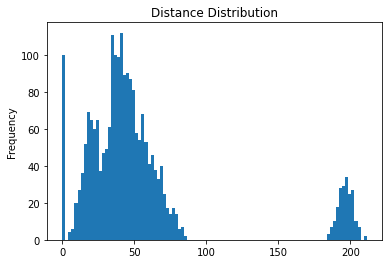

In [4]:
from sklearn.preprocessing import MinMaxScaler

crop_df['dist'] = distances
hist_plot = crop_df['dist'].plot(x = 'distance', y = 'frequency', kind='hist', title='Distance Distribution', bins=100)
hist_plot.plot()

[]

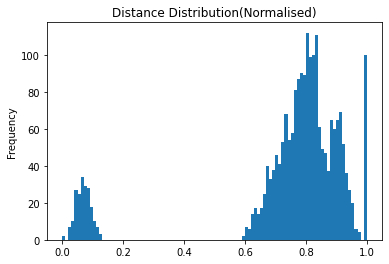

In [5]:
crop_df['dist'] = MinMaxScaler().fit_transform(np.array(crop_df['dist']).reshape(-1,1))
crop_df['dist'] = crop_df['dist'].apply(lambda x: 1 - x)
hist_plot = crop_df['dist'].plot(x = 'distance', y = 'frequency', kind='hist', title='Distance Distribution(Normalised)', bins=100)
hist_plot.plot()

[]

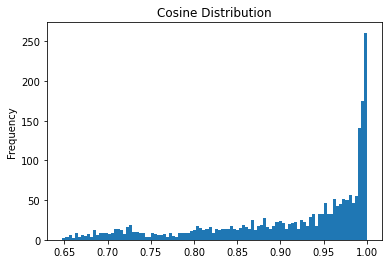

In [6]:
crop_df['similarity'] = cos_dists
hist_plot = crop_df['similarity'].plot(x = 'similarity', y = 'frequency', kind='hist', title='Cosine Distribution', bins=100)
hist_plot.plot()

## Test and Training Data Split

In [7]:
display(crop_df)

from sklearn.model_selection import train_test_split

X = crop_df.drop(['dist', 'similarity'], axis = 1)
Y = crop_df['dist']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

N   P   K  temperature   humidity        ph    rainfall      dist  \
0      90  42  43    20.879744  82.002744  6.502985  202.935536  0.891213   
1      85  58  41    21.770462  80.319644  7.038096  226.655537  0.907722   
2      60  55  44    23.004459  82.320763  7.840207  263.964248  0.881309   
3      74  35  40    26.491096  80.158363  6.980401  242.864034  0.899051   
4      78  42  42    20.130175  81.604873  7.628473  262.717340  0.889594   
...   ...  ..  ..          ...        ...       ...         ...       ...   
2195  107  34  32    26.774637  66.413269  6.780064  177.774507  0.926215   
2196   99  15  27    27.417112  56.636362  6.086922  127.924610  0.882862   
2197  118  33  30    24.131797  67.225123  6.362608  173.322839  0.895669   
2198  117  32  34    26.272418  52.127394  6.758793  127.175293  0.871020   
2199  104  18  30    23.603016  60.396475  6.779833  140.937041  0.896056   

      similarity  
0       0.993533  
1       0.994108  
2       0.985990  
3       0.992130  
4       0.991829  
...          ...  
2195    0.996264  
2196    0.981345  
2197    0.995310  
2198    0.984398  
2199    0.985163  

[2200 rows x 9 columns]

## Machine Learning Models
### Ensemble Models
Ensemble models is a machine learning approach to combine multiple other models in the prediction process. Those models are referred to as base estimators. It is a solution to overcome the following technical challenges of building a single estimator:

 * High variance: The model is very sensitive to the provided inputs to the learned features.
 * Low accuracy: One model or one algorithm to fit the entire training data might not be good enough to meet expectations.
 * Features noise and bias: The model relies heavily on one or a few features while making a prediction.
 
### Testing Accuracies

| Model | R-Score(Higher is Better) |
| --- | --- |
| Multi-Layer Perceptron | 0.497 |
| Random Forest | 0.961 |
| AdaBoost | 0.989 |
| LightGBM | 0.999 |

### Conclusion

* LightGBM has the highest testing score.
* LightGBM takes more time to train.
* MLP has worst testing score.
* MLP fails to map the output within `0-1`.
 

In [8]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=1, max_iter=500).fit(X_train, Y_train)
mlp.score(X_test, Y_test)

0.4977732295478966

In [9]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=3, random_state=0)
rfr.fit(X_train,Y_train)
rfr.score(X_test, Y_test)

0.9606263321836499

In [10]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(random_state=0, n_estimators=100)
ada.fit(X_train,Y_train)
ada.score(X_test, Y_test)

0.9894970265224704

In [11]:
import lightgbm as lgb

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': -1,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train, Y_train,
        eval_set=[(X_test, Y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)
gbm.score(X_test, Y_test)

/home/xd101/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/xd101/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[1]	valid_0's l1: 0.153776	valid_0's l2: 0.0615
[2]	valid_0's l1: 0.153086	valid_0's l2: 0.0609032
[3]	valid_0's l1: 0.152398	valid_0's l2: 0.0603123
[4]	valid_0's l1: 0.151714	valid_0's l2: 0.0597274
[5]	valid_0's l1: 0.150981	valid_0's l2: 0.0591391
[6]	valid_0's l1: 0.150247	valid_0's l2: 0.058555
[7]	valid_0's l1: 0.149573	valid_0's l2: 0.0579873
[8]	valid_0's l1: 0.148847	valid_0's l2: 0.0574159
[9]	valid_0's l1: 0.148126	valid_0's l2: 0.0568493
[10]	valid_0's l1: 0.147411	valid_0's l2: 0.0562914
[11]	valid_0's l1: 0.146694	valid_0's l2: 0.0557351
[12]	valid_0's l1: 0.14598	valid_0's l2: 0.0551843
[13]	valid_0's l1: 0.14527	valid_0's l2

[255]	valid_0's l1: 0.0465775	valid_0's l2: 0.00511293
[256]	valid_0's l1: 0.0463646	valid_0's l2: 0.00506373
[257]	valid_0's l1: 0.0461566	valid_0's l2: 0.00501528
[258]	valid_0's l1: 0.0459462	valid_0's l2: 0.00496693
[259]	valid_0's l1: 0.0457373	valid_0's l2: 0.00491898
[260]	valid_0's l1: 0.0455309	valid_0's l2: 0.00487179
[261]	valid_0's l1: 0.0453241	valid_0's l2: 0.00482539
[262]	valid_0's l1: 0.0451423	valid_0's l2: 0.00478083
[263]	valid_0's l1: 0.0449385	valid_0's l2: 0.0047349
[264]	valid_0's l1: 0.0447359	valid_0's l2: 0.00468943
[265]	valid_0's l1: 0.0445344	valid_0's l2: 0.00464476
[266]	valid_0's l1: 0.0443303	valid_0's l2: 0.0046003
[267]	valid_0's l1: 0.0441296	valid_0's l2: 0.00455612
[268]	valid_0's l1: 0.0439275	valid_0's l2: 0.00451253
[269]	valid_0's l1: 0.0437296	valid_0's l2: 0.00446959
[270]	valid_0's l1: 0.0435327	valid_0's l2: 0.00442708
[271]	valid_0's l1: 0.0433553	valid_0's l2: 0.00438646
[272]	valid_0's l1: 0.043163	valid_0's l2: 0.00434467
[273]	valid_0

[451]	valid_0's l1: 0.0205939	valid_0's l2: 0.00085801
[452]	valid_0's l1: 0.0205152	valid_0's l2: 0.000850818
[453]	valid_0's l1: 0.0204368	valid_0's l2: 0.000843697
[454]	valid_0's l1: 0.0203612	valid_0's l2: 0.000836651
[455]	valid_0's l1: 0.0202837	valid_0's l2: 0.000829667
[456]	valid_0's l1: 0.0202059	valid_0's l2: 0.000822713
[457]	valid_0's l1: 0.0201292	valid_0's l2: 0.000815852
[458]	valid_0's l1: 0.020053	valid_0's l2: 0.000809047
[459]	valid_0's l1: 0.0199793	valid_0's l2: 0.000802338
[460]	valid_0's l1: 0.0199055	valid_0's l2: 0.000795705
[461]	valid_0's l1: 0.0198308	valid_0's l2: 0.000789089
[462]	valid_0's l1: 0.019757	valid_0's l2: 0.000782564
[463]	valid_0's l1: 0.0196839	valid_0's l2: 0.000776137
[464]	valid_0's l1: 0.0196163	valid_0's l2: 0.000769963
[465]	valid_0's l1: 0.0195435	valid_0's l2: 0.000763598
[466]	valid_0's l1: 0.0194711	valid_0's l2: 0.000757297
[467]	valid_0's l1: 0.0193987	valid_0's l2: 0.0007511
[468]	valid_0's l1: 0.0193265	valid_0's l2: 0.0007449

[637]	valid_0's l1: 0.0112828	valid_0's l2: 0.000227567
[638]	valid_0's l1: 0.0112534	valid_0's l2: 0.000226304
[639]	valid_0's l1: 0.0112249	valid_0's l2: 0.000225101
[640]	valid_0's l1: 0.0111959	valid_0's l2: 0.000223865
[641]	valid_0's l1: 0.011166	valid_0's l2: 0.000222621
[642]	valid_0's l1: 0.0111368	valid_0's l2: 0.00022138
[643]	valid_0's l1: 0.0111078	valid_0's l2: 0.000220168
[644]	valid_0's l1: 0.0110786	valid_0's l2: 0.000218959
[645]	valid_0's l1: 0.01105	valid_0's l2: 0.000217799
[646]	valid_0's l1: 0.0110213	valid_0's l2: 0.0002166
[647]	valid_0's l1: 0.0109926	valid_0's l2: 0.000215425
[648]	valid_0's l1: 0.0109641	valid_0's l2: 0.000214268
[649]	valid_0's l1: 0.0109381	valid_0's l2: 0.000213201
[650]	valid_0's l1: 0.0109111	valid_0's l2: 0.000212091
[651]	valid_0's l1: 0.0108825	valid_0's l2: 0.000210949
[652]	valid_0's l1: 0.0108547	valid_0's l2: 0.000209828
[653]	valid_0's l1: 0.0108271	valid_0's l2: 0.000208733
[654]	valid_0's l1: 0.0107995	valid_0's l2: 0.00020764

[876]	valid_0's l1: 0.00724326	valid_0's l2: 9.74788e-05
[877]	valid_0's l1: 0.00723428	valid_0's l2: 9.72983e-05
[878]	valid_0's l1: 0.00722534	valid_0's l2: 9.71195e-05
[879]	valid_0's l1: 0.00721672	valid_0's l2: 9.69461e-05
[880]	valid_0's l1: 0.007208	valid_0's l2: 9.67701e-05
[881]	valid_0's l1: 0.0072001	valid_0's l2: 9.65892e-05
[882]	valid_0's l1: 0.00719165	valid_0's l2: 9.64239e-05
[883]	valid_0's l1: 0.00718338	valid_0's l2: 9.62474e-05
[884]	valid_0's l1: 0.00717557	valid_0's l2: 9.60935e-05
[885]	valid_0's l1: 0.0071679	valid_0's l2: 9.59446e-05
[886]	valid_0's l1: 0.00715973	valid_0's l2: 9.57724e-05
[887]	valid_0's l1: 0.00715211	valid_0's l2: 9.56225e-05
[888]	valid_0's l1: 0.00714398	valid_0's l2: 9.54655e-05
[889]	valid_0's l1: 0.00713602	valid_0's l2: 9.52954e-05
[890]	valid_0's l1: 0.00712852	valid_0's l2: 9.51496e-05
[891]	valid_0's l1: 0.00712046	valid_0's l2: 9.4989e-05
[892]	valid_0's l1: 0.00711284	valid_0's l2: 9.48426e-05
[893]	valid_0's l1: 0.00710571	valid

[1035]	valid_0's l1: 0.00630992	valid_0's l2: 8.02986e-05
[1036]	valid_0's l1: 0.00630546	valid_0's l2: 8.02146e-05
[1037]	valid_0's l1: 0.00630102	valid_0's l2: 8.01312e-05
[1038]	valid_0's l1: 0.00629642	valid_0's l2: 8.00517e-05
[1039]	valid_0's l1: 0.00629181	valid_0's l2: 7.99628e-05
[1040]	valid_0's l1: 0.00628751	valid_0's l2: 7.98868e-05
[1041]	valid_0's l1: 0.00628409	valid_0's l2: 7.98112e-05
[1042]	valid_0's l1: 0.00628103	valid_0's l2: 7.97504e-05
[1043]	valid_0's l1: 0.00627836	valid_0's l2: 7.96844e-05
[1044]	valid_0's l1: 0.00627495	valid_0's l2: 7.96097e-05
[1045]	valid_0's l1: 0.00627147	valid_0's l2: 7.95412e-05
[1046]	valid_0's l1: 0.00626806	valid_0's l2: 7.94742e-05
[1047]	valid_0's l1: 0.00626406	valid_0's l2: 7.94061e-05
[1048]	valid_0's l1: 0.00626133	valid_0's l2: 7.93509e-05
[1049]	valid_0's l1: 0.00625763	valid_0's l2: 7.92852e-05
[1050]	valid_0's l1: 0.0062533	valid_0's l2: 7.92067e-05
[1051]	valid_0's l1: 0.00624937	valid_0's l2: 7.91425e-05
[1052]	valid_0'

[1237]	valid_0's l1: 0.00577359	valid_0's l2: 7.10127e-05
[1238]	valid_0's l1: 0.00577159	valid_0's l2: 7.09668e-05
[1239]	valid_0's l1: 0.00576958	valid_0's l2: 7.09212e-05
[1240]	valid_0's l1: 0.0057675	valid_0's l2: 7.08778e-05
[1241]	valid_0's l1: 0.00576579	valid_0's l2: 7.08481e-05
[1242]	valid_0's l1: 0.00576427	valid_0's l2: 7.08275e-05
[1243]	valid_0's l1: 0.00576281	valid_0's l2: 7.08006e-05
[1244]	valid_0's l1: 0.00576123	valid_0's l2: 7.07719e-05
[1245]	valid_0's l1: 0.00575948	valid_0's l2: 7.0745e-05
[1246]	valid_0's l1: 0.00575808	valid_0's l2: 7.07258e-05
[1247]	valid_0's l1: 0.00575675	valid_0's l2: 7.07047e-05
[1248]	valid_0's l1: 0.00575521	valid_0's l2: 7.06793e-05
[1249]	valid_0's l1: 0.00575373	valid_0's l2: 7.0655e-05
[1250]	valid_0's l1: 0.00575204	valid_0's l2: 7.06296e-05
[1251]	valid_0's l1: 0.00575075	valid_0's l2: 7.06187e-05
[1252]	valid_0's l1: 0.00574973	valid_0's l2: 7.06061e-05
[1253]	valid_0's l1: 0.00574876	valid_0's l2: 7.06002e-05
[1254]	valid_0's 

[1480]	valid_0's l1: 0.00546288	valid_0's l2: 6.54646e-05
[1481]	valid_0's l1: 0.00546184	valid_0's l2: 6.54499e-05
[1482]	valid_0's l1: 0.00546119	valid_0's l2: 6.54367e-05
[1483]	valid_0's l1: 0.0054604	valid_0's l2: 6.54203e-05
[1484]	valid_0's l1: 0.00545946	valid_0's l2: 6.54069e-05
[1485]	valid_0's l1: 0.00545874	valid_0's l2: 6.54e-05
[1486]	valid_0's l1: 0.00545786	valid_0's l2: 6.53892e-05
[1487]	valid_0's l1: 0.00545714	valid_0's l2: 6.53825e-05
[1488]	valid_0's l1: 0.00545628	valid_0's l2: 6.5372e-05
[1489]	valid_0's l1: 0.00545485	valid_0's l2: 6.53559e-05
[1490]	valid_0's l1: 0.00545363	valid_0's l2: 6.53415e-05
[1491]	valid_0's l1: 0.00545225	valid_0's l2: 6.53178e-05
[1492]	valid_0's l1: 0.00545121	valid_0's l2: 6.53066e-05
[1493]	valid_0's l1: 0.0054509	valid_0's l2: 6.53059e-05
[1494]	valid_0's l1: 0.00545014	valid_0's l2: 6.52998e-05
[1495]	valid_0's l1: 0.00544945	valid_0's l2: 6.52934e-05
[1496]	valid_0's l1: 0.00544855	valid_0's l2: 6.52841e-05
[1497]	valid_0's l1:

[1699]	valid_0's l1: 0.00531381	valid_0's l2: 6.26805e-05
[1700]	valid_0's l1: 0.00531344	valid_0's l2: 6.26672e-05
[1701]	valid_0's l1: 0.00531227	valid_0's l2: 6.26484e-05
[1702]	valid_0's l1: 0.00531126	valid_0's l2: 6.26322e-05
[1703]	valid_0's l1: 0.00531106	valid_0's l2: 6.26382e-05
[1704]	valid_0's l1: 0.00531014	valid_0's l2: 6.26231e-05
[1705]	valid_0's l1: 0.00530997	valid_0's l2: 6.26204e-05
[1706]	valid_0's l1: 0.00530915	valid_0's l2: 6.26042e-05
[1707]	valid_0's l1: 0.00530876	valid_0's l2: 6.25966e-05
[1708]	valid_0's l1: 0.00530768	valid_0's l2: 6.25751e-05
[1709]	valid_0's l1: 0.00530687	valid_0's l2: 6.25602e-05
[1710]	valid_0's l1: 0.00530635	valid_0's l2: 6.25468e-05
[1711]	valid_0's l1: 0.00530598	valid_0's l2: 6.25392e-05
[1712]	valid_0's l1: 0.00530564	valid_0's l2: 6.25282e-05
[1713]	valid_0's l1: 0.00530534	valid_0's l2: 6.25173e-05
[1714]	valid_0's l1: 0.00530482	valid_0's l2: 6.24999e-05
[1715]	valid_0's l1: 0.0053043	valid_0's l2: 6.24896e-05
[1716]	valid_0'

[1927]	valid_0's l1: 0.00520184	valid_0's l2: 6.1099e-05
[1928]	valid_0's l1: 0.00520175	valid_0's l2: 6.1107e-05
[1929]	valid_0's l1: 0.0052018	valid_0's l2: 6.10991e-05
[1930]	valid_0's l1: 0.00520171	valid_0's l2: 6.11072e-05
[1931]	valid_0's l1: 0.0052012	valid_0's l2: 6.11014e-05
[1932]	valid_0's l1: 0.00520069	valid_0's l2: 6.10958e-05
[1933]	valid_0's l1: 0.00520023	valid_0's l2: 6.10916e-05
[1934]	valid_0's l1: 0.00519951	valid_0's l2: 6.10823e-05
[1935]	valid_0's l1: 0.00519915	valid_0's l2: 6.10824e-05
[1936]	valid_0's l1: 0.00519863	valid_0's l2: 6.10787e-05
[1937]	valid_0's l1: 0.00519813	valid_0's l2: 6.10732e-05
[1938]	valid_0's l1: 0.00519742	valid_0's l2: 6.10642e-05
[1939]	valid_0's l1: 0.00519692	valid_0's l2: 6.10588e-05
[1940]	valid_0's l1: 0.00519622	valid_0's l2: 6.105e-05
[1941]	valid_0's l1: 0.00519573	valid_0's l2: 6.10471e-05
[1942]	valid_0's l1: 0.00519517	valid_0's l2: 6.10457e-05
[1943]	valid_0's l1: 0.00519468	valid_0's l2: 6.1043e-05
[1944]	valid_0's l1: 

[2149]	valid_0's l1: 0.00511342	valid_0's l2: 5.95049e-05
[2150]	valid_0's l1: 0.00511387	valid_0's l2: 5.95126e-05
[2151]	valid_0's l1: 0.00511299	valid_0's l2: 5.94956e-05
[2152]	valid_0's l1: 0.00511279	valid_0's l2: 5.94916e-05
[2153]	valid_0's l1: 0.00511268	valid_0's l2: 5.94879e-05
[2154]	valid_0's l1: 0.00511233	valid_0's l2: 5.94803e-05
[2155]	valid_0's l1: 0.00511146	valid_0's l2: 5.94633e-05
[2156]	valid_0's l1: 0.00511107	valid_0's l2: 5.94558e-05
[2157]	valid_0's l1: 0.00511021	valid_0's l2: 5.9439e-05
[2158]	valid_0's l1: 0.00511013	valid_0's l2: 5.94373e-05
[2159]	valid_0's l1: 0.00510986	valid_0's l2: 5.94329e-05
[2160]	valid_0's l1: 0.00510994	valid_0's l2: 5.94315e-05
[2161]	valid_0's l1: 0.00510946	valid_0's l2: 5.94194e-05
[2162]	valid_0's l1: 0.00510866	valid_0's l2: 5.94001e-05
[2163]	valid_0's l1: 0.00510804	valid_0's l2: 5.93823e-05
[2164]	valid_0's l1: 0.00510745	valid_0's l2: 5.93629e-05
[2165]	valid_0's l1: 0.0051065	valid_0's l2: 5.93367e-05
[2166]	valid_0's

[2413]	valid_0's l1: 0.00502373	valid_0's l2: 5.7503e-05
[2414]	valid_0's l1: 0.00502349	valid_0's l2: 5.75069e-05
[2415]	valid_0's l1: 0.00502315	valid_0's l2: 5.75074e-05
[2416]	valid_0's l1: 0.00502285	valid_0's l2: 5.75081e-05
[2417]	valid_0's l1: 0.00502284	valid_0's l2: 5.75127e-05
[2418]	valid_0's l1: 0.00502274	valid_0's l2: 5.75188e-05
[2419]	valid_0's l1: 0.0050228	valid_0's l2: 5.75263e-05
[2420]	valid_0's l1: 0.0050225	valid_0's l2: 5.75268e-05
[2421]	valid_0's l1: 0.00502268	valid_0's l2: 5.75306e-05
[2422]	valid_0's l1: 0.00502286	valid_0's l2: 5.75345e-05
[2423]	valid_0's l1: 0.00502242	valid_0's l2: 5.7533e-05
[2424]	valid_0's l1: 0.00502206	valid_0's l2: 5.75336e-05
[2425]	valid_0's l1: 0.0050217	valid_0's l2: 5.75342e-05
[2426]	valid_0's l1: 0.00502195	valid_0's l2: 5.75377e-05
[2427]	valid_0's l1: 0.00502159	valid_0's l2: 5.75384e-05
[2428]	valid_0's l1: 0.00502177	valid_0's l2: 5.75423e-05
[2429]	valid_0's l1: 0.00502183	valid_0's l2: 5.75453e-05
[2430]	valid_0's l1

[2673]	valid_0's l1: 0.00497946	valid_0's l2: 5.67439e-05
[2674]	valid_0's l1: 0.00497925	valid_0's l2: 5.6732e-05
[2675]	valid_0's l1: 0.00497885	valid_0's l2: 5.67176e-05
[2676]	valid_0's l1: 0.00497864	valid_0's l2: 5.67055e-05
[2677]	valid_0's l1: 0.00497853	valid_0's l2: 5.66958e-05
[2678]	valid_0's l1: 0.00497836	valid_0's l2: 5.6684e-05
[2679]	valid_0's l1: 0.00497837	valid_0's l2: 5.66755e-05
[2680]	valid_0's l1: 0.0049783	valid_0's l2: 5.66669e-05
[2681]	valid_0's l1: 0.00497807	valid_0's l2: 5.66551e-05
[2682]	valid_0's l1: 0.00497784	valid_0's l2: 5.66434e-05
[2683]	valid_0's l1: 0.00497751	valid_0's l2: 5.66283e-05
[2684]	valid_0's l1: 0.00497744	valid_0's l2: 5.66197e-05
[2685]	valid_0's l1: 0.00497705	valid_0's l2: 5.66082e-05
[2686]	valid_0's l1: 0.00497663	valid_0's l2: 5.65966e-05
[2687]	valid_0's l1: 0.00497642	valid_0's l2: 5.65869e-05
[2688]	valid_0's l1: 0.0049762	valid_0's l2: 5.65752e-05
[2689]	valid_0's l1: 0.00497591	valid_0's l2: 5.6564e-05
[2690]	valid_0's l1

[2842]	valid_0's l1: 0.00495262	valid_0's l2: 5.60105e-05
[2843]	valid_0's l1: 0.00495225	valid_0's l2: 5.60062e-05
[2844]	valid_0's l1: 0.00495226	valid_0's l2: 5.60022e-05
[2845]	valid_0's l1: 0.00495195	valid_0's l2: 5.6e-05
[2846]	valid_0's l1: 0.00495158	valid_0's l2: 5.59958e-05
[2847]	valid_0's l1: 0.00495157	valid_0's l2: 5.59979e-05
[2848]	valid_0's l1: 0.00495156	valid_0's l2: 5.60001e-05
[2849]	valid_0's l1: 0.00495157	valid_0's l2: 5.60023e-05
[2850]	valid_0's l1: 0.00495151	valid_0's l2: 5.59976e-05
[2851]	valid_0's l1: 0.0049515	valid_0's l2: 5.60002e-05
[2852]	valid_0's l1: 0.00495149	valid_0's l2: 5.60027e-05
[2853]	valid_0's l1: 0.00495154	valid_0's l2: 5.60061e-05
[2854]	valid_0's l1: 0.00495155	valid_0's l2: 5.601e-05
[2855]	valid_0's l1: 0.00495118	valid_0's l2: 5.6006e-05
[2856]	valid_0's l1: 0.00495118	valid_0's l2: 5.601e-05
[2857]	valid_0's l1: 0.00495117	valid_0's l2: 5.60126e-05
[2858]	valid_0's l1: 0.00495122	valid_0's l2: 5.6016e-05
[2859]	valid_0's l1: 0.00

[3058]	valid_0's l1: 0.00492428	valid_0's l2: 5.55833e-05
[3059]	valid_0's l1: 0.00492413	valid_0's l2: 5.55844e-05
[3060]	valid_0's l1: 0.00492397	valid_0's l2: 5.55856e-05
[3061]	valid_0's l1: 0.00492409	valid_0's l2: 5.55887e-05
[3062]	valid_0's l1: 0.0049241	valid_0's l2: 5.55911e-05
[3063]	valid_0's l1: 0.0049241	valid_0's l2: 5.55936e-05
[3064]	valid_0's l1: 0.00492419	valid_0's l2: 5.55974e-05
[3065]	valid_0's l1: 0.00492431	valid_0's l2: 5.5601e-05
[3066]	valid_0's l1: 0.00492413	valid_0's l2: 5.55983e-05
[3067]	valid_0's l1: 0.00492424	valid_0's l2: 5.56016e-05
[3068]	valid_0's l1: 0.00492434	valid_0's l2: 5.56047e-05
[3069]	valid_0's l1: 0.0049239	valid_0's l2: 5.55992e-05
[3070]	valid_0's l1: 0.00492392	valid_0's l2: 5.5601e-05
[3071]	valid_0's l1: 0.0049235	valid_0's l2: 5.55968e-05
[3072]	valid_0's l1: 0.00492333	valid_0's l2: 5.55934e-05
[3073]	valid_0's l1: 0.00492339	valid_0's l2: 5.55872e-05
[3074]	valid_0's l1: 0.00492298	valid_0's l2: 5.5583e-05
[3075]	valid_0's l1: 

[3303]	valid_0's l1: 0.00488079	valid_0's l2: 5.48143e-05
[3304]	valid_0's l1: 0.00488069	valid_0's l2: 5.48078e-05
[3305]	valid_0's l1: 0.00488041	valid_0's l2: 5.47979e-05
[3306]	valid_0's l1: 0.00488024	valid_0's l2: 5.47899e-05
[3307]	valid_0's l1: 0.00488004	valid_0's l2: 5.47822e-05
[3308]	valid_0's l1: 0.00487977	valid_0's l2: 5.47722e-05
[3309]	valid_0's l1: 0.0048795	valid_0's l2: 5.47626e-05
[3310]	valid_0's l1: 0.00487932	valid_0's l2: 5.47548e-05
[3311]	valid_0's l1: 0.00487933	valid_0's l2: 5.47583e-05
[3312]	valid_0's l1: 0.00487905	valid_0's l2: 5.47573e-05
[3313]	valid_0's l1: 0.00487894	valid_0's l2: 5.47597e-05
[3314]	valid_0's l1: 0.00487905	valid_0's l2: 5.47618e-05
[3315]	valid_0's l1: 0.00487916	valid_0's l2: 5.47639e-05
[3316]	valid_0's l1: 0.00487901	valid_0's l2: 5.47655e-05
[3317]	valid_0's l1: 0.00487902	valid_0's l2: 5.47637e-05
[3318]	valid_0's l1: 0.00487886	valid_0's l2: 5.47645e-05
[3319]	valid_0's l1: 0.00487876	valid_0's l2: 5.47598e-05
[3320]	valid_0'

[3487]	valid_0's l1: 0.00485265	valid_0's l2: 5.43968e-05
[3488]	valid_0's l1: 0.00485261	valid_0's l2: 5.43924e-05
[3489]	valid_0's l1: 0.00485241	valid_0's l2: 5.43859e-05
[3490]	valid_0's l1: 0.00485241	valid_0's l2: 5.4381e-05
[3491]	valid_0's l1: 0.00485214	valid_0's l2: 5.43737e-05
[3492]	valid_0's l1: 0.00485224	valid_0's l2: 5.43761e-05
[3493]	valid_0's l1: 0.00485234	valid_0's l2: 5.43782e-05
[3494]	valid_0's l1: 0.00485219	valid_0's l2: 5.43733e-05
[3495]	valid_0's l1: 0.00485229	valid_0's l2: 5.43758e-05
[3496]	valid_0's l1: 0.00485215	valid_0's l2: 5.4371e-05
[3497]	valid_0's l1: 0.00485197	valid_0's l2: 5.43645e-05
[3498]	valid_0's l1: 0.0048518	valid_0's l2: 5.43588e-05
[3499]	valid_0's l1: 0.0048518	valid_0's l2: 5.43556e-05
[3500]	valid_0's l1: 0.0048519	valid_0's l2: 5.43577e-05
[3501]	valid_0's l1: 0.0048522	valid_0's l2: 5.43588e-05
[3502]	valid_0's l1: 0.00485216	valid_0's l2: 5.43477e-05
[3503]	valid_0's l1: 0.00485167	valid_0's l2: 5.43316e-05
[3504]	valid_0's l1:

[3825]	valid_0's l1: 0.00481739	valid_0's l2: 5.33618e-05
[3826]	valid_0's l1: 0.00481677	valid_0's l2: 5.33476e-05
[3827]	valid_0's l1: 0.00481617	valid_0's l2: 5.33338e-05
[3828]	valid_0's l1: 0.0048157	valid_0's l2: 5.33225e-05
[3829]	valid_0's l1: 0.00481521	valid_0's l2: 5.33108e-05
[3830]	valid_0's l1: 0.00481472	valid_0's l2: 5.32996e-05
[3831]	valid_0's l1: 0.00481416	valid_0's l2: 5.32891e-05
[3832]	valid_0's l1: 0.00481402	valid_0's l2: 5.32811e-05
[3833]	valid_0's l1: 0.00481388	valid_0's l2: 5.32732e-05
[3834]	valid_0's l1: 0.00481379	valid_0's l2: 5.32684e-05
[3835]	valid_0's l1: 0.00481363	valid_0's l2: 5.32622e-05
[3836]	valid_0's l1: 0.00481346	valid_0's l2: 5.32552e-05
[3837]	valid_0's l1: 0.00481334	valid_0's l2: 5.32477e-05
[3838]	valid_0's l1: 0.00481315	valid_0's l2: 5.32415e-05
[3839]	valid_0's l1: 0.00481283	valid_0's l2: 5.3231e-05
[3840]	valid_0's l1: 0.00481271	valid_0's l2: 5.32256e-05
[3841]	valid_0's l1: 0.00481277	valid_0's l2: 5.32288e-05
[3842]	valid_0's

[4076]	valid_0's l1: 0.00479801	valid_0's l2: 5.29288e-05
[4077]	valid_0's l1: 0.00479757	valid_0's l2: 5.29269e-05
[4078]	valid_0's l1: 0.00479763	valid_0's l2: 5.29299e-05
[4079]	valid_0's l1: 0.00479768	valid_0's l2: 5.29329e-05
[4080]	valid_0's l1: 0.00479733	valid_0's l2: 5.29301e-05
[4081]	valid_0's l1: 0.00479708	valid_0's l2: 5.29268e-05
[4082]	valid_0's l1: 0.00479701	valid_0's l2: 5.29282e-05
[4083]	valid_0's l1: 0.00479682	valid_0's l2: 5.29269e-05
[4084]	valid_0's l1: 0.00479674	valid_0's l2: 5.29261e-05
[4085]	valid_0's l1: 0.00479665	valid_0's l2: 5.29254e-05
[4086]	valid_0's l1: 0.00479658	valid_0's l2: 5.29269e-05
[4087]	valid_0's l1: 0.0047963	valid_0's l2: 5.29265e-05
[4088]	valid_0's l1: 0.00479599	valid_0's l2: 5.29224e-05
[4089]	valid_0's l1: 0.00479581	valid_0's l2: 5.29212e-05
[4090]	valid_0's l1: 0.00479553	valid_0's l2: 5.29209e-05
[4091]	valid_0's l1: 0.00479535	valid_0's l2: 5.29236e-05
[4092]	valid_0's l1: 0.00479534	valid_0's l2: 5.29277e-05
[4093]	valid_0'

[4415]	valid_0's l1: 0.00478275	valid_0's l2: 5.27664e-05
[4416]	valid_0's l1: 0.0047827	valid_0's l2: 5.27673e-05
[4417]	valid_0's l1: 0.0047829	valid_0's l2: 5.27667e-05
[4418]	valid_0's l1: 0.00478275	valid_0's l2: 5.27665e-05
[4419]	valid_0's l1: 0.00478262	valid_0's l2: 5.27668e-05
[4420]	valid_0's l1: 0.00478253	valid_0's l2: 5.27666e-05
[4421]	valid_0's l1: 0.00478237	valid_0's l2: 5.27667e-05
[4422]	valid_0's l1: 0.00478207	valid_0's l2: 5.27612e-05
[4423]	valid_0's l1: 0.00478184	valid_0's l2: 5.27595e-05
[4424]	valid_0's l1: 0.00478165	valid_0's l2: 5.27585e-05
[4425]	valid_0's l1: 0.00478142	valid_0's l2: 5.27569e-05
[4426]	valid_0's l1: 0.00478121	valid_0's l2: 5.27564e-05
[4427]	valid_0's l1: 0.004781	valid_0's l2: 5.27559e-05
[4428]	valid_0's l1: 0.00478085	valid_0's l2: 5.27557e-05
[4429]	valid_0's l1: 0.00478067	valid_0's l2: 5.27557e-05
[4430]	valid_0's l1: 0.00478044	valid_0's l2: 5.27541e-05
[4431]	valid_0's l1: 0.0047802	valid_0's l2: 5.27482e-05
[4432]	valid_0's l1

[4641]	valid_0's l1: 0.00476957	valid_0's l2: 5.24463e-05
[4642]	valid_0's l1: 0.00476955	valid_0's l2: 5.24473e-05
[4643]	valid_0's l1: 0.00476969	valid_0's l2: 5.24495e-05
[4644]	valid_0's l1: 0.00476975	valid_0's l2: 5.2453e-05
[4645]	valid_0's l1: 0.00476973	valid_0's l2: 5.24541e-05
[4646]	valid_0's l1: 0.0047699	valid_0's l2: 5.24578e-05
[4647]	valid_0's l1: 0.00477003	valid_0's l2: 5.24589e-05
[4648]	valid_0's l1: 0.00477001	valid_0's l2: 5.24601e-05
[4649]	valid_0's l1: 0.00477007	valid_0's l2: 5.24633e-05
[4650]	valid_0's l1: 0.00477019	valid_0's l2: 5.24656e-05
[4651]	valid_0's l1: 0.00476998	valid_0's l2: 5.24599e-05
[4652]	valid_0's l1: 0.00477018	valid_0's l2: 5.24617e-05
[4653]	valid_0's l1: 0.00476994	valid_0's l2: 5.24556e-05
[4654]	valid_0's l1: 0.0047697	valid_0's l2: 5.245e-05
[4655]	valid_0's l1: 0.00476954	valid_0's l2: 5.24469e-05
[4656]	valid_0's l1: 0.00476929	valid_0's l2: 5.24429e-05
[4657]	valid_0's l1: 0.00476935	valid_0's l2: 5.24404e-05
[4658]	valid_0's l1

[4842]	valid_0's l1: 0.00476086	valid_0's l2: 5.23592e-05
[4843]	valid_0's l1: 0.00476099	valid_0's l2: 5.23592e-05
[4844]	valid_0's l1: 0.00476077	valid_0's l2: 5.23563e-05
[4845]	valid_0's l1: 0.00476091	valid_0's l2: 5.23589e-05
[4846]	valid_0's l1: 0.00476069	valid_0's l2: 5.23565e-05
[4847]	valid_0's l1: 0.00476078	valid_0's l2: 5.23582e-05
[4848]	valid_0's l1: 0.00476043	valid_0's l2: 5.23571e-05
[4849]	valid_0's l1: 0.00476024	valid_0's l2: 5.23544e-05
[4850]	valid_0's l1: 0.00476004	valid_0's l2: 5.23525e-05
[4851]	valid_0's l1: 0.00475995	valid_0's l2: 5.2349e-05
[4852]	valid_0's l1: 0.0047599	valid_0's l2: 5.23474e-05
[4853]	valid_0's l1: 0.00475981	valid_0's l2: 5.23439e-05
[4854]	valid_0's l1: 0.00475992	valid_0's l2: 5.23433e-05
[4855]	valid_0's l1: 0.00475988	valid_0's l2: 5.23417e-05
[4856]	valid_0's l1: 0.00476	valid_0's l2: 5.23413e-05
[4857]	valid_0's l1: 0.00476005	valid_0's l2: 5.23429e-05
[4858]	valid_0's l1: 0.00476001	valid_0's l2: 5.23414e-05
[4859]	valid_0's l1

[5089]	valid_0's l1: 0.00474659	valid_0's l2: 5.21237e-05
[5090]	valid_0's l1: 0.0047468	valid_0's l2: 5.21267e-05
[5091]	valid_0's l1: 0.00474681	valid_0's l2: 5.21301e-05
[5092]	valid_0's l1: 0.00474675	valid_0's l2: 5.21337e-05
[5093]	valid_0's l1: 0.00474678	valid_0's l2: 5.21369e-05
[5094]	valid_0's l1: 0.00474672	valid_0's l2: 5.21405e-05
[5095]	valid_0's l1: 0.00474662	valid_0's l2: 5.21412e-05
[5096]	valid_0's l1: 0.00474651	valid_0's l2: 5.21419e-05
[5097]	valid_0's l1: 0.00474645	valid_0's l2: 5.21455e-05
[5098]	valid_0's l1: 0.00474636	valid_0's l2: 5.21466e-05
[5099]	valid_0's l1: 0.00474628	valid_0's l2: 5.21491e-05
[5100]	valid_0's l1: 0.00474618	valid_0's l2: 5.21497e-05
[5101]	valid_0's l1: 0.00474608	valid_0's l2: 5.21454e-05
[5102]	valid_0's l1: 0.00474599	valid_0's l2: 5.21418e-05
[5103]	valid_0's l1: 0.00474589	valid_0's l2: 5.21375e-05
[5104]	valid_0's l1: 0.00474582	valid_0's l2: 5.21339e-05
[5105]	valid_0's l1: 0.00474572	valid_0's l2: 5.21297e-05
[5106]	valid_0'

[5312]	valid_0's l1: 0.00473836	valid_0's l2: 5.20326e-05
[5313]	valid_0's l1: 0.00473826	valid_0's l2: 5.20307e-05
[5314]	valid_0's l1: 0.00473807	valid_0's l2: 5.20277e-05
[5315]	valid_0's l1: 0.00473787	valid_0's l2: 5.20242e-05
[5316]	valid_0's l1: 0.00473759	valid_0's l2: 5.20184e-05
[5317]	valid_0's l1: 0.00473737	valid_0's l2: 5.20134e-05
[5318]	valid_0's l1: 0.0047371	valid_0's l2: 5.20077e-05
[5319]	valid_0's l1: 0.00473702	valid_0's l2: 5.2005e-05
[5320]	valid_0's l1: 0.00473679	valid_0's l2: 5.19998e-05
[5321]	valid_0's l1: 0.00473651	valid_0's l2: 5.1997e-05
[5322]	valid_0's l1: 0.00473624	valid_0's l2: 5.19943e-05
[5323]	valid_0's l1: 0.00473621	valid_0's l2: 5.19945e-05
[5324]	valid_0's l1: 0.00473617	valid_0's l2: 5.19948e-05
[5325]	valid_0's l1: 0.00473611	valid_0's l2: 5.19882e-05
[5326]	valid_0's l1: 0.00473585	valid_0's l2: 5.19863e-05
[5327]	valid_0's l1: 0.00473582	valid_0's l2: 5.19871e-05
[5328]	valid_0's l1: 0.0047355	valid_0's l2: 5.19843e-05
[5329]	valid_0's l

[5588]	valid_0's l1: 0.00472001	valid_0's l2: 5.1655e-05
[5589]	valid_0's l1: 0.00471996	valid_0's l2: 5.16577e-05
[5590]	valid_0's l1: 0.00471986	valid_0's l2: 5.166e-05
[5591]	valid_0's l1: 0.00471978	valid_0's l2: 5.16603e-05
[5592]	valid_0's l1: 0.0047197	valid_0's l2: 5.16562e-05
[5593]	valid_0's l1: 0.0047198	valid_0's l2: 5.16547e-05
[5594]	valid_0's l1: 0.0047199	valid_0's l2: 5.16531e-05
[5595]	valid_0's l1: 0.00471982	valid_0's l2: 5.16534e-05
[5596]	valid_0's l1: 0.00471972	valid_0's l2: 5.16493e-05
[5597]	valid_0's l1: 0.00471982	valid_0's l2: 5.16477e-05
[5598]	valid_0's l1: 0.00471981	valid_0's l2: 5.16449e-05
[5599]	valid_0's l1: 0.00471991	valid_0's l2: 5.16434e-05
[5600]	valid_0's l1: 0.00471982	valid_0's l2: 5.16396e-05
[5601]	valid_0's l1: 0.00471979	valid_0's l2: 5.16383e-05
[5602]	valid_0's l1: 0.00471967	valid_0's l2: 5.16346e-05
[5603]	valid_0's l1: 0.00471987	valid_0's l2: 5.16355e-05
[5604]	valid_0's l1: 0.00471984	valid_0's l2: 5.16342e-05
[5605]	valid_0's l1:

[5835]	valid_0's l1: 0.00471043	valid_0's l2: 5.15355e-05
[5836]	valid_0's l1: 0.00471037	valid_0's l2: 5.15316e-05
[5837]	valid_0's l1: 0.00471024	valid_0's l2: 5.15267e-05
[5838]	valid_0's l1: 0.00471021	valid_0's l2: 5.15291e-05
[5839]	valid_0's l1: 0.00471012	valid_0's l2: 5.15298e-05
[5840]	valid_0's l1: 0.00471016	valid_0's l2: 5.15325e-05
[5841]	valid_0's l1: 0.00471002	valid_0's l2: 5.1528e-05
[5842]	valid_0's l1: 0.00470986	valid_0's l2: 5.15235e-05
[5843]	valid_0's l1: 0.00470974	valid_0's l2: 5.15191e-05
[5844]	valid_0's l1: 0.00470962	valid_0's l2: 5.15157e-05
[5845]	valid_0's l1: 0.00470948	valid_0's l2: 5.15113e-05
[5846]	valid_0's l1: 0.00470936	valid_0's l2: 5.1507e-05
[5847]	valid_0's l1: 0.00470921	valid_0's l2: 5.15035e-05
[5848]	valid_0's l1: 0.00470914	valid_0's l2: 5.15039e-05
[5849]	valid_0's l1: 0.00470905	valid_0's l2: 5.15011e-05
[5850]	valid_0's l1: 0.00470893	valid_0's l2: 5.1498e-05
[5851]	valid_0's l1: 0.00470896	valid_0's l2: 5.14966e-05
[5852]	valid_0's 

[6109]	valid_0's l1: 0.00469923	valid_0's l2: 5.12896e-05
[6110]	valid_0's l1: 0.00469925	valid_0's l2: 5.12877e-05
[6111]	valid_0's l1: 0.00469945	valid_0's l2: 5.12915e-05
[6112]	valid_0's l1: 0.00469961	valid_0's l2: 5.1295e-05
[6113]	valid_0's l1: 0.0046997	valid_0's l2: 5.12996e-05
[6114]	valid_0's l1: 0.00469987	valid_0's l2: 5.13031e-05
[6115]	valid_0's l1: 0.00470003	valid_0's l2: 5.13066e-05
[6116]	valid_0's l1: 0.00470019	valid_0's l2: 5.13101e-05
[6117]	valid_0's l1: 0.00470035	valid_0's l2: 5.13145e-05
[6118]	valid_0's l1: 0.00470053	valid_0's l2: 5.1319e-05
[6119]	valid_0's l1: 0.00470073	valid_0's l2: 5.13235e-05
[6120]	valid_0's l1: 0.00470091	valid_0's l2: 5.13286e-05
[6121]	valid_0's l1: 0.00470093	valid_0's l2: 5.13273e-05
[6122]	valid_0's l1: 0.00470085	valid_0's l2: 5.1327e-05
[6123]	valid_0's l1: 0.00470085	valid_0's l2: 5.13259e-05
[6124]	valid_0's l1: 0.00470064	valid_0's l2: 5.13223e-05
[6125]	valid_0's l1: 0.00470066	valid_0's l2: 5.13211e-05
[6126]	valid_0's l

[6360]	valid_0's l1: 0.00469455	valid_0's l2: 5.12479e-05
[6361]	valid_0's l1: 0.00469422	valid_0's l2: 5.12394e-05
[6362]	valid_0's l1: 0.00469413	valid_0's l2: 5.124e-05
[6363]	valid_0's l1: 0.00469408	valid_0's l2: 5.12406e-05
[6364]	valid_0's l1: 0.00469403	valid_0's l2: 5.12413e-05
[6365]	valid_0's l1: 0.00469397	valid_0's l2: 5.12412e-05
[6366]	valid_0's l1: 0.0046939	valid_0's l2: 5.12411e-05
[6367]	valid_0's l1: 0.00469385	valid_0's l2: 5.12418e-05
[6368]	valid_0's l1: 0.00469378	valid_0's l2: 5.12417e-05
[6369]	valid_0's l1: 0.00469371	valid_0's l2: 5.12416e-05
[6370]	valid_0's l1: 0.00469368	valid_0's l2: 5.12423e-05
[6371]	valid_0's l1: 0.0046936	valid_0's l2: 5.12411e-05
[6372]	valid_0's l1: 0.00469347	valid_0's l2: 5.12394e-05
[6373]	valid_0's l1: 0.00469343	valid_0's l2: 5.12389e-05
[6374]	valid_0's l1: 0.0046934	valid_0's l2: 5.12385e-05
[6375]	valid_0's l1: 0.00469328	valid_0's l2: 5.12373e-05
[6376]	valid_0's l1: 0.00469322	valid_0's l2: 5.12382e-05
[6377]	valid_0's l1

[6530]	valid_0's l1: 0.00468769	valid_0's l2: 5.08629e-05
[6531]	valid_0's l1: 0.00468765	valid_0's l2: 5.08605e-05
[6532]	valid_0's l1: 0.00468752	valid_0's l2: 5.08604e-05
[6533]	valid_0's l1: 0.0046874	valid_0's l2: 5.08604e-05
[6534]	valid_0's l1: 0.00468729	valid_0's l2: 5.08575e-05
[6535]	valid_0's l1: 0.00468722	valid_0's l2: 5.08553e-05
[6536]	valid_0's l1: 0.00468691	valid_0's l2: 5.08504e-05
[6537]	valid_0's l1: 0.00468676	valid_0's l2: 5.08486e-05
[6538]	valid_0's l1: 0.00468659	valid_0's l2: 5.08454e-05
[6539]	valid_0's l1: 0.00468652	valid_0's l2: 5.08433e-05
[6540]	valid_0's l1: 0.00468646	valid_0's l2: 5.08424e-05
[6541]	valid_0's l1: 0.00468639	valid_0's l2: 5.08433e-05
[6542]	valid_0's l1: 0.00468634	valid_0's l2: 5.08438e-05
[6543]	valid_0's l1: 0.00468631	valid_0's l2: 5.08451e-05
[6544]	valid_0's l1: 0.00468628	valid_0's l2: 5.08464e-05
[6545]	valid_0's l1: 0.0046861	valid_0's l2: 5.08402e-05
[6546]	valid_0's l1: 0.00468605	valid_0's l2: 5.08407e-05
[6547]	valid_0's

[6862]	valid_0's l1: 0.00467663	valid_0's l2: 5.07094e-05
[6863]	valid_0's l1: 0.00467666	valid_0's l2: 5.07111e-05
[6864]	valid_0's l1: 0.00467659	valid_0's l2: 5.07077e-05
[6865]	valid_0's l1: 0.00467679	valid_0's l2: 5.0712e-05
[6866]	valid_0's l1: 0.00467692	valid_0's l2: 5.07143e-05
[6867]	valid_0's l1: 0.00467695	valid_0's l2: 5.0716e-05
[6868]	valid_0's l1: 0.00467698	valid_0's l2: 5.07183e-05
[6869]	valid_0's l1: 0.004677	valid_0's l2: 5.07201e-05
[6870]	valid_0's l1: 0.00467719	valid_0's l2: 5.07248e-05
[6871]	valid_0's l1: 0.00467735	valid_0's l2: 5.07308e-05
[6872]	valid_0's l1: 0.00467745	valid_0's l2: 5.07322e-05
[6873]	valid_0's l1: 0.00467738	valid_0's l2: 5.07337e-05
[6874]	valid_0's l1: 0.00467745	valid_0's l2: 5.07375e-05
[6875]	valid_0's l1: 0.00467738	valid_0's l2: 5.0739e-05
[6876]	valid_0's l1: 0.00467752	valid_0's l2: 5.07429e-05
[6877]	valid_0's l1: 0.00467764	valid_0's l2: 5.07467e-05
[6878]	valid_0's l1: 0.00467779	valid_0's l2: 5.07505e-05
[6879]	valid_0's l1

[7047]	valid_0's l1: 0.00467314	valid_0's l2: 5.06456e-05
[7048]	valid_0's l1: 0.00467292	valid_0's l2: 5.06421e-05
[7049]	valid_0's l1: 0.00467268	valid_0's l2: 5.06382e-05
[7050]	valid_0's l1: 0.00467242	valid_0's l2: 5.06341e-05
[7051]	valid_0's l1: 0.00467229	valid_0's l2: 5.06308e-05
[7052]	valid_0's l1: 0.00467235	valid_0's l2: 5.06299e-05
[7053]	valid_0's l1: 0.00467222	valid_0's l2: 5.06268e-05
[7054]	valid_0's l1: 0.0046721	valid_0's l2: 5.06235e-05
[7055]	valid_0's l1: 0.00467215	valid_0's l2: 5.0622e-05
[7056]	valid_0's l1: 0.00467207	valid_0's l2: 5.06202e-05
[7057]	valid_0's l1: 0.00467199	valid_0's l2: 5.06166e-05
[7058]	valid_0's l1: 0.00467183	valid_0's l2: 5.06134e-05
[7059]	valid_0's l1: 0.00467185	valid_0's l2: 5.06113e-05
[7060]	valid_0's l1: 0.00467181	valid_0's l2: 5.06088e-05
[7061]	valid_0's l1: 0.00467171	valid_0's l2: 5.06078e-05
[7062]	valid_0's l1: 0.00467162	valid_0's l2: 5.06062e-05
[7063]	valid_0's l1: 0.00467153	valid_0's l2: 5.06039e-05
[7064]	valid_0's

[7254]	valid_0's l1: 0.00466269	valid_0's l2: 5.04486e-05
[7255]	valid_0's l1: 0.00466275	valid_0's l2: 5.04508e-05
[7256]	valid_0's l1: 0.00466279	valid_0's l2: 5.04527e-05
[7257]	valid_0's l1: 0.00466285	valid_0's l2: 5.04549e-05
[7258]	valid_0's l1: 0.00466291	valid_0's l2: 5.04571e-05
[7259]	valid_0's l1: 0.004663	valid_0's l2: 5.04593e-05
[7260]	valid_0's l1: 0.00466304	valid_0's l2: 5.04613e-05
[7261]	valid_0's l1: 0.00466307	valid_0's l2: 5.0467e-05
[7262]	valid_0's l1: 0.004663	valid_0's l2: 5.04636e-05
[7263]	valid_0's l1: 0.00466292	valid_0's l2: 5.04601e-05
[7264]	valid_0's l1: 0.00466294	valid_0's l2: 5.04657e-05
[7265]	valid_0's l1: 0.00466286	valid_0's l2: 5.04622e-05
[7266]	valid_0's l1: 0.00466277	valid_0's l2: 5.04587e-05
[7267]	valid_0's l1: 0.00466269	valid_0's l2: 5.04551e-05
[7268]	valid_0's l1: 0.00466261	valid_0's l2: 5.04516e-05
[7269]	valid_0's l1: 0.00466261	valid_0's l2: 5.04485e-05
[7270]	valid_0's l1: 0.00466253	valid_0's l2: 5.04452e-05
[7271]	valid_0's l1

[7565]	valid_0's l1: 0.00465337	valid_0's l2: 5.02694e-05
[7566]	valid_0's l1: 0.00465328	valid_0's l2: 5.02689e-05
[7567]	valid_0's l1: 0.00465318	valid_0's l2: 5.02699e-05
[7568]	valid_0's l1: 0.00465314	valid_0's l2: 5.02717e-05
[7569]	valid_0's l1: 0.00465313	valid_0's l2: 5.02745e-05
[7570]	valid_0's l1: 0.00465308	valid_0's l2: 5.02763e-05
[7571]	valid_0's l1: 0.00465312	valid_0's l2: 5.02764e-05
[7572]	valid_0's l1: 0.00465308	valid_0's l2: 5.0275e-05
[7573]	valid_0's l1: 0.00465308	valid_0's l2: 5.02707e-05
[7574]	valid_0's l1: 0.00465304	valid_0's l2: 5.02693e-05
[7575]	valid_0's l1: 0.00465299	valid_0's l2: 5.02676e-05
[7576]	valid_0's l1: 0.00465297	valid_0's l2: 5.02663e-05
[7577]	valid_0's l1: 0.0046528	valid_0's l2: 5.02638e-05
[7578]	valid_0's l1: 0.00465286	valid_0's l2: 5.02643e-05
[7579]	valid_0's l1: 0.00465281	valid_0's l2: 5.02629e-05
[7580]	valid_0's l1: 0.00465283	valid_0's l2: 5.02618e-05
[7581]	valid_0's l1: 0.00465274	valid_0's l2: 5.02584e-05
[7582]	valid_0's

[7952]	valid_0's l1: 0.0046485	valid_0's l2: 5.01692e-05
[7953]	valid_0's l1: 0.00464853	valid_0's l2: 5.01675e-05
[7954]	valid_0's l1: 0.00464843	valid_0's l2: 5.01641e-05
[7955]	valid_0's l1: 0.00464837	valid_0's l2: 5.01609e-05
[7956]	valid_0's l1: 0.00464826	valid_0's l2: 5.01578e-05
[7957]	valid_0's l1: 0.00464827	valid_0's l2: 5.01565e-05
[7958]	valid_0's l1: 0.00464824	valid_0's l2: 5.01546e-05
[7959]	valid_0's l1: 0.00464814	valid_0's l2: 5.01513e-05
[7960]	valid_0's l1: 0.00464813	valid_0's l2: 5.01496e-05
[7961]	valid_0's l1: 0.00464816	valid_0's l2: 5.01511e-05
[7962]	valid_0's l1: 0.00464817	valid_0's l2: 5.01522e-05
[7963]	valid_0's l1: 0.00464815	valid_0's l2: 5.01533e-05
[7964]	valid_0's l1: 0.00464818	valid_0's l2: 5.01547e-05
[7965]	valid_0's l1: 0.00464819	valid_0's l2: 5.01555e-05
[7966]	valid_0's l1: 0.00464817	valid_0's l2: 5.01566e-05
[7967]	valid_0's l1: 0.00464818	valid_0's l2: 5.01575e-05
[7968]	valid_0's l1: 0.00464812	valid_0's l2: 5.01592e-05
[7969]	valid_0'

[8167]	valid_0's l1: 0.00464293	valid_0's l2: 5.01599e-05
[8168]	valid_0's l1: 0.00464304	valid_0's l2: 5.01626e-05
[8169]	valid_0's l1: 0.00464308	valid_0's l2: 5.01657e-05
[8170]	valid_0's l1: 0.00464313	valid_0's l2: 5.0169e-05
[8171]	valid_0's l1: 0.00464303	valid_0's l2: 5.01651e-05
[8172]	valid_0's l1: 0.00464295	valid_0's l2: 5.01633e-05
[8173]	valid_0's l1: 0.00464284	valid_0's l2: 5.01595e-05
[8174]	valid_0's l1: 0.00464274	valid_0's l2: 5.01556e-05
[8175]	valid_0's l1: 0.0046426	valid_0's l2: 5.01507e-05
[8176]	valid_0's l1: 0.0046425	valid_0's l2: 5.01469e-05
[8177]	valid_0's l1: 0.00464245	valid_0's l2: 5.01423e-05
[8178]	valid_0's l1: 0.00464239	valid_0's l2: 5.01407e-05
[8179]	valid_0's l1: 0.00464228	valid_0's l2: 5.0137e-05
[8180]	valid_0's l1: 0.00464225	valid_0's l2: 5.01327e-05
[8181]	valid_0's l1: 0.00464222	valid_0's l2: 5.01303e-05
[8182]	valid_0's l1: 0.00464197	valid_0's l2: 5.01258e-05
[8183]	valid_0's l1: 0.00464174	valid_0's l2: 5.01219e-05
[8184]	valid_0's l

[8395]	valid_0's l1: 0.0046375	valid_0's l2: 5.01475e-05
[8396]	valid_0's l1: 0.00463736	valid_0's l2: 5.0145e-05
[8397]	valid_0's l1: 0.00463731	valid_0's l2: 5.01439e-05
[8398]	valid_0's l1: 0.00463715	valid_0's l2: 5.01409e-05
[8399]	valid_0's l1: 0.0046371	valid_0's l2: 5.01388e-05
[8400]	valid_0's l1: 0.00463697	valid_0's l2: 5.01362e-05
[8401]	valid_0's l1: 0.00463697	valid_0's l2: 5.01371e-05
[8402]	valid_0's l1: 0.00463689	valid_0's l2: 5.01357e-05
[8403]	valid_0's l1: 0.0046369	valid_0's l2: 5.01352e-05
[8404]	valid_0's l1: 0.00463683	valid_0's l2: 5.01339e-05
[8405]	valid_0's l1: 0.00463671	valid_0's l2: 5.01323e-05
[8406]	valid_0's l1: 0.00463673	valid_0's l2: 5.01332e-05
[8407]	valid_0's l1: 0.00463664	valid_0's l2: 5.01317e-05
[8408]	valid_0's l1: 0.00463666	valid_0's l2: 5.01315e-05
[8409]	valid_0's l1: 0.00463669	valid_0's l2: 5.01309e-05
[8410]	valid_0's l1: 0.00463672	valid_0's l2: 5.01319e-05
[8411]	valid_0's l1: 0.00463675	valid_0's l2: 5.01269e-05
[8412]	valid_0's l

[8563]	valid_0's l1: 0.00463325	valid_0's l2: 5.01387e-05
[8564]	valid_0's l1: 0.0046333	valid_0's l2: 5.01383e-05
[8565]	valid_0's l1: 0.00463336	valid_0's l2: 5.0138e-05
[8566]	valid_0's l1: 0.00463339	valid_0's l2: 5.01375e-05
[8567]	valid_0's l1: 0.00463344	valid_0's l2: 5.01371e-05
[8568]	valid_0's l1: 0.00463349	valid_0's l2: 5.01364e-05
[8569]	valid_0's l1: 0.00463343	valid_0's l2: 5.01346e-05
[8570]	valid_0's l1: 0.00463351	valid_0's l2: 5.01346e-05
[8571]	valid_0's l1: 0.00463346	valid_0's l2: 5.01318e-05
[8572]	valid_0's l1: 0.00463338	valid_0's l2: 5.01291e-05
[8573]	valid_0's l1: 0.00463334	valid_0's l2: 5.01264e-05
[8574]	valid_0's l1: 0.00463325	valid_0's l2: 5.01234e-05
[8575]	valid_0's l1: 0.00463319	valid_0's l2: 5.01208e-05
[8576]	valid_0's l1: 0.00463311	valid_0's l2: 5.01182e-05
[8577]	valid_0's l1: 0.00463299	valid_0's l2: 5.01152e-05
[8578]	valid_0's l1: 0.00463291	valid_0's l2: 5.01126e-05
[8579]	valid_0's l1: 0.00463281	valid_0's l2: 5.01097e-05
[8580]	valid_0's

[8794]	valid_0's l1: 0.00462835	valid_0's l2: 5.00483e-05
[8795]	valid_0's l1: 0.00462832	valid_0's l2: 5.00452e-05
[8796]	valid_0's l1: 0.00462829	valid_0's l2: 5.00421e-05
[8797]	valid_0's l1: 0.0046283	valid_0's l2: 5.00429e-05
[8798]	valid_0's l1: 0.00462825	valid_0's l2: 5.00427e-05
[8799]	valid_0's l1: 0.00462821	valid_0's l2: 5.00396e-05
[8800]	valid_0's l1: 0.00462813	valid_0's l2: 5.00361e-05
[8801]	valid_0's l1: 0.00462812	valid_0's l2: 5.00426e-05
[8802]	valid_0's l1: 0.0046282	valid_0's l2: 5.00438e-05
[8803]	valid_0's l1: 0.00462809	valid_0's l2: 5.00412e-05
[8804]	valid_0's l1: 0.00462827	valid_0's l2: 5.00491e-05
[8805]	valid_0's l1: 0.0046283	valid_0's l2: 5.00557e-05
[8806]	valid_0's l1: 0.00462827	valid_0's l2: 5.00535e-05
[8807]	valid_0's l1: 0.00462841	valid_0's l2: 5.00526e-05
[8808]	valid_0's l1: 0.00462847	valid_0's l2: 5.00508e-05
[8809]	valid_0's l1: 0.00462847	valid_0's l2: 5.00573e-05
[8810]	valid_0's l1: 0.00462848	valid_0's l2: 5.00569e-05
[8811]	valid_0's 

[8986]	valid_0's l1: 0.00462374	valid_0's l2: 4.99759e-05
[8987]	valid_0's l1: 0.00462375	valid_0's l2: 4.9973e-05
[8988]	valid_0's l1: 0.00462384	valid_0's l2: 4.99708e-05
[8989]	valid_0's l1: 0.00462387	valid_0's l2: 4.99679e-05
[8990]	valid_0's l1: 0.00462389	valid_0's l2: 4.9965e-05
[8991]	valid_0's l1: 0.00462389	valid_0's l2: 4.99665e-05
[8992]	valid_0's l1: 0.00462384	valid_0's l2: 4.99667e-05
[8993]	valid_0's l1: 0.00462386	valid_0's l2: 4.99689e-05
[8994]	valid_0's l1: 0.00462381	valid_0's l2: 4.9969e-05
[8995]	valid_0's l1: 0.0046238	valid_0's l2: 4.99706e-05
[8996]	valid_0's l1: 0.00462383	valid_0's l2: 4.99728e-05
[8997]	valid_0's l1: 0.00462383	valid_0's l2: 4.99743e-05
[8998]	valid_0's l1: 0.00462386	valid_0's l2: 4.99765e-05
[8999]	valid_0's l1: 0.00462383	valid_0's l2: 4.99778e-05
[9000]	valid_0's l1: 0.00462387	valid_0's l2: 4.99801e-05
[9001]	valid_0's l1: 0.00462381	valid_0's l2: 4.99819e-05
[9002]	valid_0's l1: 0.00462388	valid_0's l2: 4.99844e-05
[9003]	valid_0's l

[9128]	valid_0's l1: 0.00462557	valid_0's l2: 5.00158e-05
[9129]	valid_0's l1: 0.00462557	valid_0's l2: 5.0016e-05
[9130]	valid_0's l1: 0.00462557	valid_0's l2: 5.00146e-05
[9131]	valid_0's l1: 0.00462552	valid_0's l2: 5.00154e-05
[9132]	valid_0's l1: 0.00462557	valid_0's l2: 5.00209e-05
[9133]	valid_0's l1: 0.00462564	valid_0's l2: 5.00218e-05
[9134]	valid_0's l1: 0.00462564	valid_0's l2: 5.00235e-05
[9135]	valid_0's l1: 0.0046257	valid_0's l2: 5.00294e-05
[9136]	valid_0's l1: 0.00462576	valid_0's l2: 5.00355e-05
[9137]	valid_0's l1: 0.00462576	valid_0's l2: 5.00371e-05
[9138]	valid_0's l1: 0.00462572	valid_0's l2: 5.00378e-05
[9139]	valid_0's l1: 0.00462573	valid_0's l2: 5.00395e-05
[9140]	valid_0's l1: 0.00462579	valid_0's l2: 5.00402e-05
[9141]	valid_0's l1: 0.00462581	valid_0's l2: 5.0042e-05
[9142]	valid_0's l1: 0.00462595	valid_0's l2: 5.00442e-05
[9143]	valid_0's l1: 0.00462597	valid_0's l2: 5.00441e-05
[9144]	valid_0's l1: 0.00462616	valid_0's l2: 5.00465e-05
[9145]	valid_0's 

[9297]	valid_0's l1: 0.004625	valid_0's l2: 5.01055e-05
[9298]	valid_0's l1: 0.00462496	valid_0's l2: 5.01059e-05
[9299]	valid_0's l1: 0.00462494	valid_0's l2: 5.01018e-05
[9300]	valid_0's l1: 0.00462492	valid_0's l2: 5.00977e-05
[9301]	valid_0's l1: 0.00462484	valid_0's l2: 5.00953e-05
[9302]	valid_0's l1: 0.00462484	valid_0's l2: 5.00937e-05
[9303]	valid_0's l1: 0.00462484	valid_0's l2: 5.00923e-05
[9304]	valid_0's l1: 0.00462478	valid_0's l2: 5.00899e-05
[9305]	valid_0's l1: 0.0046247	valid_0's l2: 5.00873e-05
[9306]	valid_0's l1: 0.0046247	valid_0's l2: 5.00859e-05
[9307]	valid_0's l1: 0.00462459	valid_0's l2: 5.00823e-05
[9308]	valid_0's l1: 0.00462455	valid_0's l2: 5.00805e-05
[9309]	valid_0's l1: 0.0046245	valid_0's l2: 5.00787e-05
[9310]	valid_0's l1: 0.00462445	valid_0's l2: 5.00764e-05
[9311]	valid_0's l1: 0.00462441	valid_0's l2: 5.00744e-05
[9312]	valid_0's l1: 0.00462433	valid_0's l2: 5.00719e-05
[9313]	valid_0's l1: 0.0046243	valid_0's l2: 5.00697e-05
[9314]	valid_0's l1:

[9498]	valid_0's l1: 0.00462151	valid_0's l2: 4.98757e-05
[9499]	valid_0's l1: 0.00462147	valid_0's l2: 4.98749e-05
[9500]	valid_0's l1: 0.00462144	valid_0's l2: 4.98744e-05
[9501]	valid_0's l1: 0.00462136	valid_0's l2: 4.98755e-05
[9502]	valid_0's l1: 0.00462148	valid_0's l2: 4.98752e-05
[9503]	valid_0's l1: 0.00462148	valid_0's l2: 4.98767e-05
[9504]	valid_0's l1: 0.00462147	valid_0's l2: 4.98781e-05
[9505]	valid_0's l1: 0.0046214	valid_0's l2: 4.98788e-05
[9506]	valid_0's l1: 0.00462136	valid_0's l2: 4.98804e-05
[9507]	valid_0's l1: 0.00462135	valid_0's l2: 4.98819e-05
[9508]	valid_0's l1: 0.00462148	valid_0's l2: 4.98816e-05
[9509]	valid_0's l1: 0.00462147	valid_0's l2: 4.9883e-05
[9510]	valid_0's l1: 0.00462152	valid_0's l2: 4.98848e-05
[9511]	valid_0's l1: 0.00462146	valid_0's l2: 4.98813e-05
[9512]	valid_0's l1: 0.00462139	valid_0's l2: 4.98816e-05
[9513]	valid_0's l1: 0.00462142	valid_0's l2: 4.98833e-05
[9514]	valid_0's l1: 0.00462131	valid_0's l2: 4.98839e-05
[9515]	valid_0's

[9789]	valid_0's l1: 0.00461927	valid_0's l2: 4.99519e-05
[9790]	valid_0's l1: 0.00461918	valid_0's l2: 4.99518e-05
[9791]	valid_0's l1: 0.0046191	valid_0's l2: 4.99514e-05
[9792]	valid_0's l1: 0.004619	valid_0's l2: 4.99513e-05
[9793]	valid_0's l1: 0.00461889	valid_0's l2: 4.99512e-05
[9794]	valid_0's l1: 0.00461882	valid_0's l2: 4.99509e-05
[9795]	valid_0's l1: 0.00461878	valid_0's l2: 4.99499e-05
[9796]	valid_0's l1: 0.00461868	valid_0's l2: 4.99498e-05
[9797]	valid_0's l1: 0.00461858	valid_0's l2: 4.99497e-05
[9798]	valid_0's l1: 0.00461858	valid_0's l2: 4.99503e-05
[9799]	valid_0's l1: 0.00461851	valid_0's l2: 4.99501e-05
[9800]	valid_0's l1: 0.00461843	valid_0's l2: 4.99503e-05
[9801]	valid_0's l1: 0.00461833	valid_0's l2: 4.99451e-05
[9802]	valid_0's l1: 0.00461828	valid_0's l2: 4.99407e-05
[9803]	valid_0's l1: 0.00461821	valid_0's l2: 4.9936e-05
[9804]	valid_0's l1: 0.00461817	valid_0's l2: 4.99315e-05
[9805]	valid_0's l1: 0.00461811	valid_0's l2: 4.99269e-05
[9806]	valid_0's l

[9950]	valid_0's l1: 0.00461618	valid_0's l2: 4.99165e-05
[9951]	valid_0's l1: 0.00461628	valid_0's l2: 4.99137e-05
[9952]	valid_0's l1: 0.00461631	valid_0's l2: 4.99096e-05
[9953]	valid_0's l1: 0.00461634	valid_0's l2: 4.99061e-05
[9954]	valid_0's l1: 0.00461644	valid_0's l2: 4.99034e-05
[9955]	valid_0's l1: 0.00461642	valid_0's l2: 4.99015e-05
[9956]	valid_0's l1: 0.00461645	valid_0's l2: 4.98981e-05
[9957]	valid_0's l1: 0.00461654	valid_0's l2: 4.98954e-05
[9958]	valid_0's l1: 0.00461659	valid_0's l2: 4.98917e-05
[9959]	valid_0's l1: 0.00461662	valid_0's l2: 4.98888e-05
[9960]	valid_0's l1: 0.00461664	valid_0's l2: 4.98855e-05
[9961]	valid_0's l1: 0.00461662	valid_0's l2: 4.98841e-05
[9962]	valid_0's l1: 0.00461672	valid_0's l2: 4.98842e-05
[9963]	valid_0's l1: 0.0046168	valid_0's l2: 4.98836e-05
[9964]	valid_0's l1: 0.00461689	valid_0's l2: 4.9883e-05
[9965]	valid_0's l1: 0.0046169	valid_0's l2: 4.98822e-05
[9966]	valid_0's l1: 0.00461704	valid_0's l2: 4.98828e-05
[9967]	valid_0's 

[10110]	valid_0's l1: 0.00461361	valid_0's l2: 4.98005e-05
[10111]	valid_0's l1: 0.00461361	valid_0's l2: 4.97997e-05
[10112]	valid_0's l1: 0.00461359	valid_0's l2: 4.97974e-05
[10113]	valid_0's l1: 0.00461359	valid_0's l2: 4.97967e-05
[10114]	valid_0's l1: 0.00461338	valid_0's l2: 4.97911e-05
[10115]	valid_0's l1: 0.00461328	valid_0's l2: 4.97884e-05
[10116]	valid_0's l1: 0.00461321	valid_0's l2: 4.97858e-05
[10117]	valid_0's l1: 0.00461321	valid_0's l2: 4.97851e-05
[10118]	valid_0's l1: 0.00461321	valid_0's l2: 4.97844e-05
[10119]	valid_0's l1: 0.00461321	valid_0's l2: 4.97837e-05
[10120]	valid_0's l1: 0.004613	valid_0's l2: 4.97781e-05
[10121]	valid_0's l1: 0.00461308	valid_0's l2: 4.97775e-05
[10122]	valid_0's l1: 0.00461311	valid_0's l2: 4.9776e-05
[10123]	valid_0's l1: 0.0046132	valid_0's l2: 4.97754e-05
[10124]	valid_0's l1: 0.00461324	valid_0's l2: 4.97743e-05
[10125]	valid_0's l1: 0.00461327	valid_0's l2: 4.97731e-05
[10126]	valid_0's l1: 0.00461331	valid_0's l2: 4.9772e-05
[1

[10265]	valid_0's l1: 0.00461141	valid_0's l2: 4.97577e-05
[10266]	valid_0's l1: 0.00461136	valid_0's l2: 4.97551e-05
[10267]	valid_0's l1: 0.00461135	valid_0's l2: 4.97538e-05
[10268]	valid_0's l1: 0.00461131	valid_0's l2: 4.97518e-05
[10269]	valid_0's l1: 0.0046113	valid_0's l2: 4.97504e-05
[10270]	valid_0's l1: 0.00461124	valid_0's l2: 4.97486e-05
[10271]	valid_0's l1: 0.004611	valid_0's l2: 4.97468e-05
[10272]	valid_0's l1: 0.00461087	valid_0's l2: 4.97466e-05
[10273]	valid_0's l1: 0.00461081	valid_0's l2: 4.97467e-05
[10274]	valid_0's l1: 0.00461079	valid_0's l2: 4.97472e-05
[10275]	valid_0's l1: 0.00461091	valid_0's l2: 4.9753e-05
[10276]	valid_0's l1: 0.00461067	valid_0's l2: 4.97512e-05
[10277]	valid_0's l1: 0.00461061	valid_0's l2: 4.97511e-05
[10278]	valid_0's l1: 0.00461037	valid_0's l2: 4.97493e-05
[10279]	valid_0's l1: 0.00461034	valid_0's l2: 4.97498e-05
[10280]	valid_0's l1: 0.00461045	valid_0's l2: 4.97553e-05
[10281]	valid_0's l1: 0.00461056	valid_0's l2: 4.97602e-05
[

[10458]	valid_0's l1: 0.00460822	valid_0's l2: 4.97922e-05
[10459]	valid_0's l1: 0.00460825	valid_0's l2: 4.97933e-05
[10460]	valid_0's l1: 0.00460833	valid_0's l2: 4.97953e-05
[10461]	valid_0's l1: 0.00460842	valid_0's l2: 4.97943e-05
[10462]	valid_0's l1: 0.00460844	valid_0's l2: 4.97922e-05
[10463]	valid_0's l1: 0.00460854	valid_0's l2: 4.97913e-05
[10464]	valid_0's l1: 0.00460856	valid_0's l2: 4.97892e-05
[10465]	valid_0's l1: 0.00460855	valid_0's l2: 4.97873e-05
[10466]	valid_0's l1: 0.00460854	valid_0's l2: 4.97854e-05
[10467]	valid_0's l1: 0.00460855	valid_0's l2: 4.97837e-05
[10468]	valid_0's l1: 0.00460864	valid_0's l2: 4.97828e-05
[10469]	valid_0's l1: 0.00460873	valid_0's l2: 4.9782e-05
[10470]	valid_0's l1: 0.00460863	valid_0's l2: 4.97799e-05
[10471]	valid_0's l1: 0.0046086	valid_0's l2: 4.97804e-05
[10472]	valid_0's l1: 0.00460859	valid_0's l2: 4.97785e-05
[10473]	valid_0's l1: 0.00460851	valid_0's l2: 4.97762e-05
[10474]	valid_0's l1: 0.00460843	valid_0's l2: 4.9774e-05


[10611]	valid_0's l1: 0.00460482	valid_0's l2: 4.97288e-05
[10612]	valid_0's l1: 0.00460479	valid_0's l2: 4.97291e-05
[10613]	valid_0's l1: 0.00460486	valid_0's l2: 4.97307e-05
[10614]	valid_0's l1: 0.00460482	valid_0's l2: 4.97302e-05
[10615]	valid_0's l1: 0.00460478	valid_0's l2: 4.97297e-05
[10616]	valid_0's l1: 0.00460475	valid_0's l2: 4.97301e-05
[10617]	valid_0's l1: 0.00460483	valid_0's l2: 4.97316e-05
[10618]	valid_0's l1: 0.0046048	valid_0's l2: 4.9732e-05
[10619]	valid_0's l1: 0.00460474	valid_0's l2: 4.9732e-05
[10620]	valid_0's l1: 0.0046048	valid_0's l2: 4.97327e-05
[10621]	valid_0's l1: 0.00460471	valid_0's l2: 4.9732e-05
[10622]	valid_0's l1: 0.00460469	valid_0's l2: 4.97334e-05
[10623]	valid_0's l1: 0.00460471	valid_0's l2: 4.97355e-05
[10624]	valid_0's l1: 0.00460465	valid_0's l2: 4.97368e-05
[10625]	valid_0's l1: 0.00460468	valid_0's l2: 4.9739e-05
[10626]	valid_0's l1: 0.0046046	valid_0's l2: 4.97405e-05
[10627]	valid_0's l1: 0.0046047	valid_0's l2: 4.97442e-05
[1062

[10764]	valid_0's l1: 0.00460433	valid_0's l2: 4.98332e-05
[10765]	valid_0's l1: 0.00460447	valid_0's l2: 4.98365e-05
[10766]	valid_0's l1: 0.00460449	valid_0's l2: 4.98336e-05
[10767]	valid_0's l1: 0.00460463	valid_0's l2: 4.98369e-05
[10768]	valid_0's l1: 0.00460464	valid_0's l2: 4.98341e-05
[10769]	valid_0's l1: 0.00460473	valid_0's l2: 4.9837e-05
[10770]	valid_0's l1: 0.00460481	valid_0's l2: 4.98349e-05
[10771]	valid_0's l1: 0.00460477	valid_0's l2: 4.98345e-05
[10772]	valid_0's l1: 0.00460479	valid_0's l2: 4.98354e-05
[10773]	valid_0's l1: 0.00460472	valid_0's l2: 4.98346e-05
[10774]	valid_0's l1: 0.00460469	valid_0's l2: 4.98342e-05
[10775]	valid_0's l1: 0.00460462	valid_0's l2: 4.98334e-05
[10776]	valid_0's l1: 0.00460465	valid_0's l2: 4.98351e-05
[10777]	valid_0's l1: 0.00460458	valid_0's l2: 4.98343e-05
[10778]	valid_0's l1: 0.00460454	valid_0's l2: 4.98337e-05
[10779]	valid_0's l1: 0.00460446	valid_0's l2: 4.98329e-05
[10780]	valid_0's l1: 0.00460439	valid_0's l2: 4.9832e-05

[10943]	valid_0's l1: 0.00460588	valid_0's l2: 4.98065e-05
[10944]	valid_0's l1: 0.00460575	valid_0's l2: 4.98071e-05
[10945]	valid_0's l1: 0.0046057	valid_0's l2: 4.98078e-05
[10946]	valid_0's l1: 0.00460555	valid_0's l2: 4.98082e-05
[10947]	valid_0's l1: 0.00460542	valid_0's l2: 4.98089e-05
[10948]	valid_0's l1: 0.00460533	valid_0's l2: 4.981e-05
[10949]	valid_0's l1: 0.00460527	valid_0's l2: 4.98106e-05
[10950]	valid_0's l1: 0.00460516	valid_0's l2: 4.9809e-05
[10951]	valid_0's l1: 0.0046052	valid_0's l2: 4.98072e-05
[10952]	valid_0's l1: 0.00460522	valid_0's l2: 4.98057e-05
[10953]	valid_0's l1: 0.00460521	valid_0's l2: 4.98041e-05
[10954]	valid_0's l1: 0.00460524	valid_0's l2: 4.98028e-05
[10955]	valid_0's l1: 0.00460527	valid_0's l2: 4.98015e-05
[10956]	valid_0's l1: 0.00460529	valid_0's l2: 4.98004e-05
[10957]	valid_0's l1: 0.0046053	valid_0's l2: 4.97992e-05
[10958]	valid_0's l1: 0.00460533	valid_0's l2: 4.9798e-05
[10959]	valid_0's l1: 0.00460534	valid_0's l2: 4.97969e-05
[109

[11138]	valid_0's l1: 0.00460181	valid_0's l2: 4.97099e-05
[11139]	valid_0's l1: 0.0046018	valid_0's l2: 4.97099e-05
[11140]	valid_0's l1: 0.0046018	valid_0's l2: 4.97087e-05
[11141]	valid_0's l1: 0.00460183	valid_0's l2: 4.97091e-05
[11142]	valid_0's l1: 0.00460185	valid_0's l2: 4.97096e-05
[11143]	valid_0's l1: 0.00460182	valid_0's l2: 4.97078e-05
[11144]	valid_0's l1: 0.00460179	valid_0's l2: 4.97061e-05
[11145]	valid_0's l1: 0.00460176	valid_0's l2: 4.97047e-05
[11146]	valid_0's l1: 0.0046018	valid_0's l2: 4.97053e-05
[11147]	valid_0's l1: 0.00460183	valid_0's l2: 4.97047e-05
[11148]	valid_0's l1: 0.0046018	valid_0's l2: 4.97033e-05
[11149]	valid_0's l1: 0.00460182	valid_0's l2: 4.97017e-05
[11150]	valid_0's l1: 0.0046018	valid_0's l2: 4.97007e-05
[11151]	valid_0's l1: 0.00460183	valid_0's l2: 4.9699e-05
[11152]	valid_0's l1: 0.0046019	valid_0's l2: 4.96972e-05
[11153]	valid_0's l1: 0.00460194	valid_0's l2: 4.96985e-05
[11154]	valid_0's l1: 0.004602	valid_0's l2: 4.96967e-05
[11155

[11306]	valid_0's l1: 0.00460159	valid_0's l2: 4.97542e-05
[11307]	valid_0's l1: 0.00460167	valid_0's l2: 4.97552e-05
[11308]	valid_0's l1: 0.00460182	valid_0's l2: 4.97568e-05
[11309]	valid_0's l1: 0.00460185	valid_0's l2: 4.97574e-05
[11310]	valid_0's l1: 0.00460189	valid_0's l2: 4.9758e-05
[11311]	valid_0's l1: 0.00460188	valid_0's l2: 4.97589e-05
[11312]	valid_0's l1: 0.00460184	valid_0's l2: 4.97587e-05
[11313]	valid_0's l1: 0.00460178	valid_0's l2: 4.97609e-05
[11314]	valid_0's l1: 0.00460182	valid_0's l2: 4.97627e-05
[11315]	valid_0's l1: 0.00460178	valid_0's l2: 4.97635e-05
[11316]	valid_0's l1: 0.00460173	valid_0's l2: 4.9764e-05
[11317]	valid_0's l1: 0.00460179	valid_0's l2: 4.9766e-05
[11318]	valid_0's l1: 0.0046018	valid_0's l2: 4.97673e-05
[11319]	valid_0's l1: 0.00460182	valid_0's l2: 4.97689e-05
[11320]	valid_0's l1: 0.00460174	valid_0's l2: 4.9769e-05
[11321]	valid_0's l1: 0.00460167	valid_0's l2: 4.97684e-05
[11322]	valid_0's l1: 0.0046016	valid_0's l2: 4.97677e-05
[11

[11495]	valid_0's l1: 0.00460131	valid_0's l2: 4.97466e-05
[11496]	valid_0's l1: 0.0046013	valid_0's l2: 4.9745e-05
[11497]	valid_0's l1: 0.00460143	valid_0's l2: 4.9745e-05
[11498]	valid_0's l1: 0.00460143	valid_0's l2: 4.97434e-05
[11499]	valid_0's l1: 0.00460144	valid_0's l2: 4.97428e-05
[11500]	valid_0's l1: 0.00460144	valid_0's l2: 4.97421e-05
[11501]	valid_0's l1: 0.0046014	valid_0's l2: 4.97418e-05
[11502]	valid_0's l1: 0.00460135	valid_0's l2: 4.97417e-05
[11503]	valid_0's l1: 0.0046013	valid_0's l2: 4.97416e-05
[11504]	valid_0's l1: 0.00460129	valid_0's l2: 4.97415e-05
[11505]	valid_0's l1: 0.00460128	valid_0's l2: 4.97419e-05
[11506]	valid_0's l1: 0.00460124	valid_0's l2: 4.97419e-05
[11507]	valid_0's l1: 0.00460118	valid_0's l2: 4.97421e-05
[11508]	valid_0's l1: 0.00460118	valid_0's l2: 4.97426e-05
[11509]	valid_0's l1: 0.00460117	valid_0's l2: 4.9743e-05
[11510]	valid_0's l1: 0.00460117	valid_0's l2: 4.97431e-05
[11511]	valid_0's l1: 0.00460123	valid_0's l2: 4.97415e-05
[11

[11727]	valid_0's l1: 0.00459647	valid_0's l2: 4.96845e-05
[11728]	valid_0's l1: 0.00459644	valid_0's l2: 4.9684e-05
[11729]	valid_0's l1: 0.00459642	valid_0's l2: 4.96834e-05
[11730]	valid_0's l1: 0.00459637	valid_0's l2: 4.96828e-05
[11731]	valid_0's l1: 0.00459638	valid_0's l2: 4.96811e-05
[11732]	valid_0's l1: 0.00459633	valid_0's l2: 4.96791e-05
[11733]	valid_0's l1: 0.00459631	valid_0's l2: 4.96774e-05
[11734]	valid_0's l1: 0.00459632	valid_0's l2: 4.96758e-05
[11735]	valid_0's l1: 0.00459631	valid_0's l2: 4.96744e-05
[11736]	valid_0's l1: 0.00459628	valid_0's l2: 4.96723e-05
[11737]	valid_0's l1: 0.00459617	valid_0's l2: 4.96698e-05
[11738]	valid_0's l1: 0.00459616	valid_0's l2: 4.96681e-05
[11739]	valid_0's l1: 0.00459615	valid_0's l2: 4.96664e-05
[11740]	valid_0's l1: 0.00459618	valid_0's l2: 4.96657e-05
[11741]	valid_0's l1: 0.00459621	valid_0's l2: 4.96675e-05
[11742]	valid_0's l1: 0.00459618	valid_0's l2: 4.96685e-05
[11743]	valid_0's l1: 0.00459618	valid_0's l2: 4.96701e-0

[11921]	valid_0's l1: 0.00459523	valid_0's l2: 4.9745e-05
[11922]	valid_0's l1: 0.00459523	valid_0's l2: 4.97456e-05
[11923]	valid_0's l1: 0.00459523	valid_0's l2: 4.97463e-05
[11924]	valid_0's l1: 0.00459522	valid_0's l2: 4.97471e-05
[11925]	valid_0's l1: 0.00459519	valid_0's l2: 4.97476e-05
[11926]	valid_0's l1: 0.00459511	valid_0's l2: 4.97481e-05
[11927]	valid_0's l1: 0.00459512	valid_0's l2: 4.9749e-05
[11928]	valid_0's l1: 0.00459512	valid_0's l2: 4.97497e-05
[11929]	valid_0's l1: 0.00459513	valid_0's l2: 4.97507e-05
[11930]	valid_0's l1: 0.00459512	valid_0's l2: 4.97513e-05
[11931]	valid_0's l1: 0.00459518	valid_0's l2: 4.97507e-05
[11932]	valid_0's l1: 0.0045952	valid_0's l2: 4.97525e-05
[11933]	valid_0's l1: 0.00459517	valid_0's l2: 4.97536e-05
[11934]	valid_0's l1: 0.00459518	valid_0's l2: 4.97551e-05
[11935]	valid_0's l1: 0.0045952	valid_0's l2: 4.97565e-05
[11936]	valid_0's l1: 0.00459518	valid_0's l2: 4.97575e-05
[11937]	valid_0's l1: 0.0045952	valid_0's l2: 4.97591e-05
[1

[12086]	valid_0's l1: 0.00459114	valid_0's l2: 4.96368e-05
[12087]	valid_0's l1: 0.00459111	valid_0's l2: 4.9638e-05
[12088]	valid_0's l1: 0.00459106	valid_0's l2: 4.96393e-05
[12089]	valid_0's l1: 0.00459099	valid_0's l2: 4.96402e-05
[12090]	valid_0's l1: 0.00459096	valid_0's l2: 4.96416e-05
[12091]	valid_0's l1: 0.00459094	valid_0's l2: 4.96385e-05
[12092]	valid_0's l1: 0.00459087	valid_0's l2: 4.96388e-05
[12093]	valid_0's l1: 0.00459083	valid_0's l2: 4.964e-05
[12094]	valid_0's l1: 0.00459079	valid_0's l2: 4.96409e-05
[12095]	valid_0's l1: 0.00459071	valid_0's l2: 4.96412e-05
[12096]	valid_0's l1: 0.00459067	valid_0's l2: 4.96424e-05
[12097]	valid_0's l1: 0.0045906	valid_0's l2: 4.96429e-05
[12098]	valid_0's l1: 0.00459053	valid_0's l2: 4.96432e-05
[12099]	valid_0's l1: 0.00459051	valid_0's l2: 4.96445e-05
[12100]	valid_0's l1: 0.00459048	valid_0's l2: 4.96458e-05
[12101]	valid_0's l1: 0.00459045	valid_0's l2: 4.96442e-05
[12102]	valid_0's l1: 0.00459046	valid_0's l2: 4.96429e-05
[

[12298]	valid_0's l1: 0.00458778	valid_0's l2: 4.95308e-05
[12299]	valid_0's l1: 0.00458768	valid_0's l2: 4.9527e-05
[12300]	valid_0's l1: 0.00458758	valid_0's l2: 4.9523e-05
[12301]	valid_0's l1: 0.00458754	valid_0's l2: 4.9521e-05
[12302]	valid_0's l1: 0.00458754	valid_0's l2: 4.95196e-05
[12303]	valid_0's l1: 0.00458755	valid_0's l2: 4.95193e-05
[12304]	valid_0's l1: 0.00458748	valid_0's l2: 4.95172e-05
[12305]	valid_0's l1: 0.00458742	valid_0's l2: 4.95152e-05
[12306]	valid_0's l1: 0.00458744	valid_0's l2: 4.95149e-05
[12307]	valid_0's l1: 0.00458744	valid_0's l2: 4.95136e-05
[12308]	valid_0's l1: 0.00458736	valid_0's l2: 4.95115e-05
[12309]	valid_0's l1: 0.00458731	valid_0's l2: 4.95099e-05
[12310]	valid_0's l1: 0.00458726	valid_0's l2: 4.95078e-05
[12311]	valid_0's l1: 0.00458723	valid_0's l2: 4.9507e-05
[12312]	valid_0's l1: 0.00458722	valid_0's l2: 4.95065e-05
[12313]	valid_0's l1: 0.00458722	valid_0's l2: 4.9506e-05
[12314]	valid_0's l1: 0.00458717	valid_0's l2: 4.95046e-05
[1

[12531]	valid_0's l1: 0.00458631	valid_0's l2: 4.95092e-05
[12532]	valid_0's l1: 0.00458631	valid_0's l2: 4.95099e-05
[12533]	valid_0's l1: 0.00458628	valid_0's l2: 4.951e-05
[12534]	valid_0's l1: 0.0045863	valid_0's l2: 4.95112e-05
[12535]	valid_0's l1: 0.00458626	valid_0's l2: 4.95118e-05
[12536]	valid_0's l1: 0.00458621	valid_0's l2: 4.95123e-05
[12537]	valid_0's l1: 0.00458624	valid_0's l2: 4.95135e-05
[12538]	valid_0's l1: 0.00458623	valid_0's l2: 4.95141e-05
[12539]	valid_0's l1: 0.00458625	valid_0's l2: 4.95152e-05
[12540]	valid_0's l1: 0.0045862	valid_0's l2: 4.95155e-05
[12541]	valid_0's l1: 0.00458618	valid_0's l2: 4.95171e-05
[12542]	valid_0's l1: 0.00458617	valid_0's l2: 4.9518e-05
[12543]	valid_0's l1: 0.00458627	valid_0's l2: 4.95186e-05
[12544]	valid_0's l1: 0.00458631	valid_0's l2: 4.95177e-05
[12545]	valid_0's l1: 0.0045863	valid_0's l2: 4.95193e-05
[12546]	valid_0's l1: 0.00458625	valid_0's l2: 4.95206e-05
[12547]	valid_0's l1: 0.0045862	valid_0's l2: 4.9522e-05
[1254

[12750]	valid_0's l1: 0.00458603	valid_0's l2: 4.95099e-05
[12751]	valid_0's l1: 0.00458602	valid_0's l2: 4.95096e-05
[12752]	valid_0's l1: 0.004586	valid_0's l2: 4.95095e-05
[12753]	valid_0's l1: 0.00458605	valid_0's l2: 4.95103e-05
[12754]	valid_0's l1: 0.00458608	valid_0's l2: 4.95107e-05
[12755]	valid_0's l1: 0.00458606	valid_0's l2: 4.95106e-05
[12756]	valid_0's l1: 0.00458611	valid_0's l2: 4.95113e-05
[12757]	valid_0's l1: 0.00458613	valid_0's l2: 4.9512e-05
[12758]	valid_0's l1: 0.00458616	valid_0's l2: 4.95125e-05
[12759]	valid_0's l1: 0.00458617	valid_0's l2: 4.95126e-05
[12760]	valid_0's l1: 0.0045862	valid_0's l2: 4.95129e-05
[12761]	valid_0's l1: 0.00458618	valid_0's l2: 4.95121e-05
[12762]	valid_0's l1: 0.00458619	valid_0's l2: 4.95114e-05
[12763]	valid_0's l1: 0.00458617	valid_0's l2: 4.9511e-05
[12764]	valid_0's l1: 0.00458618	valid_0's l2: 4.95117e-05
[12765]	valid_0's l1: 0.00458608	valid_0's l2: 4.95099e-05
[12766]	valid_0's l1: 0.0045861	valid_0's l2: 4.95091e-05
[12

[12925]	valid_0's l1: 0.00458561	valid_0's l2: 4.94855e-05
[12926]	valid_0's l1: 0.00458565	valid_0's l2: 4.94853e-05
[12927]	valid_0's l1: 0.00458569	valid_0's l2: 4.94851e-05
[12928]	valid_0's l1: 0.00458572	valid_0's l2: 4.94845e-05
[12929]	valid_0's l1: 0.00458572	valid_0's l2: 4.94832e-05
[12930]	valid_0's l1: 0.00458573	valid_0's l2: 4.94821e-05
[12931]	valid_0's l1: 0.00458574	valid_0's l2: 4.94805e-05
[12932]	valid_0's l1: 0.00458572	valid_0's l2: 4.94786e-05
[12933]	valid_0's l1: 0.00458572	valid_0's l2: 4.94771e-05
[12934]	valid_0's l1: 0.00458586	valid_0's l2: 4.94775e-05
[12935]	valid_0's l1: 0.00458586	valid_0's l2: 4.94759e-05
[12936]	valid_0's l1: 0.00458584	valid_0's l2: 4.9474e-05
[12937]	valid_0's l1: 0.00458585	valid_0's l2: 4.94725e-05
[12938]	valid_0's l1: 0.00458583	valid_0's l2: 4.94706e-05
[12939]	valid_0's l1: 0.00458582	valid_0's l2: 4.94696e-05
[12940]	valid_0's l1: 0.00458581	valid_0's l2: 4.94685e-05
[12941]	valid_0's l1: 0.00458578	valid_0's l2: 4.94699e-0

[13167]	valid_0's l1: 0.00458341	valid_0's l2: 4.94459e-05
[13168]	valid_0's l1: 0.00458338	valid_0's l2: 4.94412e-05
[13169]	valid_0's l1: 0.00458334	valid_0's l2: 4.9437e-05
[13170]	valid_0's l1: 0.00458331	valid_0's l2: 4.94325e-05
[13171]	valid_0's l1: 0.00458333	valid_0's l2: 4.94318e-05
[13172]	valid_0's l1: 0.00458336	valid_0's l2: 4.94305e-05
[13173]	valid_0's l1: 0.00458332	valid_0's l2: 4.94292e-05
[13174]	valid_0's l1: 0.00458335	valid_0's l2: 4.94279e-05
[13175]	valid_0's l1: 0.00458335	valid_0's l2: 4.94268e-05
[13176]	valid_0's l1: 0.00458336	valid_0's l2: 4.94252e-05
[13177]	valid_0's l1: 0.00458336	valid_0's l2: 4.94237e-05
[13178]	valid_0's l1: 0.00458337	valid_0's l2: 4.94227e-05
[13179]	valid_0's l1: 0.00458332	valid_0's l2: 4.94211e-05
[13180]	valid_0's l1: 0.00458332	valid_0's l2: 4.94196e-05
[13181]	valid_0's l1: 0.0045833	valid_0's l2: 4.94204e-05
[13182]	valid_0's l1: 0.0045834	valid_0's l2: 4.94216e-05
[13183]	valid_0's l1: 0.00458333	valid_0's l2: 4.94218e-05


[13385]	valid_0's l1: 0.00458374	valid_0's l2: 4.94407e-05
[13386]	valid_0's l1: 0.00458375	valid_0's l2: 4.9441e-05
[13387]	valid_0's l1: 0.00458374	valid_0's l2: 4.94405e-05
[13388]	valid_0's l1: 0.00458376	valid_0's l2: 4.944e-05
[13389]	valid_0's l1: 0.00458378	valid_0's l2: 4.94395e-05
[13390]	valid_0's l1: 0.00458379	valid_0's l2: 4.94395e-05
[13391]	valid_0's l1: 0.00458381	valid_0's l2: 4.944e-05
[13392]	valid_0's l1: 0.00458382	valid_0's l2: 4.94405e-05
[13393]	valid_0's l1: 0.00458377	valid_0's l2: 4.94382e-05
[13394]	valid_0's l1: 0.00458384	valid_0's l2: 4.94384e-05
[13395]	valid_0's l1: 0.00458383	valid_0's l2: 4.94387e-05
[13396]	valid_0's l1: 0.00458384	valid_0's l2: 4.94388e-05
[13397]	valid_0's l1: 0.00458391	valid_0's l2: 4.94388e-05
[13398]	valid_0's l1: 0.00458393	valid_0's l2: 4.94397e-05
[13399]	valid_0's l1: 0.00458392	valid_0's l2: 4.94397e-05
[13400]	valid_0's l1: 0.00458395	valid_0's l2: 4.94406e-05
[13401]	valid_0's l1: 0.00458414	valid_0's l2: 4.94435e-05
[1

[13570]	valid_0's l1: 0.00458611	valid_0's l2: 4.94473e-05
[13571]	valid_0's l1: 0.00458617	valid_0's l2: 4.94487e-05
[13572]	valid_0's l1: 0.00458622	valid_0's l2: 4.94504e-05
[13573]	valid_0's l1: 0.00458626	valid_0's l2: 4.94521e-05
[13574]	valid_0's l1: 0.00458635	valid_0's l2: 4.94537e-05
[13575]	valid_0's l1: 0.00458638	valid_0's l2: 4.94553e-05
[13576]	valid_0's l1: 0.00458648	valid_0's l2: 4.94569e-05
[13577]	valid_0's l1: 0.00458657	valid_0's l2: 4.94585e-05
[13578]	valid_0's l1: 0.0045866	valid_0's l2: 4.94601e-05
[13579]	valid_0's l1: 0.00458665	valid_0's l2: 4.94618e-05
[13580]	valid_0's l1: 0.00458668	valid_0's l2: 4.94632e-05
[13581]	valid_0's l1: 0.00458663	valid_0's l2: 4.94636e-05
[13582]	valid_0's l1: 0.00458662	valid_0's l2: 4.94644e-05
[13583]	valid_0's l1: 0.00458657	valid_0's l2: 4.94648e-05
[13584]	valid_0's l1: 0.00458656	valid_0's l2: 4.94658e-05
[13585]	valid_0's l1: 0.00458651	valid_0's l2: 4.94644e-05
[13586]	valid_0's l1: 0.00458646	valid_0's l2: 4.94648e-0

[13778]	valid_0's l1: 0.00458558	valid_0's l2: 4.9465e-05
[13779]	valid_0's l1: 0.00458551	valid_0's l2: 4.94624e-05
[13780]	valid_0's l1: 0.00458549	valid_0's l2: 4.94605e-05
[13781]	valid_0's l1: 0.00458552	valid_0's l2: 4.94627e-05
[13782]	valid_0's l1: 0.00458556	valid_0's l2: 4.94649e-05
[13783]	valid_0's l1: 0.00458559	valid_0's l2: 4.94669e-05
[13784]	valid_0's l1: 0.0045856	valid_0's l2: 4.94691e-05
[13785]	valid_0's l1: 0.00458564	valid_0's l2: 4.94713e-05
[13786]	valid_0's l1: 0.00458568	valid_0's l2: 4.94708e-05
[13787]	valid_0's l1: 0.00458579	valid_0's l2: 4.94733e-05
[13788]	valid_0's l1: 0.00458581	valid_0's l2: 4.94751e-05
[13789]	valid_0's l1: 0.00458583	valid_0's l2: 4.94769e-05
[13790]	valid_0's l1: 0.00458585	valid_0's l2: 4.94787e-05
[13791]	valid_0's l1: 0.00458575	valid_0's l2: 4.94765e-05
[13792]	valid_0's l1: 0.00458574	valid_0's l2: 4.94752e-05
[13793]	valid_0's l1: 0.00458576	valid_0's l2: 4.94754e-05
[13794]	valid_0's l1: 0.00458574	valid_0's l2: 4.94741e-05

[13925]	valid_0's l1: 0.00458638	valid_0's l2: 4.95023e-05
[13926]	valid_0's l1: 0.00458638	valid_0's l2: 4.95029e-05
[13927]	valid_0's l1: 0.00458634	valid_0's l2: 4.9503e-05
[13928]	valid_0's l1: 0.0045863	valid_0's l2: 4.95032e-05
[13929]	valid_0's l1: 0.00458626	valid_0's l2: 4.95034e-05
[13930]	valid_0's l1: 0.00458627	valid_0's l2: 4.95041e-05
[13931]	valid_0's l1: 0.00458629	valid_0's l2: 4.95048e-05
[13932]	valid_0's l1: 0.0045863	valid_0's l2: 4.95054e-05
[13933]	valid_0's l1: 0.00458623	valid_0's l2: 4.95027e-05
[13934]	valid_0's l1: 0.00458616	valid_0's l2: 4.94999e-05
[13935]	valid_0's l1: 0.00458613	valid_0's l2: 4.94979e-05
[13936]	valid_0's l1: 0.00458606	valid_0's l2: 4.94952e-05
[13937]	valid_0's l1: 0.00458603	valid_0's l2: 4.94932e-05
[13938]	valid_0's l1: 0.00458596	valid_0's l2: 4.94905e-05
[13939]	valid_0's l1: 0.00458594	valid_0's l2: 4.94887e-05
[13940]	valid_0's l1: 0.00458587	valid_0's l2: 4.94861e-05
[13941]	valid_0's l1: 0.00458589	valid_0's l2: 4.94837e-05


[14152]	valid_0's l1: 0.00458288	valid_0's l2: 4.93326e-05
[14153]	valid_0's l1: 0.00458283	valid_0's l2: 4.9335e-05
[14154]	valid_0's l1: 0.00458278	valid_0's l2: 4.93373e-05
[14155]	valid_0's l1: 0.00458269	valid_0's l2: 4.93388e-05
[14156]	valid_0's l1: 0.00458263	valid_0's l2: 4.93404e-05
[14157]	valid_0's l1: 0.00458261	valid_0's l2: 4.93427e-05
[14158]	valid_0's l1: 0.00458268	valid_0's l2: 4.93445e-05
[14159]	valid_0's l1: 0.00458266	valid_0's l2: 4.93467e-05
[14160]	valid_0's l1: 0.00458273	valid_0's l2: 4.93485e-05
[14161]	valid_0's l1: 0.00458274	valid_0's l2: 4.93473e-05
[14162]	valid_0's l1: 0.00458277	valid_0's l2: 4.93465e-05
[14163]	valid_0's l1: 0.00458272	valid_0's l2: 4.93439e-05
[14164]	valid_0's l1: 0.00458264	valid_0's l2: 4.93438e-05
[14165]	valid_0's l1: 0.00458265	valid_0's l2: 4.93426e-05
[14166]	valid_0's l1: 0.00458265	valid_0's l2: 4.93413e-05
[14167]	valid_0's l1: 0.00458268	valid_0's l2: 4.93404e-05
[14168]	valid_0's l1: 0.00458271	valid_0's l2: 4.93396e-0

[14328]	valid_0's l1: 0.00458282	valid_0's l2: 4.93627e-05
[14329]	valid_0's l1: 0.00458281	valid_0's l2: 4.93634e-05
[14330]	valid_0's l1: 0.00458278	valid_0's l2: 4.93638e-05
[14331]	valid_0's l1: 0.00458279	valid_0's l2: 4.93632e-05
[14332]	valid_0's l1: 0.00458277	valid_0's l2: 4.93624e-05
[14333]	valid_0's l1: 0.00458257	valid_0's l2: 4.93614e-05
[14334]	valid_0's l1: 0.00458258	valid_0's l2: 4.93609e-05
[14335]	valid_0's l1: 0.0045826	valid_0's l2: 4.93606e-05
[14336]	valid_0's l1: 0.00458262	valid_0's l2: 4.93603e-05
[14337]	valid_0's l1: 0.00458261	valid_0's l2: 4.93595e-05
[14338]	valid_0's l1: 0.0045826	valid_0's l2: 4.93588e-05
[14339]	valid_0's l1: 0.00458259	valid_0's l2: 4.93581e-05
[14340]	valid_0's l1: 0.00458256	valid_0's l2: 4.93574e-05
[14341]	valid_0's l1: 0.0045826	valid_0's l2: 4.93581e-05
[14342]	valid_0's l1: 0.00458269	valid_0's l2: 4.93601e-05
[14343]	valid_0's l1: 0.00458263	valid_0's l2: 4.93613e-05
[14344]	valid_0's l1: 0.00458272	valid_0's l2: 4.93632e-05


[14528]	valid_0's l1: 0.00458302	valid_0's l2: 4.93503e-05
[14529]	valid_0's l1: 0.00458304	valid_0's l2: 4.93517e-05
[14530]	valid_0's l1: 0.00458297	valid_0's l2: 4.93491e-05
[14531]	valid_0's l1: 0.00458288	valid_0's l2: 4.93457e-05
[14532]	valid_0's l1: 0.0045828	valid_0's l2: 4.9342e-05
[14533]	valid_0's l1: 0.00458273	valid_0's l2: 4.93384e-05
[14534]	valid_0's l1: 0.00458264	valid_0's l2: 4.93348e-05
[14535]	valid_0's l1: 0.00458257	valid_0's l2: 4.93314e-05
[14536]	valid_0's l1: 0.00458248	valid_0's l2: 4.93278e-05
[14537]	valid_0's l1: 0.00458246	valid_0's l2: 4.93246e-05
[14538]	valid_0's l1: 0.00458242	valid_0's l2: 4.93212e-05
[14539]	valid_0's l1: 0.00458238	valid_0's l2: 4.93179e-05
[14540]	valid_0's l1: 0.00458231	valid_0's l2: 4.93143e-05
[14541]	valid_0's l1: 0.00458221	valid_0's l2: 4.93133e-05
[14542]	valid_0's l1: 0.0045821	valid_0's l2: 4.93124e-05
[14543]	valid_0's l1: 0.00458212	valid_0's l2: 4.93129e-05
[14544]	valid_0's l1: 0.00458219	valid_0's l2: 4.9315e-05
[

[14696]	valid_0's l1: 0.00458226	valid_0's l2: 4.93333e-05
[14697]	valid_0's l1: 0.00458226	valid_0's l2: 4.93338e-05
[14698]	valid_0's l1: 0.00458227	valid_0's l2: 4.93343e-05
[14699]	valid_0's l1: 0.00458226	valid_0's l2: 4.93348e-05
[14700]	valid_0's l1: 0.00458227	valid_0's l2: 4.93353e-05
[14701]	valid_0's l1: 0.00458224	valid_0's l2: 4.93343e-05
[14702]	valid_0's l1: 0.00458229	valid_0's l2: 4.93356e-05
[14703]	valid_0's l1: 0.0045823	valid_0's l2: 4.93345e-05
[14704]	valid_0's l1: 0.00458226	valid_0's l2: 4.93334e-05
[14705]	valid_0's l1: 0.00458223	valid_0's l2: 4.93321e-05
[14706]	valid_0's l1: 0.00458214	valid_0's l2: 4.93311e-05
[14707]	valid_0's l1: 0.00458212	valid_0's l2: 4.93297e-05
[14708]	valid_0's l1: 0.00458217	valid_0's l2: 4.9331e-05
[14709]	valid_0's l1: 0.00458214	valid_0's l2: 4.93298e-05
[14710]	valid_0's l1: 0.0045821	valid_0's l2: 4.93285e-05
[14711]	valid_0's l1: 0.00458212	valid_0's l2: 4.93291e-05
[14712]	valid_0's l1: 0.00458211	valid_0's l2: 4.93292e-05


[14852]	valid_0's l1: 0.00458415	valid_0's l2: 4.93438e-05
[14853]	valid_0's l1: 0.00458417	valid_0's l2: 4.93428e-05
[14854]	valid_0's l1: 0.00458419	valid_0's l2: 4.93419e-05
[14855]	valid_0's l1: 0.00458413	valid_0's l2: 4.93419e-05
[14856]	valid_0's l1: 0.00458421	valid_0's l2: 4.93417e-05
[14857]	valid_0's l1: 0.00458424	valid_0's l2: 4.93408e-05
[14858]	valid_0's l1: 0.00458432	valid_0's l2: 4.93407e-05
[14859]	valid_0's l1: 0.00458434	valid_0's l2: 4.93398e-05
[14860]	valid_0's l1: 0.00458441	valid_0's l2: 4.93396e-05
[14861]	valid_0's l1: 0.00458443	valid_0's l2: 4.93382e-05
[14862]	valid_0's l1: 0.00458439	valid_0's l2: 4.93377e-05
[14863]	valid_0's l1: 0.00458432	valid_0's l2: 4.9336e-05
[14864]	valid_0's l1: 0.00458433	valid_0's l2: 4.93346e-05
[14865]	valid_0's l1: 0.00458431	valid_0's l2: 4.93329e-05
[14866]	valid_0's l1: 0.00458425	valid_0's l2: 4.93312e-05
[14867]	valid_0's l1: 0.00458418	valid_0's l2: 4.93295e-05
[14868]	valid_0's l1: 0.00458411	valid_0's l2: 4.93279e-0

[15101]	valid_0's l1: 0.00458586	valid_0's l2: 4.938e-05
[15102]	valid_0's l1: 0.00458583	valid_0's l2: 4.93792e-05
[15103]	valid_0's l1: 0.00458577	valid_0's l2: 4.93786e-05
[15104]	valid_0's l1: 0.00458574	valid_0's l2: 4.93778e-05
[15105]	valid_0's l1: 0.00458581	valid_0's l2: 4.9378e-05
[15106]	valid_0's l1: 0.00458581	valid_0's l2: 4.93785e-05
[15107]	valid_0's l1: 0.00458581	valid_0's l2: 4.93779e-05
[15108]	valid_0's l1: 0.00458584	valid_0's l2: 4.93773e-05
[15109]	valid_0's l1: 0.00458582	valid_0's l2: 4.93767e-05
[15110]	valid_0's l1: 0.00458579	valid_0's l2: 4.93759e-05
[15111]	valid_0's l1: 0.00458581	valid_0's l2: 4.93756e-05
[15112]	valid_0's l1: 0.00458583	valid_0's l2: 4.93754e-05
[15113]	valid_0's l1: 0.00458586	valid_0's l2: 4.93751e-05
[15114]	valid_0's l1: 0.00458589	valid_0's l2: 4.93748e-05
[15115]	valid_0's l1: 0.00458591	valid_0's l2: 4.93746e-05
[15116]	valid_0's l1: 0.00458593	valid_0's l2: 4.93742e-05
[15117]	valid_0's l1: 0.00458596	valid_0's l2: 4.9374e-05
[

[15273]	valid_0's l1: 0.0045836	valid_0's l2: 4.93294e-05
[15274]	valid_0's l1: 0.00458362	valid_0's l2: 4.933e-05
[15275]	valid_0's l1: 0.00458363	valid_0's l2: 4.93308e-05
[15276]	valid_0's l1: 0.00458364	valid_0's l2: 4.93317e-05
[15277]	valid_0's l1: 0.00458367	valid_0's l2: 4.9332e-05
[15278]	valid_0's l1: 0.00458371	valid_0's l2: 4.93329e-05
[15279]	valid_0's l1: 0.00458375	valid_0's l2: 4.93338e-05
[15280]	valid_0's l1: 0.00458375	valid_0's l2: 4.93346e-05
[15281]	valid_0's l1: 0.00458383	valid_0's l2: 4.93362e-05
[15282]	valid_0's l1: 0.00458406	valid_0's l2: 4.93414e-05
[15283]	valid_0's l1: 0.00458414	valid_0's l2: 4.93432e-05
[15284]	valid_0's l1: 0.00458422	valid_0's l2: 4.9345e-05
[15285]	valid_0's l1: 0.0045843	valid_0's l2: 4.93468e-05
[15286]	valid_0's l1: 0.00458441	valid_0's l2: 4.9349e-05
[15287]	valid_0's l1: 0.00458454	valid_0's l2: 4.93514e-05
[15288]	valid_0's l1: 0.00458466	valid_0's l2: 4.93536e-05
[15289]	valid_0's l1: 0.00458472	valid_0's l2: 4.93549e-05
[152

[15584]	valid_0's l1: 0.00458171	valid_0's l2: 4.92749e-05
[15585]	valid_0's l1: 0.0045817	valid_0's l2: 4.9274e-05
[15586]	valid_0's l1: 0.00458165	valid_0's l2: 4.92725e-05
[15587]	valid_0's l1: 0.00458163	valid_0's l2: 4.92712e-05
[15588]	valid_0's l1: 0.00458161	valid_0's l2: 4.92706e-05
[15589]	valid_0's l1: 0.00458161	valid_0's l2: 4.92696e-05
[15590]	valid_0's l1: 0.0045816	valid_0's l2: 4.9269e-05
[15591]	valid_0's l1: 0.00458159	valid_0's l2: 4.92691e-05
[15592]	valid_0's l1: 0.00458157	valid_0's l2: 4.92692e-05
[15593]	valid_0's l1: 0.00458158	valid_0's l2: 4.92692e-05
[15594]	valid_0's l1: 0.00458161	valid_0's l2: 4.92686e-05
[15595]	valid_0's l1: 0.00458163	valid_0's l2: 4.92681e-05
[15596]	valid_0's l1: 0.00458166	valid_0's l2: 4.92676e-05
[15597]	valid_0's l1: 0.00458165	valid_0's l2: 4.92678e-05
[15598]	valid_0's l1: 0.00458167	valid_0's l2: 4.9269e-05
[15599]	valid_0's l1: 0.00458166	valid_0's l2: 4.92693e-05
[15600]	valid_0's l1: 0.00458163	valid_0's l2: 4.92696e-05
[1

[15770]	valid_0's l1: 0.00457978	valid_0's l2: 4.92453e-05
[15771]	valid_0's l1: 0.00457975	valid_0's l2: 4.9245e-05
[15772]	valid_0's l1: 0.00457969	valid_0's l2: 4.9244e-05
[15773]	valid_0's l1: 0.00457962	valid_0's l2: 4.92426e-05
[15774]	valid_0's l1: 0.00457956	valid_0's l2: 4.92416e-05
[15775]	valid_0's l1: 0.00457949	valid_0's l2: 4.92403e-05
[15776]	valid_0's l1: 0.00457944	valid_0's l2: 4.92389e-05
[15777]	valid_0's l1: 0.00457937	valid_0's l2: 4.92378e-05
[15778]	valid_0's l1: 0.00457934	valid_0's l2: 4.92376e-05
[15779]	valid_0's l1: 0.00457927	valid_0's l2: 4.92366e-05
[15780]	valid_0's l1: 0.0045792	valid_0's l2: 4.92351e-05
[15781]	valid_0's l1: 0.00457915	valid_0's l2: 4.92327e-05
[15782]	valid_0's l1: 0.00457908	valid_0's l2: 4.92306e-05
[15783]	valid_0's l1: 0.00457904	valid_0's l2: 4.92283e-05
[15784]	valid_0's l1: 0.004579	valid_0's l2: 4.92259e-05
[15785]	valid_0's l1: 0.00457896	valid_0's l2: 4.92237e-05
[15786]	valid_0's l1: 0.0045789	valid_0's l2: 4.92213e-05
[15

[15976]	valid_0's l1: 0.00457861	valid_0's l2: 4.91696e-05
[15977]	valid_0's l1: 0.00457864	valid_0's l2: 4.91697e-05
[15978]	valid_0's l1: 0.00457869	valid_0's l2: 4.91703e-05
[15979]	valid_0's l1: 0.0045787	valid_0's l2: 4.9171e-05
[15980]	valid_0's l1: 0.00457875	valid_0's l2: 4.91715e-05
[15981]	valid_0's l1: 0.00457875	valid_0's l2: 4.91727e-05
[15982]	valid_0's l1: 0.00457877	valid_0's l2: 4.91732e-05
[15983]	valid_0's l1: 0.00457876	valid_0's l2: 4.91741e-05
[15984]	valid_0's l1: 0.00457876	valid_0's l2: 4.91754e-05
[15985]	valid_0's l1: 0.00457878	valid_0's l2: 4.91766e-05
[15986]	valid_0's l1: 0.00457877	valid_0's l2: 4.91775e-05
[15987]	valid_0's l1: 0.00457878	valid_0's l2: 4.91786e-05
[15988]	valid_0's l1: 0.00457882	valid_0's l2: 4.91801e-05
[15989]	valid_0's l1: 0.00457883	valid_0's l2: 4.91806e-05
[15990]	valid_0's l1: 0.00457881	valid_0's l2: 4.91817e-05
[15991]	valid_0's l1: 0.00457881	valid_0's l2: 4.91815e-05
[15992]	valid_0's l1: 0.00457893	valid_0's l2: 4.91846e-05

[16127]	valid_0's l1: 0.00457644	valid_0's l2: 4.91406e-05
[16128]	valid_0's l1: 0.00457646	valid_0's l2: 4.91417e-05
[16129]	valid_0's l1: 0.0045765	valid_0's l2: 4.91428e-05
[16130]	valid_0's l1: 0.0045765	valid_0's l2: 4.91434e-05
[16131]	valid_0's l1: 0.00457647	valid_0's l2: 4.91425e-05
[16132]	valid_0's l1: 0.00457643	valid_0's l2: 4.91418e-05
[16133]	valid_0's l1: 0.00457656	valid_0's l2: 4.91445e-05
[16134]	valid_0's l1: 0.00457653	valid_0's l2: 4.91437e-05
[16135]	valid_0's l1: 0.0045765	valid_0's l2: 4.91429e-05
[16136]	valid_0's l1: 0.00457644	valid_0's l2: 4.91418e-05
[16137]	valid_0's l1: 0.00457637	valid_0's l2: 4.91404e-05
[16138]	valid_0's l1: 0.00457635	valid_0's l2: 4.91396e-05
[16139]	valid_0's l1: 0.00457628	valid_0's l2: 4.91383e-05
[16140]	valid_0's l1: 0.00457628	valid_0's l2: 4.91379e-05
[16141]	valid_0's l1: 0.00457629	valid_0's l2: 4.91387e-05
[16142]	valid_0's l1: 0.0045763	valid_0's l2: 4.91394e-05
[16143]	valid_0's l1: 0.00457632	valid_0's l2: 4.91399e-05
[

[16279]	valid_0's l1: 0.00457716	valid_0's l2: 4.91681e-05
[16280]	valid_0's l1: 0.00457721	valid_0's l2: 4.91707e-05
[16281]	valid_0's l1: 0.00457721	valid_0's l2: 4.91698e-05
[16282]	valid_0's l1: 0.00457718	valid_0's l2: 4.91689e-05
[16283]	valid_0's l1: 0.00457716	valid_0's l2: 4.9168e-05
[16284]	valid_0's l1: 0.00457715	valid_0's l2: 4.91671e-05
[16285]	valid_0's l1: 0.00457713	valid_0's l2: 4.91662e-05
[16286]	valid_0's l1: 0.00457711	valid_0's l2: 4.91653e-05
[16287]	valid_0's l1: 0.00457707	valid_0's l2: 4.91644e-05
[16288]	valid_0's l1: 0.00457704	valid_0's l2: 4.91635e-05
[16289]	valid_0's l1: 0.00457702	valid_0's l2: 4.91626e-05
[16290]	valid_0's l1: 0.00457702	valid_0's l2: 4.91618e-05
[16291]	valid_0's l1: 0.00457702	valid_0's l2: 4.91612e-05
[16292]	valid_0's l1: 0.004577	valid_0's l2: 4.91616e-05
[16293]	valid_0's l1: 0.00457702	valid_0's l2: 4.91614e-05
[16294]	valid_0's l1: 0.00457705	valid_0's l2: 4.91609e-05
[16295]	valid_0's l1: 0.00457707	valid_0's l2: 4.91616e-05


[16431]	valid_0's l1: 0.00457663	valid_0's l2: 4.91321e-05
[16432]	valid_0's l1: 0.0045766	valid_0's l2: 4.91311e-05
[16433]	valid_0's l1: 0.00457658	valid_0's l2: 4.91303e-05
[16434]	valid_0's l1: 0.00457658	valid_0's l2: 4.91295e-05
[16435]	valid_0's l1: 0.00457657	valid_0's l2: 4.91287e-05
[16436]	valid_0's l1: 0.0045766	valid_0's l2: 4.9129e-05
[16437]	valid_0's l1: 0.00457658	valid_0's l2: 4.91282e-05
[16438]	valid_0's l1: 0.00457657	valid_0's l2: 4.91273e-05
[16439]	valid_0's l1: 0.00457657	valid_0's l2: 4.91266e-05
[16440]	valid_0's l1: 0.00457656	valid_0's l2: 4.91259e-05
[16441]	valid_0's l1: 0.00457656	valid_0's l2: 4.91261e-05
[16442]	valid_0's l1: 0.00457653	valid_0's l2: 4.9126e-05
[16443]	valid_0's l1: 0.0045765	valid_0's l2: 4.91255e-05
[16444]	valid_0's l1: 0.00457646	valid_0's l2: 4.9125e-05
[16445]	valid_0's l1: 0.00457641	valid_0's l2: 4.91237e-05
[16446]	valid_0's l1: 0.00457649	valid_0's l2: 4.91261e-05
[16447]	valid_0's l1: 0.00457658	valid_0's l2: 4.91285e-05
[16

[16680]	valid_0's l1: 0.00457558	valid_0's l2: 4.91223e-05
[16681]	valid_0's l1: 0.00457564	valid_0's l2: 4.91233e-05
[16682]	valid_0's l1: 0.00457565	valid_0's l2: 4.91236e-05
[16683]	valid_0's l1: 0.00457567	valid_0's l2: 4.9124e-05
[16684]	valid_0's l1: 0.00457567	valid_0's l2: 4.91241e-05
[16685]	valid_0's l1: 0.00457572	valid_0's l2: 4.91253e-05
[16686]	valid_0's l1: 0.00457575	valid_0's l2: 4.9126e-05
[16687]	valid_0's l1: 0.0045758	valid_0's l2: 4.91275e-05
[16688]	valid_0's l1: 0.00457585	valid_0's l2: 4.91285e-05
[16689]	valid_0's l1: 0.00457585	valid_0's l2: 4.91287e-05
[16690]	valid_0's l1: 0.00457592	valid_0's l2: 4.91299e-05
[16691]	valid_0's l1: 0.00457588	valid_0's l2: 4.91297e-05
[16692]	valid_0's l1: 0.00457589	valid_0's l2: 4.91301e-05
[16693]	valid_0's l1: 0.00457588	valid_0's l2: 4.91304e-05
[16694]	valid_0's l1: 0.00457588	valid_0's l2: 4.91305e-05
[16695]	valid_0's l1: 0.0045759	valid_0's l2: 4.91309e-05
[16696]	valid_0's l1: 0.00457588	valid_0's l2: 4.91311e-05
[

[16847]	valid_0's l1: 0.00457426	valid_0's l2: 4.91289e-05
[16848]	valid_0's l1: 0.00457427	valid_0's l2: 4.91288e-05
[16849]	valid_0's l1: 0.00457426	valid_0's l2: 4.91283e-05
[16850]	valid_0's l1: 0.0045743	valid_0's l2: 4.91292e-05
[16851]	valid_0's l1: 0.00457431	valid_0's l2: 4.91298e-05
[16852]	valid_0's l1: 0.00457434	valid_0's l2: 4.91304e-05
[16853]	valid_0's l1: 0.00457437	valid_0's l2: 4.91312e-05
[16854]	valid_0's l1: 0.00457439	valid_0's l2: 4.91315e-05
[16855]	valid_0's l1: 0.00457436	valid_0's l2: 4.91315e-05
[16856]	valid_0's l1: 0.00457437	valid_0's l2: 4.91322e-05
[16857]	valid_0's l1: 0.0045744	valid_0's l2: 4.91328e-05
[16858]	valid_0's l1: 0.00457443	valid_0's l2: 4.91334e-05
[16859]	valid_0's l1: 0.00457438	valid_0's l2: 4.91334e-05
[16860]	valid_0's l1: 0.00457445	valid_0's l2: 4.9135e-05
[16861]	valid_0's l1: 0.00457449	valid_0's l2: 4.91357e-05
[16862]	valid_0's l1: 0.00457447	valid_0's l2: 4.9135e-05
[16863]	valid_0's l1: 0.00457447	valid_0's l2: 4.91346e-05
[

[17124]	valid_0's l1: 0.00457433	valid_0's l2: 4.90949e-05
[17125]	valid_0's l1: 0.00457429	valid_0's l2: 4.90946e-05
[17126]	valid_0's l1: 0.00457431	valid_0's l2: 4.90945e-05
[17127]	valid_0's l1: 0.00457428	valid_0's l2: 4.9094e-05
[17128]	valid_0's l1: 0.00457429	valid_0's l2: 4.90938e-05
[17129]	valid_0's l1: 0.00457426	valid_0's l2: 4.90936e-05
[17130]	valid_0's l1: 0.00457423	valid_0's l2: 4.90934e-05
[17131]	valid_0's l1: 0.00457423	valid_0's l2: 4.90925e-05
[17132]	valid_0's l1: 0.00457423	valid_0's l2: 4.90922e-05
[17133]	valid_0's l1: 0.00457419	valid_0's l2: 4.90916e-05
[17134]	valid_0's l1: 0.00457418	valid_0's l2: 4.90911e-05
[17135]	valid_0's l1: 0.00457414	valid_0's l2: 4.90905e-05
[17136]	valid_0's l1: 0.00457414	valid_0's l2: 4.90899e-05
[17137]	valid_0's l1: 0.00457411	valid_0's l2: 4.90893e-05
[17138]	valid_0's l1: 0.00457407	valid_0's l2: 4.90888e-05
[17139]	valid_0's l1: 0.00457409	valid_0's l2: 4.90878e-05
[17140]	valid_0's l1: 0.0045741	valid_0's l2: 4.90876e-05

[17385]	valid_0's l1: 0.00457422	valid_0's l2: 4.91097e-05
[17386]	valid_0's l1: 0.00457422	valid_0's l2: 4.91094e-05
[17387]	valid_0's l1: 0.00457422	valid_0's l2: 4.91092e-05
[17388]	valid_0's l1: 0.00457421	valid_0's l2: 4.9109e-05
[17389]	valid_0's l1: 0.00457422	valid_0's l2: 4.91088e-05
[17390]	valid_0's l1: 0.00457424	valid_0's l2: 4.91086e-05
[17391]	valid_0's l1: 0.00457425	valid_0's l2: 4.91082e-05
[17392]	valid_0's l1: 0.0045743	valid_0's l2: 4.91084e-05
[17393]	valid_0's l1: 0.0045743	valid_0's l2: 4.91078e-05
[17394]	valid_0's l1: 0.00457434	valid_0's l2: 4.91079e-05
[17395]	valid_0's l1: 0.00457437	valid_0's l2: 4.91086e-05
[17396]	valid_0's l1: 0.0045744	valid_0's l2: 4.91084e-05
[17397]	valid_0's l1: 0.00457441	valid_0's l2: 4.9108e-05
[17398]	valid_0's l1: 0.00457443	valid_0's l2: 4.91077e-05
[17399]	valid_0's l1: 0.00457447	valid_0's l2: 4.91078e-05
[17400]	valid_0's l1: 0.0045745	valid_0's l2: 4.91078e-05
[17401]	valid_0's l1: 0.00457459	valid_0's l2: 4.91085e-05
[17

[17546]	valid_0's l1: 0.00457512	valid_0's l2: 4.91231e-05
[17547]	valid_0's l1: 0.00457514	valid_0's l2: 4.91245e-05
[17548]	valid_0's l1: 0.00457516	valid_0's l2: 4.91262e-05
[17549]	valid_0's l1: 0.00457518	valid_0's l2: 4.91261e-05
[17550]	valid_0's l1: 0.0045752	valid_0's l2: 4.91275e-05
[17551]	valid_0's l1: 0.00457521	valid_0's l2: 4.91271e-05
[17552]	valid_0's l1: 0.00457522	valid_0's l2: 4.91269e-05
[17553]	valid_0's l1: 0.00457519	valid_0's l2: 4.91262e-05
[17554]	valid_0's l1: 0.00457521	valid_0's l2: 4.91259e-05
[17555]	valid_0's l1: 0.00457522	valid_0's l2: 4.91255e-05
[17556]	valid_0's l1: 0.0045752	valid_0's l2: 4.9125e-05
[17557]	valid_0's l1: 0.00457519	valid_0's l2: 4.91245e-05
[17558]	valid_0's l1: 0.00457532	valid_0's l2: 4.9127e-05
[17559]	valid_0's l1: 0.00457544	valid_0's l2: 4.91295e-05
[17560]	valid_0's l1: 0.00457542	valid_0's l2: 4.9129e-05
[17561]	valid_0's l1: 0.00457539	valid_0's l2: 4.91283e-05
[17562]	valid_0's l1: 0.00457538	valid_0's l2: 4.91277e-05
[1

[17739]	valid_0's l1: 0.00457612	valid_0's l2: 4.91263e-05
[17740]	valid_0's l1: 0.0045761	valid_0's l2: 4.91257e-05
[17741]	valid_0's l1: 0.00457605	valid_0's l2: 4.91255e-05
[17742]	valid_0's l1: 0.00457604	valid_0's l2: 4.91257e-05
[17743]	valid_0's l1: 0.00457604	valid_0's l2: 4.9126e-05
[17744]	valid_0's l1: 0.004576	valid_0's l2: 4.9126e-05
[17745]	valid_0's l1: 0.00457596	valid_0's l2: 4.91261e-05
[17746]	valid_0's l1: 0.00457593	valid_0's l2: 4.91262e-05
[17747]	valid_0's l1: 0.00457591	valid_0's l2: 4.91263e-05
[17748]	valid_0's l1: 0.00457592	valid_0's l2: 4.91266e-05
[17749]	valid_0's l1: 0.00457588	valid_0's l2: 4.91266e-05
[17750]	valid_0's l1: 0.00457585	valid_0's l2: 4.91267e-05
[17751]	valid_0's l1: 0.00457588	valid_0's l2: 4.91285e-05
[17752]	valid_0's l1: 0.00457585	valid_0's l2: 4.91285e-05
[17753]	valid_0's l1: 0.00457588	valid_0's l2: 4.91303e-05
[17754]	valid_0's l1: 0.00457591	valid_0's l2: 4.91322e-05
[17755]	valid_0's l1: 0.00457586	valid_0's l2: 4.9132e-05
[17

[17938]	valid_0's l1: 0.00457582	valid_0's l2: 4.91013e-05
[17939]	valid_0's l1: 0.00457584	valid_0's l2: 4.91032e-05
[17940]	valid_0's l1: 0.00457586	valid_0's l2: 4.91049e-05
[17941]	valid_0's l1: 0.00457582	valid_0's l2: 4.91025e-05
[17942]	valid_0's l1: 0.00457577	valid_0's l2: 4.91025e-05
[17943]	valid_0's l1: 0.00457577	valid_0's l2: 4.9101e-05
[17944]	valid_0's l1: 0.00457579	valid_0's l2: 4.91001e-05
[17945]	valid_0's l1: 0.00457581	valid_0's l2: 4.90992e-05
[17946]	valid_0's l1: 0.00457575	valid_0's l2: 4.90967e-05
[17947]	valid_0's l1: 0.00457575	valid_0's l2: 4.90956e-05
[17948]	valid_0's l1: 0.00457571	valid_0's l2: 4.90933e-05
[17949]	valid_0's l1: 0.00457571	valid_0's l2: 4.90923e-05
[17950]	valid_0's l1: 0.00457568	valid_0's l2: 4.909e-05
[17951]	valid_0's l1: 0.00457568	valid_0's l2: 4.90903e-05
[17952]	valid_0's l1: 0.00457568	valid_0's l2: 4.90906e-05
[17953]	valid_0's l1: 0.00457568	valid_0's l2: 4.9091e-05
[17954]	valid_0's l1: 0.00457569	valid_0's l2: 4.90913e-05
[

0.999205291854796

## Testing on Realtime Data

In [12]:
import requests

API_KEY = '46e6b252ffd0b176058341c1a1275c35'
LAT = '28.3638'
LON = '75.600998'
CURRENT_WEATHER_URL = f'https://api.openweathermap.org/data/2.5/onecall?lat={LAT}&lon={LON}&exclude=minutely,hourly, daily&appid={API_KEY}'

resp = requests.get(CURRENT_WEATHER_URL).json()
current_weather = resp['current']
input_data = [
    {
        'N': 99,
        'P': 38,
        'K': 21,
        'temperature' : current_weather['temp'] - 273.15, 
        'humidity' : current_weather['humidity'], 
        'ph': 6.089,
        'rainfall' : current_weather.get('rain', {
            '1h': 0
        })['1h']
    }
]
input_df = pd.DataFrame(input_data)
print(
    " Multi-Layer Perceptron Prediction:", mlp.predict(input_df)[0], '\n',
    "Random Forest Reggressor Prediction:", rfr.predict(input_df)[0], '\n',
    "AdaBoost Prediction:", ada.predict(input_df)[0], '\n',
    "LightGBM Prediction:", gbm.predict(input_df)[0],
)

 Multi-Layer Perceptron Prediction: -0.4908646367211859 
 Random Forest Reggressor Prediction: 0.9238885628850096 
 AdaBoost Prediction: 0.9477337263646243 
 LightGBM Prediction: 0.9639555953861342


## Testing and Training on Cosine Similarity

In [13]:
X = crop_df.drop(['dist', 'similarity'], axis = 1)
Y = crop_df['similarity']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

In [14]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': -1,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

gbm_cos = lgb.LGBMRegressor(**hyper_params)
gbm_cos.fit(X_train, Y_train,
        eval_set=[(X_test, Y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)
gbm_cos.score(X_test, Y_test)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


/home/xd101/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/xd101/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's l1: 0.0812707	valid_0's l2: 0.00987889
[2]	valid_0's l1: 0.0809407	valid_0's l2: 0.00979499
[3]	valid_0's l1: 0.0806126	valid_0's l2: 0.00971192
[4]	valid_0's l1: 0.0802861	valid_0's l2: 0.00962968
[5]	valid_0's l1: 0.079911	valid_0's l2: 0.00953918
[6]	valid_0's l1: 0.0795343	valid_0's l2: 0.00944891
[7]	valid_0's l1: 0.0792138	valid_0's l2: 0.00936906
[8]	valid_0's l1: 0.0788411	valid_0's l2: 0.00928046
[9]	valid_0's l1: 0.0784699	valid_0's l2: 0.00919269
[10]	valid_0's l1: 0.078097	valid_0's l2: 0.00910637
[11]	valid_0's l1: 0.0777252	valid_0's l2: 0.00901972
[12]	valid_0's l1: 0.0773552	valid_0's l2: 0.00893392
[13]	valid_0's l1: 0.0769871	valid_0's l2: 0.00884899
[14]	valid_0's l1: 0.0766154	valid_0's l2: 0.00876369
[15]	valid_0's l1: 0.0762516	valid_0's l2: 0.0086806
[16]	valid_0's l1: 0.0758846	valid_0's l2: 0.00859734
[17]	valid_0's l1: 0.0755229	valid_0's l2: 0.0085154
[18]	valid_0's l1: 0.0751644	valid_0's l2: 0.00843431
[19]	valid_0's l1: 0.0748038	valid_0's l2

[181]	valid_0's l1: 0.0355827	valid_0's l2: 0.00190068
[182]	valid_0's l1: 0.0354195	valid_0's l2: 0.0018837
[183]	valid_0's l1: 0.0352612	valid_0's l2: 0.00186727
[184]	valid_0's l1: 0.0351002	valid_0's l2: 0.00185064
[185]	valid_0's l1: 0.0349395	valid_0's l2: 0.00183415
[186]	valid_0's l1: 0.0347805	valid_0's l2: 0.00181786
[187]	valid_0's l1: 0.0346481	valid_0's l2: 0.00180364
[188]	valid_0's l1: 0.0344933	valid_0's l2: 0.00178792
[189]	valid_0's l1: 0.0343387	valid_0's l2: 0.00177232
[190]	valid_0's l1: 0.0341818	valid_0's l2: 0.00175655
[191]	valid_0's l1: 0.0340238	valid_0's l2: 0.00174061
[192]	valid_0's l1: 0.0338674	valid_0's l2: 0.0017248
[193]	valid_0's l1: 0.0337382	valid_0's l2: 0.00171129
[194]	valid_0's l1: 0.0335825	valid_0's l2: 0.00169579
[195]	valid_0's l1: 0.0334293	valid_0's l2: 0.0016808
[196]	valid_0's l1: 0.033275	valid_0's l2: 0.00166555
[197]	valid_0's l1: 0.0331218	valid_0's l2: 0.0016505
[198]	valid_0's l1: 0.0329957	valid_0's l2: 0.00163755
[199]	valid_0's

[397]	valid_0's l1: 0.0141602	valid_0's l2: 0.000335337
[398]	valid_0's l1: 0.0141044	valid_0's l2: 0.00033301
[399]	valid_0's l1: 0.0140573	valid_0's l2: 0.000331005
[400]	valid_0's l1: 0.0140016	valid_0's l2: 0.000328748
[401]	valid_0's l1: 0.0139475	valid_0's l2: 0.000326515
[402]	valid_0's l1: 0.0138917	valid_0's l2: 0.000324165
[403]	valid_0's l1: 0.0138357	valid_0's l2: 0.000321819
[404]	valid_0's l1: 0.0137816	valid_0's l2: 0.000319641
[405]	valid_0's l1: 0.0137288	valid_0's l2: 0.000317491
[406]	valid_0's l1: 0.013676	valid_0's l2: 0.000315358
[407]	valid_0's l1: 0.0136236	valid_0's l2: 0.000313247
[408]	valid_0's l1: 0.0135687	valid_0's l2: 0.000311008
[409]	valid_0's l1: 0.0135146	valid_0's l2: 0.000308797
[410]	valid_0's l1: 0.0134619	valid_0's l2: 0.000306711
[411]	valid_0's l1: 0.01341	valid_0's l2: 0.000304609
[412]	valid_0's l1: 0.013355	valid_0's l2: 0.000302367
[413]	valid_0's l1: 0.0133022	valid_0's l2: 0.00030021
[414]	valid_0's l1: 0.013248	valid_0's l2: 0.000298061

[611]	valid_0's l1: 0.00699834	valid_0's l2: 0.000102508
[612]	valid_0's l1: 0.00697961	valid_0's l2: 0.000102109
[613]	valid_0's l1: 0.00696158	valid_0's l2: 0.000101678
[614]	valid_0's l1: 0.0069429	valid_0's l2: 0.000101271
[615]	valid_0's l1: 0.00692489	valid_0's l2: 0.0001009
[616]	valid_0's l1: 0.0069063	valid_0's l2: 0.000100508
[617]	valid_0's l1: 0.0068878	valid_0's l2: 0.000100105
[618]	valid_0's l1: 0.00687018	valid_0's l2: 9.96917e-05
[619]	valid_0's l1: 0.00685265	valid_0's l2: 9.92825e-05
[620]	valid_0's l1: 0.00683458	valid_0's l2: 9.88916e-05
[621]	valid_0's l1: 0.00681619	valid_0's l2: 9.85071e-05
[622]	valid_0's l1: 0.00679702	valid_0's l2: 9.81113e-05
[623]	valid_0's l1: 0.00677853	valid_0's l2: 9.77173e-05
[624]	valid_0's l1: 0.00676012	valid_0's l2: 9.73268e-05
[625]	valid_0's l1: 0.00674249	valid_0's l2: 9.69617e-05
[626]	valid_0's l1: 0.00672386	valid_0's l2: 9.65793e-05
[627]	valid_0's l1: 0.00670549	valid_0's l2: 9.62012e-05
[628]	valid_0's l1: 0.00668713	valid

[810]	valid_0's l1: 0.00477724	valid_0's l2: 5.86139e-05
[811]	valid_0's l1: 0.00477109	valid_0's l2: 5.85151e-05
[812]	valid_0's l1: 0.00476509	valid_0's l2: 5.84184e-05
[813]	valid_0's l1: 0.00475927	valid_0's l2: 5.83122e-05
[814]	valid_0's l1: 0.00475292	valid_0's l2: 5.81965e-05
[815]	valid_0's l1: 0.00474713	valid_0's l2: 5.81017e-05
[816]	valid_0's l1: 0.00474106	valid_0's l2: 5.79964e-05
[817]	valid_0's l1: 0.00473507	valid_0's l2: 5.79016e-05
[818]	valid_0's l1: 0.00472938	valid_0's l2: 5.77988e-05
[819]	valid_0's l1: 0.00472373	valid_0's l2: 5.76969e-05
[820]	valid_0's l1: 0.00471779	valid_0's l2: 5.75943e-05
[821]	valid_0's l1: 0.00471202	valid_0's l2: 5.74813e-05
[822]	valid_0's l1: 0.00470659	valid_0's l2: 5.73726e-05
[823]	valid_0's l1: 0.0047015	valid_0's l2: 5.72796e-05
[824]	valid_0's l1: 0.00469614	valid_0's l2: 5.71722e-05
[825]	valid_0's l1: 0.00469015	valid_0's l2: 5.70638e-05
[826]	valid_0's l1: 0.00468513	valid_0's l2: 5.69724e-05
[827]	valid_0's l1: 0.00468009	v

[1078]	valid_0's l1: 0.00387408	valid_0's l2: 4.22418e-05
[1079]	valid_0's l1: 0.00387285	valid_0's l2: 4.22179e-05
[1080]	valid_0's l1: 0.00387118	valid_0's l2: 4.21913e-05
[1081]	valid_0's l1: 0.00387025	valid_0's l2: 4.21728e-05
[1082]	valid_0's l1: 0.00386897	valid_0's l2: 4.2155e-05
[1083]	valid_0's l1: 0.00386668	valid_0's l2: 4.21159e-05
[1084]	valid_0's l1: 0.00386542	valid_0's l2: 4.20983e-05
[1085]	valid_0's l1: 0.00386417	valid_0's l2: 4.2081e-05
[1086]	valid_0's l1: 0.00386261	valid_0's l2: 4.2054e-05
[1087]	valid_0's l1: 0.00386092	valid_0's l2: 4.20266e-05
[1088]	valid_0's l1: 0.00385912	valid_0's l2: 4.19991e-05
[1089]	valid_0's l1: 0.00385694	valid_0's l2: 4.19584e-05
[1090]	valid_0's l1: 0.0038547	valid_0's l2: 4.19207e-05
[1091]	valid_0's l1: 0.00385242	valid_0's l2: 4.18872e-05
[1092]	valid_0's l1: 0.00385057	valid_0's l2: 4.18547e-05
[1093]	valid_0's l1: 0.00384818	valid_0's l2: 4.18138e-05
[1094]	valid_0's l1: 0.00384596	valid_0's l2: 4.17841e-05
[1095]	valid_0's l

[1335]	valid_0's l1: 0.00355498	valid_0's l2: 3.64358e-05
[1336]	valid_0's l1: 0.00355398	valid_0's l2: 3.64208e-05
[1337]	valid_0's l1: 0.00355246	valid_0's l2: 3.63932e-05
[1338]	valid_0's l1: 0.00355189	valid_0's l2: 3.63849e-05
[1339]	valid_0's l1: 0.00355041	valid_0's l2: 3.63577e-05
[1340]	valid_0's l1: 0.00354895	valid_0's l2: 3.63308e-05
[1341]	valid_0's l1: 0.00354778	valid_0's l2: 3.63061e-05
[1342]	valid_0's l1: 0.00354695	valid_0's l2: 3.62875e-05
[1343]	valid_0's l1: 0.00354587	valid_0's l2: 3.62638e-05
[1344]	valid_0's l1: 0.00354476	valid_0's l2: 3.62453e-05
[1345]	valid_0's l1: 0.00354372	valid_0's l2: 3.62213e-05
[1346]	valid_0's l1: 0.00354279	valid_0's l2: 3.62041e-05
[1347]	valid_0's l1: 0.00354227	valid_0's l2: 3.61897e-05
[1348]	valid_0's l1: 0.00354085	valid_0's l2: 3.61622e-05
[1349]	valid_0's l1: 0.0035399	valid_0's l2: 3.61439e-05
[1350]	valid_0's l1: 0.0035386	valid_0's l2: 3.61168e-05
[1351]	valid_0's l1: 0.00353697	valid_0's l2: 3.60852e-05
[1352]	valid_0's

[1551]	valid_0's l1: 0.00340084	valid_0's l2: 3.32544e-05
[1552]	valid_0's l1: 0.00340042	valid_0's l2: 3.32482e-05
[1553]	valid_0's l1: 0.00340014	valid_0's l2: 3.32419e-05
[1554]	valid_0's l1: 0.00339955	valid_0's l2: 3.32281e-05
[1555]	valid_0's l1: 0.00339946	valid_0's l2: 3.3221e-05
[1556]	valid_0's l1: 0.00339905	valid_0's l2: 3.32149e-05
[1557]	valid_0's l1: 0.0033989	valid_0's l2: 3.32109e-05
[1558]	valid_0's l1: 0.00339878	valid_0's l2: 3.32047e-05
[1559]	valid_0's l1: 0.0033986	valid_0's l2: 3.31992e-05
[1560]	valid_0's l1: 0.00339848	valid_0's l2: 3.31918e-05
[1561]	valid_0's l1: 0.00339826	valid_0's l2: 3.31889e-05
[1562]	valid_0's l1: 0.00339803	valid_0's l2: 3.31827e-05
[1563]	valid_0's l1: 0.00339766	valid_0's l2: 3.31724e-05
[1564]	valid_0's l1: 0.00339718	valid_0's l2: 3.3161e-05
[1565]	valid_0's l1: 0.00339696	valid_0's l2: 3.31583e-05
[1566]	valid_0's l1: 0.00339633	valid_0's l2: 3.31457e-05
[1567]	valid_0's l1: 0.0033957	valid_0's l2: 3.31332e-05
[1568]	valid_0's l1

[1778]	valid_0's l1: 0.00330108	valid_0's l2: 3.10085e-05
[1779]	valid_0's l1: 0.00330105	valid_0's l2: 3.10111e-05
[1780]	valid_0's l1: 0.00330102	valid_0's l2: 3.10138e-05
[1781]	valid_0's l1: 0.00330066	valid_0's l2: 3.10064e-05
[1782]	valid_0's l1: 0.00330013	valid_0's l2: 3.09985e-05
[1783]	valid_0's l1: 0.00329984	valid_0's l2: 3.09964e-05
[1784]	valid_0's l1: 0.00329944	valid_0's l2: 3.09904e-05
[1785]	valid_0's l1: 0.00329891	valid_0's l2: 3.09826e-05
[1786]	valid_0's l1: 0.00329822	valid_0's l2: 3.09723e-05
[1787]	valid_0's l1: 0.00329769	valid_0's l2: 3.09647e-05
[1788]	valid_0's l1: 0.00329724	valid_0's l2: 3.09648e-05
[1789]	valid_0's l1: 0.00329688	valid_0's l2: 3.09575e-05
[1790]	valid_0's l1: 0.00329629	valid_0's l2: 3.09511e-05
[1791]	valid_0's l1: 0.00329565	valid_0's l2: 3.09383e-05
[1792]	valid_0's l1: 0.00329501	valid_0's l2: 3.09256e-05
[1793]	valid_0's l1: 0.00329468	valid_0's l2: 3.09174e-05
[1794]	valid_0's l1: 0.00329435	valid_0's l2: 3.09092e-05
[1795]	valid_0

[2149]	valid_0's l1: 0.0031996	valid_0's l2: 2.8641e-05
[2150]	valid_0's l1: 0.00319946	valid_0's l2: 2.86347e-05
[2151]	valid_0's l1: 0.00319881	valid_0's l2: 2.86237e-05
[2152]	valid_0's l1: 0.0031986	valid_0's l2: 2.8623e-05
[2153]	valid_0's l1: 0.00319866	valid_0's l2: 2.86219e-05
[2154]	valid_0's l1: 0.00319836	valid_0's l2: 2.86163e-05
[2155]	valid_0's l1: 0.00319772	valid_0's l2: 2.86054e-05
[2156]	valid_0's l1: 0.00319743	valid_0's l2: 2.85998e-05
[2157]	valid_0's l1: 0.00319681	valid_0's l2: 2.8589e-05
[2158]	valid_0's l1: 0.0031966	valid_0's l2: 2.85884e-05
[2159]	valid_0's l1: 0.00319641	valid_0's l2: 2.85802e-05
[2160]	valid_0's l1: 0.00319647	valid_0's l2: 2.85792e-05
[2161]	valid_0's l1: 0.00319661	valid_0's l2: 2.85825e-05
[2162]	valid_0's l1: 0.00319674	valid_0's l2: 2.85868e-05
[2163]	valid_0's l1: 0.00319678	valid_0's l2: 2.8588e-05
[2164]	valid_0's l1: 0.00319697	valid_0's l2: 2.85918e-05
[2165]	valid_0's l1: 0.00319702	valid_0's l2: 2.85918e-05
[2166]	valid_0's l1: 

[2399]	valid_0's l1: 0.00315311	valid_0's l2: 2.76219e-05
[2400]	valid_0's l1: 0.00315277	valid_0's l2: 2.76164e-05
[2401]	valid_0's l1: 0.00315276	valid_0's l2: 2.76149e-05
[2402]	valid_0's l1: 0.00315254	valid_0's l2: 2.76136e-05
[2403]	valid_0's l1: 0.00315254	valid_0's l2: 2.76121e-05
[2404]	valid_0's l1: 0.00315253	valid_0's l2: 2.76127e-05
[2405]	valid_0's l1: 0.00315245	valid_0's l2: 2.76135e-05
[2406]	valid_0's l1: 0.00315217	valid_0's l2: 2.76105e-05
[2407]	valid_0's l1: 0.00315189	valid_0's l2: 2.76075e-05
[2408]	valid_0's l1: 0.00315172	valid_0's l2: 2.76078e-05
[2409]	valid_0's l1: 0.00315155	valid_0's l2: 2.7608e-05
[2410]	valid_0's l1: 0.00315185	valid_0's l2: 2.76091e-05
[2411]	valid_0's l1: 0.0031517	valid_0's l2: 2.76076e-05
[2412]	valid_0's l1: 0.00315156	valid_0's l2: 2.76059e-05
[2413]	valid_0's l1: 0.00315141	valid_0's l2: 2.76045e-05
[2414]	valid_0's l1: 0.00315121	valid_0's l2: 2.76027e-05
[2415]	valid_0's l1: 0.00315106	valid_0's l2: 2.76012e-05
[2416]	valid_0's

[2637]	valid_0's l1: 0.00311124	valid_0's l2: 2.6943e-05
[2638]	valid_0's l1: 0.00311122	valid_0's l2: 2.69407e-05
[2639]	valid_0's l1: 0.00311095	valid_0's l2: 2.6935e-05
[2640]	valid_0's l1: 0.00311094	valid_0's l2: 2.69327e-05
[2641]	valid_0's l1: 0.00311082	valid_0's l2: 2.69308e-05
[2642]	valid_0's l1: 0.00311066	valid_0's l2: 2.69285e-05
[2643]	valid_0's l1: 0.00311041	valid_0's l2: 2.69261e-05
[2644]	valid_0's l1: 0.00311042	valid_0's l2: 2.69251e-05
[2645]	valid_0's l1: 0.00310979	valid_0's l2: 2.69193e-05
[2646]	valid_0's l1: 0.00310967	valid_0's l2: 2.69188e-05
[2647]	valid_0's l1: 0.00310972	valid_0's l2: 2.69192e-05
[2648]	valid_0's l1: 0.00310931	valid_0's l2: 2.69152e-05
[2649]	valid_0's l1: 0.00310915	valid_0's l2: 2.69131e-05
[2650]	valid_0's l1: 0.00310898	valid_0's l2: 2.69108e-05
[2651]	valid_0's l1: 0.00310876	valid_0's l2: 2.69083e-05
[2652]	valid_0's l1: 0.00310853	valid_0's l2: 2.69058e-05
[2653]	valid_0's l1: 0.00310842	valid_0's l2: 2.69004e-05
[2654]	valid_0's

[2882]	valid_0's l1: 0.00306802	valid_0's l2: 2.62022e-05
[2883]	valid_0's l1: 0.0030679	valid_0's l2: 2.61992e-05
[2884]	valid_0's l1: 0.00306788	valid_0's l2: 2.61991e-05
[2885]	valid_0's l1: 0.00306786	valid_0's l2: 2.61987e-05
[2886]	valid_0's l1: 0.00306786	valid_0's l2: 2.6199e-05
[2887]	valid_0's l1: 0.00306791	valid_0's l2: 2.62001e-05
[2888]	valid_0's l1: 0.0030679	valid_0's l2: 2.61999e-05
[2889]	valid_0's l1: 0.00306781	valid_0's l2: 2.61994e-05
[2890]	valid_0's l1: 0.00306774	valid_0's l2: 2.61992e-05
[2891]	valid_0's l1: 0.00306731	valid_0's l2: 2.61896e-05
[2892]	valid_0's l1: 0.00306706	valid_0's l2: 2.6183e-05
[2893]	valid_0's l1: 0.00306717	valid_0's l2: 2.61847e-05
[2894]	valid_0's l1: 0.00306716	valid_0's l2: 2.61802e-05
[2895]	valid_0's l1: 0.00306688	valid_0's l2: 2.61728e-05
[2896]	valid_0's l1: 0.00306695	valid_0's l2: 2.61693e-05
[2897]	valid_0's l1: 0.00306693	valid_0's l2: 2.61649e-05
[2898]	valid_0's l1: 0.0030665	valid_0's l2: 2.61612e-05
[2899]	valid_0's l1

[3080]	valid_0's l1: 0.00303824	valid_0's l2: 2.56418e-05
[3081]	valid_0's l1: 0.00303786	valid_0's l2: 2.56353e-05
[3082]	valid_0's l1: 0.00303767	valid_0's l2: 2.56315e-05
[3083]	valid_0's l1: 0.00303738	valid_0's l2: 2.56262e-05
[3084]	valid_0's l1: 0.00303713	valid_0's l2: 2.56209e-05
[3085]	valid_0's l1: 0.00303702	valid_0's l2: 2.56195e-05
[3086]	valid_0's l1: 0.00303683	valid_0's l2: 2.56158e-05
[3087]	valid_0's l1: 0.00303687	valid_0's l2: 2.56149e-05
[3088]	valid_0's l1: 0.00303665	valid_0's l2: 2.56107e-05
[3089]	valid_0's l1: 0.00303641	valid_0's l2: 2.56055e-05
[3090]	valid_0's l1: 0.00303624	valid_0's l2: 2.56022e-05
[3091]	valid_0's l1: 0.00303602	valid_0's l2: 2.55946e-05
[3092]	valid_0's l1: 0.00303597	valid_0's l2: 2.55895e-05
[3093]	valid_0's l1: 0.00303603	valid_0's l2: 2.55914e-05
[3094]	valid_0's l1: 0.00303583	valid_0's l2: 2.55839e-05
[3095]	valid_0's l1: 0.00303587	valid_0's l2: 2.55853e-05
[3096]	valid_0's l1: 0.00303554	valid_0's l2: 2.55779e-05
[3097]	valid_0

[3308]	valid_0's l1: 0.00300761	valid_0's l2: 2.51523e-05
[3309]	valid_0's l1: 0.00300734	valid_0's l2: 2.51474e-05
[3310]	valid_0's l1: 0.00300757	valid_0's l2: 2.51507e-05
[3311]	valid_0's l1: 0.00300752	valid_0's l2: 2.51533e-05
[3312]	valid_0's l1: 0.00300747	valid_0's l2: 2.51538e-05
[3313]	valid_0's l1: 0.00300755	valid_0's l2: 2.51577e-05
[3314]	valid_0's l1: 0.00300743	valid_0's l2: 2.51561e-05
[3315]	valid_0's l1: 0.00300734	valid_0's l2: 2.51551e-05
[3316]	valid_0's l1: 0.00300729	valid_0's l2: 2.51579e-05
[3317]	valid_0's l1: 0.00300717	valid_0's l2: 2.51563e-05
[3318]	valid_0's l1: 0.00300712	valid_0's l2: 2.51568e-05
[3319]	valid_0's l1: 0.003007	valid_0's l2: 2.51552e-05
[3320]	valid_0's l1: 0.00300689	valid_0's l2: 2.51553e-05
[3321]	valid_0's l1: 0.00300673	valid_0's l2: 2.51529e-05
[3322]	valid_0's l1: 0.00300658	valid_0's l2: 2.51506e-05
[3323]	valid_0's l1: 0.00300657	valid_0's l2: 2.51501e-05
[3324]	valid_0's l1: 0.00300628	valid_0's l2: 2.51459e-05
[3325]	valid_0's

[3675]	valid_0's l1: 0.00297016	valid_0's l2: 2.46136e-05
[3676]	valid_0's l1: 0.00297008	valid_0's l2: 2.46146e-05
[3677]	valid_0's l1: 0.00297	valid_0's l2: 2.4616e-05
[3678]	valid_0's l1: 0.00296981	valid_0's l2: 2.46164e-05
[3679]	valid_0's l1: 0.00296994	valid_0's l2: 2.46192e-05
[3680]	valid_0's l1: 0.00296994	valid_0's l2: 2.46202e-05
[3681]	valid_0's l1: 0.00297003	valid_0's l2: 2.46219e-05
[3682]	valid_0's l1: 0.00297019	valid_0's l2: 2.46242e-05
[3683]	valid_0's l1: 0.00297019	valid_0's l2: 2.46247e-05
[3684]	valid_0's l1: 0.00297028	valid_0's l2: 2.46264e-05
[3685]	valid_0's l1: 0.00297036	valid_0's l2: 2.46248e-05
[3686]	valid_0's l1: 0.00297036	valid_0's l2: 2.46252e-05
[3687]	valid_0's l1: 0.00297053	valid_0's l2: 2.46275e-05
[3688]	valid_0's l1: 0.00297065	valid_0's l2: 2.46271e-05
[3689]	valid_0's l1: 0.00297082	valid_0's l2: 2.46294e-05
[3690]	valid_0's l1: 0.0029709	valid_0's l2: 2.46311e-05
[3691]	valid_0's l1: 0.00297062	valid_0's l2: 2.46256e-05
[3692]	valid_0's l1

[3932]	valid_0's l1: 0.00294034	valid_0's l2: 2.41511e-05
[3933]	valid_0's l1: 0.00294037	valid_0's l2: 2.41502e-05
[3934]	valid_0's l1: 0.00294041	valid_0's l2: 2.41492e-05
[3935]	valid_0's l1: 0.00294038	valid_0's l2: 2.41479e-05
[3936]	valid_0's l1: 0.0029404	valid_0's l2: 2.41482e-05
[3937]	valid_0's l1: 0.00294044	valid_0's l2: 2.41473e-05
[3938]	valid_0's l1: 0.00294046	valid_0's l2: 2.41464e-05
[3939]	valid_0's l1: 0.0029405	valid_0's l2: 2.41455e-05
[3940]	valid_0's l1: 0.00294037	valid_0's l2: 2.41429e-05
[3941]	valid_0's l1: 0.00293995	valid_0's l2: 2.41357e-05
[3942]	valid_0's l1: 0.00293973	valid_0's l2: 2.41301e-05
[3943]	valid_0's l1: 0.00293953	valid_0's l2: 2.41247e-05
[3944]	valid_0's l1: 0.00293939	valid_0's l2: 2.4123e-05
[3945]	valid_0's l1: 0.00293904	valid_0's l2: 2.41161e-05
[3946]	valid_0's l1: 0.0029389	valid_0's l2: 2.41107e-05
[3947]	valid_0's l1: 0.00293849	valid_0's l2: 2.41034e-05
[3948]	valid_0's l1: 0.00293827	valid_0's l2: 2.4098e-05
[3949]	valid_0's l1

[4145]	valid_0's l1: 0.00291628	valid_0's l2: 2.37742e-05
[4146]	valid_0's l1: 0.00291619	valid_0's l2: 2.37741e-05
[4147]	valid_0's l1: 0.00291619	valid_0's l2: 2.37722e-05
[4148]	valid_0's l1: 0.00291611	valid_0's l2: 2.37687e-05
[4149]	valid_0's l1: 0.0029161	valid_0's l2: 2.37668e-05
[4150]	valid_0's l1: 0.00291602	valid_0's l2: 2.37633e-05
[4151]	valid_0's l1: 0.00291577	valid_0's l2: 2.37618e-05
[4152]	valid_0's l1: 0.00291545	valid_0's l2: 2.37588e-05
[4153]	valid_0's l1: 0.00291505	valid_0's l2: 2.37552e-05
[4154]	valid_0's l1: 0.00291466	valid_0's l2: 2.37515e-05
[4155]	valid_0's l1: 0.00291444	valid_0's l2: 2.37501e-05
[4156]	valid_0's l1: 0.00291412	valid_0's l2: 2.3747e-05
[4157]	valid_0's l1: 0.00291383	valid_0's l2: 2.37441e-05
[4158]	valid_0's l1: 0.00291335	valid_0's l2: 2.3737e-05
[4159]	valid_0's l1: 0.00291313	valid_0's l2: 2.37356e-05
[4160]	valid_0's l1: 0.00291289	valid_0's l2: 2.37336e-05
[4161]	valid_0's l1: 0.00291287	valid_0's l2: 2.37343e-05
[4162]	valid_0's 

[4396]	valid_0's l1: 0.00289024	valid_0's l2: 2.34512e-05
[4397]	valid_0's l1: 0.00289005	valid_0's l2: 2.3449e-05
[4398]	valid_0's l1: 0.00289003	valid_0's l2: 2.34482e-05
[4399]	valid_0's l1: 0.00288982	valid_0's l2: 2.34466e-05
[4400]	valid_0's l1: 0.00288959	valid_0's l2: 2.34447e-05
[4401]	valid_0's l1: 0.00288957	valid_0's l2: 2.34443e-05
[4402]	valid_0's l1: 0.00288964	valid_0's l2: 2.34459e-05
[4403]	valid_0's l1: 0.00288971	valid_0's l2: 2.34474e-05
[4404]	valid_0's l1: 0.00288978	valid_0's l2: 2.3449e-05
[4405]	valid_0's l1: 0.00288987	valid_0's l2: 2.34505e-05
[4406]	valid_0's l1: 0.00288985	valid_0's l2: 2.34501e-05
[4407]	valid_0's l1: 0.00288983	valid_0's l2: 2.34497e-05
[4408]	valid_0's l1: 0.00288991	valid_0's l2: 2.34521e-05
[4409]	valid_0's l1: 0.00288998	valid_0's l2: 2.34537e-05
[4410]	valid_0's l1: 0.00289005	valid_0's l2: 2.34561e-05
[4411]	valid_0's l1: 0.00289008	valid_0's l2: 2.34559e-05
[4412]	valid_0's l1: 0.00289011	valid_0's l2: 2.34557e-05
[4413]	valid_0's

[4639]	valid_0's l1: 0.00286541	valid_0's l2: 2.312e-05
[4640]	valid_0's l1: 0.00286535	valid_0's l2: 2.31162e-05
[4641]	valid_0's l1: 0.00286527	valid_0's l2: 2.31147e-05
[4642]	valid_0's l1: 0.00286516	valid_0's l2: 2.3113e-05
[4643]	valid_0's l1: 0.00286506	valid_0's l2: 2.31113e-05
[4644]	valid_0's l1: 0.00286495	valid_0's l2: 2.31096e-05
[4645]	valid_0's l1: 0.00286484	valid_0's l2: 2.31079e-05
[4646]	valid_0's l1: 0.00286474	valid_0's l2: 2.3106e-05
[4647]	valid_0's l1: 0.00286464	valid_0's l2: 2.31044e-05
[4648]	valid_0's l1: 0.0028645	valid_0's l2: 2.31029e-05
[4649]	valid_0's l1: 0.00286438	valid_0's l2: 2.31012e-05
[4650]	valid_0's l1: 0.00286423	valid_0's l2: 2.30992e-05
[4651]	valid_0's l1: 0.00286419	valid_0's l2: 2.31003e-05
[4652]	valid_0's l1: 0.0028641	valid_0's l2: 2.30998e-05
[4653]	valid_0's l1: 0.00286405	valid_0's l2: 2.31009e-05
[4654]	valid_0's l1: 0.00286401	valid_0's l2: 2.3101e-05
[4655]	valid_0's l1: 0.00286397	valid_0's l2: 2.31017e-05
[4656]	valid_0's l1: 

[4877]	valid_0's l1: 0.00284721	valid_0's l2: 2.27635e-05
[4878]	valid_0's l1: 0.00284722	valid_0's l2: 2.2763e-05
[4879]	valid_0's l1: 0.00284729	valid_0's l2: 2.27636e-05
[4880]	valid_0's l1: 0.00284723	valid_0's l2: 2.27617e-05
[4881]	valid_0's l1: 0.00284717	valid_0's l2: 2.27602e-05
[4882]	valid_0's l1: 0.00284704	valid_0's l2: 2.27581e-05
[4883]	valid_0's l1: 0.0028468	valid_0's l2: 2.27564e-05
[4884]	valid_0's l1: 0.00284662	valid_0's l2: 2.27538e-05
[4885]	valid_0's l1: 0.00284657	valid_0's l2: 2.27523e-05
[4886]	valid_0's l1: 0.00284633	valid_0's l2: 2.27506e-05
[4887]	valid_0's l1: 0.00284612	valid_0's l2: 2.27479e-05
[4888]	valid_0's l1: 0.0028459	valid_0's l2: 2.27453e-05
[4889]	valid_0's l1: 0.00284572	valid_0's l2: 2.27431e-05
[4890]	valid_0's l1: 0.00284552	valid_0's l2: 2.27412e-05
[4891]	valid_0's l1: 0.00284534	valid_0's l2: 2.27361e-05
[4892]	valid_0's l1: 0.00284542	valid_0's l2: 2.27374e-05
[4893]	valid_0's l1: 0.00284536	valid_0's l2: 2.27378e-05
[4894]	valid_0's 

[5116]	valid_0's l1: 0.00282587	valid_0's l2: 2.24965e-05
[5117]	valid_0's l1: 0.00282586	valid_0's l2: 2.24948e-05
[5118]	valid_0's l1: 0.00282573	valid_0's l2: 2.24937e-05
[5119]	valid_0's l1: 0.00282559	valid_0's l2: 2.24903e-05
[5120]	valid_0's l1: 0.00282557	valid_0's l2: 2.24894e-05
[5121]	valid_0's l1: 0.00282562	valid_0's l2: 2.2489e-05
[5122]	valid_0's l1: 0.0028256	valid_0's l2: 2.2489e-05
[5123]	valid_0's l1: 0.00282555	valid_0's l2: 2.24883e-05
[5124]	valid_0's l1: 0.00282553	valid_0's l2: 2.24883e-05
[5125]	valid_0's l1: 0.00282553	valid_0's l2: 2.24884e-05
[5126]	valid_0's l1: 0.0028255	valid_0's l2: 2.24883e-05
[5127]	valid_0's l1: 0.00282548	valid_0's l2: 2.24883e-05
[5128]	valid_0's l1: 0.00282546	valid_0's l2: 2.24882e-05
[5129]	valid_0's l1: 0.00282543	valid_0's l2: 2.24882e-05
[5130]	valid_0's l1: 0.00282541	valid_0's l2: 2.24882e-05
[5131]	valid_0's l1: 0.0028254	valid_0's l2: 2.24873e-05
[5132]	valid_0's l1: 0.00282538	valid_0's l2: 2.24864e-05
[5133]	valid_0's l1

[5315]	valid_0's l1: 0.00281259	valid_0's l2: 2.23226e-05
[5316]	valid_0's l1: 0.00281252	valid_0's l2: 2.23217e-05
[5317]	valid_0's l1: 0.00281227	valid_0's l2: 2.23194e-05
[5318]	valid_0's l1: 0.00281219	valid_0's l2: 2.23184e-05
[5319]	valid_0's l1: 0.00281209	valid_0's l2: 2.23157e-05
[5320]	valid_0's l1: 0.00281206	valid_0's l2: 2.23142e-05
[5321]	valid_0's l1: 0.00281201	valid_0's l2: 2.23139e-05
[5322]	valid_0's l1: 0.00281196	valid_0's l2: 2.23137e-05
[5323]	valid_0's l1: 0.00281185	valid_0's l2: 2.23133e-05
[5324]	valid_0's l1: 0.00281177	valid_0's l2: 2.23133e-05
[5325]	valid_0's l1: 0.00281171	valid_0's l2: 2.23137e-05
[5326]	valid_0's l1: 0.00281166	valid_0's l2: 2.23134e-05
[5327]	valid_0's l1: 0.00281155	valid_0's l2: 2.23131e-05
[5328]	valid_0's l1: 0.00281153	valid_0's l2: 2.23151e-05
[5329]	valid_0's l1: 0.00281149	valid_0's l2: 2.23145e-05
[5330]	valid_0's l1: 0.00281146	valid_0's l2: 2.23145e-05
[5331]	valid_0's l1: 0.0028113	valid_0's l2: 2.23127e-05
[5332]	valid_0'

[5557]	valid_0's l1: 0.00280115	valid_0's l2: 2.21514e-05
[5558]	valid_0's l1: 0.00280097	valid_0's l2: 2.21503e-05
[5559]	valid_0's l1: 0.00280089	valid_0's l2: 2.215e-05
[5560]	valid_0's l1: 0.00280084	valid_0's l2: 2.21494e-05
[5561]	valid_0's l1: 0.00280088	valid_0's l2: 2.21482e-05
[5562]	valid_0's l1: 0.00280092	valid_0's l2: 2.2147e-05
[5563]	valid_0's l1: 0.00280097	valid_0's l2: 2.21458e-05
[5564]	valid_0's l1: 0.00280092	valid_0's l2: 2.21435e-05
[5565]	valid_0's l1: 0.00280065	valid_0's l2: 2.21385e-05
[5566]	valid_0's l1: 0.0028007	valid_0's l2: 2.21373e-05
[5567]	valid_0's l1: 0.00280042	valid_0's l2: 2.21324e-05
[5568]	valid_0's l1: 0.00280015	valid_0's l2: 2.21274e-05
[5569]	valid_0's l1: 0.00280015	valid_0's l2: 2.21266e-05
[5570]	valid_0's l1: 0.00280016	valid_0's l2: 2.21257e-05
[5571]	valid_0's l1: 0.00280002	valid_0's l2: 2.21252e-05
[5572]	valid_0's l1: 0.00280011	valid_0's l2: 2.21263e-05
[5573]	valid_0's l1: 0.00279999	valid_0's l2: 2.21254e-05
[5574]	valid_0's l

[5806]	valid_0's l1: 0.00278733	valid_0's l2: 2.19627e-05
[5807]	valid_0's l1: 0.00278708	valid_0's l2: 2.19578e-05
[5808]	valid_0's l1: 0.0027871	valid_0's l2: 2.1957e-05
[5809]	valid_0's l1: 0.00278695	valid_0's l2: 2.19551e-05
[5810]	valid_0's l1: 0.00278675	valid_0's l2: 2.19509e-05
[5811]	valid_0's l1: 0.00278648	valid_0's l2: 2.19465e-05
[5812]	valid_0's l1: 0.00278644	valid_0's l2: 2.19457e-05
[5813]	valid_0's l1: 0.0027863	valid_0's l2: 2.19432e-05
[5814]	valid_0's l1: 0.00278625	valid_0's l2: 2.19424e-05
[5815]	valid_0's l1: 0.00278605	valid_0's l2: 2.19399e-05
[5816]	valid_0's l1: 0.00278579	valid_0's l2: 2.19356e-05
[5817]	valid_0's l1: 0.00278574	valid_0's l2: 2.19353e-05
[5818]	valid_0's l1: 0.00278568	valid_0's l2: 2.19357e-05
[5819]	valid_0's l1: 0.00278563	valid_0's l2: 2.19362e-05
[5820]	valid_0's l1: 0.0027855	valid_0's l2: 2.19342e-05
[5821]	valid_0's l1: 0.00278548	valid_0's l2: 2.19338e-05
[5822]	valid_0's l1: 0.00278539	valid_0's l2: 2.19335e-05
[5823]	valid_0's l

[6040]	valid_0's l1: 0.00276959	valid_0's l2: 2.16724e-05
[6041]	valid_0's l1: 0.00276961	valid_0's l2: 2.16737e-05
[6042]	valid_0's l1: 0.00276955	valid_0's l2: 2.16736e-05
[6043]	valid_0's l1: 0.00276953	valid_0's l2: 2.16741e-05
[6044]	valid_0's l1: 0.00276955	valid_0's l2: 2.16754e-05
[6045]	valid_0's l1: 0.0027695	valid_0's l2: 2.16752e-05
[6046]	valid_0's l1: 0.00276949	valid_0's l2: 2.16752e-05
[6047]	valid_0's l1: 0.00276949	valid_0's l2: 2.16747e-05
[6048]	valid_0's l1: 0.00276951	valid_0's l2: 2.16759e-05
[6049]	valid_0's l1: 0.00276941	valid_0's l2: 2.16745e-05
[6050]	valid_0's l1: 0.00276942	valid_0's l2: 2.16759e-05
[6051]	valid_0's l1: 0.00276927	valid_0's l2: 2.16754e-05
[6052]	valid_0's l1: 0.00276923	valid_0's l2: 2.16756e-05
[6053]	valid_0's l1: 0.00276916	valid_0's l2: 2.16758e-05
[6054]	valid_0's l1: 0.00276909	valid_0's l2: 2.1676e-05
[6055]	valid_0's l1: 0.00276885	valid_0's l2: 2.16748e-05
[6056]	valid_0's l1: 0.00276876	valid_0's l2: 2.16747e-05
[6057]	valid_0's

[6246]	valid_0's l1: 0.00275952	valid_0's l2: 2.15656e-05
[6247]	valid_0's l1: 0.00275959	valid_0's l2: 2.15673e-05
[6248]	valid_0's l1: 0.00275949	valid_0's l2: 2.1566e-05
[6249]	valid_0's l1: 0.0027595	valid_0's l2: 2.15661e-05
[6250]	valid_0's l1: 0.00275951	valid_0's l2: 2.15663e-05
[6251]	valid_0's l1: 0.00275938	valid_0's l2: 2.15642e-05
[6252]	valid_0's l1: 0.00275934	valid_0's l2: 2.15624e-05
[6253]	valid_0's l1: 0.0027593	valid_0's l2: 2.15606e-05
[6254]	valid_0's l1: 0.00275926	valid_0's l2: 2.15591e-05
[6255]	valid_0's l1: 0.00275908	valid_0's l2: 2.1557e-05
[6256]	valid_0's l1: 0.00275902	valid_0's l2: 2.15569e-05
[6257]	valid_0's l1: 0.00275882	valid_0's l2: 2.15551e-05
[6258]	valid_0's l1: 0.00275878	valid_0's l2: 2.15533e-05
[6259]	valid_0's l1: 0.00275861	valid_0's l2: 2.15512e-05
[6260]	valid_0's l1: 0.00275857	valid_0's l2: 2.15494e-05
[6261]	valid_0's l1: 0.00275846	valid_0's l2: 2.15485e-05
[6262]	valid_0's l1: 0.00275835	valid_0's l2: 2.15467e-05
[6263]	valid_0's l

[6537]	valid_0's l1: 0.00274906	valid_0's l2: 2.13699e-05
[6538]	valid_0's l1: 0.00274896	valid_0's l2: 2.13696e-05
[6539]	valid_0's l1: 0.00274896	valid_0's l2: 2.13702e-05
[6540]	valid_0's l1: 0.00274896	valid_0's l2: 2.13708e-05
[6541]	valid_0's l1: 0.00274879	valid_0's l2: 2.13698e-05
[6542]	valid_0's l1: 0.00274861	valid_0's l2: 2.13683e-05
[6543]	valid_0's l1: 0.00274855	valid_0's l2: 2.13668e-05
[6544]	valid_0's l1: 0.0027485	valid_0's l2: 2.13653e-05
[6545]	valid_0's l1: 0.00274845	valid_0's l2: 2.13645e-05
[6546]	valid_0's l1: 0.00274837	valid_0's l2: 2.1364e-05
[6547]	valid_0's l1: 0.0027483	valid_0's l2: 2.13635e-05
[6548]	valid_0's l1: 0.00274819	valid_0's l2: 2.13623e-05
[6549]	valid_0's l1: 0.00274812	valid_0's l2: 2.13618e-05
[6550]	valid_0's l1: 0.00274795	valid_0's l2: 2.13608e-05
[6551]	valid_0's l1: 0.00274797	valid_0's l2: 2.13615e-05
[6552]	valid_0's l1: 0.00274799	valid_0's l2: 2.13631e-05
[6553]	valid_0's l1: 0.00274798	valid_0's l2: 2.13636e-05
[6554]	valid_0's 

[6725]	valid_0's l1: 0.00274039	valid_0's l2: 2.12311e-05
[6726]	valid_0's l1: 0.0027404	valid_0's l2: 2.12317e-05
[6727]	valid_0's l1: 0.0027404	valid_0's l2: 2.12323e-05
[6728]	valid_0's l1: 0.00274032	valid_0's l2: 2.12318e-05
[6729]	valid_0's l1: 0.00274032	valid_0's l2: 2.12325e-05
[6730]	valid_0's l1: 0.00274032	valid_0's l2: 2.12331e-05
[6731]	valid_0's l1: 0.0027403	valid_0's l2: 2.1233e-05
[6732]	valid_0's l1: 0.00274029	valid_0's l2: 2.1233e-05
[6733]	valid_0's l1: 0.00274026	valid_0's l2: 2.12331e-05
[6734]	valid_0's l1: 0.00274026	valid_0's l2: 2.12332e-05
[6735]	valid_0's l1: 0.00274026	valid_0's l2: 2.12332e-05
[6736]	valid_0's l1: 0.00274027	valid_0's l2: 2.12326e-05
[6737]	valid_0's l1: 0.00274029	valid_0's l2: 2.12327e-05
[6738]	valid_0's l1: 0.0027403	valid_0's l2: 2.12321e-05
[6739]	valid_0's l1: 0.00274031	valid_0's l2: 2.12322e-05
[6740]	valid_0's l1: 0.00274028	valid_0's l2: 2.12322e-05
[6741]	valid_0's l1: 0.00274031	valid_0's l2: 2.12329e-05
[6742]	valid_0's l1:

[6892]	valid_0's l1: 0.00273498	valid_0's l2: 2.11769e-05
[6893]	valid_0's l1: 0.002735	valid_0's l2: 2.11754e-05
[6894]	valid_0's l1: 0.00273503	valid_0's l2: 2.11762e-05
[6895]	valid_0's l1: 0.00273481	valid_0's l2: 2.11745e-05
[6896]	valid_0's l1: 0.00273462	valid_0's l2: 2.11729e-05
[6897]	valid_0's l1: 0.00273456	valid_0's l2: 2.11726e-05
[6898]	valid_0's l1: 0.00273457	valid_0's l2: 2.11718e-05
[6899]	valid_0's l1: 0.00273438	valid_0's l2: 2.11703e-05
[6900]	valid_0's l1: 0.00273419	valid_0's l2: 2.11687e-05
[6901]	valid_0's l1: 0.0027342	valid_0's l2: 2.11693e-05
[6902]	valid_0's l1: 0.00273405	valid_0's l2: 2.11682e-05
[6903]	valid_0's l1: 0.00273414	valid_0's l2: 2.11696e-05
[6904]	valid_0's l1: 0.00273423	valid_0's l2: 2.11711e-05
[6905]	valid_0's l1: 0.00273435	valid_0's l2: 2.11723e-05
[6906]	valid_0's l1: 0.00273433	valid_0's l2: 2.11728e-05
[6907]	valid_0's l1: 0.00273418	valid_0's l2: 2.11716e-05
[6908]	valid_0's l1: 0.00273419	valid_0's l2: 2.11712e-05
[6909]	valid_0's 

[7046]	valid_0's l1: 0.00272796	valid_0's l2: 2.11117e-05
[7047]	valid_0's l1: 0.00272789	valid_0's l2: 2.11107e-05
[7048]	valid_0's l1: 0.00272785	valid_0's l2: 2.11095e-05
[7049]	valid_0's l1: 0.0027278	valid_0's l2: 2.11085e-05
[7050]	valid_0's l1: 0.00272776	valid_0's l2: 2.11075e-05
[7051]	valid_0's l1: 0.00272773	valid_0's l2: 2.11073e-05
[7052]	valid_0's l1: 0.00272779	valid_0's l2: 2.11068e-05
[7053]	valid_0's l1: 0.00272773	valid_0's l2: 2.11063e-05
[7054]	valid_0's l1: 0.00272771	valid_0's l2: 2.1106e-05
[7055]	valid_0's l1: 0.00272777	valid_0's l2: 2.11055e-05
[7056]	valid_0's l1: 0.00272768	valid_0's l2: 2.11044e-05
[7057]	valid_0's l1: 0.00272764	valid_0's l2: 2.11041e-05
[7058]	valid_0's l1: 0.00272758	valid_0's l2: 2.11036e-05
[7059]	valid_0's l1: 0.00272753	valid_0's l2: 2.11034e-05
[7060]	valid_0's l1: 0.00272752	valid_0's l2: 2.11032e-05
[7061]	valid_0's l1: 0.00272746	valid_0's l2: 2.11005e-05
[7062]	valid_0's l1: 0.00272742	valid_0's l2: 2.10978e-05
[7063]	valid_0's

[7263]	valid_0's l1: 0.0027218	valid_0's l2: 2.09582e-05
[7264]	valid_0's l1: 0.00272163	valid_0's l2: 2.09573e-05
[7265]	valid_0's l1: 0.0027214	valid_0's l2: 2.09548e-05
[7266]	valid_0's l1: 0.00272117	valid_0's l2: 2.09525e-05
[7267]	valid_0's l1: 0.00272118	valid_0's l2: 2.09517e-05
[7268]	valid_0's l1: 0.00272096	valid_0's l2: 2.09493e-05
[7269]	valid_0's l1: 0.00272095	valid_0's l2: 2.09487e-05
[7270]	valid_0's l1: 0.00272078	valid_0's l2: 2.09465e-05
[7271]	valid_0's l1: 0.0027208	valid_0's l2: 2.09468e-05
[7272]	valid_0's l1: 0.00272082	valid_0's l2: 2.09469e-05
[7273]	valid_0's l1: 0.00272078	valid_0's l2: 2.09464e-05
[7274]	valid_0's l1: 0.00272079	valid_0's l2: 2.09462e-05
[7275]	valid_0's l1: 0.0027208	valid_0's l2: 2.0946e-05
[7276]	valid_0's l1: 0.00272075	valid_0's l2: 2.09455e-05
[7277]	valid_0's l1: 0.0027207	valid_0's l2: 2.0945e-05
[7278]	valid_0's l1: 0.00272075	valid_0's l2: 2.09455e-05
[7279]	valid_0's l1: 0.0027207	valid_0's l2: 2.09452e-05
[7280]	valid_0's l1: 0

[7460]	valid_0's l1: 0.00271493	valid_0's l2: 2.08899e-05
[7461]	valid_0's l1: 0.00271487	valid_0's l2: 2.08885e-05
[7462]	valid_0's l1: 0.00271488	valid_0's l2: 2.08886e-05
[7463]	valid_0's l1: 0.00271489	valid_0's l2: 2.08888e-05
[7464]	valid_0's l1: 0.00271488	valid_0's l2: 2.08881e-05
[7465]	valid_0's l1: 0.00271488	valid_0's l2: 2.08881e-05
[7466]	valid_0's l1: 0.00271478	valid_0's l2: 2.08871e-05
[7467]	valid_0's l1: 0.00271468	valid_0's l2: 2.08861e-05
[7468]	valid_0's l1: 0.00271458	valid_0's l2: 2.0885e-05
[7469]	valid_0's l1: 0.00271448	valid_0's l2: 2.0884e-05
[7470]	valid_0's l1: 0.00271439	valid_0's l2: 2.08825e-05
[7471]	valid_0's l1: 0.00271439	valid_0's l2: 2.08822e-05
[7472]	valid_0's l1: 0.00271447	valid_0's l2: 2.0883e-05
[7473]	valid_0's l1: 0.00271452	valid_0's l2: 2.08834e-05
[7474]	valid_0's l1: 0.00271451	valid_0's l2: 2.08831e-05
[7475]	valid_0's l1: 0.00271454	valid_0's l2: 2.08832e-05
[7476]	valid_0's l1: 0.00271463	valid_0's l2: 2.08841e-05
[7477]	valid_0's 

[7632]	valid_0's l1: 0.00270869	valid_0's l2: 2.08081e-05
[7633]	valid_0's l1: 0.00270874	valid_0's l2: 2.08076e-05
[7634]	valid_0's l1: 0.00270871	valid_0's l2: 2.08066e-05
[7635]	valid_0's l1: 0.00270865	valid_0's l2: 2.08057e-05
[7636]	valid_0's l1: 0.00270861	valid_0's l2: 2.08047e-05
[7637]	valid_0's l1: 0.00270854	valid_0's l2: 2.0804e-05
[7638]	valid_0's l1: 0.0027085	valid_0's l2: 2.08041e-05
[7639]	valid_0's l1: 0.00270846	valid_0's l2: 2.0803e-05
[7640]	valid_0's l1: 0.00270842	valid_0's l2: 2.08031e-05
[7641]	valid_0's l1: 0.00270838	valid_0's l2: 2.08024e-05
[7642]	valid_0's l1: 0.00270831	valid_0's l2: 2.08013e-05
[7643]	valid_0's l1: 0.00270822	valid_0's l2: 2.07997e-05
[7644]	valid_0's l1: 0.00270822	valid_0's l2: 2.07992e-05
[7645]	valid_0's l1: 0.00270809	valid_0's l2: 2.07973e-05
[7646]	valid_0's l1: 0.00270808	valid_0's l2: 2.07968e-05
[7647]	valid_0's l1: 0.00270804	valid_0's l2: 2.07959e-05
[7648]	valid_0's l1: 0.00270798	valid_0's l2: 2.07949e-05
[7649]	valid_0's 

[7836]	valid_0's l1: 0.00270426	valid_0's l2: 2.07439e-05
[7837]	valid_0's l1: 0.00270424	valid_0's l2: 2.07436e-05
[7838]	valid_0's l1: 0.00270421	valid_0's l2: 2.07432e-05
[7839]	valid_0's l1: 0.00270427	valid_0's l2: 2.07443e-05
[7840]	valid_0's l1: 0.00270428	valid_0's l2: 2.07448e-05
[7841]	valid_0's l1: 0.0027042	valid_0's l2: 2.07438e-05
[7842]	valid_0's l1: 0.00270395	valid_0's l2: 2.07398e-05
[7843]	valid_0's l1: 0.0027038	valid_0's l2: 2.07376e-05
[7844]	valid_0's l1: 0.00270373	valid_0's l2: 2.07365e-05
[7845]	valid_0's l1: 0.00270352	valid_0's l2: 2.07336e-05
[7846]	valid_0's l1: 0.00270331	valid_0's l2: 2.07307e-05
[7847]	valid_0's l1: 0.00270318	valid_0's l2: 2.07285e-05
[7848]	valid_0's l1: 0.00270297	valid_0's l2: 2.07256e-05
[7849]	valid_0's l1: 0.00270282	valid_0's l2: 2.07223e-05
[7850]	valid_0's l1: 0.00270268	valid_0's l2: 2.0719e-05
[7851]	valid_0's l1: 0.00270265	valid_0's l2: 2.07179e-05
[7852]	valid_0's l1: 0.00270262	valid_0's l2: 2.07173e-05
[7853]	valid_0's 

[8021]	valid_0's l1: 0.00269659	valid_0's l2: 2.06207e-05
[8022]	valid_0's l1: 0.00269655	valid_0's l2: 2.06197e-05
[8023]	valid_0's l1: 0.00269649	valid_0's l2: 2.06193e-05
[8024]	valid_0's l1: 0.00269636	valid_0's l2: 2.06187e-05
[8025]	valid_0's l1: 0.00269631	valid_0's l2: 2.06187e-05
[8026]	valid_0's l1: 0.00269625	valid_0's l2: 2.06189e-05
[8027]	valid_0's l1: 0.00269619	valid_0's l2: 2.06185e-05
[8028]	valid_0's l1: 0.00269619	valid_0's l2: 2.06189e-05
[8029]	valid_0's l1: 0.00269614	valid_0's l2: 2.06191e-05
[8030]	valid_0's l1: 0.00269606	valid_0's l2: 2.06186e-05
[8031]	valid_0's l1: 0.00269602	valid_0's l2: 2.06189e-05
[8032]	valid_0's l1: 0.00269597	valid_0's l2: 2.06191e-05
[8033]	valid_0's l1: 0.00269593	valid_0's l2: 2.06191e-05
[8034]	valid_0's l1: 0.00269583	valid_0's l2: 2.06195e-05
[8035]	valid_0's l1: 0.00269581	valid_0's l2: 2.06193e-05
[8036]	valid_0's l1: 0.00269582	valid_0's l2: 2.06201e-05
[8037]	valid_0's l1: 0.00269572	valid_0's l2: 2.06205e-05
[8038]	valid_0

[8305]	valid_0's l1: 0.00268526	valid_0's l2: 2.04915e-05
[8306]	valid_0's l1: 0.00268535	valid_0's l2: 2.04927e-05
[8307]	valid_0's l1: 0.0026854	valid_0's l2: 2.04928e-05
[8308]	valid_0's l1: 0.00268546	valid_0's l2: 2.04937e-05
[8309]	valid_0's l1: 0.00268552	valid_0's l2: 2.04948e-05
[8310]	valid_0's l1: 0.00268548	valid_0's l2: 2.04942e-05
[8311]	valid_0's l1: 0.00268548	valid_0's l2: 2.04942e-05
[8312]	valid_0's l1: 0.00268553	valid_0's l2: 2.04952e-05
[8313]	valid_0's l1: 0.00268555	valid_0's l2: 2.04956e-05
[8314]	valid_0's l1: 0.00268556	valid_0's l2: 2.04961e-05
[8315]	valid_0's l1: 0.00268557	valid_0's l2: 2.04965e-05
[8316]	valid_0's l1: 0.00268559	valid_0's l2: 2.04969e-05
[8317]	valid_0's l1: 0.0026856	valid_0's l2: 2.04974e-05
[8318]	valid_0's l1: 0.00268563	valid_0's l2: 2.04978e-05
[8319]	valid_0's l1: 0.00268563	valid_0's l2: 2.04979e-05
[8320]	valid_0's l1: 0.00268567	valid_0's l2: 2.04986e-05
[8321]	valid_0's l1: 0.00268566	valid_0's l2: 2.04984e-05
[8322]	valid_0's

[8498]	valid_0's l1: 0.00267869	valid_0's l2: 2.03906e-05
[8499]	valid_0's l1: 0.00267862	valid_0's l2: 2.03893e-05
[8500]	valid_0's l1: 0.00267861	valid_0's l2: 2.03889e-05
[8501]	valid_0's l1: 0.00267864	valid_0's l2: 2.03897e-05
[8502]	valid_0's l1: 0.00267873	valid_0's l2: 2.03904e-05
[8503]	valid_0's l1: 0.00267876	valid_0's l2: 2.03907e-05
[8504]	valid_0's l1: 0.00267885	valid_0's l2: 2.03915e-05
[8505]	valid_0's l1: 0.00267893	valid_0's l2: 2.03923e-05
[8506]	valid_0's l1: 0.00267893	valid_0's l2: 2.03924e-05
[8507]	valid_0's l1: 0.00267892	valid_0's l2: 2.03926e-05
[8508]	valid_0's l1: 0.002679	valid_0's l2: 2.03934e-05
[8509]	valid_0's l1: 0.00267899	valid_0's l2: 2.03936e-05
[8510]	valid_0's l1: 0.00267903	valid_0's l2: 2.03942e-05
[8511]	valid_0's l1: 0.00267898	valid_0's l2: 2.03923e-05
[8512]	valid_0's l1: 0.00267893	valid_0's l2: 2.03905e-05
[8513]	valid_0's l1: 0.00267889	valid_0's l2: 2.03886e-05
[8514]	valid_0's l1: 0.00267889	valid_0's l2: 2.03879e-05
[8515]	valid_0's

[8640]	valid_0's l1: 0.00267454	valid_0's l2: 2.03251e-05
[8641]	valid_0's l1: 0.00267455	valid_0's l2: 2.03252e-05
[8642]	valid_0's l1: 0.0026745	valid_0's l2: 2.03251e-05
[8643]	valid_0's l1: 0.00267445	valid_0's l2: 2.03251e-05
[8644]	valid_0's l1: 0.00267447	valid_0's l2: 2.03253e-05
[8645]	valid_0's l1: 0.00267449	valid_0's l2: 2.03255e-05
[8646]	valid_0's l1: 0.00267451	valid_0's l2: 2.03258e-05
[8647]	valid_0's l1: 0.0026745	valid_0's l2: 2.03254e-05
[8648]	valid_0's l1: 0.00267445	valid_0's l2: 2.03254e-05
[8649]	valid_0's l1: 0.00267444	valid_0's l2: 2.0325e-05
[8650]	valid_0's l1: 0.00267443	valid_0's l2: 2.03247e-05
[8651]	valid_0's l1: 0.00267432	valid_0's l2: 2.03238e-05
[8652]	valid_0's l1: 0.00267427	valid_0's l2: 2.03238e-05
[8653]	valid_0's l1: 0.00267422	valid_0's l2: 2.03239e-05
[8654]	valid_0's l1: 0.00267418	valid_0's l2: 2.03229e-05
[8655]	valid_0's l1: 0.00267421	valid_0's l2: 2.03228e-05
[8656]	valid_0's l1: 0.00267419	valid_0's l2: 2.03223e-05
[8657]	valid_0's 

[8820]	valid_0's l1: 0.00267046	valid_0's l2: 2.02594e-05
[8821]	valid_0's l1: 0.00267049	valid_0's l2: 2.02597e-05
[8822]	valid_0's l1: 0.00267048	valid_0's l2: 2.02588e-05
[8823]	valid_0's l1: 0.00267051	valid_0's l2: 2.02591e-05
[8824]	valid_0's l1: 0.00267053	valid_0's l2: 2.02593e-05
[8825]	valid_0's l1: 0.00267047	valid_0's l2: 2.0259e-05
[8826]	valid_0's l1: 0.00267042	valid_0's l2: 2.02587e-05
[8827]	valid_0's l1: 0.00267039	valid_0's l2: 2.02581e-05
[8828]	valid_0's l1: 0.00267037	valid_0's l2: 2.02579e-05
[8829]	valid_0's l1: 0.00267036	valid_0's l2: 2.0257e-05
[8830]	valid_0's l1: 0.00267031	valid_0's l2: 2.02564e-05
[8831]	valid_0's l1: 0.0026703	valid_0's l2: 2.02571e-05
[8832]	valid_0's l1: 0.00267033	valid_0's l2: 2.02576e-05
[8833]	valid_0's l1: 0.00267031	valid_0's l2: 2.0257e-05
[8834]	valid_0's l1: 0.00267034	valid_0's l2: 2.02563e-05
[8835]	valid_0's l1: 0.00267039	valid_0's l2: 2.02566e-05
[8836]	valid_0's l1: 0.0026704	valid_0's l2: 2.0256e-05
[8837]	valid_0's l1:

[8974]	valid_0's l1: 0.00266763	valid_0's l2: 2.02275e-05
[8975]	valid_0's l1: 0.00266754	valid_0's l2: 2.02265e-05
[8976]	valid_0's l1: 0.00266752	valid_0's l2: 2.02256e-05
[8977]	valid_0's l1: 0.00266735	valid_0's l2: 2.02242e-05
[8978]	valid_0's l1: 0.00266723	valid_0's l2: 2.0223e-05
[8979]	valid_0's l1: 0.00266706	valid_0's l2: 2.02216e-05
[8980]	valid_0's l1: 0.00266697	valid_0's l2: 2.02206e-05
[8981]	valid_0's l1: 0.00266695	valid_0's l2: 2.02201e-05
[8982]	valid_0's l1: 0.00266695	valid_0's l2: 2.02199e-05
[8983]	valid_0's l1: 0.00266695	valid_0's l2: 2.02198e-05
[8984]	valid_0's l1: 0.00266694	valid_0's l2: 2.02195e-05
[8985]	valid_0's l1: 0.00266692	valid_0's l2: 2.0219e-05
[8986]	valid_0's l1: 0.00266698	valid_0's l2: 2.02186e-05
[8987]	valid_0's l1: 0.00266699	valid_0's l2: 2.02185e-05
[8988]	valid_0's l1: 0.0026669	valid_0's l2: 2.02172e-05
[8989]	valid_0's l1: 0.00266685	valid_0's l2: 2.02165e-05
[8990]	valid_0's l1: 0.00266686	valid_0's l2: 2.02164e-05
[8991]	valid_0's 

[9155]	valid_0's l1: 0.00266591	valid_0's l2: 2.0198e-05
[9156]	valid_0's l1: 0.00266588	valid_0's l2: 2.01971e-05
[9157]	valid_0's l1: 0.00266591	valid_0's l2: 2.01982e-05
[9158]	valid_0's l1: 0.00266579	valid_0's l2: 2.01966e-05
[9159]	valid_0's l1: 0.00266569	valid_0's l2: 2.01955e-05
[9160]	valid_0's l1: 0.00266571	valid_0's l2: 2.01967e-05
[9161]	valid_0's l1: 0.00266568	valid_0's l2: 2.01966e-05
[9162]	valid_0's l1: 0.00266568	valid_0's l2: 2.01967e-05
[9163]	valid_0's l1: 0.00266569	valid_0's l2: 2.01966e-05
[9164]	valid_0's l1: 0.00266568	valid_0's l2: 2.01972e-05
[9165]	valid_0's l1: 0.00266565	valid_0's l2: 2.01972e-05
[9166]	valid_0's l1: 0.00266563	valid_0's l2: 2.01978e-05
[9167]	valid_0's l1: 0.00266561	valid_0's l2: 2.01984e-05
[9168]	valid_0's l1: 0.00266561	valid_0's l2: 2.01982e-05
[9169]	valid_0's l1: 0.00266561	valid_0's l2: 2.01982e-05
[9170]	valid_0's l1: 0.00266556	valid_0's l2: 2.01977e-05
[9171]	valid_0's l1: 0.00266555	valid_0's l2: 2.01979e-05
[9172]	valid_0'

[9368]	valid_0's l1: 0.00266044	valid_0's l2: 2.0116e-05
[9369]	valid_0's l1: 0.00266041	valid_0's l2: 2.01163e-05
[9370]	valid_0's l1: 0.00266042	valid_0's l2: 2.01162e-05
[9371]	valid_0's l1: 0.00266045	valid_0's l2: 2.01163e-05
[9372]	valid_0's l1: 0.00266044	valid_0's l2: 2.01166e-05
[9373]	valid_0's l1: 0.00266043	valid_0's l2: 2.01169e-05
[9374]	valid_0's l1: 0.00266038	valid_0's l2: 2.01173e-05
[9375]	valid_0's l1: 0.00266034	valid_0's l2: 2.01175e-05
[9376]	valid_0's l1: 0.00266033	valid_0's l2: 2.01178e-05
[9377]	valid_0's l1: 0.00266033	valid_0's l2: 2.01182e-05
[9378]	valid_0's l1: 0.00266036	valid_0's l2: 2.01177e-05
[9379]	valid_0's l1: 0.00266035	valid_0's l2: 2.01174e-05
[9380]	valid_0's l1: 0.00266034	valid_0's l2: 2.01177e-05
[9381]	valid_0's l1: 0.00266028	valid_0's l2: 2.01168e-05
[9382]	valid_0's l1: 0.00266031	valid_0's l2: 2.01171e-05
[9383]	valid_0's l1: 0.00266024	valid_0's l2: 2.01156e-05
[9384]	valid_0's l1: 0.00266021	valid_0's l2: 2.01151e-05
[9385]	valid_0'

[9517]	valid_0's l1: 0.00265703	valid_0's l2: 2.00602e-05
[9518]	valid_0's l1: 0.00265703	valid_0's l2: 2.00601e-05
[9519]	valid_0's l1: 0.00265698	valid_0's l2: 2.00595e-05
[9520]	valid_0's l1: 0.00265694	valid_0's l2: 2.00591e-05
[9521]	valid_0's l1: 0.00265696	valid_0's l2: 2.00591e-05
[9522]	valid_0's l1: 0.00265697	valid_0's l2: 2.00595e-05
[9523]	valid_0's l1: 0.00265689	valid_0's l2: 2.00591e-05
[9524]	valid_0's l1: 0.00265686	valid_0's l2: 2.00593e-05
[9525]	valid_0's l1: 0.00265688	valid_0's l2: 2.00593e-05
[9526]	valid_0's l1: 0.00265688	valid_0's l2: 2.00597e-05
[9527]	valid_0's l1: 0.00265689	valid_0's l2: 2.00601e-05
[9528]	valid_0's l1: 0.00265691	valid_0's l2: 2.00607e-05
[9529]	valid_0's l1: 0.00265693	valid_0's l2: 2.00606e-05
[9530]	valid_0's l1: 0.00265694	valid_0's l2: 2.00609e-05
[9531]	valid_0's l1: 0.0026568	valid_0's l2: 2.0059e-05
[9532]	valid_0's l1: 0.00265666	valid_0's l2: 2.00572e-05
[9533]	valid_0's l1: 0.00265656	valid_0's l2: 2.00561e-05
[9534]	valid_0's

[9679]	valid_0's l1: 0.00265346	valid_0's l2: 2.00164e-05
[9680]	valid_0's l1: 0.00265346	valid_0's l2: 2.00157e-05
[9681]	valid_0's l1: 0.00265346	valid_0's l2: 2.00156e-05
[9682]	valid_0's l1: 0.00265347	valid_0's l2: 2.00156e-05
[9683]	valid_0's l1: 0.00265351	valid_0's l2: 2.00158e-05
[9684]	valid_0's l1: 0.00265352	valid_0's l2: 2.00158e-05
[9685]	valid_0's l1: 0.00265356	valid_0's l2: 2.0016e-05
[9686]	valid_0's l1: 0.00265357	valid_0's l2: 2.00159e-05
[9687]	valid_0's l1: 0.00265348	valid_0's l2: 2.00135e-05
[9688]	valid_0's l1: 0.00265348	valid_0's l2: 2.00137e-05
[9689]	valid_0's l1: 0.00265348	valid_0's l2: 2.00137e-05
[9690]	valid_0's l1: 0.0026534	valid_0's l2: 2.00113e-05
[9691]	valid_0's l1: 0.00265338	valid_0's l2: 2.00117e-05
[9692]	valid_0's l1: 0.00265334	valid_0's l2: 2.00113e-05
[9693]	valid_0's l1: 0.00265333	valid_0's l2: 2.00118e-05
[9694]	valid_0's l1: 0.00265327	valid_0's l2: 2.00111e-05
[9695]	valid_0's l1: 0.00265326	valid_0's l2: 2.00114e-05
[9696]	valid_0's

[9827]	valid_0's l1: 0.00264941	valid_0's l2: 1.99434e-05
[9828]	valid_0's l1: 0.00264928	valid_0's l2: 1.99412e-05
[9829]	valid_0's l1: 0.0026493	valid_0's l2: 1.9941e-05
[9830]	valid_0's l1: 0.00264926	valid_0's l2: 1.99396e-05
[9831]	valid_0's l1: 0.00264921	valid_0's l2: 1.99384e-05
[9832]	valid_0's l1: 0.00264916	valid_0's l2: 1.99375e-05
[9833]	valid_0's l1: 0.00264915	valid_0's l2: 1.99366e-05
[9834]	valid_0's l1: 0.00264915	valid_0's l2: 1.99362e-05
[9835]	valid_0's l1: 0.0026491	valid_0's l2: 1.99354e-05
[9836]	valid_0's l1: 0.00264905	valid_0's l2: 1.99346e-05
[9837]	valid_0's l1: 0.00264904	valid_0's l2: 1.99337e-05
[9838]	valid_0's l1: 0.002649	valid_0's l2: 1.99328e-05
[9839]	valid_0's l1: 0.00264899	valid_0's l2: 1.99325e-05
[9840]	valid_0's l1: 0.00264894	valid_0's l2: 1.99317e-05
[9841]	valid_0's l1: 0.0026489	valid_0's l2: 1.99313e-05
[9842]	valid_0's l1: 0.00264891	valid_0's l2: 1.99314e-05
[9843]	valid_0's l1: 0.00264886	valid_0's l2: 1.9931e-05
[9844]	valid_0's l1: 

[10032]	valid_0's l1: 0.00264608	valid_0's l2: 1.98873e-05
[10033]	valid_0's l1: 0.00264609	valid_0's l2: 1.98877e-05
[10034]	valid_0's l1: 0.00264611	valid_0's l2: 1.98883e-05
[10035]	valid_0's l1: 0.00264614	valid_0's l2: 1.9889e-05
[10036]	valid_0's l1: 0.00264611	valid_0's l2: 1.98892e-05
[10037]	valid_0's l1: 0.00264608	valid_0's l2: 1.98895e-05
[10038]	valid_0's l1: 0.00264609	valid_0's l2: 1.98903e-05
[10039]	valid_0's l1: 0.00264606	valid_0's l2: 1.98905e-05
[10040]	valid_0's l1: 0.00264607	valid_0's l2: 1.9891e-05
[10041]	valid_0's l1: 0.00264602	valid_0's l2: 1.98905e-05
[10042]	valid_0's l1: 0.00264598	valid_0's l2: 1.98902e-05
[10043]	valid_0's l1: 0.00264594	valid_0's l2: 1.98899e-05
[10044]	valid_0's l1: 0.00264592	valid_0's l2: 1.98896e-05
[10045]	valid_0's l1: 0.0026459	valid_0's l2: 1.98893e-05
[10046]	valid_0's l1: 0.00264593	valid_0's l2: 1.98895e-05
[10047]	valid_0's l1: 0.00264591	valid_0's l2: 1.98886e-05
[10048]	valid_0's l1: 0.00264586	valid_0's l2: 1.98882e-05


[10223]	valid_0's l1: 0.00264265	valid_0's l2: 1.98632e-05
[10224]	valid_0's l1: 0.00264266	valid_0's l2: 1.98626e-05
[10225]	valid_0's l1: 0.00264266	valid_0's l2: 1.98618e-05
[10226]	valid_0's l1: 0.00264267	valid_0's l2: 1.98621e-05
[10227]	valid_0's l1: 0.00264263	valid_0's l2: 1.98613e-05
[10228]	valid_0's l1: 0.00264259	valid_0's l2: 1.98604e-05
[10229]	valid_0's l1: 0.00264259	valid_0's l2: 1.98598e-05
[10230]	valid_0's l1: 0.0026426	valid_0's l2: 1.98592e-05
[10231]	valid_0's l1: 0.00264256	valid_0's l2: 1.98587e-05
[10232]	valid_0's l1: 0.00264253	valid_0's l2: 1.98582e-05
[10233]	valid_0's l1: 0.00264248	valid_0's l2: 1.98574e-05
[10234]	valid_0's l1: 0.00264248	valid_0's l2: 1.9857e-05
[10235]	valid_0's l1: 0.0026424	valid_0's l2: 1.98566e-05
[10236]	valid_0's l1: 0.00264237	valid_0's l2: 1.98565e-05
[10237]	valid_0's l1: 0.00264235	valid_0's l2: 1.98561e-05
[10238]	valid_0's l1: 0.00264229	valid_0's l2: 1.98556e-05
[10239]	valid_0's l1: 0.00264229	valid_0's l2: 1.98554e-05


[10463]	valid_0's l1: 0.00263934	valid_0's l2: 1.97971e-05
[10464]	valid_0's l1: 0.00263933	valid_0's l2: 1.9797e-05
[10465]	valid_0's l1: 0.00263928	valid_0's l2: 1.97962e-05
[10466]	valid_0's l1: 0.00263924	valid_0's l2: 1.97954e-05
[10467]	valid_0's l1: 0.0026392	valid_0's l2: 1.9795e-05
[10468]	valid_0's l1: 0.00263918	valid_0's l2: 1.97945e-05
[10469]	valid_0's l1: 0.00263915	valid_0's l2: 1.9794e-05
[10470]	valid_0's l1: 0.00263911	valid_0's l2: 1.97933e-05
[10471]	valid_0's l1: 0.00263909	valid_0's l2: 1.97928e-05
[10472]	valid_0's l1: 0.00263905	valid_0's l2: 1.97922e-05
[10473]	valid_0's l1: 0.00263905	valid_0's l2: 1.97914e-05
[10474]	valid_0's l1: 0.00263906	valid_0's l2: 1.97907e-05
[10475]	valid_0's l1: 0.00263906	valid_0's l2: 1.979e-05
[10476]	valid_0's l1: 0.00263903	valid_0's l2: 1.97894e-05
[10477]	valid_0's l1: 0.00263904	valid_0's l2: 1.97887e-05
[10478]	valid_0's l1: 0.00263901	valid_0's l2: 1.9788e-05
[10479]	valid_0's l1: 0.00263897	valid_0's l2: 1.97874e-05
[104

[10689]	valid_0's l1: 0.00263245	valid_0's l2: 1.97137e-05
[10690]	valid_0's l1: 0.00263239	valid_0's l2: 1.97126e-05
[10691]	valid_0's l1: 0.00263238	valid_0's l2: 1.97119e-05
[10692]	valid_0's l1: 0.00263238	valid_0's l2: 1.97113e-05
[10693]	valid_0's l1: 0.0026324	valid_0's l2: 1.97109e-05
[10694]	valid_0's l1: 0.00263237	valid_0's l2: 1.971e-05
[10695]	valid_0's l1: 0.00263237	valid_0's l2: 1.97094e-05
[10696]	valid_0's l1: 0.00263235	valid_0's l2: 1.97086e-05
[10697]	valid_0's l1: 0.00263235	valid_0's l2: 1.97076e-05
[10698]	valid_0's l1: 0.0026324	valid_0's l2: 1.9708e-05
[10699]	valid_0's l1: 0.00263239	valid_0's l2: 1.9707e-05
[10700]	valid_0's l1: 0.00263239	valid_0's l2: 1.97064e-05
[10701]	valid_0's l1: 0.00263236	valid_0's l2: 1.97058e-05
[10702]	valid_0's l1: 0.00263237	valid_0's l2: 1.97065e-05
[10703]	valid_0's l1: 0.00263234	valid_0's l2: 1.97059e-05
[10704]	valid_0's l1: 0.00263227	valid_0's l2: 1.97051e-05
[10705]	valid_0's l1: 0.00263225	valid_0's l2: 1.97054e-05
[10

[10849]	valid_0's l1: 0.002632	valid_0's l2: 1.96989e-05
[10850]	valid_0's l1: 0.00263207	valid_0's l2: 1.96995e-05
[10851]	valid_0's l1: 0.00263203	valid_0's l2: 1.96993e-05
[10852]	valid_0's l1: 0.00263202	valid_0's l2: 1.96993e-05
[10853]	valid_0's l1: 0.00263198	valid_0's l2: 1.96992e-05
[10854]	valid_0's l1: 0.00263198	valid_0's l2: 1.96992e-05
[10855]	valid_0's l1: 0.00263198	valid_0's l2: 1.96991e-05
[10856]	valid_0's l1: 0.00263194	valid_0's l2: 1.96989e-05
[10857]	valid_0's l1: 0.0026319	valid_0's l2: 1.96989e-05
[10858]	valid_0's l1: 0.00263187	valid_0's l2: 1.96987e-05
[10859]	valid_0's l1: 0.00263185	valid_0's l2: 1.96986e-05
[10860]	valid_0's l1: 0.00263188	valid_0's l2: 1.96986e-05
[10861]	valid_0's l1: 0.0026319	valid_0's l2: 1.96982e-05
[10862]	valid_0's l1: 0.0026319	valid_0's l2: 1.96979e-05
[10863]	valid_0's l1: 0.0026319	valid_0's l2: 1.96976e-05
[10864]	valid_0's l1: 0.00263193	valid_0's l2: 1.96975e-05
[10865]	valid_0's l1: 0.00263193	valid_0's l2: 1.96972e-05
[10

[11008]	valid_0's l1: 0.00263068	valid_0's l2: 1.96591e-05
[11009]	valid_0's l1: 0.00263071	valid_0's l2: 1.96588e-05
[11010]	valid_0's l1: 0.00263075	valid_0's l2: 1.96587e-05
[11011]	valid_0's l1: 0.00263072	valid_0's l2: 1.96581e-05
[11012]	valid_0's l1: 0.00263068	valid_0's l2: 1.96576e-05
[11013]	valid_0's l1: 0.00263063	valid_0's l2: 1.96565e-05
[11014]	valid_0's l1: 0.0026306	valid_0's l2: 1.96561e-05
[11015]	valid_0's l1: 0.00263057	valid_0's l2: 1.96555e-05
[11016]	valid_0's l1: 0.00263056	valid_0's l2: 1.96551e-05
[11017]	valid_0's l1: 0.00263052	valid_0's l2: 1.96541e-05
[11018]	valid_0's l1: 0.00263045	valid_0's l2: 1.96534e-05
[11019]	valid_0's l1: 0.00263044	valid_0's l2: 1.9653e-05
[11020]	valid_0's l1: 0.00263041	valid_0's l2: 1.96525e-05
[11021]	valid_0's l1: 0.00263036	valid_0's l2: 1.96519e-05
[11022]	valid_0's l1: 0.00263034	valid_0's l2: 1.96516e-05
[11023]	valid_0's l1: 0.0026303	valid_0's l2: 1.96512e-05
[11024]	valid_0's l1: 0.00263027	valid_0's l2: 1.96509e-05


[11272]	valid_0's l1: 0.00262513	valid_0's l2: 1.95898e-05
[11273]	valid_0's l1: 0.00262515	valid_0's l2: 1.95895e-05
[11274]	valid_0's l1: 0.00262516	valid_0's l2: 1.9589e-05
[11275]	valid_0's l1: 0.00262516	valid_0's l2: 1.95882e-05
[11276]	valid_0's l1: 0.00262516	valid_0's l2: 1.95881e-05
[11277]	valid_0's l1: 0.0026252	valid_0's l2: 1.95883e-05
[11278]	valid_0's l1: 0.00262518	valid_0's l2: 1.95875e-05
[11279]	valid_0's l1: 0.00262523	valid_0's l2: 1.95876e-05
[11280]	valid_0's l1: 0.00262526	valid_0's l2: 1.95877e-05
[11281]	valid_0's l1: 0.00262527	valid_0's l2: 1.95883e-05
[11282]	valid_0's l1: 0.00262524	valid_0's l2: 1.95885e-05
[11283]	valid_0's l1: 0.0026252	valid_0's l2: 1.95888e-05
[11284]	valid_0's l1: 0.00262519	valid_0's l2: 1.95891e-05
[11285]	valid_0's l1: 0.00262516	valid_0's l2: 1.95885e-05
[11286]	valid_0's l1: 0.00262517	valid_0's l2: 1.95892e-05
[11287]	valid_0's l1: 0.00262514	valid_0's l2: 1.95885e-05
[11288]	valid_0's l1: 0.00262511	valid_0's l2: 1.95879e-05


[11607]	valid_0's l1: 0.00262081	valid_0's l2: 1.95285e-05
[11608]	valid_0's l1: 0.00262077	valid_0's l2: 1.95284e-05
[11609]	valid_0's l1: 0.00262077	valid_0's l2: 1.95285e-05
[11610]	valid_0's l1: 0.00262073	valid_0's l2: 1.95283e-05
[11611]	valid_0's l1: 0.00262073	valid_0's l2: 1.95286e-05
[11612]	valid_0's l1: 0.00262075	valid_0's l2: 1.95286e-05
[11613]	valid_0's l1: 0.0026208	valid_0's l2: 1.95292e-05
[11614]	valid_0's l1: 0.00262082	valid_0's l2: 1.95295e-05
[11615]	valid_0's l1: 0.00262083	valid_0's l2: 1.95296e-05
[11616]	valid_0's l1: 0.00262086	valid_0's l2: 1.95299e-05
[11617]	valid_0's l1: 0.00262085	valid_0's l2: 1.95299e-05
[11618]	valid_0's l1: 0.00262086	valid_0's l2: 1.95304e-05
[11619]	valid_0's l1: 0.00262089	valid_0's l2: 1.95309e-05
[11620]	valid_0's l1: 0.00262088	valid_0's l2: 1.9531e-05
[11621]	valid_0's l1: 0.00262082	valid_0's l2: 1.953e-05
[11622]	valid_0's l1: 0.00262082	valid_0's l2: 1.95291e-05
[11623]	valid_0's l1: 0.00262074	valid_0's l2: 1.95278e-05
[

[11822]	valid_0's l1: 0.00261953	valid_0's l2: 1.94995e-05
[11823]	valid_0's l1: 0.00261944	valid_0's l2: 1.94981e-05
[11824]	valid_0's l1: 0.00261938	valid_0's l2: 1.94972e-05
[11825]	valid_0's l1: 0.00261939	valid_0's l2: 1.94969e-05
[11826]	valid_0's l1: 0.0026194	valid_0's l2: 1.94966e-05
[11827]	valid_0's l1: 0.00261936	valid_0's l2: 1.94958e-05
[11828]	valid_0's l1: 0.00261931	valid_0's l2: 1.94949e-05
[11829]	valid_0's l1: 0.00261924	valid_0's l2: 1.94942e-05
[11830]	valid_0's l1: 0.00261921	valid_0's l2: 1.94938e-05
[11831]	valid_0's l1: 0.00261922	valid_0's l2: 1.94942e-05
[11832]	valid_0's l1: 0.0026192	valid_0's l2: 1.94944e-05
[11833]	valid_0's l1: 0.0026192	valid_0's l2: 1.94947e-05
[11834]	valid_0's l1: 0.00261918	valid_0's l2: 1.9495e-05
[11835]	valid_0's l1: 0.00261919	valid_0's l2: 1.94953e-05
[11836]	valid_0's l1: 0.00261916	valid_0's l2: 1.94954e-05
[11837]	valid_0's l1: 0.00261915	valid_0's l2: 1.94957e-05
[11838]	valid_0's l1: 0.00261916	valid_0's l2: 1.9496e-05
[1

[12182]	valid_0's l1: 0.00261415	valid_0's l2: 1.94196e-05
[12183]	valid_0's l1: 0.00261412	valid_0's l2: 1.94191e-05
[12184]	valid_0's l1: 0.00261408	valid_0's l2: 1.94181e-05
[12185]	valid_0's l1: 0.00261408	valid_0's l2: 1.94179e-05
[12186]	valid_0's l1: 0.00261405	valid_0's l2: 1.94173e-05
[12187]	valid_0's l1: 0.00261405	valid_0's l2: 1.94171e-05
[12188]	valid_0's l1: 0.00261402	valid_0's l2: 1.94165e-05
[12189]	valid_0's l1: 0.00261398	valid_0's l2: 1.9416e-05
[12190]	valid_0's l1: 0.00261397	valid_0's l2: 1.94153e-05
[12191]	valid_0's l1: 0.00261396	valid_0's l2: 1.94154e-05
[12192]	valid_0's l1: 0.00261395	valid_0's l2: 1.94152e-05
[12193]	valid_0's l1: 0.00261393	valid_0's l2: 1.94149e-05
[12194]	valid_0's l1: 0.00261391	valid_0's l2: 1.94147e-05
[12195]	valid_0's l1: 0.00261392	valid_0's l2: 1.94149e-05
[12196]	valid_0's l1: 0.00261393	valid_0's l2: 1.94151e-05
[12197]	valid_0's l1: 0.00261392	valid_0's l2: 1.94148e-05
[12198]	valid_0's l1: 0.0026139	valid_0's l2: 1.94146e-05

[12391]	valid_0's l1: 0.00261088	valid_0's l2: 1.93729e-05
[12392]	valid_0's l1: 0.00261085	valid_0's l2: 1.93726e-05
[12393]	valid_0's l1: 0.00261081	valid_0's l2: 1.93722e-05
[12394]	valid_0's l1: 0.0026108	valid_0's l2: 1.93721e-05
[12395]	valid_0's l1: 0.00261079	valid_0's l2: 1.9372e-05
[12396]	valid_0's l1: 0.00261078	valid_0's l2: 1.93719e-05
[12397]	valid_0's l1: 0.00261077	valid_0's l2: 1.93719e-05
[12398]	valid_0's l1: 0.00261073	valid_0's l2: 1.93715e-05
[12399]	valid_0's l1: 0.00261072	valid_0's l2: 1.93714e-05
[12400]	valid_0's l1: 0.00261069	valid_0's l2: 1.93711e-05
[12401]	valid_0's l1: 0.00261074	valid_0's l2: 1.93714e-05
[12402]	valid_0's l1: 0.00261071	valid_0's l2: 1.93713e-05
[12403]	valid_0's l1: 0.00261073	valid_0's l2: 1.93716e-05
[12404]	valid_0's l1: 0.00261076	valid_0's l2: 1.93718e-05
[12405]	valid_0's l1: 0.00261076	valid_0's l2: 1.93721e-05
[12406]	valid_0's l1: 0.00261078	valid_0's l2: 1.93723e-05
[12407]	valid_0's l1: 0.00261082	valid_0's l2: 1.93726e-05

[12615]	valid_0's l1: 0.00260907	valid_0's l2: 1.93512e-05
[12616]	valid_0's l1: 0.00260901	valid_0's l2: 1.9351e-05
[12617]	valid_0's l1: 0.00260908	valid_0's l2: 1.93513e-05
[12618]	valid_0's l1: 0.00260908	valid_0's l2: 1.93513e-05
[12619]	valid_0's l1: 0.00260907	valid_0's l2: 1.93513e-05
[12620]	valid_0's l1: 0.00260907	valid_0's l2: 1.93513e-05
[12621]	valid_0's l1: 0.00260905	valid_0's l2: 1.9351e-05
[12622]	valid_0's l1: 0.002609	valid_0's l2: 1.93501e-05
[12623]	valid_0's l1: 0.00260905	valid_0's l2: 1.93503e-05
[12624]	valid_0's l1: 0.00260905	valid_0's l2: 1.93504e-05
[12625]	valid_0's l1: 0.00260902	valid_0's l2: 1.93496e-05
[12626]	valid_0's l1: 0.002609	valid_0's l2: 1.93493e-05
[12627]	valid_0's l1: 0.00260898	valid_0's l2: 1.93491e-05
[12628]	valid_0's l1: 0.00260903	valid_0's l2: 1.93493e-05
[12629]	valid_0's l1: 0.002609	valid_0's l2: 1.93482e-05
[12630]	valid_0's l1: 0.00260905	valid_0's l2: 1.93484e-05
[12631]	valid_0's l1: 0.00260901	valid_0's l2: 1.93471e-05
[1263

[12815]	valid_0's l1: 0.00260751	valid_0's l2: 1.93318e-05
[12816]	valid_0's l1: 0.00260752	valid_0's l2: 1.93318e-05
[12817]	valid_0's l1: 0.0026075	valid_0's l2: 1.93317e-05
[12818]	valid_0's l1: 0.00260747	valid_0's l2: 1.93314e-05
[12819]	valid_0's l1: 0.00260748	valid_0's l2: 1.93314e-05
[12820]	valid_0's l1: 0.00260745	valid_0's l2: 1.93312e-05
[12821]	valid_0's l1: 0.00260739	valid_0's l2: 1.93306e-05
[12822]	valid_0's l1: 0.00260737	valid_0's l2: 1.93302e-05
[12823]	valid_0's l1: 0.00260734	valid_0's l2: 1.93299e-05
[12824]	valid_0's l1: 0.0026073	valid_0's l2: 1.93295e-05
[12825]	valid_0's l1: 0.0026073	valid_0's l2: 1.93297e-05
[12826]	valid_0's l1: 0.00260728	valid_0's l2: 1.93293e-05
[12827]	valid_0's l1: 0.00260725	valid_0's l2: 1.93289e-05
[12828]	valid_0's l1: 0.00260725	valid_0's l2: 1.93289e-05
[12829]	valid_0's l1: 0.00260724	valid_0's l2: 1.93285e-05
[12830]	valid_0's l1: 0.0026072	valid_0's l2: 1.93283e-05
[12831]	valid_0's l1: 0.00260713	valid_0's l2: 1.93276e-05
[

[13059]	valid_0's l1: 0.00260619	valid_0's l2: 1.93082e-05
[13060]	valid_0's l1: 0.00260614	valid_0's l2: 1.93075e-05
[13061]	valid_0's l1: 0.00260615	valid_0's l2: 1.93073e-05
[13062]	valid_0's l1: 0.00260611	valid_0's l2: 1.93068e-05
[13063]	valid_0's l1: 0.00260616	valid_0's l2: 1.93069e-05
[13064]	valid_0's l1: 0.00260614	valid_0's l2: 1.93066e-05
[13065]	valid_0's l1: 0.0026061	valid_0's l2: 1.93061e-05
[13066]	valid_0's l1: 0.00260609	valid_0's l2: 1.93058e-05
[13067]	valid_0's l1: 0.00260608	valid_0's l2: 1.93056e-05
[13068]	valid_0's l1: 0.00260609	valid_0's l2: 1.93054e-05
[13069]	valid_0's l1: 0.00260614	valid_0's l2: 1.93056e-05
[13070]	valid_0's l1: 0.00260613	valid_0's l2: 1.93053e-05
[13071]	valid_0's l1: 0.00260614	valid_0's l2: 1.93053e-05
[13072]	valid_0's l1: 0.00260611	valid_0's l2: 1.93042e-05
[13073]	valid_0's l1: 0.00260608	valid_0's l2: 1.93032e-05
[13074]	valid_0's l1: 0.00260606	valid_0's l2: 1.93024e-05
[13075]	valid_0's l1: 0.00260607	valid_0's l2: 1.93022e-0

[13315]	valid_0's l1: 0.00260308	valid_0's l2: 1.92621e-05
[13316]	valid_0's l1: 0.00260307	valid_0's l2: 1.92616e-05
[13317]	valid_0's l1: 0.0026031	valid_0's l2: 1.92617e-05
[13318]	valid_0's l1: 0.00260304	valid_0's l2: 1.92606e-05
[13319]	valid_0's l1: 0.00260298	valid_0's l2: 1.92595e-05
[13320]	valid_0's l1: 0.00260297	valid_0's l2: 1.92592e-05
[13321]	valid_0's l1: 0.00260295	valid_0's l2: 1.92585e-05
[13322]	valid_0's l1: 0.00260294	valid_0's l2: 1.92578e-05
[13323]	valid_0's l1: 0.00260292	valid_0's l2: 1.92571e-05
[13324]	valid_0's l1: 0.0026029	valid_0's l2: 1.92564e-05
[13325]	valid_0's l1: 0.00260289	valid_0's l2: 1.92558e-05
[13326]	valid_0's l1: 0.00260288	valid_0's l2: 1.92551e-05
[13327]	valid_0's l1: 0.00260286	valid_0's l2: 1.92545e-05
[13328]	valid_0's l1: 0.00260285	valid_0's l2: 1.92539e-05
[13329]	valid_0's l1: 0.00260283	valid_0's l2: 1.92531e-05
[13330]	valid_0's l1: 0.00260281	valid_0's l2: 1.92525e-05
[13331]	valid_0's l1: 0.00260284	valid_0's l2: 1.92531e-05

[13538]	valid_0's l1: 0.00260153	valid_0's l2: 1.92491e-05
[13539]	valid_0's l1: 0.00260149	valid_0's l2: 1.92492e-05
[13540]	valid_0's l1: 0.00260145	valid_0's l2: 1.92494e-05
[13541]	valid_0's l1: 0.00260143	valid_0's l2: 1.92493e-05
[13542]	valid_0's l1: 0.0026014	valid_0's l2: 1.92493e-05
[13543]	valid_0's l1: 0.00260137	valid_0's l2: 1.92493e-05
[13544]	valid_0's l1: 0.00260133	valid_0's l2: 1.92494e-05
[13545]	valid_0's l1: 0.00260129	valid_0's l2: 1.92495e-05
[13546]	valid_0's l1: 0.00260125	valid_0's l2: 1.92496e-05
[13547]	valid_0's l1: 0.00260121	valid_0's l2: 1.92495e-05
[13548]	valid_0's l1: 0.00260118	valid_0's l2: 1.92495e-05
[13549]	valid_0's l1: 0.00260119	valid_0's l2: 1.92497e-05
[13550]	valid_0's l1: 0.00260115	valid_0's l2: 1.92498e-05
[13551]	valid_0's l1: 0.00260115	valid_0's l2: 1.92498e-05
[13552]	valid_0's l1: 0.00260117	valid_0's l2: 1.925e-05
[13553]	valid_0's l1: 0.00260116	valid_0's l2: 1.92499e-05
[13554]	valid_0's l1: 0.00260115	valid_0's l2: 1.92499e-05


[13769]	valid_0's l1: 0.00259989	valid_0's l2: 1.923e-05
[13770]	valid_0's l1: 0.00259988	valid_0's l2: 1.92299e-05
[13771]	valid_0's l1: 0.00259991	valid_0's l2: 1.92304e-05
[13772]	valid_0's l1: 0.00259986	valid_0's l2: 1.92298e-05
[13773]	valid_0's l1: 0.00259982	valid_0's l2: 1.92295e-05
[13774]	valid_0's l1: 0.00259978	valid_0's l2: 1.92292e-05
[13775]	valid_0's l1: 0.00259972	valid_0's l2: 1.9229e-05
[13776]	valid_0's l1: 0.00259967	valid_0's l2: 1.92288e-05
[13777]	valid_0's l1: 0.00259963	valid_0's l2: 1.9228e-05
[13778]	valid_0's l1: 0.00259961	valid_0's l2: 1.92281e-05
[13779]	valid_0's l1: 0.00259956	valid_0's l2: 1.92278e-05
[13780]	valid_0's l1: 0.00259954	valid_0's l2: 1.92279e-05
[13781]	valid_0's l1: 0.00259954	valid_0's l2: 1.92278e-05
[13782]	valid_0's l1: 0.00259954	valid_0's l2: 1.92278e-05
[13783]	valid_0's l1: 0.00259955	valid_0's l2: 1.9228e-05
[13784]	valid_0's l1: 0.00259951	valid_0's l2: 1.92274e-05
[13785]	valid_0's l1: 0.00259951	valid_0's l2: 1.92274e-05
[1

[13910]	valid_0's l1: 0.00259865	valid_0's l2: 1.92107e-05
[13911]	valid_0's l1: 0.00259864	valid_0's l2: 1.92105e-05
[13912]	valid_0's l1: 0.00259861	valid_0's l2: 1.92102e-05
[13913]	valid_0's l1: 0.00259859	valid_0's l2: 1.92099e-05
[13914]	valid_0's l1: 0.00259856	valid_0's l2: 1.92096e-05
[13915]	valid_0's l1: 0.00259856	valid_0's l2: 1.92093e-05
[13916]	valid_0's l1: 0.00259852	valid_0's l2: 1.92091e-05
[13917]	valid_0's l1: 0.00259849	valid_0's l2: 1.92087e-05
[13918]	valid_0's l1: 0.00259846	valid_0's l2: 1.92084e-05
[13919]	valid_0's l1: 0.00259845	valid_0's l2: 1.92082e-05
[13920]	valid_0's l1: 0.00259844	valid_0's l2: 1.9208e-05
[13921]	valid_0's l1: 0.00259842	valid_0's l2: 1.92078e-05
[13922]	valid_0's l1: 0.00259841	valid_0's l2: 1.92073e-05
[13923]	valid_0's l1: 0.00259842	valid_0's l2: 1.92073e-05
[13924]	valid_0's l1: 0.0025984	valid_0's l2: 1.92071e-05
[13925]	valid_0's l1: 0.00259839	valid_0's l2: 1.9207e-05
[13926]	valid_0's l1: 0.00259837	valid_0's l2: 1.92068e-05


[14297]	valid_0's l1: 0.00259512	valid_0's l2: 1.9171e-05
[14298]	valid_0's l1: 0.00259509	valid_0's l2: 1.91708e-05
[14299]	valid_0's l1: 0.00259507	valid_0's l2: 1.91707e-05
[14300]	valid_0's l1: 0.00259506	valid_0's l2: 1.91707e-05
[14301]	valid_0's l1: 0.00259505	valid_0's l2: 1.91705e-05
[14302]	valid_0's l1: 0.00259507	valid_0's l2: 1.9171e-05
[14303]	valid_0's l1: 0.0025951	valid_0's l2: 1.91709e-05
[14304]	valid_0's l1: 0.00259514	valid_0's l2: 1.91711e-05
[14305]	valid_0's l1: 0.00259514	valid_0's l2: 1.91713e-05
[14306]	valid_0's l1: 0.00259516	valid_0's l2: 1.91712e-05
[14307]	valid_0's l1: 0.00259515	valid_0's l2: 1.91709e-05
[14308]	valid_0's l1: 0.00259514	valid_0's l2: 1.91715e-05
[14309]	valid_0's l1: 0.00259517	valid_0's l2: 1.91716e-05
[14310]	valid_0's l1: 0.00259522	valid_0's l2: 1.91719e-05
[14311]	valid_0's l1: 0.00259518	valid_0's l2: 1.91718e-05
[14312]	valid_0's l1: 0.00259515	valid_0's l2: 1.91718e-05
[14313]	valid_0's l1: 0.00259514	valid_0's l2: 1.91717e-05


[14465]	valid_0's l1: 0.00259522	valid_0's l2: 1.91718e-05
[14466]	valid_0's l1: 0.00259521	valid_0's l2: 1.91717e-05
[14467]	valid_0's l1: 0.00259518	valid_0's l2: 1.91715e-05
[14468]	valid_0's l1: 0.00259515	valid_0's l2: 1.91711e-05
[14469]	valid_0's l1: 0.00259512	valid_0's l2: 1.9171e-05
[14470]	valid_0's l1: 0.0025951	valid_0's l2: 1.91709e-05
[14471]	valid_0's l1: 0.0025951	valid_0's l2: 1.91706e-05
[14472]	valid_0's l1: 0.0025951	valid_0's l2: 1.91699e-05
[14473]	valid_0's l1: 0.0025951	valid_0's l2: 1.91697e-05
[14474]	valid_0's l1: 0.00259511	valid_0's l2: 1.91695e-05
[14475]	valid_0's l1: 0.00259511	valid_0's l2: 1.91693e-05
[14476]	valid_0's l1: 0.00259512	valid_0's l2: 1.91691e-05
[14477]	valid_0's l1: 0.00259512	valid_0's l2: 1.91684e-05
[14478]	valid_0's l1: 0.00259515	valid_0's l2: 1.91686e-05
[14479]	valid_0's l1: 0.00259514	valid_0's l2: 1.91683e-05
[14480]	valid_0's l1: 0.00259514	valid_0's l2: 1.91681e-05
[14481]	valid_0's l1: 0.00259512	valid_0's l2: 1.91675e-05
[1

[14711]	valid_0's l1: 0.00259373	valid_0's l2: 1.91326e-05
[14712]	valid_0's l1: 0.00259374	valid_0's l2: 1.91331e-05
[14713]	valid_0's l1: 0.00259372	valid_0's l2: 1.91329e-05
[14714]	valid_0's l1: 0.00259371	valid_0's l2: 1.9133e-05
[14715]	valid_0's l1: 0.0025937	valid_0's l2: 1.91328e-05
[14716]	valid_0's l1: 0.00259369	valid_0's l2: 1.91331e-05
[14717]	valid_0's l1: 0.00259365	valid_0's l2: 1.91331e-05
[14718]	valid_0's l1: 0.00259363	valid_0's l2: 1.9133e-05
[14719]	valid_0's l1: 0.00259359	valid_0's l2: 1.9133e-05
[14720]	valid_0's l1: 0.00259358	valid_0's l2: 1.91329e-05
[14721]	valid_0's l1: 0.00259358	valid_0's l2: 1.91326e-05
[14722]	valid_0's l1: 0.00259356	valid_0's l2: 1.91323e-05
[14723]	valid_0's l1: 0.00259353	valid_0's l2: 1.91318e-05
[14724]	valid_0's l1: 0.00259353	valid_0's l2: 1.91315e-05
[14725]	valid_0's l1: 0.0025935	valid_0's l2: 1.91314e-05
[14726]	valid_0's l1: 0.00259348	valid_0's l2: 1.91309e-05
[14727]	valid_0's l1: 0.00259348	valid_0's l2: 1.91313e-05
[1

[15039]	valid_0's l1: 0.00259093	valid_0's l2: 1.90934e-05
[15040]	valid_0's l1: 0.00259089	valid_0's l2: 1.90928e-05
[15041]	valid_0's l1: 0.00259089	valid_0's l2: 1.90927e-05
[15042]	valid_0's l1: 0.0025909	valid_0's l2: 1.90926e-05
[15043]	valid_0's l1: 0.00259089	valid_0's l2: 1.90925e-05
[15044]	valid_0's l1: 0.00259089	valid_0's l2: 1.90923e-05
[15045]	valid_0's l1: 0.00259088	valid_0's l2: 1.90922e-05
[15046]	valid_0's l1: 0.00259087	valid_0's l2: 1.9092e-05
[15047]	valid_0's l1: 0.00259089	valid_0's l2: 1.90919e-05
[15048]	valid_0's l1: 0.00259088	valid_0's l2: 1.90918e-05
[15049]	valid_0's l1: 0.00259088	valid_0's l2: 1.90917e-05
[15050]	valid_0's l1: 0.00259089	valid_0's l2: 1.90917e-05
[15051]	valid_0's l1: 0.00259088	valid_0's l2: 1.90917e-05
[15052]	valid_0's l1: 0.00259088	valid_0's l2: 1.90918e-05
[15053]	valid_0's l1: 0.00259088	valid_0's l2: 1.90919e-05
[15054]	valid_0's l1: 0.00259087	valid_0's l2: 1.90919e-05
[15055]	valid_0's l1: 0.00259087	valid_0's l2: 1.90918e-05

[15226]	valid_0's l1: 0.00259011	valid_0's l2: 1.90735e-05
[15227]	valid_0's l1: 0.00259008	valid_0's l2: 1.90734e-05
[15228]	valid_0's l1: 0.0025901	valid_0's l2: 1.90734e-05
[15229]	valid_0's l1: 0.00259008	valid_0's l2: 1.90735e-05
[15230]	valid_0's l1: 0.00259004	valid_0's l2: 1.90734e-05
[15231]	valid_0's l1: 0.00259004	valid_0's l2: 1.90737e-05
[15232]	valid_0's l1: 0.00259004	valid_0's l2: 1.9074e-05
[15233]	valid_0's l1: 0.00259004	valid_0's l2: 1.90742e-05
[15234]	valid_0's l1: 0.00259003	valid_0's l2: 1.90745e-05
[15235]	valid_0's l1: 0.00259002	valid_0's l2: 1.90748e-05
[15236]	valid_0's l1: 0.00259002	valid_0's l2: 1.90751e-05
[15237]	valid_0's l1: 0.00259	valid_0's l2: 1.90753e-05
[15238]	valid_0's l1: 0.00259	valid_0's l2: 1.90759e-05
[15239]	valid_0's l1: 0.00258999	valid_0's l2: 1.90761e-05
[15240]	valid_0's l1: 0.00258999	valid_0's l2: 1.90762e-05
[15241]	valid_0's l1: 0.00259	valid_0's l2: 1.90766e-05
[15242]	valid_0's l1: 0.00259	valid_0's l2: 1.90768e-05
[15243]	val

[15501]	valid_0's l1: 0.00258841	valid_0's l2: 1.90665e-05
[15502]	valid_0's l1: 0.00258839	valid_0's l2: 1.90664e-05
[15503]	valid_0's l1: 0.00258835	valid_0's l2: 1.9066e-05
[15504]	valid_0's l1: 0.00258834	valid_0's l2: 1.90659e-05
[15505]	valid_0's l1: 0.00258833	valid_0's l2: 1.90655e-05
[15506]	valid_0's l1: 0.00258831	valid_0's l2: 1.90654e-05
[15507]	valid_0's l1: 0.00258827	valid_0's l2: 1.90651e-05
[15508]	valid_0's l1: 0.00258823	valid_0's l2: 1.90648e-05
[15509]	valid_0's l1: 0.00258823	valid_0's l2: 1.90647e-05
[15510]	valid_0's l1: 0.00258823	valid_0's l2: 1.90646e-05
[15511]	valid_0's l1: 0.00258825	valid_0's l2: 1.90643e-05
[15512]	valid_0's l1: 0.00258827	valid_0's l2: 1.90641e-05
[15513]	valid_0's l1: 0.00258827	valid_0's l2: 1.90637e-05
[15514]	valid_0's l1: 0.00258828	valid_0's l2: 1.90634e-05
[15515]	valid_0's l1: 0.00258829	valid_0's l2: 1.9063e-05
[15516]	valid_0's l1: 0.00258829	valid_0's l2: 1.90626e-05
[15517]	valid_0's l1: 0.00258829	valid_0's l2: 1.90623e-05

[15665]	valid_0's l1: 0.00258722	valid_0's l2: 1.9037e-05
[15666]	valid_0's l1: 0.00258722	valid_0's l2: 1.90367e-05
[15667]	valid_0's l1: 0.00258721	valid_0's l2: 1.90366e-05
[15668]	valid_0's l1: 0.00258722	valid_0's l2: 1.90368e-05
[15669]	valid_0's l1: 0.00258722	valid_0's l2: 1.90365e-05
[15670]	valid_0's l1: 0.00258719	valid_0's l2: 1.90362e-05
[15671]	valid_0's l1: 0.0025872	valid_0's l2: 1.90366e-05
[15672]	valid_0's l1: 0.0025872	valid_0's l2: 1.90369e-05
[15673]	valid_0's l1: 0.00258719	valid_0's l2: 1.90367e-05
[15674]	valid_0's l1: 0.00258719	valid_0's l2: 1.90369e-05
[15675]	valid_0's l1: 0.00258719	valid_0's l2: 1.90371e-05
[15676]	valid_0's l1: 0.00258719	valid_0's l2: 1.9037e-05
[15677]	valid_0's l1: 0.00258718	valid_0's l2: 1.90368e-05
[15678]	valid_0's l1: 0.00258717	valid_0's l2: 1.90366e-05
[15679]	valid_0's l1: 0.00258717	valid_0's l2: 1.90368e-05
[15680]	valid_0's l1: 0.00258717	valid_0's l2: 1.90371e-05
[15681]	valid_0's l1: 0.00258716	valid_0's l2: 1.90367e-05
[

[15838]	valid_0's l1: 0.00258607	valid_0's l2: 1.90271e-05
[15839]	valid_0's l1: 0.00258607	valid_0's l2: 1.90275e-05
[15840]	valid_0's l1: 0.00258607	valid_0's l2: 1.90278e-05
[15841]	valid_0's l1: 0.00258609	valid_0's l2: 1.90273e-05
[15842]	valid_0's l1: 0.00258607	valid_0's l2: 1.90272e-05
[15843]	valid_0's l1: 0.00258611	valid_0's l2: 1.90268e-05
[15844]	valid_0's l1: 0.00258609	valid_0's l2: 1.90268e-05
[15845]	valid_0's l1: 0.00258611	valid_0's l2: 1.90263e-05
[15846]	valid_0's l1: 0.00258616	valid_0's l2: 1.90265e-05
[15847]	valid_0's l1: 0.00258617	valid_0's l2: 1.9026e-05
[15848]	valid_0's l1: 0.0025862	valid_0's l2: 1.90256e-05
[15849]	valid_0's l1: 0.00258624	valid_0's l2: 1.90252e-05
[15850]	valid_0's l1: 0.00258627	valid_0's l2: 1.90248e-05
[15851]	valid_0's l1: 0.00258627	valid_0's l2: 1.90248e-05
[15852]	valid_0's l1: 0.00258626	valid_0's l2: 1.90246e-05
[15853]	valid_0's l1: 0.00258623	valid_0's l2: 1.90241e-05
[15854]	valid_0's l1: 0.00258621	valid_0's l2: 1.90238e-05

[16000]	valid_0's l1: 0.00258496	valid_0's l2: 1.90124e-05
[16001]	valid_0's l1: 0.00258497	valid_0's l2: 1.90125e-05
[16002]	valid_0's l1: 0.00258496	valid_0's l2: 1.90124e-05
[16003]	valid_0's l1: 0.00258495	valid_0's l2: 1.90122e-05
[16004]	valid_0's l1: 0.00258496	valid_0's l2: 1.90122e-05
[16005]	valid_0's l1: 0.00258496	valid_0's l2: 1.90121e-05
[16006]	valid_0's l1: 0.00258494	valid_0's l2: 1.9012e-05
[16007]	valid_0's l1: 0.00258493	valid_0's l2: 1.90119e-05
[16008]	valid_0's l1: 0.00258494	valid_0's l2: 1.9012e-05
[16009]	valid_0's l1: 0.00258493	valid_0's l2: 1.9012e-05
[16010]	valid_0's l1: 0.00258493	valid_0's l2: 1.9012e-05
[16011]	valid_0's l1: 0.00258492	valid_0's l2: 1.90117e-05
[16012]	valid_0's l1: 0.00258492	valid_0's l2: 1.9012e-05
[16013]	valid_0's l1: 0.00258492	valid_0's l2: 1.90123e-05
[16014]	valid_0's l1: 0.00258492	valid_0's l2: 1.90122e-05
[16015]	valid_0's l1: 0.00258492	valid_0's l2: 1.90125e-05
[16016]	valid_0's l1: 0.00258495	valid_0's l2: 1.90126e-05
[1

[16154]	valid_0's l1: 0.00258374	valid_0's l2: 1.89987e-05
[16155]	valid_0's l1: 0.00258375	valid_0's l2: 1.89987e-05
[16156]	valid_0's l1: 0.00258374	valid_0's l2: 1.89984e-05
[16157]	valid_0's l1: 0.00258372	valid_0's l2: 1.89982e-05
[16158]	valid_0's l1: 0.00258371	valid_0's l2: 1.89981e-05
[16159]	valid_0's l1: 0.00258372	valid_0's l2: 1.89981e-05
[16160]	valid_0's l1: 0.00258369	valid_0's l2: 1.89979e-05
[16161]	valid_0's l1: 0.00258367	valid_0's l2: 1.89974e-05
[16162]	valid_0's l1: 0.00258365	valid_0's l2: 1.89969e-05
[16163]	valid_0's l1: 0.00258364	valid_0's l2: 1.89966e-05
[16164]	valid_0's l1: 0.00258361	valid_0's l2: 1.89962e-05
[16165]	valid_0's l1: 0.00258359	valid_0's l2: 1.89959e-05
[16166]	valid_0's l1: 0.00258356	valid_0's l2: 1.89954e-05
[16167]	valid_0's l1: 0.00258356	valid_0's l2: 1.89953e-05
[16168]	valid_0's l1: 0.00258355	valid_0's l2: 1.89953e-05
[16169]	valid_0's l1: 0.00258352	valid_0's l2: 1.8995e-05
[16170]	valid_0's l1: 0.0025835	valid_0's l2: 1.89948e-05

[16432]	valid_0's l1: 0.0025824	valid_0's l2: 1.89741e-05
[16433]	valid_0's l1: 0.00258242	valid_0's l2: 1.89743e-05
[16434]	valid_0's l1: 0.00258243	valid_0's l2: 1.89744e-05
[16435]	valid_0's l1: 0.00258242	valid_0's l2: 1.89742e-05
[16436]	valid_0's l1: 0.00258242	valid_0's l2: 1.89741e-05
[16437]	valid_0's l1: 0.00258244	valid_0's l2: 1.89743e-05
[16438]	valid_0's l1: 0.00258246	valid_0's l2: 1.89744e-05
[16439]	valid_0's l1: 0.00258247	valid_0's l2: 1.89746e-05
[16440]	valid_0's l1: 0.00258248	valid_0's l2: 1.89745e-05
[16441]	valid_0's l1: 0.00258244	valid_0's l2: 1.89742e-05
[16442]	valid_0's l1: 0.0025824	valid_0's l2: 1.89738e-05
[16443]	valid_0's l1: 0.00258236	valid_0's l2: 1.89734e-05
[16444]	valid_0's l1: 0.00258235	valid_0's l2: 1.89733e-05
[16445]	valid_0's l1: 0.00258234	valid_0's l2: 1.89732e-05
[16446]	valid_0's l1: 0.00258229	valid_0's l2: 1.89726e-05
[16447]	valid_0's l1: 0.00258225	valid_0's l2: 1.8972e-05
[16448]	valid_0's l1: 0.00258221	valid_0's l2: 1.89717e-05


[16692]	valid_0's l1: 0.0025806	valid_0's l2: 1.89547e-05
[16693]	valid_0's l1: 0.00258058	valid_0's l2: 1.89548e-05
[16694]	valid_0's l1: 0.00258057	valid_0's l2: 1.8955e-05
[16695]	valid_0's l1: 0.00258058	valid_0's l2: 1.89552e-05
[16696]	valid_0's l1: 0.00258056	valid_0's l2: 1.89553e-05
[16697]	valid_0's l1: 0.00258056	valid_0's l2: 1.89554e-05
[16698]	valid_0's l1: 0.00258056	valid_0's l2: 1.89556e-05
[16699]	valid_0's l1: 0.00258056	valid_0's l2: 1.89558e-05
[16700]	valid_0's l1: 0.00258059	valid_0's l2: 1.89562e-05
[16701]	valid_0's l1: 0.00258057	valid_0's l2: 1.8956e-05
[16702]	valid_0's l1: 0.00258055	valid_0's l2: 1.89556e-05
[16703]	valid_0's l1: 0.00258053	valid_0's l2: 1.89553e-05
[16704]	valid_0's l1: 0.00258048	valid_0's l2: 1.89549e-05
[16705]	valid_0's l1: 0.00258048	valid_0's l2: 1.8955e-05
[16706]	valid_0's l1: 0.00258046	valid_0's l2: 1.89546e-05
[16707]	valid_0's l1: 0.00258042	valid_0's l2: 1.89542e-05
[16708]	valid_0's l1: 0.0025804	valid_0's l2: 1.89538e-05
[1

[16948]	valid_0's l1: 0.00257931	valid_0's l2: 1.89303e-05
[16949]	valid_0's l1: 0.00257928	valid_0's l2: 1.89302e-05
[16950]	valid_0's l1: 0.00257929	valid_0's l2: 1.89304e-05
[16951]	valid_0's l1: 0.00257926	valid_0's l2: 1.89297e-05
[16952]	valid_0's l1: 0.00257925	valid_0's l2: 1.89297e-05
[16953]	valid_0's l1: 0.00257925	valid_0's l2: 1.89297e-05
[16954]	valid_0's l1: 0.00257924	valid_0's l2: 1.89295e-05
[16955]	valid_0's l1: 0.00257923	valid_0's l2: 1.89294e-05
[16956]	valid_0's l1: 0.00257922	valid_0's l2: 1.89293e-05
[16957]	valid_0's l1: 0.00257921	valid_0's l2: 1.89291e-05
[16958]	valid_0's l1: 0.0025792	valid_0's l2: 1.8929e-05
[16959]	valid_0's l1: 0.00257918	valid_0's l2: 1.89286e-05
[16960]	valid_0's l1: 0.00257918	valid_0's l2: 1.89284e-05
[16961]	valid_0's l1: 0.00257916	valid_0's l2: 1.89283e-05
[16962]	valid_0's l1: 0.00257916	valid_0's l2: 1.89284e-05
[16963]	valid_0's l1: 0.00257916	valid_0's l2: 1.89284e-05
[16964]	valid_0's l1: 0.00257916	valid_0's l2: 1.89285e-05

[17100]	valid_0's l1: 0.00257842	valid_0's l2: 1.89158e-05
[17101]	valid_0's l1: 0.00257842	valid_0's l2: 1.89158e-05
[17102]	valid_0's l1: 0.00257841	valid_0's l2: 1.89159e-05
[17103]	valid_0's l1: 0.00257841	valid_0's l2: 1.89156e-05
[17104]	valid_0's l1: 0.0025784	valid_0's l2: 1.89157e-05
[17105]	valid_0's l1: 0.00257839	valid_0's l2: 1.89154e-05
[17106]	valid_0's l1: 0.00257839	valid_0's l2: 1.89152e-05
[17107]	valid_0's l1: 0.00257839	valid_0's l2: 1.8915e-05
[17108]	valid_0's l1: 0.00257838	valid_0's l2: 1.89147e-05
[17109]	valid_0's l1: 0.00257838	valid_0's l2: 1.89145e-05
[17110]	valid_0's l1: 0.00257838	valid_0's l2: 1.89146e-05
[17111]	valid_0's l1: 0.00257837	valid_0's l2: 1.89148e-05
[17112]	valid_0's l1: 0.00257836	valid_0's l2: 1.89149e-05
[17113]	valid_0's l1: 0.00257835	valid_0's l2: 1.89148e-05
[17114]	valid_0's l1: 0.00257834	valid_0's l2: 1.89149e-05
[17115]	valid_0's l1: 0.00257834	valid_0's l2: 1.89151e-05
[17116]	valid_0's l1: 0.00257834	valid_0's l2: 1.89153e-05

[17253]	valid_0's l1: 0.00257758	valid_0's l2: 1.88987e-05
[17254]	valid_0's l1: 0.00257757	valid_0's l2: 1.88988e-05
[17255]	valid_0's l1: 0.00257757	valid_0's l2: 1.88988e-05
[17256]	valid_0's l1: 0.00257756	valid_0's l2: 1.88989e-05
[17257]	valid_0's l1: 0.00257755	valid_0's l2: 1.88989e-05
[17258]	valid_0's l1: 0.00257754	valid_0's l2: 1.88989e-05
[17259]	valid_0's l1: 0.00257754	valid_0's l2: 1.88989e-05
[17260]	valid_0's l1: 0.00257753	valid_0's l2: 1.88989e-05
[17261]	valid_0's l1: 0.00257754	valid_0's l2: 1.88989e-05
[17262]	valid_0's l1: 0.00257756	valid_0's l2: 1.88989e-05
[17263]	valid_0's l1: 0.00257758	valid_0's l2: 1.8899e-05
[17264]	valid_0's l1: 0.0025776	valid_0's l2: 1.88993e-05
[17265]	valid_0's l1: 0.00257761	valid_0's l2: 1.88994e-05
[17266]	valid_0's l1: 0.00257762	valid_0's l2: 1.88995e-05
[17267]	valid_0's l1: 0.00257764	valid_0's l2: 1.88998e-05
[17268]	valid_0's l1: 0.00257767	valid_0's l2: 1.89001e-05
[17269]	valid_0's l1: 0.00257768	valid_0's l2: 1.89001e-05

[17439]	valid_0's l1: 0.00257713	valid_0's l2: 1.88874e-05
[17440]	valid_0's l1: 0.00257711	valid_0's l2: 1.88872e-05
[17441]	valid_0's l1: 0.00257709	valid_0's l2: 1.8887e-05
[17442]	valid_0's l1: 0.00257708	valid_0's l2: 1.88868e-05
[17443]	valid_0's l1: 0.00257706	valid_0's l2: 1.88867e-05
[17444]	valid_0's l1: 0.00257705	valid_0's l2: 1.88864e-05
[17445]	valid_0's l1: 0.00257705	valid_0's l2: 1.88863e-05
[17446]	valid_0's l1: 0.00257704	valid_0's l2: 1.88862e-05
[17447]	valid_0's l1: 0.00257702	valid_0's l2: 1.8886e-05
[17448]	valid_0's l1: 0.00257703	valid_0's l2: 1.8886e-05
[17449]	valid_0's l1: 0.00257702	valid_0's l2: 1.88859e-05
[17450]	valid_0's l1: 0.00257701	valid_0's l2: 1.88858e-05
[17451]	valid_0's l1: 0.00257702	valid_0's l2: 1.88858e-05
[17452]	valid_0's l1: 0.00257701	valid_0's l2: 1.88853e-05
[17453]	valid_0's l1: 0.00257702	valid_0's l2: 1.8885e-05
[17454]	valid_0's l1: 0.00257701	valid_0's l2: 1.88846e-05
[17455]	valid_0's l1: 0.00257703	valid_0's l2: 1.88845e-05
[

[17581]	valid_0's l1: 0.00257647	valid_0's l2: 1.88828e-05
[17582]	valid_0's l1: 0.00257646	valid_0's l2: 1.88827e-05
[17583]	valid_0's l1: 0.00257647	valid_0's l2: 1.88828e-05
[17584]	valid_0's l1: 0.00257647	valid_0's l2: 1.88827e-05
[17585]	valid_0's l1: 0.00257647	valid_0's l2: 1.88827e-05
[17586]	valid_0's l1: 0.00257645	valid_0's l2: 1.88824e-05
[17587]	valid_0's l1: 0.00257644	valid_0's l2: 1.88823e-05
[17588]	valid_0's l1: 0.00257642	valid_0's l2: 1.88822e-05
[17589]	valid_0's l1: 0.00257639	valid_0's l2: 1.88819e-05
[17590]	valid_0's l1: 0.00257639	valid_0's l2: 1.88819e-05
[17591]	valid_0's l1: 0.00257641	valid_0's l2: 1.88821e-05
[17592]	valid_0's l1: 0.00257642	valid_0's l2: 1.88822e-05
[17593]	valid_0's l1: 0.00257644	valid_0's l2: 1.88824e-05
[17594]	valid_0's l1: 0.00257647	valid_0's l2: 1.88828e-05
[17595]	valid_0's l1: 0.00257648	valid_0's l2: 1.88828e-05
[17596]	valid_0's l1: 0.0025765	valid_0's l2: 1.8883e-05
[17597]	valid_0's l1: 0.00257653	valid_0's l2: 1.88835e-05

[17790]	valid_0's l1: 0.00257613	valid_0's l2: 1.88725e-05
[17791]	valid_0's l1: 0.00257614	valid_0's l2: 1.88727e-05
[17792]	valid_0's l1: 0.00257614	valid_0's l2: 1.88726e-05
[17793]	valid_0's l1: 0.00257615	valid_0's l2: 1.88727e-05
[17794]	valid_0's l1: 0.00257616	valid_0's l2: 1.88729e-05
[17795]	valid_0's l1: 0.00257618	valid_0's l2: 1.88731e-05
[17796]	valid_0's l1: 0.00257617	valid_0's l2: 1.8873e-05
[17797]	valid_0's l1: 0.0025762	valid_0's l2: 1.88732e-05
[17798]	valid_0's l1: 0.0025762	valid_0's l2: 1.88732e-05
[17799]	valid_0's l1: 0.00257621	valid_0's l2: 1.88733e-05
[17800]	valid_0's l1: 0.00257623	valid_0's l2: 1.88735e-05
[17801]	valid_0's l1: 0.00257619	valid_0's l2: 1.88735e-05
[17802]	valid_0's l1: 0.00257621	valid_0's l2: 1.88739e-05
[17803]	valid_0's l1: 0.00257619	valid_0's l2: 1.88739e-05
[17804]	valid_0's l1: 0.00257616	valid_0's l2: 1.88738e-05
[17805]	valid_0's l1: 0.00257613	valid_0's l2: 1.88738e-05
[17806]	valid_0's l1: 0.0025761	valid_0's l2: 1.88738e-05
[

[17983]	valid_0's l1: 0.00257591	valid_0's l2: 1.88646e-05
[17984]	valid_0's l1: 0.00257589	valid_0's l2: 1.88638e-05
[17985]	valid_0's l1: 0.00257588	valid_0's l2: 1.88632e-05
[17986]	valid_0's l1: 0.00257586	valid_0's l2: 1.88626e-05
[17987]	valid_0's l1: 0.00257589	valid_0's l2: 1.88626e-05
[17988]	valid_0's l1: 0.00257588	valid_0's l2: 1.88621e-05
[17989]	valid_0's l1: 0.00257586	valid_0's l2: 1.88615e-05
[17990]	valid_0's l1: 0.00257585	valid_0's l2: 1.88609e-05
[17991]	valid_0's l1: 0.00257583	valid_0's l2: 1.88608e-05
[17992]	valid_0's l1: 0.00257582	valid_0's l2: 1.88605e-05
[17993]	valid_0's l1: 0.0025758	valid_0's l2: 1.88603e-05
[17994]	valid_0's l1: 0.00257578	valid_0's l2: 1.88601e-05
[17995]	valid_0's l1: 0.00257577	valid_0's l2: 1.88598e-05
[17996]	valid_0's l1: 0.00257575	valid_0's l2: 1.88596e-05
[17997]	valid_0's l1: 0.00257577	valid_0's l2: 1.88599e-05
[17998]	valid_0's l1: 0.00257579	valid_0's l2: 1.88602e-05
[17999]	valid_0's l1: 0.00257579	valid_0's l2: 1.88601e-0

[18183]	valid_0's l1: 0.00257513	valid_0's l2: 1.88513e-05
[18184]	valid_0's l1: 0.00257513	valid_0's l2: 1.88513e-05
[18185]	valid_0's l1: 0.00257514	valid_0's l2: 1.88513e-05
[18186]	valid_0's l1: 0.00257513	valid_0's l2: 1.88511e-05
[18187]	valid_0's l1: 0.00257513	valid_0's l2: 1.8851e-05
[18188]	valid_0's l1: 0.00257512	valid_0's l2: 1.88509e-05
[18189]	valid_0's l1: 0.00257511	valid_0's l2: 1.88508e-05
[18190]	valid_0's l1: 0.00257511	valid_0's l2: 1.88506e-05
[18191]	valid_0's l1: 0.0025751	valid_0's l2: 1.88505e-05
[18192]	valid_0's l1: 0.00257509	valid_0's l2: 1.88506e-05
[18193]	valid_0's l1: 0.00257509	valid_0's l2: 1.88502e-05
[18194]	valid_0's l1: 0.00257508	valid_0's l2: 1.88501e-05
[18195]	valid_0's l1: 0.00257506	valid_0's l2: 1.88501e-05
[18196]	valid_0's l1: 0.00257506	valid_0's l2: 1.88501e-05
[18197]	valid_0's l1: 0.00257505	valid_0's l2: 1.88501e-05
[18198]	valid_0's l1: 0.00257505	valid_0's l2: 1.88502e-05
[18199]	valid_0's l1: 0.00257503	valid_0's l2: 1.88501e-05

[18389]	valid_0's l1: 0.0025738	valid_0's l2: 1.8828e-05
[18390]	valid_0's l1: 0.0025738	valid_0's l2: 1.8828e-05
[18391]	valid_0's l1: 0.00257379	valid_0's l2: 1.88281e-05
[18392]	valid_0's l1: 0.00257379	valid_0's l2: 1.88283e-05
[18393]	valid_0's l1: 0.00257378	valid_0's l2: 1.88285e-05
[18394]	valid_0's l1: 0.00257378	valid_0's l2: 1.88286e-05
[18395]	valid_0's l1: 0.00257379	valid_0's l2: 1.88288e-05
[18396]	valid_0's l1: 0.00257378	valid_0's l2: 1.88289e-05
[18397]	valid_0's l1: 0.00257379	valid_0's l2: 1.88292e-05
[18398]	valid_0's l1: 0.00257378	valid_0's l2: 1.88292e-05
[18399]	valid_0's l1: 0.00257376	valid_0's l2: 1.88291e-05
[18400]	valid_0's l1: 0.00257375	valid_0's l2: 1.88293e-05
[18401]	valid_0's l1: 0.00257374	valid_0's l2: 1.88292e-05
[18402]	valid_0's l1: 0.00257374	valid_0's l2: 1.88291e-05
[18403]	valid_0's l1: 0.00257376	valid_0's l2: 1.88296e-05
[18404]	valid_0's l1: 0.00257378	valid_0's l2: 1.88301e-05
[18405]	valid_0's l1: 0.00257378	valid_0's l2: 1.88304e-05
[

[18737]	valid_0's l1: 0.00257323	valid_0's l2: 1.8833e-05
[18738]	valid_0's l1: 0.00257324	valid_0's l2: 1.88333e-05
[18739]	valid_0's l1: 0.00257325	valid_0's l2: 1.88334e-05
[18740]	valid_0's l1: 0.00257327	valid_0's l2: 1.88336e-05
[18741]	valid_0's l1: 0.00257324	valid_0's l2: 1.88335e-05
[18742]	valid_0's l1: 0.00257323	valid_0's l2: 1.88334e-05
[18743]	valid_0's l1: 0.00257323	valid_0's l2: 1.88334e-05
[18744]	valid_0's l1: 0.00257322	valid_0's l2: 1.88333e-05
[18745]	valid_0's l1: 0.00257322	valid_0's l2: 1.88334e-05
[18746]	valid_0's l1: 0.00257321	valid_0's l2: 1.88334e-05
[18747]	valid_0's l1: 0.00257321	valid_0's l2: 1.88334e-05
[18748]	valid_0's l1: 0.0025732	valid_0's l2: 1.88333e-05
[18749]	valid_0's l1: 0.0025732	valid_0's l2: 1.8833e-05
[18750]	valid_0's l1: 0.00257319	valid_0's l2: 1.8833e-05
[18751]	valid_0's l1: 0.0025732	valid_0's l2: 1.88328e-05
[18752]	valid_0's l1: 0.0025732	valid_0's l2: 1.88324e-05
[18753]	valid_0's l1: 0.00257322	valid_0's l2: 1.88321e-05
[187

[18986]	valid_0's l1: 0.00257272	valid_0's l2: 1.88146e-05
[18987]	valid_0's l1: 0.00257275	valid_0's l2: 1.88147e-05
[18988]	valid_0's l1: 0.00257277	valid_0's l2: 1.88147e-05
[18989]	valid_0's l1: 0.00257279	valid_0's l2: 1.8815e-05
[18990]	valid_0's l1: 0.00257282	valid_0's l2: 1.88152e-05
[18991]	valid_0's l1: 0.0025728	valid_0's l2: 1.88149e-05
[18992]	valid_0's l1: 0.00257278	valid_0's l2: 1.88145e-05
[18993]	valid_0's l1: 0.00257276	valid_0's l2: 1.88142e-05
[18994]	valid_0's l1: 0.00257274	valid_0's l2: 1.88139e-05
[18995]	valid_0's l1: 0.00257271	valid_0's l2: 1.88137e-05
[18996]	valid_0's l1: 0.00257269	valid_0's l2: 1.88134e-05
[18997]	valid_0's l1: 0.0025727	valid_0's l2: 1.88134e-05
[18998]	valid_0's l1: 0.00257269	valid_0's l2: 1.88131e-05
[18999]	valid_0's l1: 0.00257267	valid_0's l2: 1.88129e-05
[19000]	valid_0's l1: 0.00257265	valid_0's l2: 1.88125e-05
[19001]	valid_0's l1: 0.00257264	valid_0's l2: 1.88124e-05
[19002]	valid_0's l1: 0.00257265	valid_0's l2: 1.88123e-05


[19147]	valid_0's l1: 0.00257198	valid_0's l2: 1.87967e-05
[19148]	valid_0's l1: 0.00257197	valid_0's l2: 1.87967e-05
[19149]	valid_0's l1: 0.00257195	valid_0's l2: 1.87965e-05
[19150]	valid_0's l1: 0.00257193	valid_0's l2: 1.87964e-05
[19151]	valid_0's l1: 0.00257194	valid_0's l2: 1.87966e-05
[19152]	valid_0's l1: 0.00257195	valid_0's l2: 1.87966e-05
[19153]	valid_0's l1: 0.00257195	valid_0's l2: 1.87968e-05
[19154]	valid_0's l1: 0.00257197	valid_0's l2: 1.87968e-05
[19155]	valid_0's l1: 0.00257198	valid_0's l2: 1.87969e-05
[19156]	valid_0's l1: 0.00257199	valid_0's l2: 1.87969e-05
[19157]	valid_0's l1: 0.002572	valid_0's l2: 1.87969e-05
[19158]	valid_0's l1: 0.00257201	valid_0's l2: 1.8797e-05
[19159]	valid_0's l1: 0.00257203	valid_0's l2: 1.87971e-05
[19160]	valid_0's l1: 0.00257203	valid_0's l2: 1.8797e-05
[19161]	valid_0's l1: 0.00257203	valid_0's l2: 1.8797e-05
[19162]	valid_0's l1: 0.00257202	valid_0's l2: 1.87971e-05
[19163]	valid_0's l1: 0.00257201	valid_0's l2: 1.87973e-05
[1

[19399]	valid_0's l1: 0.00257133	valid_0's l2: 1.8795e-05
[19400]	valid_0's l1: 0.00257132	valid_0's l2: 1.87949e-05
[19401]	valid_0's l1: 0.00257132	valid_0's l2: 1.87949e-05
[19402]	valid_0's l1: 0.00257131	valid_0's l2: 1.87949e-05
[19403]	valid_0's l1: 0.0025713	valid_0's l2: 1.87949e-05
[19404]	valid_0's l1: 0.0025713	valid_0's l2: 1.8795e-05
[19405]	valid_0's l1: 0.00257129	valid_0's l2: 1.87949e-05
[19406]	valid_0's l1: 0.00257127	valid_0's l2: 1.8795e-05
[19407]	valid_0's l1: 0.00257125	valid_0's l2: 1.87949e-05
[19408]	valid_0's l1: 0.00257126	valid_0's l2: 1.87951e-05
[19409]	valid_0's l1: 0.00257126	valid_0's l2: 1.87952e-05
[19410]	valid_0's l1: 0.00257125	valid_0's l2: 1.87952e-05
[19411]	valid_0's l1: 0.00257124	valid_0's l2: 1.87948e-05
[19412]	valid_0's l1: 0.00257121	valid_0's l2: 1.87946e-05
[19413]	valid_0's l1: 0.00257119	valid_0's l2: 1.87943e-05
[19414]	valid_0's l1: 0.00257118	valid_0's l2: 1.87941e-05
[19415]	valid_0's l1: 0.00257119	valid_0's l2: 1.8794e-05
[19

[19602]	valid_0's l1: 0.00257088	valid_0's l2: 1.87819e-05
[19603]	valid_0's l1: 0.00257087	valid_0's l2: 1.87819e-05
[19604]	valid_0's l1: 0.00257086	valid_0's l2: 1.87819e-05
[19605]	valid_0's l1: 0.00257086	valid_0's l2: 1.87819e-05
[19606]	valid_0's l1: 0.00257087	valid_0's l2: 1.87821e-05
[19607]	valid_0's l1: 0.00257086	valid_0's l2: 1.8782e-05
[19608]	valid_0's l1: 0.00257087	valid_0's l2: 1.87822e-05
[19609]	valid_0's l1: 0.00257085	valid_0's l2: 1.8782e-05
[19610]	valid_0's l1: 0.00257085	valid_0's l2: 1.8782e-05
[19611]	valid_0's l1: 0.00257084	valid_0's l2: 1.87821e-05
[19612]	valid_0's l1: 0.00257084	valid_0's l2: 1.87823e-05
[19613]	valid_0's l1: 0.00257086	valid_0's l2: 1.87825e-05
[19614]	valid_0's l1: 0.00257084	valid_0's l2: 1.87825e-05
[19615]	valid_0's l1: 0.00257085	valid_0's l2: 1.87826e-05
[19616]	valid_0's l1: 0.00257085	valid_0's l2: 1.87827e-05
[19617]	valid_0's l1: 0.00257087	valid_0's l2: 1.87829e-05
[19618]	valid_0's l1: 0.00257085	valid_0's l2: 1.87829e-05


[19853]	valid_0's l1: 0.00256981	valid_0's l2: 1.87737e-05
[19854]	valid_0's l1: 0.00256981	valid_0's l2: 1.87739e-05
[19855]	valid_0's l1: 0.00256979	valid_0's l2: 1.87736e-05
[19856]	valid_0's l1: 0.00256977	valid_0's l2: 1.87735e-05
[19857]	valid_0's l1: 0.00256978	valid_0's l2: 1.87735e-05
[19858]	valid_0's l1: 0.00256978	valid_0's l2: 1.87736e-05
[19859]	valid_0's l1: 0.00256979	valid_0's l2: 1.87737e-05
[19860]	valid_0's l1: 0.00256977	valid_0's l2: 1.87736e-05
[19861]	valid_0's l1: 0.00256977	valid_0's l2: 1.87737e-05
[19862]	valid_0's l1: 0.00256977	valid_0's l2: 1.87737e-05
[19863]	valid_0's l1: 0.00256976	valid_0's l2: 1.87738e-05
[19864]	valid_0's l1: 0.00256973	valid_0's l2: 1.87736e-05
[19865]	valid_0's l1: 0.00256973	valid_0's l2: 1.87736e-05
[19866]	valid_0's l1: 0.0025697	valid_0's l2: 1.87734e-05
[19867]	valid_0's l1: 0.00256969	valid_0's l2: 1.87734e-05
[19868]	valid_0's l1: 0.00256969	valid_0's l2: 1.87735e-05
[19869]	valid_0's l1: 0.00256968	valid_0's l2: 1.87735e-0

[20096]	valid_0's l1: 0.00256858	valid_0's l2: 1.87562e-05
[20097]	valid_0's l1: 0.00256858	valid_0's l2: 1.87562e-05
[20098]	valid_0's l1: 0.00256857	valid_0's l2: 1.87559e-05
[20099]	valid_0's l1: 0.00256859	valid_0's l2: 1.8756e-05
[20100]	valid_0's l1: 0.00256858	valid_0's l2: 1.8756e-05
[20101]	valid_0's l1: 0.00256856	valid_0's l2: 1.87557e-05
[20102]	valid_0's l1: 0.00256854	valid_0's l2: 1.87556e-05
[20103]	valid_0's l1: 0.00256855	valid_0's l2: 1.87557e-05
[20104]	valid_0's l1: 0.00256855	valid_0's l2: 1.87558e-05
[20105]	valid_0's l1: 0.00256854	valid_0's l2: 1.87557e-05
[20106]	valid_0's l1: 0.00256852	valid_0's l2: 1.87556e-05
[20107]	valid_0's l1: 0.00256851	valid_0's l2: 1.87555e-05
[20108]	valid_0's l1: 0.0025685	valid_0's l2: 1.87554e-05
[20109]	valid_0's l1: 0.0025685	valid_0's l2: 1.87553e-05
[20110]	valid_0's l1: 0.00256849	valid_0's l2: 1.87552e-05
[20111]	valid_0's l1: 0.00256847	valid_0's l2: 1.8755e-05
[20112]	valid_0's l1: 0.00256846	valid_0's l2: 1.87549e-05
[2

[20292]	valid_0's l1: 0.0025683	valid_0's l2: 1.8749e-05
[20293]	valid_0's l1: 0.00256831	valid_0's l2: 1.8749e-05
[20294]	valid_0's l1: 0.00256832	valid_0's l2: 1.8749e-05
[20295]	valid_0's l1: 0.00256832	valid_0's l2: 1.8749e-05
[20296]	valid_0's l1: 0.00256833	valid_0's l2: 1.8749e-05
[20297]	valid_0's l1: 0.00256833	valid_0's l2: 1.8749e-05
[20298]	valid_0's l1: 0.00256835	valid_0's l2: 1.8749e-05
[20299]	valid_0's l1: 0.00256835	valid_0's l2: 1.87491e-05
[20300]	valid_0's l1: 0.00256835	valid_0's l2: 1.87491e-05
[20301]	valid_0's l1: 0.00256835	valid_0's l2: 1.87492e-05
[20302]	valid_0's l1: 0.00256835	valid_0's l2: 1.87493e-05
[20303]	valid_0's l1: 0.00256833	valid_0's l2: 1.87491e-05
[20304]	valid_0's l1: 0.00256833	valid_0's l2: 1.87492e-05
[20305]	valid_0's l1: 0.00256835	valid_0's l2: 1.87494e-05
[20306]	valid_0's l1: 0.00256837	valid_0's l2: 1.87496e-05
[20307]	valid_0's l1: 0.00256835	valid_0's l2: 1.87495e-05
[20308]	valid_0's l1: 0.00256835	valid_0's l2: 1.87496e-05
[2030

[20515]	valid_0's l1: 0.00256805	valid_0's l2: 1.87464e-05
[20516]	valid_0's l1: 0.00256805	valid_0's l2: 1.87464e-05
[20517]	valid_0's l1: 0.00256806	valid_0's l2: 1.87464e-05
[20518]	valid_0's l1: 0.00256807	valid_0's l2: 1.87465e-05
[20519]	valid_0's l1: 0.00256808	valid_0's l2: 1.87466e-05
[20520]	valid_0's l1: 0.0025681	valid_0's l2: 1.87467e-05
[20521]	valid_0's l1: 0.00256812	valid_0's l2: 1.87467e-05
[20522]	valid_0's l1: 0.00256814	valid_0's l2: 1.8747e-05
[20523]	valid_0's l1: 0.00256815	valid_0's l2: 1.87472e-05
[20524]	valid_0's l1: 0.00256814	valid_0's l2: 1.87471e-05
[20525]	valid_0's l1: 0.00256813	valid_0's l2: 1.8747e-05
[20526]	valid_0's l1: 0.00256813	valid_0's l2: 1.87472e-05
[20527]	valid_0's l1: 0.00256815	valid_0's l2: 1.87472e-05
[20528]	valid_0's l1: 0.00256816	valid_0's l2: 1.87472e-05
[20529]	valid_0's l1: 0.00256818	valid_0's l2: 1.87474e-05
[20530]	valid_0's l1: 0.00256817	valid_0's l2: 1.87473e-05
[20531]	valid_0's l1: 0.00256813	valid_0's l2: 1.87472e-05


[20760]	valid_0's l1: 0.00256737	valid_0's l2: 1.87371e-05
[20761]	valid_0's l1: 0.00256735	valid_0's l2: 1.87369e-05
[20762]	valid_0's l1: 0.00256734	valid_0's l2: 1.87367e-05
[20763]	valid_0's l1: 0.00256732	valid_0's l2: 1.87365e-05
[20764]	valid_0's l1: 0.00256732	valid_0's l2: 1.87362e-05
[20765]	valid_0's l1: 0.00256731	valid_0's l2: 1.8736e-05
[20766]	valid_0's l1: 0.0025673	valid_0's l2: 1.87358e-05
[20767]	valid_0's l1: 0.0025673	valid_0's l2: 1.87357e-05
[20768]	valid_0's l1: 0.00256728	valid_0's l2: 1.87355e-05
[20769]	valid_0's l1: 0.00256727	valid_0's l2: 1.87353e-05
[20770]	valid_0's l1: 0.00256727	valid_0's l2: 1.87353e-05
[20771]	valid_0's l1: 0.00256727	valid_0's l2: 1.87352e-05
[20772]	valid_0's l1: 0.00256729	valid_0's l2: 1.87352e-05
[20773]	valid_0's l1: 0.00256729	valid_0's l2: 1.87349e-05
[20774]	valid_0's l1: 0.00256731	valid_0's l2: 1.87349e-05
[20775]	valid_0's l1: 0.00256729	valid_0's l2: 1.87345e-05
[20776]	valid_0's l1: 0.00256731	valid_0's l2: 1.87345e-05


[20999]	valid_0's l1: 0.00256686	valid_0's l2: 1.87243e-05
[21000]	valid_0's l1: 0.00256685	valid_0's l2: 1.87243e-05
[21001]	valid_0's l1: 0.00256685	valid_0's l2: 1.87242e-05
[21002]	valid_0's l1: 0.00256686	valid_0's l2: 1.8724e-05
[21003]	valid_0's l1: 0.00256682	valid_0's l2: 1.87237e-05
[21004]	valid_0's l1: 0.00256681	valid_0's l2: 1.87236e-05
[21005]	valid_0's l1: 0.00256681	valid_0's l2: 1.87235e-05
[21006]	valid_0's l1: 0.0025668	valid_0's l2: 1.87234e-05
[21007]	valid_0's l1: 0.00256681	valid_0's l2: 1.87234e-05
[21008]	valid_0's l1: 0.00256678	valid_0's l2: 1.87232e-05
[21009]	valid_0's l1: 0.00256679	valid_0's l2: 1.87232e-05
[21010]	valid_0's l1: 0.00256677	valid_0's l2: 1.87229e-05
[21011]	valid_0's l1: 0.00256677	valid_0's l2: 1.87229e-05
[21012]	valid_0's l1: 0.00256676	valid_0's l2: 1.87229e-05
[21013]	valid_0's l1: 0.00256677	valid_0's l2: 1.87231e-05
[21014]	valid_0's l1: 0.00256677	valid_0's l2: 1.87229e-05
[21015]	valid_0's l1: 0.00256677	valid_0's l2: 1.8723e-05


[21250]	valid_0's l1: 0.00256652	valid_0's l2: 1.87202e-05
[21251]	valid_0's l1: 0.00256652	valid_0's l2: 1.87202e-05
[21252]	valid_0's l1: 0.00256651	valid_0's l2: 1.87202e-05
[21253]	valid_0's l1: 0.00256651	valid_0's l2: 1.87201e-05
[21254]	valid_0's l1: 0.00256651	valid_0's l2: 1.87201e-05
[21255]	valid_0's l1: 0.0025665	valid_0's l2: 1.87201e-05
[21256]	valid_0's l1: 0.0025665	valid_0's l2: 1.87202e-05
[21257]	valid_0's l1: 0.00256651	valid_0's l2: 1.87202e-05
[21258]	valid_0's l1: 0.00256651	valid_0's l2: 1.87201e-05
[21259]	valid_0's l1: 0.0025665	valid_0's l2: 1.87201e-05
[21260]	valid_0's l1: 0.00256649	valid_0's l2: 1.87201e-05
[21261]	valid_0's l1: 0.00256648	valid_0's l2: 1.87199e-05
[21262]	valid_0's l1: 0.00256648	valid_0's l2: 1.87198e-05
[21263]	valid_0's l1: 0.00256647	valid_0's l2: 1.87197e-05
[21264]	valid_0's l1: 0.00256646	valid_0's l2: 1.87196e-05
[21265]	valid_0's l1: 0.00256646	valid_0's l2: 1.87195e-05
[21266]	valid_0's l1: 0.00256646	valid_0's l2: 1.87195e-05


[21484]	valid_0's l1: 0.0025659	valid_0's l2: 1.87071e-05
[21485]	valid_0's l1: 0.0025659	valid_0's l2: 1.87071e-05
[21486]	valid_0's l1: 0.00256587	valid_0's l2: 1.87069e-05
[21487]	valid_0's l1: 0.00256584	valid_0's l2: 1.87067e-05
[21488]	valid_0's l1: 0.00256582	valid_0's l2: 1.87066e-05
[21489]	valid_0's l1: 0.00256581	valid_0's l2: 1.87066e-05
[21490]	valid_0's l1: 0.00256579	valid_0's l2: 1.87064e-05
[21491]	valid_0's l1: 0.00256577	valid_0's l2: 1.87061e-05
[21492]	valid_0's l1: 0.00256577	valid_0's l2: 1.8706e-05
[21493]	valid_0's l1: 0.00256575	valid_0's l2: 1.87056e-05
[21494]	valid_0's l1: 0.00256573	valid_0's l2: 1.87053e-05
[21495]	valid_0's l1: 0.00256572	valid_0's l2: 1.87049e-05
[21496]	valid_0's l1: 0.0025657	valid_0's l2: 1.87045e-05
[21497]	valid_0's l1: 0.00256568	valid_0's l2: 1.87042e-05
[21498]	valid_0's l1: 0.00256567	valid_0's l2: 1.87038e-05
[21499]	valid_0's l1: 0.00256565	valid_0's l2: 1.87035e-05
[21500]	valid_0's l1: 0.00256564	valid_0's l2: 1.87032e-05
[

[21695]	valid_0's l1: 0.0025656	valid_0's l2: 1.86964e-05
[21696]	valid_0's l1: 0.00256559	valid_0's l2: 1.86962e-05
[21697]	valid_0's l1: 0.00256558	valid_0's l2: 1.86962e-05
[21698]	valid_0's l1: 0.00256556	valid_0's l2: 1.8696e-05
[21699]	valid_0's l1: 0.00256553	valid_0's l2: 1.86958e-05
[21700]	valid_0's l1: 0.00256549	valid_0's l2: 1.86956e-05
[21701]	valid_0's l1: 0.00256548	valid_0's l2: 1.86953e-05
[21702]	valid_0's l1: 0.00256548	valid_0's l2: 1.86953e-05
[21703]	valid_0's l1: 0.00256546	valid_0's l2: 1.8695e-05
[21704]	valid_0's l1: 0.00256547	valid_0's l2: 1.86951e-05
[21705]	valid_0's l1: 0.00256548	valid_0's l2: 1.86952e-05
[21706]	valid_0's l1: 0.00256549	valid_0's l2: 1.86953e-05
[21707]	valid_0's l1: 0.0025655	valid_0's l2: 1.86954e-05
[21708]	valid_0's l1: 0.00256551	valid_0's l2: 1.86954e-05
[21709]	valid_0's l1: 0.00256551	valid_0's l2: 1.86955e-05
[21710]	valid_0's l1: 0.00256552	valid_0's l2: 1.86956e-05
[21711]	valid_0's l1: 0.00256552	valid_0's l2: 1.86956e-05
[

[22013]	valid_0's l1: 0.00256358	valid_0's l2: 1.86789e-05
[22014]	valid_0's l1: 0.00256359	valid_0's l2: 1.86789e-05
[22015]	valid_0's l1: 0.00256359	valid_0's l2: 1.86787e-05
[22016]	valid_0's l1: 0.00256359	valid_0's l2: 1.86785e-05
[22017]	valid_0's l1: 0.00256359	valid_0's l2: 1.86784e-05
[22018]	valid_0's l1: 0.00256359	valid_0's l2: 1.86783e-05
[22019]	valid_0's l1: 0.00256358	valid_0's l2: 1.86781e-05
[22020]	valid_0's l1: 0.00256358	valid_0's l2: 1.8678e-05
[22021]	valid_0's l1: 0.0025636	valid_0's l2: 1.86781e-05
[22022]	valid_0's l1: 0.00256359	valid_0's l2: 1.86782e-05
[22023]	valid_0's l1: 0.0025636	valid_0's l2: 1.86782e-05
[22024]	valid_0's l1: 0.00256359	valid_0's l2: 1.86781e-05
[22025]	valid_0's l1: 0.00256358	valid_0's l2: 1.8678e-05
[22026]	valid_0's l1: 0.00256358	valid_0's l2: 1.86778e-05
[22027]	valid_0's l1: 0.00256357	valid_0's l2: 1.86778e-05
[22028]	valid_0's l1: 0.00256356	valid_0's l2: 1.86776e-05
[22029]	valid_0's l1: 0.00256356	valid_0's l2: 1.86776e-05
[

[22253]	valid_0's l1: 0.00256332	valid_0's l2: 1.86708e-05
[22254]	valid_0's l1: 0.00256332	valid_0's l2: 1.86708e-05
[22255]	valid_0's l1: 0.00256331	valid_0's l2: 1.86707e-05
[22256]	valid_0's l1: 0.00256332	valid_0's l2: 1.8671e-05
[22257]	valid_0's l1: 0.00256333	valid_0's l2: 1.86711e-05
[22258]	valid_0's l1: 0.00256334	valid_0's l2: 1.86713e-05
[22259]	valid_0's l1: 0.00256333	valid_0's l2: 1.86713e-05
[22260]	valid_0's l1: 0.00256334	valid_0's l2: 1.86714e-05
[22261]	valid_0's l1: 0.00256334	valid_0's l2: 1.86716e-05
[22262]	valid_0's l1: 0.00256334	valid_0's l2: 1.86719e-05
[22263]	valid_0's l1: 0.00256333	valid_0's l2: 1.8672e-05
[22264]	valid_0's l1: 0.00256334	valid_0's l2: 1.86723e-05
[22265]	valid_0's l1: 0.00256334	valid_0's l2: 1.86723e-05
[22266]	valid_0's l1: 0.00256334	valid_0's l2: 1.86725e-05
[22267]	valid_0's l1: 0.00256333	valid_0's l2: 1.86727e-05
[22268]	valid_0's l1: 0.00256333	valid_0's l2: 1.86727e-05
[22269]	valid_0's l1: 0.00256334	valid_0's l2: 1.86727e-05

[22476]	valid_0's l1: 0.00256239	valid_0's l2: 1.86601e-05
[22477]	valid_0's l1: 0.00256238	valid_0's l2: 1.866e-05
[22478]	valid_0's l1: 0.00256238	valid_0's l2: 1.866e-05
[22479]	valid_0's l1: 0.00256239	valid_0's l2: 1.86601e-05
[22480]	valid_0's l1: 0.0025624	valid_0's l2: 1.86604e-05
[22481]	valid_0's l1: 0.0025624	valid_0's l2: 1.86605e-05
[22482]	valid_0's l1: 0.00256239	valid_0's l2: 1.86605e-05
[22483]	valid_0's l1: 0.00256239	valid_0's l2: 1.86606e-05
[22484]	valid_0's l1: 0.00256239	valid_0's l2: 1.86606e-05
[22485]	valid_0's l1: 0.00256238	valid_0's l2: 1.86606e-05
[22486]	valid_0's l1: 0.00256238	valid_0's l2: 1.86607e-05
[22487]	valid_0's l1: 0.00256238	valid_0's l2: 1.86608e-05
[22488]	valid_0's l1: 0.00256239	valid_0's l2: 1.86609e-05
[22489]	valid_0's l1: 0.00256241	valid_0's l2: 1.8661e-05
[22490]	valid_0's l1: 0.00256241	valid_0's l2: 1.86612e-05
[22491]	valid_0's l1: 0.00256241	valid_0's l2: 1.86611e-05
[22492]	valid_0's l1: 0.00256242	valid_0's l2: 1.86611e-05
[224

[22727]	valid_0's l1: 0.00256191	valid_0's l2: 1.86543e-05
[22728]	valid_0's l1: 0.00256192	valid_0's l2: 1.86544e-05
[22729]	valid_0's l1: 0.00256192	valid_0's l2: 1.86543e-05
[22730]	valid_0's l1: 0.00256192	valid_0's l2: 1.86543e-05
[22731]	valid_0's l1: 0.00256193	valid_0's l2: 1.86543e-05
[22732]	valid_0's l1: 0.00256193	valid_0's l2: 1.86544e-05
[22733]	valid_0's l1: 0.00256192	valid_0's l2: 1.86544e-05
[22734]	valid_0's l1: 0.00256192	valid_0's l2: 1.86545e-05
[22735]	valid_0's l1: 0.00256191	valid_0's l2: 1.86545e-05
[22736]	valid_0's l1: 0.0025619	valid_0's l2: 1.86546e-05
[22737]	valid_0's l1: 0.0025619	valid_0's l2: 1.86545e-05
[22738]	valid_0's l1: 0.00256189	valid_0's l2: 1.86546e-05
[22739]	valid_0's l1: 0.0025619	valid_0's l2: 1.86546e-05
[22740]	valid_0's l1: 0.00256189	valid_0's l2: 1.86546e-05
[22741]	valid_0's l1: 0.0025619	valid_0's l2: 1.86549e-05
[22742]	valid_0's l1: 0.00256191	valid_0's l2: 1.86552e-05
[22743]	valid_0's l1: 0.00256191	valid_0's l2: 1.86553e-05
[

[22965]	valid_0's l1: 0.00256171	valid_0's l2: 1.86529e-05
[22966]	valid_0's l1: 0.00256172	valid_0's l2: 1.86529e-05
[22967]	valid_0's l1: 0.00256173	valid_0's l2: 1.86528e-05
[22968]	valid_0's l1: 0.00256174	valid_0's l2: 1.86526e-05
[22969]	valid_0's l1: 0.00256174	valid_0's l2: 1.86524e-05
[22970]	valid_0's l1: 0.00256176	valid_0's l2: 1.86523e-05
[22971]	valid_0's l1: 0.00256175	valid_0's l2: 1.86521e-05
[22972]	valid_0's l1: 0.00256174	valid_0's l2: 1.86521e-05
[22973]	valid_0's l1: 0.00256174	valid_0's l2: 1.86519e-05
[22974]	valid_0's l1: 0.00256174	valid_0's l2: 1.86517e-05
[22975]	valid_0's l1: 0.00256173	valid_0's l2: 1.86515e-05
[22976]	valid_0's l1: 0.00256174	valid_0's l2: 1.86514e-05
[22977]	valid_0's l1: 0.00256175	valid_0's l2: 1.86514e-05
[22978]	valid_0's l1: 0.00256175	valid_0's l2: 1.86512e-05
[22979]	valid_0's l1: 0.00256175	valid_0's l2: 1.86511e-05
[22980]	valid_0's l1: 0.00256174	valid_0's l2: 1.86509e-05
[22981]	valid_0's l1: 0.00256174	valid_0's l2: 1.86508e-

[23201]	valid_0's l1: 0.00256095	valid_0's l2: 1.86397e-05
[23202]	valid_0's l1: 0.00256095	valid_0's l2: 1.86397e-05
[23203]	valid_0's l1: 0.00256094	valid_0's l2: 1.86397e-05
[23204]	valid_0's l1: 0.00256094	valid_0's l2: 1.86395e-05
[23205]	valid_0's l1: 0.00256094	valid_0's l2: 1.86396e-05
[23206]	valid_0's l1: 0.00256093	valid_0's l2: 1.86396e-05
[23207]	valid_0's l1: 0.00256092	valid_0's l2: 1.86395e-05
[23208]	valid_0's l1: 0.00256091	valid_0's l2: 1.86395e-05
[23209]	valid_0's l1: 0.00256091	valid_0's l2: 1.86393e-05
[23210]	valid_0's l1: 0.0025609	valid_0's l2: 1.86392e-05
[23211]	valid_0's l1: 0.00256089	valid_0's l2: 1.8639e-05
[23212]	valid_0's l1: 0.00256089	valid_0's l2: 1.86392e-05
[23213]	valid_0's l1: 0.00256089	valid_0's l2: 1.86393e-05
[23214]	valid_0's l1: 0.00256089	valid_0's l2: 1.86392e-05
[23215]	valid_0's l1: 0.00256088	valid_0's l2: 1.86391e-05
[23216]	valid_0's l1: 0.00256088	valid_0's l2: 1.86392e-05
[23217]	valid_0's l1: 0.00256087	valid_0's l2: 1.86391e-05

[23399]	valid_0's l1: 0.00256017	valid_0's l2: 1.86359e-05
[23400]	valid_0's l1: 0.00256016	valid_0's l2: 1.86358e-05
[23401]	valid_0's l1: 0.00256016	valid_0's l2: 1.86357e-05
[23402]	valid_0's l1: 0.00256014	valid_0's l2: 1.86356e-05
[23403]	valid_0's l1: 0.00256014	valid_0's l2: 1.86354e-05
[23404]	valid_0's l1: 0.00256013	valid_0's l2: 1.86352e-05
[23405]	valid_0's l1: 0.00256013	valid_0's l2: 1.86352e-05
[23406]	valid_0's l1: 0.00256012	valid_0's l2: 1.86351e-05
[23407]	valid_0's l1: 0.00256011	valid_0's l2: 1.86349e-05
[23408]	valid_0's l1: 0.0025601	valid_0's l2: 1.86346e-05
[23409]	valid_0's l1: 0.0025601	valid_0's l2: 1.86345e-05
[23410]	valid_0's l1: 0.0025601	valid_0's l2: 1.86344e-05
[23411]	valid_0's l1: 0.00256009	valid_0's l2: 1.86345e-05
[23412]	valid_0's l1: 0.00256009	valid_0's l2: 1.86345e-05
[23413]	valid_0's l1: 0.00256009	valid_0's l2: 1.86345e-05
[23414]	valid_0's l1: 0.00256008	valid_0's l2: 1.86345e-05
[23415]	valid_0's l1: 0.00256008	valid_0's l2: 1.86345e-05


[23643]	valid_0's l1: 0.00256031	valid_0's l2: 1.86308e-05
[23644]	valid_0's l1: 0.0025603	valid_0's l2: 1.86306e-05
[23645]	valid_0's l1: 0.0025603	valid_0's l2: 1.86305e-05
[23646]	valid_0's l1: 0.0025603	valid_0's l2: 1.86304e-05
[23647]	valid_0's l1: 0.00256029	valid_0's l2: 1.86302e-05
[23648]	valid_0's l1: 0.00256028	valid_0's l2: 1.863e-05
[23649]	valid_0's l1: 0.00256027	valid_0's l2: 1.86299e-05
[23650]	valid_0's l1: 0.00256027	valid_0's l2: 1.86298e-05
[23651]	valid_0's l1: 0.00256026	valid_0's l2: 1.86298e-05
[23652]	valid_0's l1: 0.00256025	valid_0's l2: 1.86295e-05
[23653]	valid_0's l1: 0.00256024	valid_0's l2: 1.86292e-05
[23654]	valid_0's l1: 0.00256025	valid_0's l2: 1.86293e-05
[23655]	valid_0's l1: 0.00256027	valid_0's l2: 1.86293e-05
[23656]	valid_0's l1: 0.00256026	valid_0's l2: 1.86291e-05
[23657]	valid_0's l1: 0.00256025	valid_0's l2: 1.86289e-05
[23658]	valid_0's l1: 0.00256026	valid_0's l2: 1.86289e-05
[23659]	valid_0's l1: 0.00256025	valid_0's l2: 1.86288e-05
[2

[23899]	valid_0's l1: 0.00255953	valid_0's l2: 1.86213e-05
[23900]	valid_0's l1: 0.00255952	valid_0's l2: 1.86211e-05
[23901]	valid_0's l1: 0.00255952	valid_0's l2: 1.86209e-05
[23902]	valid_0's l1: 0.00255951	valid_0's l2: 1.86207e-05
[23903]	valid_0's l1: 0.00255951	valid_0's l2: 1.86205e-05
[23904]	valid_0's l1: 0.00255951	valid_0's l2: 1.86205e-05
[23905]	valid_0's l1: 0.0025595	valid_0's l2: 1.86203e-05
[23906]	valid_0's l1: 0.00255952	valid_0's l2: 1.86203e-05
[23907]	valid_0's l1: 0.00255951	valid_0's l2: 1.86203e-05
[23908]	valid_0's l1: 0.00255952	valid_0's l2: 1.86203e-05
[23909]	valid_0's l1: 0.00255953	valid_0's l2: 1.86202e-05
[23910]	valid_0's l1: 0.00255953	valid_0's l2: 1.862e-05
[23911]	valid_0's l1: 0.00255954	valid_0's l2: 1.86201e-05
[23912]	valid_0's l1: 0.00255955	valid_0's l2: 1.86203e-05
[23913]	valid_0's l1: 0.00255956	valid_0's l2: 1.86204e-05
[23914]	valid_0's l1: 0.00255957	valid_0's l2: 1.86206e-05
[23915]	valid_0's l1: 0.00255957	valid_0's l2: 1.86207e-05


[24144]	valid_0's l1: 0.00255907	valid_0's l2: 1.86135e-05
[24145]	valid_0's l1: 0.00255907	valid_0's l2: 1.86134e-05
[24146]	valid_0's l1: 0.00255906	valid_0's l2: 1.86133e-05
[24147]	valid_0's l1: 0.00255907	valid_0's l2: 1.86134e-05
[24148]	valid_0's l1: 0.00255907	valid_0's l2: 1.86132e-05
[24149]	valid_0's l1: 0.00255906	valid_0's l2: 1.86132e-05
[24150]	valid_0's l1: 0.00255907	valid_0's l2: 1.86132e-05
[24151]	valid_0's l1: 0.00255907	valid_0's l2: 1.86132e-05
[24152]	valid_0's l1: 0.00255906	valid_0's l2: 1.86131e-05
[24153]	valid_0's l1: 0.00255908	valid_0's l2: 1.86134e-05
[24154]	valid_0's l1: 0.00255909	valid_0's l2: 1.86136e-05
[24155]	valid_0's l1: 0.00255909	valid_0's l2: 1.86136e-05
[24156]	valid_0's l1: 0.00255908	valid_0's l2: 1.86135e-05
[24157]	valid_0's l1: 0.00255909	valid_0's l2: 1.86135e-05
[24158]	valid_0's l1: 0.00255908	valid_0's l2: 1.86135e-05
[24159]	valid_0's l1: 0.00255908	valid_0's l2: 1.86135e-05
[24160]	valid_0's l1: 0.00255908	valid_0's l2: 1.86135e-

[24371]	valid_0's l1: 0.00255889	valid_0's l2: 1.86156e-05
[24372]	valid_0's l1: 0.00255887	valid_0's l2: 1.86155e-05
[24373]	valid_0's l1: 0.00255887	valid_0's l2: 1.86153e-05
[24374]	valid_0's l1: 0.00255885	valid_0's l2: 1.86151e-05
[24375]	valid_0's l1: 0.00255885	valid_0's l2: 1.8615e-05
[24376]	valid_0's l1: 0.00255884	valid_0's l2: 1.86149e-05
[24377]	valid_0's l1: 0.00255882	valid_0's l2: 1.86148e-05
[24378]	valid_0's l1: 0.00255882	valid_0's l2: 1.86148e-05
[24379]	valid_0's l1: 0.00255882	valid_0's l2: 1.86146e-05
[24380]	valid_0's l1: 0.00255882	valid_0's l2: 1.86144e-05
[24381]	valid_0's l1: 0.00255881	valid_0's l2: 1.86145e-05
[24382]	valid_0's l1: 0.00255881	valid_0's l2: 1.86145e-05
[24383]	valid_0's l1: 0.00255879	valid_0's l2: 1.86144e-05
[24384]	valid_0's l1: 0.00255879	valid_0's l2: 1.86144e-05
[24385]	valid_0's l1: 0.00255878	valid_0's l2: 1.86144e-05
[24386]	valid_0's l1: 0.00255879	valid_0's l2: 1.86144e-05
[24387]	valid_0's l1: 0.00255878	valid_0's l2: 1.86144e-0

[24567]	valid_0's l1: 0.00255863	valid_0's l2: 1.86123e-05
[24568]	valid_0's l1: 0.00255863	valid_0's l2: 1.86122e-05
[24569]	valid_0's l1: 0.00255864	valid_0's l2: 1.86122e-05
[24570]	valid_0's l1: 0.00255864	valid_0's l2: 1.8612e-05
[24571]	valid_0's l1: 0.00255865	valid_0's l2: 1.86122e-05
[24572]	valid_0's l1: 0.00255866	valid_0's l2: 1.86122e-05
[24573]	valid_0's l1: 0.00255867	valid_0's l2: 1.86124e-05
[24574]	valid_0's l1: 0.00255868	valid_0's l2: 1.86126e-05
[24575]	valid_0's l1: 0.0025587	valid_0's l2: 1.86128e-05
[24576]	valid_0's l1: 0.00255871	valid_0's l2: 1.86129e-05
[24577]	valid_0's l1: 0.00255872	valid_0's l2: 1.8613e-05
[24578]	valid_0's l1: 0.00255874	valid_0's l2: 1.86132e-05
[24579]	valid_0's l1: 0.00255875	valid_0's l2: 1.86134e-05
[24580]	valid_0's l1: 0.00255877	valid_0's l2: 1.86136e-05
[24581]	valid_0's l1: 0.00255877	valid_0's l2: 1.86137e-05
[24582]	valid_0's l1: 0.00255875	valid_0's l2: 1.86135e-05
[24583]	valid_0's l1: 0.00255873	valid_0's l2: 1.86133e-05


[24794]	valid_0's l1: 0.00255848	valid_0's l2: 1.86081e-05
[24795]	valid_0's l1: 0.00255847	valid_0's l2: 1.86081e-05
[24796]	valid_0's l1: 0.00255847	valid_0's l2: 1.86081e-05
[24797]	valid_0's l1: 0.00255846	valid_0's l2: 1.86081e-05
[24798]	valid_0's l1: 0.00255847	valid_0's l2: 1.86081e-05
[24799]	valid_0's l1: 0.00255846	valid_0's l2: 1.86081e-05
[24800]	valid_0's l1: 0.00255846	valid_0's l2: 1.86081e-05
[24801]	valid_0's l1: 0.00255845	valid_0's l2: 1.86079e-05
[24802]	valid_0's l1: 0.00255845	valid_0's l2: 1.86078e-05
[24803]	valid_0's l1: 0.00255845	valid_0's l2: 1.86077e-05
[24804]	valid_0's l1: 0.00255844	valid_0's l2: 1.86076e-05
[24805]	valid_0's l1: 0.00255843	valid_0's l2: 1.86075e-05
[24806]	valid_0's l1: 0.00255841	valid_0's l2: 1.86073e-05
[24807]	valid_0's l1: 0.0025584	valid_0's l2: 1.86071e-05
[24808]	valid_0's l1: 0.00255841	valid_0's l2: 1.86071e-05
[24809]	valid_0's l1: 0.0025584	valid_0's l2: 1.8607e-05
[24810]	valid_0's l1: 0.0025584	valid_0's l2: 1.86069e-05
[

[24952]	valid_0's l1: 0.00255788	valid_0's l2: 1.85995e-05
[24953]	valid_0's l1: 0.00255788	valid_0's l2: 1.85995e-05
[24954]	valid_0's l1: 0.00255788	valid_0's l2: 1.85994e-05
[24955]	valid_0's l1: 0.00255787	valid_0's l2: 1.85993e-05
[24956]	valid_0's l1: 0.00255788	valid_0's l2: 1.85993e-05
[24957]	valid_0's l1: 0.00255788	valid_0's l2: 1.85993e-05
[24958]	valid_0's l1: 0.00255788	valid_0's l2: 1.85992e-05
[24959]	valid_0's l1: 0.00255788	valid_0's l2: 1.85991e-05
[24960]	valid_0's l1: 0.00255788	valid_0's l2: 1.85991e-05
[24961]	valid_0's l1: 0.00255788	valid_0's l2: 1.85991e-05
[24962]	valid_0's l1: 0.00255787	valid_0's l2: 1.85991e-05
[24963]	valid_0's l1: 0.00255787	valid_0's l2: 1.85992e-05
[24964]	valid_0's l1: 0.00255787	valid_0's l2: 1.85992e-05
[24965]	valid_0's l1: 0.00255787	valid_0's l2: 1.85992e-05
[24966]	valid_0's l1: 0.00255786	valid_0's l2: 1.85992e-05
[24967]	valid_0's l1: 0.00255785	valid_0's l2: 1.85992e-05
[24968]	valid_0's l1: 0.00255785	valid_0's l2: 1.85992e-

[25261]	valid_0's l1: 0.00255776	valid_0's l2: 1.85949e-05
[25262]	valid_0's l1: 0.00255776	valid_0's l2: 1.85948e-05
[25263]	valid_0's l1: 0.00255776	valid_0's l2: 1.85948e-05
[25264]	valid_0's l1: 0.00255776	valid_0's l2: 1.85947e-05
[25265]	valid_0's l1: 0.00255776	valid_0's l2: 1.85946e-05
[25266]	valid_0's l1: 0.00255776	valid_0's l2: 1.85946e-05
[25267]	valid_0's l1: 0.00255777	valid_0's l2: 1.85946e-05
[25268]	valid_0's l1: 0.00255777	valid_0's l2: 1.85946e-05
[25269]	valid_0's l1: 0.00255777	valid_0's l2: 1.85944e-05
[25270]	valid_0's l1: 0.00255778	valid_0's l2: 1.85943e-05
[25271]	valid_0's l1: 0.00255778	valid_0's l2: 1.85944e-05
[25272]	valid_0's l1: 0.00255779	valid_0's l2: 1.85945e-05
[25273]	valid_0's l1: 0.00255779	valid_0's l2: 1.85946e-05
[25274]	valid_0's l1: 0.00255779	valid_0's l2: 1.85945e-05
[25275]	valid_0's l1: 0.00255779	valid_0's l2: 1.85946e-05
[25276]	valid_0's l1: 0.00255779	valid_0's l2: 1.85946e-05
[25277]	valid_0's l1: 0.00255778	valid_0's l2: 1.85946e-

[25447]	valid_0's l1: 0.00255782	valid_0's l2: 1.85934e-05
[25448]	valid_0's l1: 0.00255782	valid_0's l2: 1.85935e-05
[25449]	valid_0's l1: 0.00255782	valid_0's l2: 1.85935e-05
[25450]	valid_0's l1: 0.00255782	valid_0's l2: 1.85936e-05
[25451]	valid_0's l1: 0.00255781	valid_0's l2: 1.85935e-05
[25452]	valid_0's l1: 0.00255781	valid_0's l2: 1.85934e-05
[25453]	valid_0's l1: 0.0025578	valid_0's l2: 1.85934e-05
[25454]	valid_0's l1: 0.00255779	valid_0's l2: 1.85933e-05
[25455]	valid_0's l1: 0.00255778	valid_0's l2: 1.85933e-05
[25456]	valid_0's l1: 0.00255777	valid_0's l2: 1.85932e-05
[25457]	valid_0's l1: 0.00255777	valid_0's l2: 1.85932e-05
[25458]	valid_0's l1: 0.00255777	valid_0's l2: 1.85932e-05
[25459]	valid_0's l1: 0.00255776	valid_0's l2: 1.8593e-05
[25460]	valid_0's l1: 0.00255774	valid_0's l2: 1.8593e-05
[25461]	valid_0's l1: 0.00255774	valid_0's l2: 1.8593e-05
[25462]	valid_0's l1: 0.00255774	valid_0's l2: 1.8593e-05
[25463]	valid_0's l1: 0.00255772	valid_0's l2: 1.85929e-05
[2

[25655]	valid_0's l1: 0.00255743	valid_0's l2: 1.85922e-05
[25656]	valid_0's l1: 0.00255743	valid_0's l2: 1.85922e-05
[25657]	valid_0's l1: 0.00255743	valid_0's l2: 1.85922e-05
[25658]	valid_0's l1: 0.00255742	valid_0's l2: 1.85922e-05
[25659]	valid_0's l1: 0.00255742	valid_0's l2: 1.85922e-05
[25660]	valid_0's l1: 0.00255742	valid_0's l2: 1.85924e-05
[25661]	valid_0's l1: 0.00255741	valid_0's l2: 1.85923e-05
[25662]	valid_0's l1: 0.00255741	valid_0's l2: 1.85924e-05
[25663]	valid_0's l1: 0.0025574	valid_0's l2: 1.85923e-05
[25664]	valid_0's l1: 0.0025574	valid_0's l2: 1.85924e-05
[25665]	valid_0's l1: 0.0025574	valid_0's l2: 1.85923e-05
[25666]	valid_0's l1: 0.00255739	valid_0's l2: 1.85923e-05
[25667]	valid_0's l1: 0.00255738	valid_0's l2: 1.85922e-05
[25668]	valid_0's l1: 0.00255737	valid_0's l2: 1.85921e-05
[25669]	valid_0's l1: 0.00255735	valid_0's l2: 1.8592e-05
[25670]	valid_0's l1: 0.00255735	valid_0's l2: 1.85919e-05
[25671]	valid_0's l1: 0.00255735	valid_0's l2: 1.85919e-05
[

[25928]	valid_0's l1: 0.00255681	valid_0's l2: 1.85841e-05
[25929]	valid_0's l1: 0.00255681	valid_0's l2: 1.85842e-05
[25930]	valid_0's l1: 0.00255681	valid_0's l2: 1.85842e-05
[25931]	valid_0's l1: 0.00255681	valid_0's l2: 1.85842e-05
[25932]	valid_0's l1: 0.00255681	valid_0's l2: 1.85841e-05
[25933]	valid_0's l1: 0.00255681	valid_0's l2: 1.8584e-05
[25934]	valid_0's l1: 0.0025568	valid_0's l2: 1.85839e-05
[25935]	valid_0's l1: 0.0025568	valid_0's l2: 1.85838e-05
[25936]	valid_0's l1: 0.00255679	valid_0's l2: 1.85837e-05
[25937]	valid_0's l1: 0.00255679	valid_0's l2: 1.85836e-05
[25938]	valid_0's l1: 0.00255678	valid_0's l2: 1.85836e-05
[25939]	valid_0's l1: 0.00255678	valid_0's l2: 1.85836e-05
[25940]	valid_0's l1: 0.00255678	valid_0's l2: 1.85836e-05
[25941]	valid_0's l1: 0.00255676	valid_0's l2: 1.85835e-05
[25942]	valid_0's l1: 0.00255676	valid_0's l2: 1.85837e-05
[25943]	valid_0's l1: 0.00255675	valid_0's l2: 1.85837e-05
[25944]	valid_0's l1: 0.00255674	valid_0's l2: 1.85838e-05


[26099]	valid_0's l1: 0.00255674	valid_0's l2: 1.85863e-05
[26100]	valid_0's l1: 0.00255674	valid_0's l2: 1.85862e-05
[26101]	valid_0's l1: 0.00255673	valid_0's l2: 1.85862e-05
[26102]	valid_0's l1: 0.00255673	valid_0's l2: 1.85863e-05
[26103]	valid_0's l1: 0.00255674	valid_0's l2: 1.85863e-05
[26104]	valid_0's l1: 0.00255674	valid_0's l2: 1.85863e-05
[26105]	valid_0's l1: 0.00255674	valid_0's l2: 1.85863e-05
[26106]	valid_0's l1: 0.00255674	valid_0's l2: 1.85863e-05
[26107]	valid_0's l1: 0.00255675	valid_0's l2: 1.85864e-05
[26108]	valid_0's l1: 0.00255675	valid_0's l2: 1.85864e-05
[26109]	valid_0's l1: 0.00255675	valid_0's l2: 1.85865e-05
[26110]	valid_0's l1: 0.00255675	valid_0's l2: 1.85866e-05
[26111]	valid_0's l1: 0.00255676	valid_0's l2: 1.85867e-05
[26112]	valid_0's l1: 0.00255676	valid_0's l2: 1.85867e-05
[26113]	valid_0's l1: 0.00255676	valid_0's l2: 1.85866e-05
[26114]	valid_0's l1: 0.00255677	valid_0's l2: 1.85867e-05
[26115]	valid_0's l1: 0.00255678	valid_0's l2: 1.85868e-

[26242]	valid_0's l1: 0.00255661	valid_0's l2: 1.85824e-05
[26243]	valid_0's l1: 0.00255662	valid_0's l2: 1.85825e-05
[26244]	valid_0's l1: 0.00255662	valid_0's l2: 1.85825e-05
[26245]	valid_0's l1: 0.00255663	valid_0's l2: 1.85825e-05
[26246]	valid_0's l1: 0.00255663	valid_0's l2: 1.85825e-05
[26247]	valid_0's l1: 0.00255663	valid_0's l2: 1.85824e-05
[26248]	valid_0's l1: 0.00255664	valid_0's l2: 1.85825e-05
[26249]	valid_0's l1: 0.00255664	valid_0's l2: 1.85824e-05
[26250]	valid_0's l1: 0.00255664	valid_0's l2: 1.85824e-05
[26251]	valid_0's l1: 0.00255664	valid_0's l2: 1.85824e-05
[26252]	valid_0's l1: 0.00255663	valid_0's l2: 1.85823e-05
[26253]	valid_0's l1: 0.00255662	valid_0's l2: 1.85822e-05
[26254]	valid_0's l1: 0.00255661	valid_0's l2: 1.85821e-05
[26255]	valid_0's l1: 0.0025566	valid_0's l2: 1.8582e-05
[26256]	valid_0's l1: 0.0025566	valid_0's l2: 1.85819e-05
[26257]	valid_0's l1: 0.00255659	valid_0's l2: 1.85818e-05
[26258]	valid_0's l1: 0.00255658	valid_0's l2: 1.85818e-05


[26414]	valid_0's l1: 0.00255634	valid_0's l2: 1.85779e-05
[26415]	valid_0's l1: 0.00255632	valid_0's l2: 1.85777e-05
[26416]	valid_0's l1: 0.00255632	valid_0's l2: 1.85778e-05
[26417]	valid_0's l1: 0.00255633	valid_0's l2: 1.85778e-05
[26418]	valid_0's l1: 0.00255633	valid_0's l2: 1.85778e-05
[26419]	valid_0's l1: 0.00255633	valid_0's l2: 1.85778e-05
[26420]	valid_0's l1: 0.00255632	valid_0's l2: 1.85779e-05
[26421]	valid_0's l1: 0.00255632	valid_0's l2: 1.85778e-05
[26422]	valid_0's l1: 0.0025563	valid_0's l2: 1.85778e-05
[26423]	valid_0's l1: 0.0025563	valid_0's l2: 1.85778e-05
[26424]	valid_0's l1: 0.00255629	valid_0's l2: 1.85778e-05
[26425]	valid_0's l1: 0.00255629	valid_0's l2: 1.85778e-05
[26426]	valid_0's l1: 0.00255629	valid_0's l2: 1.85777e-05
[26427]	valid_0's l1: 0.00255629	valid_0's l2: 1.85778e-05
[26428]	valid_0's l1: 0.00255628	valid_0's l2: 1.85778e-05
[26429]	valid_0's l1: 0.00255628	valid_0's l2: 1.85777e-05
[26430]	valid_0's l1: 0.00255628	valid_0's l2: 1.85778e-05

[26584]	valid_0's l1: 0.00255626	valid_0's l2: 1.85775e-05
[26585]	valid_0's l1: 0.00255626	valid_0's l2: 1.85774e-05
[26586]	valid_0's l1: 0.00255627	valid_0's l2: 1.85774e-05
[26587]	valid_0's l1: 0.00255627	valid_0's l2: 1.85773e-05
[26588]	valid_0's l1: 0.00255627	valid_0's l2: 1.85772e-05
[26589]	valid_0's l1: 0.00255627	valid_0's l2: 1.85771e-05
[26590]	valid_0's l1: 0.00255626	valid_0's l2: 1.8577e-05
[26591]	valid_0's l1: 0.00255625	valid_0's l2: 1.85769e-05
[26592]	valid_0's l1: 0.00255625	valid_0's l2: 1.85768e-05
[26593]	valid_0's l1: 0.00255624	valid_0's l2: 1.85767e-05
[26594]	valid_0's l1: 0.00255625	valid_0's l2: 1.85766e-05
[26595]	valid_0's l1: 0.00255626	valid_0's l2: 1.85765e-05
[26596]	valid_0's l1: 0.00255625	valid_0's l2: 1.85764e-05
[26597]	valid_0's l1: 0.00255626	valid_0's l2: 1.85763e-05
[26598]	valid_0's l1: 0.00255626	valid_0's l2: 1.85762e-05
[26599]	valid_0's l1: 0.00255626	valid_0's l2: 1.85762e-05
[26600]	valid_0's l1: 0.00255627	valid_0's l2: 1.85761e-0

[26839]	valid_0's l1: 0.00255609	valid_0's l2: 1.85735e-05
[26840]	valid_0's l1: 0.00255609	valid_0's l2: 1.85734e-05
[26841]	valid_0's l1: 0.00255608	valid_0's l2: 1.85733e-05
[26842]	valid_0's l1: 0.00255607	valid_0's l2: 1.85732e-05
[26843]	valid_0's l1: 0.00255606	valid_0's l2: 1.85731e-05
[26844]	valid_0's l1: 0.00255604	valid_0's l2: 1.85729e-05
[26845]	valid_0's l1: 0.00255603	valid_0's l2: 1.85728e-05
[26846]	valid_0's l1: 0.00255602	valid_0's l2: 1.85727e-05
[26847]	valid_0's l1: 0.002556	valid_0's l2: 1.85726e-05
[26848]	valid_0's l1: 0.00255599	valid_0's l2: 1.85725e-05
[26849]	valid_0's l1: 0.00255598	valid_0's l2: 1.85723e-05
[26850]	valid_0's l1: 0.00255599	valid_0's l2: 1.85724e-05
[26851]	valid_0's l1: 0.00255599	valid_0's l2: 1.85724e-05
[26852]	valid_0's l1: 0.00255599	valid_0's l2: 1.85724e-05
[26853]	valid_0's l1: 0.00255599	valid_0's l2: 1.85724e-05
[26854]	valid_0's l1: 0.00255599	valid_0's l2: 1.85724e-05
[26855]	valid_0's l1: 0.00255599	valid_0's l2: 1.85725e-05

[27087]	valid_0's l1: 0.00255586	valid_0's l2: 1.85667e-05
[27088]	valid_0's l1: 0.00255587	valid_0's l2: 1.85667e-05
[27089]	valid_0's l1: 0.00255586	valid_0's l2: 1.85666e-05
[27090]	valid_0's l1: 0.00255585	valid_0's l2: 1.85666e-05
[27091]	valid_0's l1: 0.00255586	valid_0's l2: 1.85666e-05
[27092]	valid_0's l1: 0.00255587	valid_0's l2: 1.85666e-05
[27093]	valid_0's l1: 0.00255588	valid_0's l2: 1.85666e-05
[27094]	valid_0's l1: 0.00255589	valid_0's l2: 1.85666e-05
[27095]	valid_0's l1: 0.0025559	valid_0's l2: 1.85666e-05
[27096]	valid_0's l1: 0.00255591	valid_0's l2: 1.85667e-05
[27097]	valid_0's l1: 0.00255591	valid_0's l2: 1.85667e-05
[27098]	valid_0's l1: 0.00255591	valid_0's l2: 1.85667e-05
[27099]	valid_0's l1: 0.00255592	valid_0's l2: 1.85666e-05
[27100]	valid_0's l1: 0.00255593	valid_0's l2: 1.85667e-05
[27101]	valid_0's l1: 0.00255592	valid_0's l2: 1.85667e-05
[27102]	valid_0's l1: 0.00255591	valid_0's l2: 1.85667e-05
[27103]	valid_0's l1: 0.00255591	valid_0's l2: 1.85667e-0

[27312]	valid_0's l1: 0.00255551	valid_0's l2: 1.85611e-05
[27313]	valid_0's l1: 0.00255552	valid_0's l2: 1.8561e-05
[27314]	valid_0's l1: 0.00255551	valid_0's l2: 1.85609e-05
[27315]	valid_0's l1: 0.00255552	valid_0's l2: 1.85609e-05
[27316]	valid_0's l1: 0.00255552	valid_0's l2: 1.85609e-05
[27317]	valid_0's l1: 0.00255552	valid_0's l2: 1.8561e-05
[27318]	valid_0's l1: 0.00255551	valid_0's l2: 1.85611e-05
[27319]	valid_0's l1: 0.0025555	valid_0's l2: 1.85609e-05
[27320]	valid_0's l1: 0.00255551	valid_0's l2: 1.85609e-05
[27321]	valid_0's l1: 0.0025555	valid_0's l2: 1.85609e-05
[27322]	valid_0's l1: 0.0025555	valid_0's l2: 1.85609e-05
[27323]	valid_0's l1: 0.0025555	valid_0's l2: 1.85609e-05
[27324]	valid_0's l1: 0.00255549	valid_0's l2: 1.85609e-05
[27325]	valid_0's l1: 0.00255549	valid_0's l2: 1.85609e-05
[27326]	valid_0's l1: 0.00255549	valid_0's l2: 1.85609e-05
[27327]	valid_0's l1: 0.0025555	valid_0's l2: 1.8561e-05
[27328]	valid_0's l1: 0.00255549	valid_0's l2: 1.85609e-05
[2732

[27458]	valid_0's l1: 0.00255555	valid_0's l2: 1.85632e-05
[27459]	valid_0's l1: 0.00255556	valid_0's l2: 1.85634e-05
[27460]	valid_0's l1: 0.00255557	valid_0's l2: 1.85635e-05
[27461]	valid_0's l1: 0.00255557	valid_0's l2: 1.85636e-05
[27462]	valid_0's l1: 0.00255557	valid_0's l2: 1.85637e-05
[27463]	valid_0's l1: 0.00255557	valid_0's l2: 1.85637e-05
[27464]	valid_0's l1: 0.00255557	valid_0's l2: 1.85638e-05
[27465]	valid_0's l1: 0.00255558	valid_0's l2: 1.85638e-05
[27466]	valid_0's l1: 0.00255558	valid_0's l2: 1.85637e-05
[27467]	valid_0's l1: 0.00255557	valid_0's l2: 1.85637e-05
[27468]	valid_0's l1: 0.00255556	valid_0's l2: 1.85637e-05
[27469]	valid_0's l1: 0.00255556	valid_0's l2: 1.85637e-05
[27470]	valid_0's l1: 0.00255556	valid_0's l2: 1.85637e-05
[27471]	valid_0's l1: 0.00255556	valid_0's l2: 1.85637e-05
[27472]	valid_0's l1: 0.00255556	valid_0's l2: 1.85636e-05
[27473]	valid_0's l1: 0.00255556	valid_0's l2: 1.85635e-05
[27474]	valid_0's l1: 0.00255555	valid_0's l2: 1.85635e-

[27688]	valid_0's l1: 0.00255537	valid_0's l2: 1.85617e-05
[27689]	valid_0's l1: 0.00255536	valid_0's l2: 1.85616e-05
[27690]	valid_0's l1: 0.00255536	valid_0's l2: 1.85615e-05
[27691]	valid_0's l1: 0.00255536	valid_0's l2: 1.85616e-05
[27692]	valid_0's l1: 0.00255536	valid_0's l2: 1.85617e-05
[27693]	valid_0's l1: 0.00255536	valid_0's l2: 1.85617e-05
[27694]	valid_0's l1: 0.00255537	valid_0's l2: 1.85618e-05
[27695]	valid_0's l1: 0.00255537	valid_0's l2: 1.85619e-05
[27696]	valid_0's l1: 0.00255537	valid_0's l2: 1.85619e-05
[27697]	valid_0's l1: 0.00255537	valid_0's l2: 1.85619e-05
[27698]	valid_0's l1: 0.00255537	valid_0's l2: 1.8562e-05
[27699]	valid_0's l1: 0.00255537	valid_0's l2: 1.8562e-05
[27700]	valid_0's l1: 0.00255537	valid_0's l2: 1.85621e-05
[27701]	valid_0's l1: 0.00255537	valid_0's l2: 1.85619e-05
[27702]	valid_0's l1: 0.00255537	valid_0's l2: 1.85619e-05
[27703]	valid_0's l1: 0.00255537	valid_0's l2: 1.85618e-05
[27704]	valid_0's l1: 0.00255537	valid_0's l2: 1.85617e-05

[27904]	valid_0's l1: 0.00255507	valid_0's l2: 1.85621e-05
[27905]	valid_0's l1: 0.00255508	valid_0's l2: 1.85621e-05
[27906]	valid_0's l1: 0.00255508	valid_0's l2: 1.85621e-05
[27907]	valid_0's l1: 0.00255508	valid_0's l2: 1.85621e-05
[27908]	valid_0's l1: 0.00255508	valid_0's l2: 1.85621e-05
[27909]	valid_0's l1: 0.00255508	valid_0's l2: 1.85621e-05
[27910]	valid_0's l1: 0.00255508	valid_0's l2: 1.85621e-05
[27911]	valid_0's l1: 0.00255508	valid_0's l2: 1.85621e-05
[27912]	valid_0's l1: 0.00255508	valid_0's l2: 1.85619e-05
[27913]	valid_0's l1: 0.00255507	valid_0's l2: 1.85618e-05
[27914]	valid_0's l1: 0.00255507	valid_0's l2: 1.85618e-05
[27915]	valid_0's l1: 0.00255506	valid_0's l2: 1.85618e-05
[27916]	valid_0's l1: 0.00255506	valid_0's l2: 1.85617e-05
[27917]	valid_0's l1: 0.00255505	valid_0's l2: 1.85617e-05
[27918]	valid_0's l1: 0.00255505	valid_0's l2: 1.85616e-05
[27919]	valid_0's l1: 0.00255505	valid_0's l2: 1.85616e-05
[27920]	valid_0's l1: 0.00255505	valid_0's l2: 1.85615e-

[28117]	valid_0's l1: 0.00255485	valid_0's l2: 1.85563e-05
[28118]	valid_0's l1: 0.00255486	valid_0's l2: 1.85563e-05
[28119]	valid_0's l1: 0.00255486	valid_0's l2: 1.85564e-05
[28120]	valid_0's l1: 0.00255487	valid_0's l2: 1.85565e-05
[28121]	valid_0's l1: 0.00255486	valid_0's l2: 1.85565e-05
[28122]	valid_0's l1: 0.00255486	valid_0's l2: 1.85566e-05
[28123]	valid_0's l1: 0.00255486	valid_0's l2: 1.85566e-05
[28124]	valid_0's l1: 0.00255486	valid_0's l2: 1.85566e-05
[28125]	valid_0's l1: 0.00255486	valid_0's l2: 1.85567e-05
[28126]	valid_0's l1: 0.00255486	valid_0's l2: 1.85567e-05
[28127]	valid_0's l1: 0.00255486	valid_0's l2: 1.85568e-05
[28128]	valid_0's l1: 0.00255486	valid_0's l2: 1.85569e-05
[28129]	valid_0's l1: 0.00255486	valid_0's l2: 1.8557e-05
[28130]	valid_0's l1: 0.00255486	valid_0's l2: 1.85572e-05
[28131]	valid_0's l1: 0.00255486	valid_0's l2: 1.85572e-05
[28132]	valid_0's l1: 0.00255486	valid_0's l2: 1.85572e-05
[28133]	valid_0's l1: 0.00255486	valid_0's l2: 1.85572e-0

[28285]	valid_0's l1: 0.00255464	valid_0's l2: 1.85524e-05
[28286]	valid_0's l1: 0.00255463	valid_0's l2: 1.85525e-05
[28287]	valid_0's l1: 0.00255463	valid_0's l2: 1.85524e-05
[28288]	valid_0's l1: 0.00255463	valid_0's l2: 1.85525e-05
[28289]	valid_0's l1: 0.00255464	valid_0's l2: 1.85525e-05
[28290]	valid_0's l1: 0.00255463	valid_0's l2: 1.85525e-05
[28291]	valid_0's l1: 0.00255463	valid_0's l2: 1.85524e-05
[28292]	valid_0's l1: 0.00255463	valid_0's l2: 1.85523e-05
[28293]	valid_0's l1: 0.00255462	valid_0's l2: 1.85522e-05
[28294]	valid_0's l1: 0.00255462	valid_0's l2: 1.85522e-05
[28295]	valid_0's l1: 0.00255462	valid_0's l2: 1.85521e-05
[28296]	valid_0's l1: 0.00255461	valid_0's l2: 1.8552e-05
[28297]	valid_0's l1: 0.00255461	valid_0's l2: 1.85518e-05
[28298]	valid_0's l1: 0.00255461	valid_0's l2: 1.85519e-05
[28299]	valid_0's l1: 0.00255461	valid_0's l2: 1.85518e-05
[28300]	valid_0's l1: 0.00255461	valid_0's l2: 1.85517e-05
[28301]	valid_0's l1: 0.00255461	valid_0's l2: 1.85517e-0

[28499]	valid_0's l1: 0.00255484	valid_0's l2: 1.85537e-05
[28500]	valid_0's l1: 0.00255484	valid_0's l2: 1.85537e-05
[28501]	valid_0's l1: 0.00255483	valid_0's l2: 1.85537e-05
[28502]	valid_0's l1: 0.00255483	valid_0's l2: 1.85536e-05
[28503]	valid_0's l1: 0.00255481	valid_0's l2: 1.85535e-05
[28504]	valid_0's l1: 0.0025548	valid_0's l2: 1.85534e-05
[28505]	valid_0's l1: 0.0025548	valid_0's l2: 1.85534e-05
[28506]	valid_0's l1: 0.0025548	valid_0's l2: 1.85533e-05
[28507]	valid_0's l1: 0.00255479	valid_0's l2: 1.85533e-05
[28508]	valid_0's l1: 0.0025548	valid_0's l2: 1.85534e-05
[28509]	valid_0's l1: 0.0025548	valid_0's l2: 1.85535e-05
[28510]	valid_0's l1: 0.00255481	valid_0's l2: 1.85537e-05
[28511]	valid_0's l1: 0.00255481	valid_0's l2: 1.85537e-05
[28512]	valid_0's l1: 0.00255482	valid_0's l2: 1.85537e-05
[28513]	valid_0's l1: 0.00255481	valid_0's l2: 1.85536e-05
[28514]	valid_0's l1: 0.00255481	valid_0's l2: 1.85535e-05
[28515]	valid_0's l1: 0.00255481	valid_0's l2: 1.85535e-05
[2

[28785]	valid_0's l1: 0.00255436	valid_0's l2: 1.85466e-05
[28786]	valid_0's l1: 0.00255436	valid_0's l2: 1.85466e-05
[28787]	valid_0's l1: 0.00255437	valid_0's l2: 1.85466e-05
[28788]	valid_0's l1: 0.00255437	valid_0's l2: 1.85466e-05
[28789]	valid_0's l1: 0.00255437	valid_0's l2: 1.85467e-05
[28790]	valid_0's l1: 0.00255437	valid_0's l2: 1.85467e-05
[28791]	valid_0's l1: 0.00255438	valid_0's l2: 1.85467e-05
[28792]	valid_0's l1: 0.00255438	valid_0's l2: 1.85468e-05
[28793]	valid_0's l1: 0.00255439	valid_0's l2: 1.85468e-05
[28794]	valid_0's l1: 0.00255439	valid_0's l2: 1.85468e-05
[28795]	valid_0's l1: 0.0025544	valid_0's l2: 1.85468e-05
[28796]	valid_0's l1: 0.0025544	valid_0's l2: 1.85468e-05
[28797]	valid_0's l1: 0.0025544	valid_0's l2: 1.85468e-05
[28798]	valid_0's l1: 0.00255441	valid_0's l2: 1.85468e-05
[28799]	valid_0's l1: 0.00255441	valid_0's l2: 1.85468e-05
[28800]	valid_0's l1: 0.00255441	valid_0's l2: 1.85468e-05
[28801]	valid_0's l1: 0.00255443	valid_0's l2: 1.85469e-05


[28969]	valid_0's l1: 0.00255451	valid_0's l2: 1.85479e-05
[28970]	valid_0's l1: 0.00255451	valid_0's l2: 1.85479e-05
[28971]	valid_0's l1: 0.00255451	valid_0's l2: 1.85479e-05
[28972]	valid_0's l1: 0.00255451	valid_0's l2: 1.85478e-05
[28973]	valid_0's l1: 0.00255451	valid_0's l2: 1.85478e-05
[28974]	valid_0's l1: 0.00255451	valid_0's l2: 1.85477e-05
[28975]	valid_0's l1: 0.00255451	valid_0's l2: 1.85478e-05
[28976]	valid_0's l1: 0.00255451	valid_0's l2: 1.85477e-05
[28977]	valid_0's l1: 0.00255451	valid_0's l2: 1.85477e-05
[28978]	valid_0's l1: 0.0025545	valid_0's l2: 1.85476e-05
[28979]	valid_0's l1: 0.0025545	valid_0's l2: 1.85476e-05
[28980]	valid_0's l1: 0.00255449	valid_0's l2: 1.85475e-05
[28981]	valid_0's l1: 0.00255449	valid_0's l2: 1.85475e-05
[28982]	valid_0's l1: 0.00255449	valid_0's l2: 1.85476e-05
[28983]	valid_0's l1: 0.00255448	valid_0's l2: 1.85476e-05
[28984]	valid_0's l1: 0.00255448	valid_0's l2: 1.85477e-05
[28985]	valid_0's l1: 0.00255448	valid_0's l2: 1.85477e-05

[29160]	valid_0's l1: 0.00255422	valid_0's l2: 1.85448e-05
[29161]	valid_0's l1: 0.00255422	valid_0's l2: 1.85447e-05
[29162]	valid_0's l1: 0.00255422	valid_0's l2: 1.85446e-05
[29163]	valid_0's l1: 0.00255423	valid_0's l2: 1.85446e-05
[29164]	valid_0's l1: 0.00255423	valid_0's l2: 1.85446e-05
[29165]	valid_0's l1: 0.00255423	valid_0's l2: 1.85445e-05
[29166]	valid_0's l1: 0.00255423	valid_0's l2: 1.85445e-05
[29167]	valid_0's l1: 0.00255423	valid_0's l2: 1.85444e-05
[29168]	valid_0's l1: 0.00255423	valid_0's l2: 1.85444e-05
[29169]	valid_0's l1: 0.00255423	valid_0's l2: 1.85443e-05
[29170]	valid_0's l1: 0.00255422	valid_0's l2: 1.85442e-05
[29171]	valid_0's l1: 0.00255422	valid_0's l2: 1.85441e-05
[29172]	valid_0's l1: 0.00255421	valid_0's l2: 1.85441e-05
[29173]	valid_0's l1: 0.0025542	valid_0's l2: 1.8544e-05
[29174]	valid_0's l1: 0.0025542	valid_0's l2: 1.85439e-05
[29175]	valid_0's l1: 0.00255419	valid_0's l2: 1.85438e-05
[29176]	valid_0's l1: 0.00255419	valid_0's l2: 1.85438e-05


[29388]	valid_0's l1: 0.00255433	valid_0's l2: 1.85458e-05
[29389]	valid_0's l1: 0.00255433	valid_0's l2: 1.85458e-05
[29390]	valid_0's l1: 0.00255433	valid_0's l2: 1.85458e-05
[29391]	valid_0's l1: 0.00255432	valid_0's l2: 1.85458e-05
[29392]	valid_0's l1: 0.00255432	valid_0's l2: 1.85457e-05
[29393]	valid_0's l1: 0.00255432	valid_0's l2: 1.85457e-05
[29394]	valid_0's l1: 0.00255431	valid_0's l2: 1.85457e-05
[29395]	valid_0's l1: 0.00255431	valid_0's l2: 1.85457e-05
[29396]	valid_0's l1: 0.00255431	valid_0's l2: 1.85457e-05
[29397]	valid_0's l1: 0.0025543	valid_0's l2: 1.85457e-05
[29398]	valid_0's l1: 0.0025543	valid_0's l2: 1.85456e-05
[29399]	valid_0's l1: 0.0025543	valid_0's l2: 1.85457e-05
[29400]	valid_0's l1: 0.0025543	valid_0's l2: 1.85456e-05
[29401]	valid_0's l1: 0.0025543	valid_0's l2: 1.85456e-05
[29402]	valid_0's l1: 0.0025543	valid_0's l2: 1.85456e-05
[29403]	valid_0's l1: 0.00255431	valid_0's l2: 1.85457e-05
[29404]	valid_0's l1: 0.00255431	valid_0's l2: 1.85457e-05
[29

[29597]	valid_0's l1: 0.0025541	valid_0's l2: 1.85427e-05
[29598]	valid_0's l1: 0.0025541	valid_0's l2: 1.85427e-05
[29599]	valid_0's l1: 0.0025541	valid_0's l2: 1.85427e-05
[29600]	valid_0's l1: 0.00255409	valid_0's l2: 1.85426e-05
[29601]	valid_0's l1: 0.00255409	valid_0's l2: 1.85426e-05
[29602]	valid_0's l1: 0.00255409	valid_0's l2: 1.85426e-05
[29603]	valid_0's l1: 0.00255408	valid_0's l2: 1.85426e-05
[29604]	valid_0's l1: 0.00255408	valid_0's l2: 1.85426e-05
[29605]	valid_0's l1: 0.00255408	valid_0's l2: 1.85426e-05
[29606]	valid_0's l1: 0.00255408	valid_0's l2: 1.85426e-05
[29607]	valid_0's l1: 0.00255407	valid_0's l2: 1.85425e-05
[29608]	valid_0's l1: 0.00255406	valid_0's l2: 1.85426e-05
[29609]	valid_0's l1: 0.00255405	valid_0's l2: 1.85425e-05
[29610]	valid_0's l1: 0.00255405	valid_0's l2: 1.85424e-05
[29611]	valid_0's l1: 0.00255405	valid_0's l2: 1.85425e-05
[29612]	valid_0's l1: 0.00255406	valid_0's l2: 1.85426e-05
[29613]	valid_0's l1: 0.00255407	valid_0's l2: 1.85427e-05


[29839]	valid_0's l1: 0.00255404	valid_0's l2: 1.8542e-05
[29840]	valid_0's l1: 0.00255405	valid_0's l2: 1.85421e-05
[29841]	valid_0's l1: 0.00255404	valid_0's l2: 1.8542e-05
[29842]	valid_0's l1: 0.00255404	valid_0's l2: 1.8542e-05
[29843]	valid_0's l1: 0.00255404	valid_0's l2: 1.8542e-05
[29844]	valid_0's l1: 0.00255405	valid_0's l2: 1.85421e-05
[29845]	valid_0's l1: 0.00255404	valid_0's l2: 1.8542e-05
[29846]	valid_0's l1: 0.00255404	valid_0's l2: 1.85419e-05
[29847]	valid_0's l1: 0.00255403	valid_0's l2: 1.85419e-05
[29848]	valid_0's l1: 0.00255403	valid_0's l2: 1.85419e-05
[29849]	valid_0's l1: 0.00255403	valid_0's l2: 1.85418e-05
[29850]	valid_0's l1: 0.00255403	valid_0's l2: 1.85419e-05
[29851]	valid_0's l1: 0.00255403	valid_0's l2: 1.85419e-05
[29852]	valid_0's l1: 0.00255403	valid_0's l2: 1.8542e-05
[29853]	valid_0's l1: 0.00255402	valid_0's l2: 1.8542e-05
[29854]	valid_0's l1: 0.00255402	valid_0's l2: 1.85419e-05
[29855]	valid_0's l1: 0.00255401	valid_0's l2: 1.85418e-05
[298

[30059]	valid_0's l1: 0.00255366	valid_0's l2: 1.85384e-05
[30060]	valid_0's l1: 0.00255365	valid_0's l2: 1.85383e-05
[30061]	valid_0's l1: 0.00255366	valid_0's l2: 1.85384e-05
[30062]	valid_0's l1: 0.00255366	valid_0's l2: 1.85383e-05
[30063]	valid_0's l1: 0.00255366	valid_0's l2: 1.85382e-05
[30064]	valid_0's l1: 0.00255366	valid_0's l2: 1.85382e-05
[30065]	valid_0's l1: 0.00255366	valid_0's l2: 1.85381e-05
[30066]	valid_0's l1: 0.00255366	valid_0's l2: 1.8538e-05
[30067]	valid_0's l1: 0.00255366	valid_0's l2: 1.8538e-05
[30068]	valid_0's l1: 0.00255366	valid_0's l2: 1.8538e-05
[30069]	valid_0's l1: 0.00255366	valid_0's l2: 1.8538e-05
[30070]	valid_0's l1: 0.00255366	valid_0's l2: 1.85379e-05
[30071]	valid_0's l1: 0.00255365	valid_0's l2: 1.85378e-05
[30072]	valid_0's l1: 0.00255364	valid_0's l2: 1.85378e-05
[30073]	valid_0's l1: 0.00255362	valid_0's l2: 1.85376e-05
[30074]	valid_0's l1: 0.00255361	valid_0's l2: 1.85375e-05
[30075]	valid_0's l1: 0.0025536	valid_0's l2: 1.85374e-05
[3

[30245]	valid_0's l1: 0.00255321	valid_0's l2: 1.85314e-05
[30246]	valid_0's l1: 0.00255321	valid_0's l2: 1.85314e-05
[30247]	valid_0's l1: 0.00255321	valid_0's l2: 1.85313e-05
[30248]	valid_0's l1: 0.00255322	valid_0's l2: 1.85313e-05
[30249]	valid_0's l1: 0.00255322	valid_0's l2: 1.85312e-05
[30250]	valid_0's l1: 0.00255322	valid_0's l2: 1.85312e-05
[30251]	valid_0's l1: 0.00255322	valid_0's l2: 1.85313e-05
[30252]	valid_0's l1: 0.00255322	valid_0's l2: 1.85312e-05
[30253]	valid_0's l1: 0.00255321	valid_0's l2: 1.85311e-05
[30254]	valid_0's l1: 0.0025532	valid_0's l2: 1.85311e-05
[30255]	valid_0's l1: 0.00255321	valid_0's l2: 1.85311e-05
[30256]	valid_0's l1: 0.0025532	valid_0's l2: 1.8531e-05
[30257]	valid_0's l1: 0.0025532	valid_0's l2: 1.8531e-05
[30258]	valid_0's l1: 0.00255319	valid_0's l2: 1.85309e-05
[30259]	valid_0's l1: 0.00255319	valid_0's l2: 1.85309e-05
[30260]	valid_0's l1: 0.00255319	valid_0's l2: 1.8531e-05
[30261]	valid_0's l1: 0.00255319	valid_0's l2: 1.8531e-05
[302

[30440]	valid_0's l1: 0.00255296	valid_0's l2: 1.85286e-05
[30441]	valid_0's l1: 0.00255297	valid_0's l2: 1.85286e-05
[30442]	valid_0's l1: 0.00255297	valid_0's l2: 1.85286e-05
[30443]	valid_0's l1: 0.00255298	valid_0's l2: 1.85287e-05
[30444]	valid_0's l1: 0.00255298	valid_0's l2: 1.85287e-05
[30445]	valid_0's l1: 0.00255298	valid_0's l2: 1.85287e-05
[30446]	valid_0's l1: 0.00255299	valid_0's l2: 1.85287e-05
[30447]	valid_0's l1: 0.00255299	valid_0's l2: 1.85287e-05
[30448]	valid_0's l1: 0.002553	valid_0's l2: 1.85288e-05
[30449]	valid_0's l1: 0.00255301	valid_0's l2: 1.85288e-05
[30450]	valid_0's l1: 0.00255301	valid_0's l2: 1.85287e-05
[30451]	valid_0's l1: 0.002553	valid_0's l2: 1.85287e-05
[30452]	valid_0's l1: 0.00255301	valid_0's l2: 1.85287e-05
[30453]	valid_0's l1: 0.002553	valid_0's l2: 1.85286e-05
[30454]	valid_0's l1: 0.00255301	valid_0's l2: 1.85286e-05
[30455]	valid_0's l1: 0.002553	valid_0's l2: 1.85286e-05
[30456]	valid_0's l1: 0.002553	valid_0's l2: 1.85286e-05
[30457]

[30612]	valid_0's l1: 0.00255292	valid_0's l2: 1.85268e-05
[30613]	valid_0's l1: 0.00255292	valid_0's l2: 1.85268e-05
[30614]	valid_0's l1: 0.00255293	valid_0's l2: 1.85268e-05
[30615]	valid_0's l1: 0.00255293	valid_0's l2: 1.85268e-05
[30616]	valid_0's l1: 0.00255294	valid_0's l2: 1.85268e-05
[30617]	valid_0's l1: 0.00255294	valid_0's l2: 1.85268e-05
[30618]	valid_0's l1: 0.00255294	valid_0's l2: 1.85268e-05
[30619]	valid_0's l1: 0.00255295	valid_0's l2: 1.85268e-05
[30620]	valid_0's l1: 0.00255295	valid_0's l2: 1.85268e-05
[30621]	valid_0's l1: 0.00255296	valid_0's l2: 1.85268e-05
[30622]	valid_0's l1: 0.00255296	valid_0's l2: 1.85268e-05
[30623]	valid_0's l1: 0.00255297	valid_0's l2: 1.85269e-05
[30624]	valid_0's l1: 0.00255298	valid_0's l2: 1.85269e-05
[30625]	valid_0's l1: 0.00255298	valid_0's l2: 1.8527e-05
[30626]	valid_0's l1: 0.00255299	valid_0's l2: 1.8527e-05
[30627]	valid_0's l1: 0.00255299	valid_0's l2: 1.8527e-05
[30628]	valid_0's l1: 0.00255299	valid_0's l2: 1.8527e-05
[

[30835]	valid_0's l1: 0.0025527	valid_0's l2: 1.85253e-05
[30836]	valid_0's l1: 0.00255271	valid_0's l2: 1.85254e-05
[30837]	valid_0's l1: 0.00255271	valid_0's l2: 1.85255e-05
[30838]	valid_0's l1: 0.00255272	valid_0's l2: 1.85256e-05
[30839]	valid_0's l1: 0.00255272	valid_0's l2: 1.85257e-05
[30840]	valid_0's l1: 0.00255272	valid_0's l2: 1.85258e-05
[30841]	valid_0's l1: 0.00255272	valid_0's l2: 1.85258e-05
[30842]	valid_0's l1: 0.00255271	valid_0's l2: 1.85257e-05
[30843]	valid_0's l1: 0.00255271	valid_0's l2: 1.85257e-05
[30844]	valid_0's l1: 0.00255271	valid_0's l2: 1.85257e-05
[30845]	valid_0's l1: 0.00255271	valid_0's l2: 1.85257e-05
[30846]	valid_0's l1: 0.00255271	valid_0's l2: 1.85257e-05
[30847]	valid_0's l1: 0.00255272	valid_0's l2: 1.85258e-05
[30848]	valid_0's l1: 0.00255271	valid_0's l2: 1.85258e-05
[30849]	valid_0's l1: 0.00255271	valid_0's l2: 1.85258e-05
[30850]	valid_0's l1: 0.00255272	valid_0's l2: 1.8526e-05
[30851]	valid_0's l1: 0.00255272	valid_0's l2: 1.8526e-05


[31067]	valid_0's l1: 0.00255253	valid_0's l2: 1.85225e-05
[31068]	valid_0's l1: 0.00255254	valid_0's l2: 1.85226e-05
[31069]	valid_0's l1: 0.00255254	valid_0's l2: 1.85226e-05
[31070]	valid_0's l1: 0.00255254	valid_0's l2: 1.85226e-05
[31071]	valid_0's l1: 0.00255254	valid_0's l2: 1.85226e-05
[31072]	valid_0's l1: 0.00255255	valid_0's l2: 1.85225e-05
[31073]	valid_0's l1: 0.00255255	valid_0's l2: 1.85226e-05
[31074]	valid_0's l1: 0.00255256	valid_0's l2: 1.85226e-05
[31075]	valid_0's l1: 0.00255256	valid_0's l2: 1.85226e-05
[31076]	valid_0's l1: 0.00255257	valid_0's l2: 1.85226e-05
[31077]	valid_0's l1: 0.00255258	valid_0's l2: 1.85227e-05
[31078]	valid_0's l1: 0.00255258	valid_0's l2: 1.85227e-05
[31079]	valid_0's l1: 0.00255258	valid_0's l2: 1.85228e-05
[31080]	valid_0's l1: 0.00255259	valid_0's l2: 1.85229e-05
[31081]	valid_0's l1: 0.00255259	valid_0's l2: 1.85229e-05
[31082]	valid_0's l1: 0.00255258	valid_0's l2: 1.85228e-05
[31083]	valid_0's l1: 0.00255258	valid_0's l2: 1.85228e-

[31271]	valid_0's l1: 0.00255252	valid_0's l2: 1.85222e-05
[31272]	valid_0's l1: 0.0025525	valid_0's l2: 1.85221e-05
[31273]	valid_0's l1: 0.0025525	valid_0's l2: 1.85219e-05
[31274]	valid_0's l1: 0.00255248	valid_0's l2: 1.85218e-05
[31275]	valid_0's l1: 0.00255247	valid_0's l2: 1.85218e-05
[31276]	valid_0's l1: 0.00255247	valid_0's l2: 1.85217e-05
[31277]	valid_0's l1: 0.00255246	valid_0's l2: 1.85217e-05
[31278]	valid_0's l1: 0.00255245	valid_0's l2: 1.85216e-05
[31279]	valid_0's l1: 0.00255245	valid_0's l2: 1.85216e-05
[31280]	valid_0's l1: 0.00255243	valid_0's l2: 1.85215e-05
[31281]	valid_0's l1: 0.00255244	valid_0's l2: 1.85215e-05
[31282]	valid_0's l1: 0.00255244	valid_0's l2: 1.85215e-05
[31283]	valid_0's l1: 0.00255244	valid_0's l2: 1.85216e-05
[31284]	valid_0's l1: 0.00255245	valid_0's l2: 1.85216e-05
[31285]	valid_0's l1: 0.00255245	valid_0's l2: 1.85216e-05
[31286]	valid_0's l1: 0.00255244	valid_0's l2: 1.85216e-05
[31287]	valid_0's l1: 0.00255245	valid_0's l2: 1.85215e-05

[31462]	valid_0's l1: 0.00255239	valid_0's l2: 1.85185e-05
[31463]	valid_0's l1: 0.0025524	valid_0's l2: 1.85186e-05
[31464]	valid_0's l1: 0.00255241	valid_0's l2: 1.85187e-05
[31465]	valid_0's l1: 0.00255242	valid_0's l2: 1.85188e-05
[31466]	valid_0's l1: 0.00255242	valid_0's l2: 1.85189e-05
[31467]	valid_0's l1: 0.00255243	valid_0's l2: 1.8519e-05
[31468]	valid_0's l1: 0.00255243	valid_0's l2: 1.85191e-05
[31469]	valid_0's l1: 0.00255244	valid_0's l2: 1.85191e-05
[31470]	valid_0's l1: 0.00255245	valid_0's l2: 1.85192e-05
[31471]	valid_0's l1: 0.00255245	valid_0's l2: 1.85193e-05
[31472]	valid_0's l1: 0.00255246	valid_0's l2: 1.85193e-05
[31473]	valid_0's l1: 0.00255246	valid_0's l2: 1.85193e-05
[31474]	valid_0's l1: 0.00255246	valid_0's l2: 1.85193e-05
[31475]	valid_0's l1: 0.00255246	valid_0's l2: 1.85192e-05
[31476]	valid_0's l1: 0.00255247	valid_0's l2: 1.85193e-05
[31477]	valid_0's l1: 0.00255247	valid_0's l2: 1.85193e-05
[31478]	valid_0's l1: 0.00255247	valid_0's l2: 1.85193e-05

[31694]	valid_0's l1: 0.00255222	valid_0's l2: 1.85147e-05
[31695]	valid_0's l1: 0.00255222	valid_0's l2: 1.85148e-05
[31696]	valid_0's l1: 0.00255222	valid_0's l2: 1.85149e-05
[31697]	valid_0's l1: 0.00255223	valid_0's l2: 1.85149e-05
[31698]	valid_0's l1: 0.00255223	valid_0's l2: 1.8515e-05
[31699]	valid_0's l1: 0.00255223	valid_0's l2: 1.8515e-05
[31700]	valid_0's l1: 0.00255222	valid_0's l2: 1.85151e-05
[31701]	valid_0's l1: 0.00255223	valid_0's l2: 1.85152e-05
[31702]	valid_0's l1: 0.00255222	valid_0's l2: 1.85153e-05
[31703]	valid_0's l1: 0.00255222	valid_0's l2: 1.85153e-05
[31704]	valid_0's l1: 0.00255222	valid_0's l2: 1.85154e-05
[31705]	valid_0's l1: 0.00255222	valid_0's l2: 1.85155e-05
[31706]	valid_0's l1: 0.00255222	valid_0's l2: 1.85156e-05
[31707]	valid_0's l1: 0.00255222	valid_0's l2: 1.85156e-05
[31708]	valid_0's l1: 0.00255222	valid_0's l2: 1.85156e-05
[31709]	valid_0's l1: 0.00255222	valid_0's l2: 1.85157e-05
[31710]	valid_0's l1: 0.00255222	valid_0's l2: 1.85157e-05

[31902]	valid_0's l1: 0.00255195	valid_0's l2: 1.85134e-05
[31903]	valid_0's l1: 0.00255194	valid_0's l2: 1.85133e-05
[31904]	valid_0's l1: 0.00255194	valid_0's l2: 1.85132e-05
[31905]	valid_0's l1: 0.00255194	valid_0's l2: 1.85132e-05
[31906]	valid_0's l1: 0.00255194	valid_0's l2: 1.85132e-05
[31907]	valid_0's l1: 0.00255194	valid_0's l2: 1.85131e-05
[31908]	valid_0's l1: 0.00255195	valid_0's l2: 1.85131e-05
[31909]	valid_0's l1: 0.00255195	valid_0's l2: 1.85131e-05
[31910]	valid_0's l1: 0.00255195	valid_0's l2: 1.85131e-05
[31911]	valid_0's l1: 0.00255195	valid_0's l2: 1.85131e-05
[31912]	valid_0's l1: 0.00255195	valid_0's l2: 1.85131e-05
[31913]	valid_0's l1: 0.00255196	valid_0's l2: 1.85131e-05
[31914]	valid_0's l1: 0.00255196	valid_0's l2: 1.85132e-05
[31915]	valid_0's l1: 0.00255196	valid_0's l2: 1.85131e-05
[31916]	valid_0's l1: 0.00255196	valid_0's l2: 1.85131e-05
[31917]	valid_0's l1: 0.00255196	valid_0's l2: 1.85132e-05
[31918]	valid_0's l1: 0.00255196	valid_0's l2: 1.85132e-

[32088]	valid_0's l1: 0.00255195	valid_0's l2: 1.85132e-05
[32089]	valid_0's l1: 0.00255195	valid_0's l2: 1.85132e-05
[32090]	valid_0's l1: 0.00255194	valid_0's l2: 1.85131e-05
[32091]	valid_0's l1: 0.00255194	valid_0's l2: 1.85132e-05
[32092]	valid_0's l1: 0.00255194	valid_0's l2: 1.85133e-05
[32093]	valid_0's l1: 0.00255195	valid_0's l2: 1.85134e-05
[32094]	valid_0's l1: 0.00255195	valid_0's l2: 1.85135e-05
[32095]	valid_0's l1: 0.00255195	valid_0's l2: 1.85135e-05
[32096]	valid_0's l1: 0.00255195	valid_0's l2: 1.85135e-05
[32097]	valid_0's l1: 0.00255195	valid_0's l2: 1.85136e-05
[32098]	valid_0's l1: 0.00255195	valid_0's l2: 1.85136e-05
[32099]	valid_0's l1: 0.00255195	valid_0's l2: 1.85137e-05
[32100]	valid_0's l1: 0.00255195	valid_0's l2: 1.85138e-05
[32101]	valid_0's l1: 0.00255195	valid_0's l2: 1.85138e-05
[32102]	valid_0's l1: 0.00255195	valid_0's l2: 1.85138e-05
[32103]	valid_0's l1: 0.00255195	valid_0's l2: 1.85139e-05
[32104]	valid_0's l1: 0.00255195	valid_0's l2: 1.85138e-

[32285]	valid_0's l1: 0.00255209	valid_0's l2: 1.8513e-05
[32286]	valid_0's l1: 0.00255209	valid_0's l2: 1.8513e-05
[32287]	valid_0's l1: 0.00255209	valid_0's l2: 1.8513e-05
[32288]	valid_0's l1: 0.0025521	valid_0's l2: 1.85131e-05
[32289]	valid_0's l1: 0.00255209	valid_0's l2: 1.8513e-05
[32290]	valid_0's l1: 0.0025521	valid_0's l2: 1.85131e-05
[32291]	valid_0's l1: 0.0025521	valid_0's l2: 1.85132e-05
[32292]	valid_0's l1: 0.0025521	valid_0's l2: 1.85132e-05
[32293]	valid_0's l1: 0.0025521	valid_0's l2: 1.85132e-05
[32294]	valid_0's l1: 0.00255209	valid_0's l2: 1.85132e-05
[32295]	valid_0's l1: 0.00255209	valid_0's l2: 1.85131e-05
[32296]	valid_0's l1: 0.00255208	valid_0's l2: 1.8513e-05
[32297]	valid_0's l1: 0.00255208	valid_0's l2: 1.8513e-05
[32298]	valid_0's l1: 0.00255208	valid_0's l2: 1.8513e-05
[32299]	valid_0's l1: 0.00255208	valid_0's l2: 1.85129e-05
[32300]	valid_0's l1: 0.00255208	valid_0's l2: 1.8513e-05
[32301]	valid_0's l1: 0.00255208	valid_0's l2: 1.8513e-05
[32302]	val

[32479]	valid_0's l1: 0.00255198	valid_0's l2: 1.85113e-05
[32480]	valid_0's l1: 0.00255199	valid_0's l2: 1.85113e-05
[32481]	valid_0's l1: 0.00255199	valid_0's l2: 1.85113e-05
[32482]	valid_0's l1: 0.00255199	valid_0's l2: 1.85112e-05
[32483]	valid_0's l1: 0.002552	valid_0's l2: 1.85112e-05
[32484]	valid_0's l1: 0.00255199	valid_0's l2: 1.85112e-05
[32485]	valid_0's l1: 0.002552	valid_0's l2: 1.85112e-05
[32486]	valid_0's l1: 0.002552	valid_0's l2: 1.85112e-05
[32487]	valid_0's l1: 0.002552	valid_0's l2: 1.85113e-05
[32488]	valid_0's l1: 0.002552	valid_0's l2: 1.85112e-05
[32489]	valid_0's l1: 0.00255201	valid_0's l2: 1.85112e-05
[32490]	valid_0's l1: 0.002552	valid_0's l2: 1.85112e-05
[32491]	valid_0's l1: 0.00255201	valid_0's l2: 1.85111e-05
[32492]	valid_0's l1: 0.00255201	valid_0's l2: 1.85111e-05
[32493]	valid_0's l1: 0.00255202	valid_0's l2: 1.85111e-05
[32494]	valid_0's l1: 0.00255202	valid_0's l2: 1.8511e-05
[32495]	valid_0's l1: 0.00255203	valid_0's l2: 1.85111e-05
[32496]	va

[32648]	valid_0's l1: 0.00255184	valid_0's l2: 1.85103e-05
[32649]	valid_0's l1: 0.00255184	valid_0's l2: 1.85104e-05
[32650]	valid_0's l1: 0.00255185	valid_0's l2: 1.85104e-05
[32651]	valid_0's l1: 0.00255185	valid_0's l2: 1.85104e-05
[32652]	valid_0's l1: 0.00255185	valid_0's l2: 1.85105e-05
[32653]	valid_0's l1: 0.00255185	valid_0's l2: 1.85105e-05
[32654]	valid_0's l1: 0.00255185	valid_0's l2: 1.85106e-05
[32655]	valid_0's l1: 0.00255186	valid_0's l2: 1.85106e-05
[32656]	valid_0's l1: 0.00255185	valid_0's l2: 1.85107e-05
[32657]	valid_0's l1: 0.00255186	valid_0's l2: 1.85107e-05
[32658]	valid_0's l1: 0.00255186	valid_0's l2: 1.85108e-05
[32659]	valid_0's l1: 0.00255186	valid_0's l2: 1.85108e-05
[32660]	valid_0's l1: 0.00255186	valid_0's l2: 1.85109e-05
[32661]	valid_0's l1: 0.00255185	valid_0's l2: 1.85109e-05
[32662]	valid_0's l1: 0.00255185	valid_0's l2: 1.85108e-05
[32663]	valid_0's l1: 0.00255184	valid_0's l2: 1.85108e-05
[32664]	valid_0's l1: 0.00255184	valid_0's l2: 1.85108e-

[32829]	valid_0's l1: 0.00255161	valid_0's l2: 1.85101e-05
[32830]	valid_0's l1: 0.00255162	valid_0's l2: 1.85102e-05
[32831]	valid_0's l1: 0.00255162	valid_0's l2: 1.85102e-05
[32832]	valid_0's l1: 0.00255162	valid_0's l2: 1.85102e-05
[32833]	valid_0's l1: 0.00255161	valid_0's l2: 1.85101e-05
[32834]	valid_0's l1: 0.00255161	valid_0's l2: 1.851e-05
[32835]	valid_0's l1: 0.00255161	valid_0's l2: 1.851e-05
[32836]	valid_0's l1: 0.00255161	valid_0's l2: 1.851e-05
[32837]	valid_0's l1: 0.00255161	valid_0's l2: 1.85099e-05
[32838]	valid_0's l1: 0.0025516	valid_0's l2: 1.85099e-05
[32839]	valid_0's l1: 0.0025516	valid_0's l2: 1.85099e-05
[32840]	valid_0's l1: 0.0025516	valid_0's l2: 1.85099e-05
[32841]	valid_0's l1: 0.0025516	valid_0's l2: 1.85099e-05
[32842]	valid_0's l1: 0.0025516	valid_0's l2: 1.85098e-05
[32843]	valid_0's l1: 0.00255159	valid_0's l2: 1.85098e-05
[32844]	valid_0's l1: 0.00255159	valid_0's l2: 1.85098e-05
[32845]	valid_0's l1: 0.00255159	valid_0's l2: 1.85097e-05
[32846]	

[33030]	valid_0's l1: 0.00255146	valid_0's l2: 1.85095e-05
[33031]	valid_0's l1: 0.00255145	valid_0's l2: 1.85094e-05
[33032]	valid_0's l1: 0.00255145	valid_0's l2: 1.85094e-05
[33033]	valid_0's l1: 0.00255145	valid_0's l2: 1.85094e-05
[33034]	valid_0's l1: 0.00255145	valid_0's l2: 1.85093e-05
[33035]	valid_0's l1: 0.00255145	valid_0's l2: 1.85093e-05
[33036]	valid_0's l1: 0.00255144	valid_0's l2: 1.85093e-05
[33037]	valid_0's l1: 0.00255144	valid_0's l2: 1.85093e-05
[33038]	valid_0's l1: 0.00255144	valid_0's l2: 1.85093e-05
[33039]	valid_0's l1: 0.00255144	valid_0's l2: 1.85093e-05
[33040]	valid_0's l1: 0.00255144	valid_0's l2: 1.85092e-05
[33041]	valid_0's l1: 0.00255144	valid_0's l2: 1.85093e-05
[33042]	valid_0's l1: 0.00255144	valid_0's l2: 1.85093e-05
[33043]	valid_0's l1: 0.00255144	valid_0's l2: 1.85093e-05
[33044]	valid_0's l1: 0.00255144	valid_0's l2: 1.85093e-05
[33045]	valid_0's l1: 0.00255144	valid_0's l2: 1.85093e-05
[33046]	valid_0's l1: 0.00255144	valid_0's l2: 1.85093e-

[33259]	valid_0's l1: 0.00255142	valid_0's l2: 1.85081e-05
[33260]	valid_0's l1: 0.00255142	valid_0's l2: 1.85082e-05
[33261]	valid_0's l1: 0.00255141	valid_0's l2: 1.85082e-05
[33262]	valid_0's l1: 0.00255141	valid_0's l2: 1.85082e-05
[33263]	valid_0's l1: 0.00255141	valid_0's l2: 1.85082e-05
[33264]	valid_0's l1: 0.0025514	valid_0's l2: 1.85082e-05
[33265]	valid_0's l1: 0.0025514	valid_0's l2: 1.85081e-05
[33266]	valid_0's l1: 0.0025514	valid_0's l2: 1.85082e-05
[33267]	valid_0's l1: 0.00255139	valid_0's l2: 1.85082e-05
[33268]	valid_0's l1: 0.00255139	valid_0's l2: 1.85082e-05
[33269]	valid_0's l1: 0.00255138	valid_0's l2: 1.85082e-05
[33270]	valid_0's l1: 0.00255138	valid_0's l2: 1.85082e-05
[33271]	valid_0's l1: 0.00255137	valid_0's l2: 1.85081e-05
[33272]	valid_0's l1: 0.00255137	valid_0's l2: 1.85081e-05
[33273]	valid_0's l1: 0.00255137	valid_0's l2: 1.85081e-05
[33274]	valid_0's l1: 0.00255137	valid_0's l2: 1.8508e-05
[33275]	valid_0's l1: 0.00255136	valid_0's l2: 1.8508e-05
[3

[33467]	valid_0's l1: 0.00255125	valid_0's l2: 1.85059e-05
[33468]	valid_0's l1: 0.00255125	valid_0's l2: 1.85059e-05
[33469]	valid_0's l1: 0.00255125	valid_0's l2: 1.85059e-05
[33470]	valid_0's l1: 0.00255125	valid_0's l2: 1.8506e-05
[33471]	valid_0's l1: 0.00255124	valid_0's l2: 1.85059e-05
[33472]	valid_0's l1: 0.00255124	valid_0's l2: 1.85058e-05
[33473]	valid_0's l1: 0.00255124	valid_0's l2: 1.85058e-05
[33474]	valid_0's l1: 0.00255124	valid_0's l2: 1.85058e-05
[33475]	valid_0's l1: 0.00255125	valid_0's l2: 1.85058e-05
[33476]	valid_0's l1: 0.00255125	valid_0's l2: 1.85058e-05
[33477]	valid_0's l1: 0.00255125	valid_0's l2: 1.85057e-05
[33478]	valid_0's l1: 0.00255125	valid_0's l2: 1.85057e-05
[33479]	valid_0's l1: 0.00255124	valid_0's l2: 1.85057e-05
[33480]	valid_0's l1: 0.00255124	valid_0's l2: 1.85056e-05
[33481]	valid_0's l1: 0.00255123	valid_0's l2: 1.85056e-05
[33482]	valid_0's l1: 0.00255123	valid_0's l2: 1.85055e-05
[33483]	valid_0's l1: 0.00255123	valid_0's l2: 1.85055e-0

[33692]	valid_0's l1: 0.00255112	valid_0's l2: 1.85055e-05
[33693]	valid_0's l1: 0.00255112	valid_0's l2: 1.85055e-05
[33694]	valid_0's l1: 0.00255112	valid_0's l2: 1.85055e-05
[33695]	valid_0's l1: 0.00255112	valid_0's l2: 1.85055e-05
[33696]	valid_0's l1: 0.00255112	valid_0's l2: 1.85055e-05
[33697]	valid_0's l1: 0.00255112	valid_0's l2: 1.85055e-05
[33698]	valid_0's l1: 0.00255112	valid_0's l2: 1.85055e-05
[33699]	valid_0's l1: 0.00255112	valid_0's l2: 1.85055e-05
[33700]	valid_0's l1: 0.00255112	valid_0's l2: 1.85055e-05
[33701]	valid_0's l1: 0.00255113	valid_0's l2: 1.85054e-05
[33702]	valid_0's l1: 0.00255113	valid_0's l2: 1.85054e-05
[33703]	valid_0's l1: 0.00255113	valid_0's l2: 1.85054e-05
[33704]	valid_0's l1: 0.00255113	valid_0's l2: 1.85054e-05
[33705]	valid_0's l1: 0.00255114	valid_0's l2: 1.85054e-05
[33706]	valid_0's l1: 0.00255115	valid_0's l2: 1.85054e-05
[33707]	valid_0's l1: 0.00255115	valid_0's l2: 1.85054e-05
[33708]	valid_0's l1: 0.00255116	valid_0's l2: 1.85055e-

[33905]	valid_0's l1: 0.00255111	valid_0's l2: 1.85046e-05
[33906]	valid_0's l1: 0.00255111	valid_0's l2: 1.85046e-05
[33907]	valid_0's l1: 0.00255111	valid_0's l2: 1.85046e-05
[33908]	valid_0's l1: 0.00255112	valid_0's l2: 1.85046e-05
[33909]	valid_0's l1: 0.00255112	valid_0's l2: 1.85046e-05
[33910]	valid_0's l1: 0.00255113	valid_0's l2: 1.85046e-05
[33911]	valid_0's l1: 0.00255113	valid_0's l2: 1.85046e-05
[33912]	valid_0's l1: 0.00255113	valid_0's l2: 1.85046e-05
[33913]	valid_0's l1: 0.00255114	valid_0's l2: 1.85046e-05
[33914]	valid_0's l1: 0.00255113	valid_0's l2: 1.85046e-05
[33915]	valid_0's l1: 0.00255113	valid_0's l2: 1.85045e-05
[33916]	valid_0's l1: 0.00255113	valid_0's l2: 1.85045e-05
[33917]	valid_0's l1: 0.00255113	valid_0's l2: 1.85045e-05
[33918]	valid_0's l1: 0.00255114	valid_0's l2: 1.85045e-05
[33919]	valid_0's l1: 0.00255114	valid_0's l2: 1.85044e-05
[33920]	valid_0's l1: 0.00255113	valid_0's l2: 1.85044e-05
[33921]	valid_0's l1: 0.00255113	valid_0's l2: 1.85044e-

[34230]	valid_0's l1: 0.00255083	valid_0's l2: 1.85009e-05
[34231]	valid_0's l1: 0.00255083	valid_0's l2: 1.85009e-05
[34232]	valid_0's l1: 0.00255083	valid_0's l2: 1.85009e-05
[34233]	valid_0's l1: 0.00255083	valid_0's l2: 1.85009e-05
[34234]	valid_0's l1: 0.00255083	valid_0's l2: 1.85009e-05
[34235]	valid_0's l1: 0.00255083	valid_0's l2: 1.85009e-05
[34236]	valid_0's l1: 0.00255084	valid_0's l2: 1.85009e-05
[34237]	valid_0's l1: 0.00255084	valid_0's l2: 1.85009e-05
[34238]	valid_0's l1: 0.00255084	valid_0's l2: 1.85009e-05
[34239]	valid_0's l1: 0.00255084	valid_0's l2: 1.85009e-05
[34240]	valid_0's l1: 0.00255083	valid_0's l2: 1.85009e-05
[34241]	valid_0's l1: 0.00255084	valid_0's l2: 1.85009e-05
[34242]	valid_0's l1: 0.00255084	valid_0's l2: 1.8501e-05
[34243]	valid_0's l1: 0.00255084	valid_0's l2: 1.8501e-05
[34244]	valid_0's l1: 0.00255083	valid_0's l2: 1.85009e-05
[34245]	valid_0's l1: 0.00255083	valid_0's l2: 1.85009e-05
[34246]	valid_0's l1: 0.00255083	valid_0's l2: 1.8501e-05


[34437]	valid_0's l1: 0.00255083	valid_0's l2: 1.85012e-05
[34438]	valid_0's l1: 0.00255083	valid_0's l2: 1.85012e-05
[34439]	valid_0's l1: 0.00255083	valid_0's l2: 1.85011e-05
[34440]	valid_0's l1: 0.00255083	valid_0's l2: 1.85011e-05
[34441]	valid_0's l1: 0.00255083	valid_0's l2: 1.85011e-05
[34442]	valid_0's l1: 0.00255083	valid_0's l2: 1.85011e-05
[34443]	valid_0's l1: 0.00255083	valid_0's l2: 1.85011e-05
[34444]	valid_0's l1: 0.00255083	valid_0's l2: 1.85011e-05
[34445]	valid_0's l1: 0.00255083	valid_0's l2: 1.85011e-05
[34446]	valid_0's l1: 0.00255083	valid_0's l2: 1.85011e-05
[34447]	valid_0's l1: 0.00255083	valid_0's l2: 1.8501e-05
[34448]	valid_0's l1: 0.00255083	valid_0's l2: 1.8501e-05
[34449]	valid_0's l1: 0.00255083	valid_0's l2: 1.8501e-05
[34450]	valid_0's l1: 0.00255083	valid_0's l2: 1.8501e-05
[34451]	valid_0's l1: 0.00255083	valid_0's l2: 1.8501e-05
[34452]	valid_0's l1: 0.00255082	valid_0's l2: 1.8501e-05
[34453]	valid_0's l1: 0.00255082	valid_0's l2: 1.85009e-05
[34

[34656]	valid_0's l1: 0.00255081	valid_0's l2: 1.85012e-05
[34657]	valid_0's l1: 0.00255081	valid_0's l2: 1.85012e-05
[34658]	valid_0's l1: 0.00255081	valid_0's l2: 1.85013e-05
[34659]	valid_0's l1: 0.00255081	valid_0's l2: 1.85013e-05
[34660]	valid_0's l1: 0.0025508	valid_0's l2: 1.85013e-05
[34661]	valid_0's l1: 0.00255081	valid_0's l2: 1.85013e-05
[34662]	valid_0's l1: 0.0025508	valid_0's l2: 1.85013e-05
[34663]	valid_0's l1: 0.00255081	valid_0's l2: 1.85013e-05
[34664]	valid_0's l1: 0.00255081	valid_0's l2: 1.85013e-05
[34665]	valid_0's l1: 0.00255081	valid_0's l2: 1.85012e-05
[34666]	valid_0's l1: 0.00255081	valid_0's l2: 1.85012e-05
[34667]	valid_0's l1: 0.0025508	valid_0's l2: 1.85012e-05
[34668]	valid_0's l1: 0.00255079	valid_0's l2: 1.85011e-05
[34669]	valid_0's l1: 0.0025508	valid_0's l2: 1.85011e-05
[34670]	valid_0's l1: 0.0025508	valid_0's l2: 1.85011e-05
[34671]	valid_0's l1: 0.0025508	valid_0's l2: 1.8501e-05
[34672]	valid_0's l1: 0.0025508	valid_0's l2: 1.8501e-05
[34673

[34908]	valid_0's l1: 0.00255071	valid_0's l2: 1.85002e-05
[34909]	valid_0's l1: 0.00255071	valid_0's l2: 1.85002e-05
[34910]	valid_0's l1: 0.0025507	valid_0's l2: 1.85002e-05
[34911]	valid_0's l1: 0.00255071	valid_0's l2: 1.85003e-05
[34912]	valid_0's l1: 0.0025507	valid_0's l2: 1.85002e-05
[34913]	valid_0's l1: 0.0025507	valid_0's l2: 1.85003e-05
[34914]	valid_0's l1: 0.0025507	valid_0's l2: 1.85003e-05
[34915]	valid_0's l1: 0.0025507	valid_0's l2: 1.85003e-05
[34916]	valid_0's l1: 0.0025507	valid_0's l2: 1.85003e-05
[34917]	valid_0's l1: 0.0025507	valid_0's l2: 1.85003e-05
[34918]	valid_0's l1: 0.0025507	valid_0's l2: 1.85003e-05
[34919]	valid_0's l1: 0.0025507	valid_0's l2: 1.85003e-05
[34920]	valid_0's l1: 0.0025507	valid_0's l2: 1.85003e-05
[34921]	valid_0's l1: 0.0025507	valid_0's l2: 1.85003e-05
[34922]	valid_0's l1: 0.0025507	valid_0's l2: 1.85003e-05
[34923]	valid_0's l1: 0.0025507	valid_0's l2: 1.85003e-05
[34924]	valid_0's l1: 0.0025507	valid_0's l2: 1.85003e-05
[34925]	val

[35121]	valid_0's l1: 0.00255054	valid_0's l2: 1.84992e-05
[35122]	valid_0's l1: 0.00255054	valid_0's l2: 1.84992e-05
[35123]	valid_0's l1: 0.00255054	valid_0's l2: 1.84992e-05
[35124]	valid_0's l1: 0.00255054	valid_0's l2: 1.84991e-05
[35125]	valid_0's l1: 0.00255054	valid_0's l2: 1.84991e-05
[35126]	valid_0's l1: 0.00255054	valid_0's l2: 1.84991e-05
[35127]	valid_0's l1: 0.00255053	valid_0's l2: 1.84991e-05
[35128]	valid_0's l1: 0.00255054	valid_0's l2: 1.8499e-05
[35129]	valid_0's l1: 0.00255053	valid_0's l2: 1.8499e-05
[35130]	valid_0's l1: 0.00255054	valid_0's l2: 1.8499e-05
[35131]	valid_0's l1: 0.00255054	valid_0's l2: 1.8499e-05
[35132]	valid_0's l1: 0.00255054	valid_0's l2: 1.84991e-05
[35133]	valid_0's l1: 0.00255054	valid_0's l2: 1.8499e-05
[35134]	valid_0's l1: 0.00255054	valid_0's l2: 1.8499e-05
[35135]	valid_0's l1: 0.00255054	valid_0's l2: 1.84991e-05
[35136]	valid_0's l1: 0.00255054	valid_0's l2: 1.8499e-05
[35137]	valid_0's l1: 0.00255054	valid_0's l2: 1.8499e-05
[3513

[35351]	valid_0's l1: 0.00255055	valid_0's l2: 1.84987e-05
[35352]	valid_0's l1: 0.00255055	valid_0's l2: 1.84987e-05
[35353]	valid_0's l1: 0.00255054	valid_0's l2: 1.84987e-05
[35354]	valid_0's l1: 0.00255054	valid_0's l2: 1.84987e-05
[35355]	valid_0's l1: 0.00255054	valid_0's l2: 1.84987e-05
[35356]	valid_0's l1: 0.00255054	valid_0's l2: 1.84987e-05
[35357]	valid_0's l1: 0.00255054	valid_0's l2: 1.84988e-05
[35358]	valid_0's l1: 0.00255054	valid_0's l2: 1.84988e-05
[35359]	valid_0's l1: 0.00255054	valid_0's l2: 1.84988e-05
[35360]	valid_0's l1: 0.00255053	valid_0's l2: 1.84988e-05
[35361]	valid_0's l1: 0.00255053	valid_0's l2: 1.84988e-05
[35362]	valid_0's l1: 0.00255054	valid_0's l2: 1.84988e-05
[35363]	valid_0's l1: 0.00255054	valid_0's l2: 1.84988e-05
[35364]	valid_0's l1: 0.00255054	valid_0's l2: 1.84988e-05
[35365]	valid_0's l1: 0.00255054	valid_0's l2: 1.84988e-05
[35366]	valid_0's l1: 0.00255054	valid_0's l2: 1.84989e-05
[35367]	valid_0's l1: 0.00255054	valid_0's l2: 1.84989e-

[35565]	valid_0's l1: 0.00255037	valid_0's l2: 1.8496e-05
[35566]	valid_0's l1: 0.00255037	valid_0's l2: 1.84961e-05
[35567]	valid_0's l1: 0.00255037	valid_0's l2: 1.84961e-05
[35568]	valid_0's l1: 0.00255037	valid_0's l2: 1.84961e-05
[35569]	valid_0's l1: 0.00255038	valid_0's l2: 1.84961e-05
[35570]	valid_0's l1: 0.00255038	valid_0's l2: 1.84962e-05
[35571]	valid_0's l1: 0.00255038	valid_0's l2: 1.84961e-05
[35572]	valid_0's l1: 0.00255038	valid_0's l2: 1.84961e-05
[35573]	valid_0's l1: 0.00255038	valid_0's l2: 1.8496e-05
[35574]	valid_0's l1: 0.00255038	valid_0's l2: 1.8496e-05
[35575]	valid_0's l1: 0.00255038	valid_0's l2: 1.84959e-05
[35576]	valid_0's l1: 0.00255038	valid_0's l2: 1.84959e-05
[35577]	valid_0's l1: 0.00255038	valid_0's l2: 1.84958e-05
[35578]	valid_0's l1: 0.00255038	valid_0's l2: 1.84958e-05
[35579]	valid_0's l1: 0.00255038	valid_0's l2: 1.84957e-05
[35580]	valid_0's l1: 0.00255038	valid_0's l2: 1.84957e-05
[35581]	valid_0's l1: 0.00255038	valid_0's l2: 1.84957e-05


[35781]	valid_0's l1: 0.00255032	valid_0's l2: 1.84933e-05
[35782]	valid_0's l1: 0.00255032	valid_0's l2: 1.84933e-05
[35783]	valid_0's l1: 0.00255032	valid_0's l2: 1.84933e-05
[35784]	valid_0's l1: 0.00255031	valid_0's l2: 1.84932e-05
[35785]	valid_0's l1: 0.00255031	valid_0's l2: 1.84932e-05
[35786]	valid_0's l1: 0.0025503	valid_0's l2: 1.84932e-05
[35787]	valid_0's l1: 0.0025503	valid_0's l2: 1.84932e-05
[35788]	valid_0's l1: 0.0025503	valid_0's l2: 1.84931e-05
[35789]	valid_0's l1: 0.00255029	valid_0's l2: 1.84931e-05
[35790]	valid_0's l1: 0.00255029	valid_0's l2: 1.84931e-05
[35791]	valid_0's l1: 0.00255029	valid_0's l2: 1.84931e-05
[35792]	valid_0's l1: 0.00255029	valid_0's l2: 1.84931e-05
[35793]	valid_0's l1: 0.00255029	valid_0's l2: 1.84931e-05
[35794]	valid_0's l1: 0.00255029	valid_0's l2: 1.84931e-05
[35795]	valid_0's l1: 0.00255029	valid_0's l2: 1.84931e-05
[35796]	valid_0's l1: 0.0025503	valid_0's l2: 1.84932e-05
[35797]	valid_0's l1: 0.0025503	valid_0's l2: 1.84932e-05
[3

[35995]	valid_0's l1: 0.00255025	valid_0's l2: 1.8492e-05
[35996]	valid_0's l1: 0.00255025	valid_0's l2: 1.8492e-05
[35997]	valid_0's l1: 0.00255025	valid_0's l2: 1.84919e-05
[35998]	valid_0's l1: 0.00255025	valid_0's l2: 1.84919e-05
[35999]	valid_0's l1: 0.00255024	valid_0's l2: 1.84919e-05
[36000]	valid_0's l1: 0.00255024	valid_0's l2: 1.84919e-05
[36001]	valid_0's l1: 0.00255024	valid_0's l2: 1.84919e-05
[36002]	valid_0's l1: 0.00255024	valid_0's l2: 1.84919e-05
[36003]	valid_0's l1: 0.00255025	valid_0's l2: 1.84919e-05
[36004]	valid_0's l1: 0.00255024	valid_0's l2: 1.84919e-05
[36005]	valid_0's l1: 0.00255024	valid_0's l2: 1.84919e-05
[36006]	valid_0's l1: 0.00255024	valid_0's l2: 1.84919e-05
[36007]	valid_0's l1: 0.00255024	valid_0's l2: 1.84918e-05
[36008]	valid_0's l1: 0.00255024	valid_0's l2: 1.84918e-05
[36009]	valid_0's l1: 0.00255024	valid_0's l2: 1.84918e-05
[36010]	valid_0's l1: 0.00255024	valid_0's l2: 1.84918e-05
[36011]	valid_0's l1: 0.00255024	valid_0's l2: 1.84918e-05

[36351]	valid_0's l1: 0.00255028	valid_0's l2: 1.84911e-05
[36352]	valid_0's l1: 0.00255028	valid_0's l2: 1.84911e-05
[36353]	valid_0's l1: 0.00255028	valid_0's l2: 1.84912e-05
[36354]	valid_0's l1: 0.00255029	valid_0's l2: 1.84912e-05
[36355]	valid_0's l1: 0.00255029	valid_0's l2: 1.84912e-05
[36356]	valid_0's l1: 0.00255029	valid_0's l2: 1.84912e-05
[36357]	valid_0's l1: 0.00255029	valid_0's l2: 1.84912e-05
[36358]	valid_0's l1: 0.00255029	valid_0's l2: 1.84912e-05
[36359]	valid_0's l1: 0.00255028	valid_0's l2: 1.84911e-05
[36360]	valid_0's l1: 0.00255028	valid_0's l2: 1.84911e-05
[36361]	valid_0's l1: 0.00255028	valid_0's l2: 1.84911e-05
[36362]	valid_0's l1: 0.00255029	valid_0's l2: 1.84911e-05
[36363]	valid_0's l1: 0.00255028	valid_0's l2: 1.8491e-05
[36364]	valid_0's l1: 0.00255028	valid_0's l2: 1.8491e-05
[36365]	valid_0's l1: 0.00255028	valid_0's l2: 1.84909e-05
[36366]	valid_0's l1: 0.00255028	valid_0's l2: 1.84908e-05
[36367]	valid_0's l1: 0.00255028	valid_0's l2: 1.84908e-05

[36509]	valid_0's l1: 0.00255011	valid_0's l2: 1.84897e-05
[36510]	valid_0's l1: 0.00255011	valid_0's l2: 1.84897e-05
[36511]	valid_0's l1: 0.00255011	valid_0's l2: 1.84897e-05
[36512]	valid_0's l1: 0.00255011	valid_0's l2: 1.84897e-05
[36513]	valid_0's l1: 0.00255012	valid_0's l2: 1.84897e-05
[36514]	valid_0's l1: 0.00255012	valid_0's l2: 1.84897e-05
[36515]	valid_0's l1: 0.00255012	valid_0's l2: 1.84897e-05
[36516]	valid_0's l1: 0.00255012	valid_0's l2: 1.84897e-05
[36517]	valid_0's l1: 0.00255012	valid_0's l2: 1.84897e-05
[36518]	valid_0's l1: 0.00255012	valid_0's l2: 1.84897e-05
[36519]	valid_0's l1: 0.00255012	valid_0's l2: 1.84897e-05
[36520]	valid_0's l1: 0.00255012	valid_0's l2: 1.84896e-05
[36521]	valid_0's l1: 0.00255012	valid_0's l2: 1.84896e-05
[36522]	valid_0's l1: 0.00255012	valid_0's l2: 1.84897e-05
[36523]	valid_0's l1: 0.00255011	valid_0's l2: 1.84896e-05
[36524]	valid_0's l1: 0.00255011	valid_0's l2: 1.84896e-05
[36525]	valid_0's l1: 0.00255011	valid_0's l2: 1.84896e-

[36814]	valid_0's l1: 0.0025499	valid_0's l2: 1.84876e-05
[36815]	valid_0's l1: 0.0025499	valid_0's l2: 1.84876e-05
[36816]	valid_0's l1: 0.00254989	valid_0's l2: 1.84876e-05
[36817]	valid_0's l1: 0.00254989	valid_0's l2: 1.84876e-05
[36818]	valid_0's l1: 0.00254989	valid_0's l2: 1.84876e-05
[36819]	valid_0's l1: 0.00254989	valid_0's l2: 1.84876e-05
[36820]	valid_0's l1: 0.00254989	valid_0's l2: 1.84876e-05
[36821]	valid_0's l1: 0.00254988	valid_0's l2: 1.84876e-05
[36822]	valid_0's l1: 0.00254988	valid_0's l2: 1.84876e-05
[36823]	valid_0's l1: 0.00254988	valid_0's l2: 1.84876e-05
[36824]	valid_0's l1: 0.00254988	valid_0's l2: 1.84875e-05
[36825]	valid_0's l1: 0.00254988	valid_0's l2: 1.84875e-05
[36826]	valid_0's l1: 0.00254987	valid_0's l2: 1.84875e-05
[36827]	valid_0's l1: 0.00254987	valid_0's l2: 1.84875e-05
[36828]	valid_0's l1: 0.00254987	valid_0's l2: 1.84875e-05
[36829]	valid_0's l1: 0.00254987	valid_0's l2: 1.84875e-05
[36830]	valid_0's l1: 0.00254987	valid_0's l2: 1.84875e-05

[37066]	valid_0's l1: 0.00254977	valid_0's l2: 1.84869e-05
[37067]	valid_0's l1: 0.00254977	valid_0's l2: 1.84869e-05
[37068]	valid_0's l1: 0.00254977	valid_0's l2: 1.84869e-05
[37069]	valid_0's l1: 0.00254977	valid_0's l2: 1.84869e-05
[37070]	valid_0's l1: 0.00254977	valid_0's l2: 1.84869e-05
[37071]	valid_0's l1: 0.00254977	valid_0's l2: 1.84869e-05
[37072]	valid_0's l1: 0.00254977	valid_0's l2: 1.84869e-05
[37073]	valid_0's l1: 0.00254977	valid_0's l2: 1.84869e-05
[37074]	valid_0's l1: 0.00254976	valid_0's l2: 1.84869e-05
[37075]	valid_0's l1: 0.00254976	valid_0's l2: 1.84869e-05
[37076]	valid_0's l1: 0.00254976	valid_0's l2: 1.84869e-05
[37077]	valid_0's l1: 0.00254976	valid_0's l2: 1.84869e-05
[37078]	valid_0's l1: 0.00254976	valid_0's l2: 1.84869e-05
[37079]	valid_0's l1: 0.00254975	valid_0's l2: 1.84869e-05
[37080]	valid_0's l1: 0.00254975	valid_0's l2: 1.84869e-05
[37081]	valid_0's l1: 0.00254975	valid_0's l2: 1.84869e-05
[37082]	valid_0's l1: 0.00254974	valid_0's l2: 1.84869e-

[37258]	valid_0's l1: 0.00254979	valid_0's l2: 1.84871e-05
[37259]	valid_0's l1: 0.00254979	valid_0's l2: 1.8487e-05
[37260]	valid_0's l1: 0.00254979	valid_0's l2: 1.8487e-05
[37261]	valid_0's l1: 0.00254979	valid_0's l2: 1.8487e-05
[37262]	valid_0's l1: 0.00254979	valid_0's l2: 1.8487e-05
[37263]	valid_0's l1: 0.0025498	valid_0's l2: 1.8487e-05
[37264]	valid_0's l1: 0.0025498	valid_0's l2: 1.8487e-05
[37265]	valid_0's l1: 0.0025498	valid_0's l2: 1.8487e-05
[37266]	valid_0's l1: 0.0025498	valid_0's l2: 1.8487e-05
[37267]	valid_0's l1: 0.0025498	valid_0's l2: 1.8487e-05
[37268]	valid_0's l1: 0.0025498	valid_0's l2: 1.8487e-05
[37269]	valid_0's l1: 0.0025498	valid_0's l2: 1.8487e-05
[37270]	valid_0's l1: 0.0025498	valid_0's l2: 1.8487e-05
[37271]	valid_0's l1: 0.0025498	valid_0's l2: 1.84869e-05
[37272]	valid_0's l1: 0.0025498	valid_0's l2: 1.8487e-05
[37273]	valid_0's l1: 0.0025498	valid_0's l2: 1.8487e-05
[37274]	valid_0's l1: 0.00254981	valid_0's l2: 1.8487e-05
[37275]	valid_0's l1: 0

[37424]	valid_0's l1: 0.00254984	valid_0's l2: 1.84874e-05
[37425]	valid_0's l1: 0.00254984	valid_0's l2: 1.84874e-05
[37426]	valid_0's l1: 0.00254983	valid_0's l2: 1.84873e-05
[37427]	valid_0's l1: 0.00254983	valid_0's l2: 1.84872e-05
[37428]	valid_0's l1: 0.00254982	valid_0's l2: 1.84872e-05
[37429]	valid_0's l1: 0.00254982	valid_0's l2: 1.84871e-05
[37430]	valid_0's l1: 0.00254982	valid_0's l2: 1.84871e-05
[37431]	valid_0's l1: 0.00254982	valid_0's l2: 1.84871e-05
[37432]	valid_0's l1: 0.00254981	valid_0's l2: 1.8487e-05
[37433]	valid_0's l1: 0.00254981	valid_0's l2: 1.84871e-05
[37434]	valid_0's l1: 0.00254981	valid_0's l2: 1.84871e-05
[37435]	valid_0's l1: 0.00254981	valid_0's l2: 1.84871e-05
[37436]	valid_0's l1: 0.0025498	valid_0's l2: 1.84871e-05
[37437]	valid_0's l1: 0.0025498	valid_0's l2: 1.84871e-05
[37438]	valid_0's l1: 0.0025498	valid_0's l2: 1.84871e-05
[37439]	valid_0's l1: 0.00254979	valid_0's l2: 1.8487e-05
[37440]	valid_0's l1: 0.00254979	valid_0's l2: 1.8487e-05
[37

[37626]	valid_0's l1: 0.00254965	valid_0's l2: 1.84851e-05
[37627]	valid_0's l1: 0.00254965	valid_0's l2: 1.84851e-05
[37628]	valid_0's l1: 0.00254966	valid_0's l2: 1.84851e-05
[37629]	valid_0's l1: 0.00254965	valid_0's l2: 1.84852e-05
[37630]	valid_0's l1: 0.00254966	valid_0's l2: 1.84852e-05
[37631]	valid_0's l1: 0.00254966	valid_0's l2: 1.84851e-05
[37632]	valid_0's l1: 0.00254966	valid_0's l2: 1.84852e-05
[37633]	valid_0's l1: 0.00254966	valid_0's l2: 1.84852e-05
[37634]	valid_0's l1: 0.00254966	valid_0's l2: 1.84851e-05
[37635]	valid_0's l1: 0.00254966	valid_0's l2: 1.84852e-05
[37636]	valid_0's l1: 0.00254966	valid_0's l2: 1.84852e-05
[37637]	valid_0's l1: 0.00254967	valid_0's l2: 1.84852e-05
[37638]	valid_0's l1: 0.00254966	valid_0's l2: 1.84852e-05
[37639]	valid_0's l1: 0.00254966	valid_0's l2: 1.84852e-05
[37640]	valid_0's l1: 0.00254966	valid_0's l2: 1.84852e-05
[37641]	valid_0's l1: 0.00254966	valid_0's l2: 1.84852e-05
[37642]	valid_0's l1: 0.00254967	valid_0's l2: 1.84852e-

[37791]	valid_0's l1: 0.00254954	valid_0's l2: 1.8485e-05
[37792]	valid_0's l1: 0.00254954	valid_0's l2: 1.8485e-05
[37793]	valid_0's l1: 0.00254953	valid_0's l2: 1.8485e-05
[37794]	valid_0's l1: 0.00254953	valid_0's l2: 1.8485e-05
[37795]	valid_0's l1: 0.00254953	valid_0's l2: 1.8485e-05
[37796]	valid_0's l1: 0.00254952	valid_0's l2: 1.84849e-05
[37797]	valid_0's l1: 0.00254953	valid_0's l2: 1.84849e-05
[37798]	valid_0's l1: 0.00254953	valid_0's l2: 1.84849e-05
[37799]	valid_0's l1: 0.00254952	valid_0's l2: 1.84849e-05
[37800]	valid_0's l1: 0.00254952	valid_0's l2: 1.84849e-05
[37801]	valid_0's l1: 0.00254952	valid_0's l2: 1.84849e-05
[37802]	valid_0's l1: 0.00254952	valid_0's l2: 1.84849e-05
[37803]	valid_0's l1: 0.00254953	valid_0's l2: 1.8485e-05
[37804]	valid_0's l1: 0.00254953	valid_0's l2: 1.8485e-05
[37805]	valid_0's l1: 0.00254953	valid_0's l2: 1.8485e-05
[37806]	valid_0's l1: 0.00254953	valid_0's l2: 1.8485e-05
[37807]	valid_0's l1: 0.00254954	valid_0's l2: 1.8485e-05
[37808]

[38008]	valid_0's l1: 0.00254947	valid_0's l2: 1.84845e-05
[38009]	valid_0's l1: 0.00254946	valid_0's l2: 1.84845e-05
[38010]	valid_0's l1: 0.00254946	valid_0's l2: 1.84844e-05
[38011]	valid_0's l1: 0.00254946	valid_0's l2: 1.84844e-05
[38012]	valid_0's l1: 0.00254946	valid_0's l2: 1.84844e-05
[38013]	valid_0's l1: 0.00254946	valid_0's l2: 1.84844e-05
[38014]	valid_0's l1: 0.00254946	valid_0's l2: 1.84844e-05
[38015]	valid_0's l1: 0.00254946	valid_0's l2: 1.84844e-05
[38016]	valid_0's l1: 0.00254946	valid_0's l2: 1.84843e-05
[38017]	valid_0's l1: 0.00254945	valid_0's l2: 1.84843e-05
[38018]	valid_0's l1: 0.00254945	valid_0's l2: 1.84843e-05
[38019]	valid_0's l1: 0.00254945	valid_0's l2: 1.84843e-05
[38020]	valid_0's l1: 0.00254946	valid_0's l2: 1.84843e-05
[38021]	valid_0's l1: 0.00254945	valid_0's l2: 1.84843e-05
[38022]	valid_0's l1: 0.00254945	valid_0's l2: 1.84843e-05
[38023]	valid_0's l1: 0.00254945	valid_0's l2: 1.84842e-05
[38024]	valid_0's l1: 0.00254945	valid_0's l2: 1.84842e-

[38231]	valid_0's l1: 0.00254945	valid_0's l2: 1.84832e-05
[38232]	valid_0's l1: 0.00254944	valid_0's l2: 1.84831e-05
[38233]	valid_0's l1: 0.00254944	valid_0's l2: 1.8483e-05
[38234]	valid_0's l1: 0.00254945	valid_0's l2: 1.8483e-05
[38235]	valid_0's l1: 0.00254945	valid_0's l2: 1.8483e-05
[38236]	valid_0's l1: 0.00254945	valid_0's l2: 1.8483e-05
[38237]	valid_0's l1: 0.00254946	valid_0's l2: 1.8483e-05
[38238]	valid_0's l1: 0.00254946	valid_0's l2: 1.8483e-05
[38239]	valid_0's l1: 0.00254946	valid_0's l2: 1.8483e-05
[38240]	valid_0's l1: 0.00254947	valid_0's l2: 1.84829e-05
[38241]	valid_0's l1: 0.00254946	valid_0's l2: 1.84829e-05
[38242]	valid_0's l1: 0.00254946	valid_0's l2: 1.84829e-05
[38243]	valid_0's l1: 0.00254946	valid_0's l2: 1.84828e-05
[38244]	valid_0's l1: 0.00254946	valid_0's l2: 1.84828e-05
[38245]	valid_0's l1: 0.00254946	valid_0's l2: 1.84827e-05
[38246]	valid_0's l1: 0.00254946	valid_0's l2: 1.84827e-05
[38247]	valid_0's l1: 0.00254945	valid_0's l2: 1.84826e-05
[382

[38457]	valid_0's l1: 0.00254938	valid_0's l2: 1.84811e-05
[38458]	valid_0's l1: 0.00254939	valid_0's l2: 1.84811e-05
[38459]	valid_0's l1: 0.00254939	valid_0's l2: 1.84811e-05
[38460]	valid_0's l1: 0.00254939	valid_0's l2: 1.84812e-05
[38461]	valid_0's l1: 0.00254939	valid_0's l2: 1.84812e-05
[38462]	valid_0's l1: 0.00254938	valid_0's l2: 1.84811e-05
[38463]	valid_0's l1: 0.00254938	valid_0's l2: 1.84811e-05
[38464]	valid_0's l1: 0.00254937	valid_0's l2: 1.84811e-05
[38465]	valid_0's l1: 0.00254937	valid_0's l2: 1.84811e-05
[38466]	valid_0's l1: 0.00254937	valid_0's l2: 1.84811e-05
[38467]	valid_0's l1: 0.00254937	valid_0's l2: 1.84811e-05
[38468]	valid_0's l1: 0.00254936	valid_0's l2: 1.84811e-05
[38469]	valid_0's l1: 0.00254936	valid_0's l2: 1.8481e-05
[38470]	valid_0's l1: 0.00254936	valid_0's l2: 1.8481e-05
[38471]	valid_0's l1: 0.00254935	valid_0's l2: 1.8481e-05
[38472]	valid_0's l1: 0.00254934	valid_0's l2: 1.8481e-05
[38473]	valid_0's l1: 0.00254934	valid_0's l2: 1.8481e-05
[3

[38832]	valid_0's l1: 0.00254927	valid_0's l2: 1.84799e-05
[38833]	valid_0's l1: 0.00254927	valid_0's l2: 1.84799e-05
[38834]	valid_0's l1: 0.00254927	valid_0's l2: 1.84799e-05
[38835]	valid_0's l1: 0.00254926	valid_0's l2: 1.84799e-05
[38836]	valid_0's l1: 0.00254926	valid_0's l2: 1.84799e-05
[38837]	valid_0's l1: 0.00254926	valid_0's l2: 1.84799e-05
[38838]	valid_0's l1: 0.00254926	valid_0's l2: 1.84799e-05
[38839]	valid_0's l1: 0.00254926	valid_0's l2: 1.84799e-05
[38840]	valid_0's l1: 0.00254926	valid_0's l2: 1.848e-05
[38841]	valid_0's l1: 0.00254926	valid_0's l2: 1.848e-05
[38842]	valid_0's l1: 0.00254926	valid_0's l2: 1.848e-05
[38843]	valid_0's l1: 0.00254926	valid_0's l2: 1.848e-05
[38844]	valid_0's l1: 0.00254926	valid_0's l2: 1.848e-05
[38845]	valid_0's l1: 0.00254927	valid_0's l2: 1.84801e-05
[38846]	valid_0's l1: 0.00254927	valid_0's l2: 1.84801e-05
[38847]	valid_0's l1: 0.00254927	valid_0's l2: 1.84801e-05
[38848]	valid_0's l1: 0.00254927	valid_0's l2: 1.84801e-05
[38849]

[39017]	valid_0's l1: 0.00254922	valid_0's l2: 1.84798e-05
[39018]	valid_0's l1: 0.00254922	valid_0's l2: 1.84798e-05
[39019]	valid_0's l1: 0.00254922	valid_0's l2: 1.84798e-05
[39020]	valid_0's l1: 0.00254921	valid_0's l2: 1.84798e-05
[39021]	valid_0's l1: 0.00254921	valid_0's l2: 1.84798e-05
[39022]	valid_0's l1: 0.00254921	valid_0's l2: 1.84798e-05
[39023]	valid_0's l1: 0.00254921	valid_0's l2: 1.84799e-05
[39024]	valid_0's l1: 0.00254921	valid_0's l2: 1.84798e-05
[39025]	valid_0's l1: 0.00254921	valid_0's l2: 1.84798e-05
[39026]	valid_0's l1: 0.00254921	valid_0's l2: 1.84798e-05
[39027]	valid_0's l1: 0.0025492	valid_0's l2: 1.84797e-05
[39028]	valid_0's l1: 0.0025492	valid_0's l2: 1.84797e-05
[39029]	valid_0's l1: 0.00254919	valid_0's l2: 1.84797e-05
[39030]	valid_0's l1: 0.00254919	valid_0's l2: 1.84797e-05
[39031]	valid_0's l1: 0.00254919	valid_0's l2: 1.84796e-05
[39032]	valid_0's l1: 0.00254919	valid_0's l2: 1.84796e-05
[39033]	valid_0's l1: 0.00254919	valid_0's l2: 1.84797e-05

[39227]	valid_0's l1: 0.00254915	valid_0's l2: 1.84778e-05
[39228]	valid_0's l1: 0.00254914	valid_0's l2: 1.84778e-05
[39229]	valid_0's l1: 0.00254914	valid_0's l2: 1.84778e-05
[39230]	valid_0's l1: 0.00254914	valid_0's l2: 1.84778e-05
[39231]	valid_0's l1: 0.00254914	valid_0's l2: 1.84778e-05
[39232]	valid_0's l1: 0.00254914	valid_0's l2: 1.84778e-05
[39233]	valid_0's l1: 0.00254914	valid_0's l2: 1.84778e-05
[39234]	valid_0's l1: 0.00254914	valid_0's l2: 1.84779e-05
[39235]	valid_0's l1: 0.00254914	valid_0's l2: 1.84779e-05
[39236]	valid_0's l1: 0.00254913	valid_0's l2: 1.84779e-05
[39237]	valid_0's l1: 0.00254913	valid_0's l2: 1.84779e-05
[39238]	valid_0's l1: 0.00254913	valid_0's l2: 1.84779e-05
[39239]	valid_0's l1: 0.00254913	valid_0's l2: 1.8478e-05
[39240]	valid_0's l1: 0.00254913	valid_0's l2: 1.8478e-05
[39241]	valid_0's l1: 0.00254913	valid_0's l2: 1.8478e-05
[39242]	valid_0's l1: 0.00254913	valid_0's l2: 1.8478e-05
[39243]	valid_0's l1: 0.00254913	valid_0's l2: 1.8478e-05
[3

[39412]	valid_0's l1: 0.00254902	valid_0's l2: 1.8477e-05
[39413]	valid_0's l1: 0.00254902	valid_0's l2: 1.84769e-05
[39414]	valid_0's l1: 0.00254901	valid_0's l2: 1.84769e-05
[39415]	valid_0's l1: 0.00254901	valid_0's l2: 1.84769e-05
[39416]	valid_0's l1: 0.00254902	valid_0's l2: 1.84769e-05
[39417]	valid_0's l1: 0.00254901	valid_0's l2: 1.84769e-05
[39418]	valid_0's l1: 0.00254901	valid_0's l2: 1.84769e-05
[39419]	valid_0's l1: 0.00254901	valid_0's l2: 1.84769e-05
[39420]	valid_0's l1: 0.00254901	valid_0's l2: 1.84769e-05
[39421]	valid_0's l1: 0.00254901	valid_0's l2: 1.84769e-05
[39422]	valid_0's l1: 0.00254901	valid_0's l2: 1.84769e-05
[39423]	valid_0's l1: 0.00254901	valid_0's l2: 1.84769e-05
[39424]	valid_0's l1: 0.00254902	valid_0's l2: 1.84769e-05
[39425]	valid_0's l1: 0.00254902	valid_0's l2: 1.84769e-05
[39426]	valid_0's l1: 0.00254902	valid_0's l2: 1.84769e-05
[39427]	valid_0's l1: 0.00254902	valid_0's l2: 1.84769e-05
[39428]	valid_0's l1: 0.00254902	valid_0's l2: 1.84769e-0

[39632]	valid_0's l1: 0.00254891	valid_0's l2: 1.84755e-05
[39633]	valid_0's l1: 0.00254892	valid_0's l2: 1.84755e-05
[39634]	valid_0's l1: 0.00254892	valid_0's l2: 1.84755e-05
[39635]	valid_0's l1: 0.00254892	valid_0's l2: 1.84755e-05
[39636]	valid_0's l1: 0.00254892	valid_0's l2: 1.84755e-05
[39637]	valid_0's l1: 0.00254892	valid_0's l2: 1.84755e-05
[39638]	valid_0's l1: 0.00254893	valid_0's l2: 1.84755e-05
[39639]	valid_0's l1: 0.00254893	valid_0's l2: 1.84755e-05
[39640]	valid_0's l1: 0.00254893	valid_0's l2: 1.84755e-05
[39641]	valid_0's l1: 0.00254893	valid_0's l2: 1.84755e-05
[39642]	valid_0's l1: 0.00254893	valid_0's l2: 1.84755e-05
[39643]	valid_0's l1: 0.00254893	valid_0's l2: 1.84755e-05
[39644]	valid_0's l1: 0.00254893	valid_0's l2: 1.84755e-05
[39645]	valid_0's l1: 0.00254893	valid_0's l2: 1.84754e-05
[39646]	valid_0's l1: 0.00254893	valid_0's l2: 1.84754e-05
[39647]	valid_0's l1: 0.00254893	valid_0's l2: 1.84754e-05
[39648]	valid_0's l1: 0.00254893	valid_0's l2: 1.84754e-

[39800]	valid_0's l1: 0.0025489	valid_0's l2: 1.84747e-05
[39801]	valid_0's l1: 0.0025489	valid_0's l2: 1.84748e-05
[39802]	valid_0's l1: 0.00254891	valid_0's l2: 1.84748e-05
[39803]	valid_0's l1: 0.00254891	valid_0's l2: 1.84748e-05
[39804]	valid_0's l1: 0.00254891	valid_0's l2: 1.84748e-05
[39805]	valid_0's l1: 0.00254891	valid_0's l2: 1.84748e-05
[39806]	valid_0's l1: 0.00254891	valid_0's l2: 1.84748e-05
[39807]	valid_0's l1: 0.00254891	valid_0's l2: 1.84748e-05
[39808]	valid_0's l1: 0.00254891	valid_0's l2: 1.84748e-05
[39809]	valid_0's l1: 0.00254891	valid_0's l2: 1.84748e-05
[39810]	valid_0's l1: 0.00254891	valid_0's l2: 1.84748e-05
[39811]	valid_0's l1: 0.00254891	valid_0's l2: 1.84747e-05
[39812]	valid_0's l1: 0.00254891	valid_0's l2: 1.84747e-05
[39813]	valid_0's l1: 0.0025489	valid_0's l2: 1.84747e-05
[39814]	valid_0's l1: 0.0025489	valid_0's l2: 1.84747e-05
[39815]	valid_0's l1: 0.0025489	valid_0's l2: 1.84746e-05
[39816]	valid_0's l1: 0.0025489	valid_0's l2: 1.84746e-05
[39

[40125]	valid_0's l1: 0.00254888	valid_0's l2: 1.8475e-05
[40126]	valid_0's l1: 0.00254888	valid_0's l2: 1.8475e-05
[40127]	valid_0's l1: 0.00254888	valid_0's l2: 1.84749e-05
[40128]	valid_0's l1: 0.00254888	valid_0's l2: 1.84749e-05
[40129]	valid_0's l1: 0.00254888	valid_0's l2: 1.84749e-05
[40130]	valid_0's l1: 0.00254888	valid_0's l2: 1.84749e-05
[40131]	valid_0's l1: 0.00254888	valid_0's l2: 1.84749e-05
[40132]	valid_0's l1: 0.00254888	valid_0's l2: 1.84749e-05
[40133]	valid_0's l1: 0.00254888	valid_0's l2: 1.84749e-05
[40134]	valid_0's l1: 0.00254888	valid_0's l2: 1.84749e-05
[40135]	valid_0's l1: 0.00254888	valid_0's l2: 1.84749e-05
[40136]	valid_0's l1: 0.00254888	valid_0's l2: 1.84749e-05
[40137]	valid_0's l1: 0.00254888	valid_0's l2: 1.84748e-05
[40138]	valid_0's l1: 0.00254888	valid_0's l2: 1.84748e-05
[40139]	valid_0's l1: 0.00254888	valid_0's l2: 1.84748e-05
[40140]	valid_0's l1: 0.00254888	valid_0's l2: 1.84748e-05
[40141]	valid_0's l1: 0.00254887	valid_0's l2: 1.84748e-05

[40396]	valid_0's l1: 0.00254884	valid_0's l2: 1.84749e-05
[40397]	valid_0's l1: 0.00254884	valid_0's l2: 1.8475e-05
[40398]	valid_0's l1: 0.00254884	valid_0's l2: 1.8475e-05
[40399]	valid_0's l1: 0.00254884	valid_0's l2: 1.8475e-05
[40400]	valid_0's l1: 0.00254884	valid_0's l2: 1.8475e-05
[40401]	valid_0's l1: 0.00254884	valid_0's l2: 1.8475e-05
[40402]	valid_0's l1: 0.00254884	valid_0's l2: 1.8475e-05
[40403]	valid_0's l1: 0.00254884	valid_0's l2: 1.8475e-05
[40404]	valid_0's l1: 0.00254884	valid_0's l2: 1.8475e-05
[40405]	valid_0's l1: 0.00254884	valid_0's l2: 1.8475e-05
[40406]	valid_0's l1: 0.00254884	valid_0's l2: 1.8475e-05
[40407]	valid_0's l1: 0.00254883	valid_0's l2: 1.8475e-05
[40408]	valid_0's l1: 0.00254883	valid_0's l2: 1.8475e-05
[40409]	valid_0's l1: 0.00254883	valid_0's l2: 1.8475e-05
[40410]	valid_0's l1: 0.00254883	valid_0's l2: 1.8475e-05
[40411]	valid_0's l1: 0.00254884	valid_0's l2: 1.8475e-05
[40412]	valid_0's l1: 0.00254883	valid_0's l2: 1.8475e-05
[40413]	valid

[40631]	valid_0's l1: 0.0025488	valid_0's l2: 1.8474e-05
[40632]	valid_0's l1: 0.0025488	valid_0's l2: 1.8474e-05
[40633]	valid_0's l1: 0.0025488	valid_0's l2: 1.8474e-05
[40634]	valid_0's l1: 0.0025488	valid_0's l2: 1.84741e-05
[40635]	valid_0's l1: 0.0025488	valid_0's l2: 1.84741e-05
[40636]	valid_0's l1: 0.0025488	valid_0's l2: 1.84741e-05
[40637]	valid_0's l1: 0.0025488	valid_0's l2: 1.84741e-05
[40638]	valid_0's l1: 0.0025488	valid_0's l2: 1.84742e-05
[40639]	valid_0's l1: 0.0025488	valid_0's l2: 1.84742e-05
[40640]	valid_0's l1: 0.0025488	valid_0's l2: 1.84742e-05
[40641]	valid_0's l1: 0.0025488	valid_0's l2: 1.84742e-05
[40642]	valid_0's l1: 0.0025488	valid_0's l2: 1.84742e-05
[40643]	valid_0's l1: 0.0025488	valid_0's l2: 1.84742e-05
[40644]	valid_0's l1: 0.0025488	valid_0's l2: 1.84742e-05
[40645]	valid_0's l1: 0.00254881	valid_0's l2: 1.84742e-05
[40646]	valid_0's l1: 0.0025488	valid_0's l2: 1.84742e-05
[40647]	valid_0's l1: 0.0025488	valid_0's l2: 1.84742e-05
[40648]	valid_0'

[40919]	valid_0's l1: 0.00254868	valid_0's l2: 1.84724e-05
[40920]	valid_0's l1: 0.00254868	valid_0's l2: 1.84724e-05
[40921]	valid_0's l1: 0.00254869	valid_0's l2: 1.84724e-05
[40922]	valid_0's l1: 0.00254869	valid_0's l2: 1.84724e-05
[40923]	valid_0's l1: 0.00254869	valid_0's l2: 1.84724e-05
[40924]	valid_0's l1: 0.00254869	valid_0's l2: 1.84724e-05
[40925]	valid_0's l1: 0.00254869	valid_0's l2: 1.84724e-05
[40926]	valid_0's l1: 0.00254869	valid_0's l2: 1.84724e-05
[40927]	valid_0's l1: 0.0025487	valid_0's l2: 1.84724e-05
[40928]	valid_0's l1: 0.0025487	valid_0's l2: 1.84724e-05
[40929]	valid_0's l1: 0.0025487	valid_0's l2: 1.84724e-05
[40930]	valid_0's l1: 0.0025487	valid_0's l2: 1.84724e-05
[40931]	valid_0's l1: 0.0025487	valid_0's l2: 1.84724e-05
[40932]	valid_0's l1: 0.0025487	valid_0's l2: 1.84724e-05
[40933]	valid_0's l1: 0.0025487	valid_0's l2: 1.84724e-05
[40934]	valid_0's l1: 0.0025487	valid_0's l2: 1.84724e-05
[40935]	valid_0's l1: 0.00254871	valid_0's l2: 1.84724e-05
[4093

[41135]	valid_0's l1: 0.00254868	valid_0's l2: 1.84713e-05
[41136]	valid_0's l1: 0.00254868	valid_0's l2: 1.84713e-05
[41137]	valid_0's l1: 0.00254867	valid_0's l2: 1.84713e-05
[41138]	valid_0's l1: 0.00254867	valid_0's l2: 1.84713e-05
[41139]	valid_0's l1: 0.00254867	valid_0's l2: 1.84713e-05
[41140]	valid_0's l1: 0.00254866	valid_0's l2: 1.84713e-05
[41141]	valid_0's l1: 0.00254866	valid_0's l2: 1.84712e-05
[41142]	valid_0's l1: 0.00254866	valid_0's l2: 1.84712e-05
[41143]	valid_0's l1: 0.00254866	valid_0's l2: 1.84713e-05
[41144]	valid_0's l1: 0.00254866	valid_0's l2: 1.84712e-05
[41145]	valid_0's l1: 0.00254866	valid_0's l2: 1.84712e-05
[41146]	valid_0's l1: 0.00254866	valid_0's l2: 1.84712e-05
[41147]	valid_0's l1: 0.00254866	valid_0's l2: 1.84712e-05
[41148]	valid_0's l1: 0.00254866	valid_0's l2: 1.84712e-05
[41149]	valid_0's l1: 0.00254865	valid_0's l2: 1.84712e-05
[41150]	valid_0's l1: 0.00254865	valid_0's l2: 1.84712e-05
[41151]	valid_0's l1: 0.00254865	valid_0's l2: 1.84712e-

[41476]	valid_0's l1: 0.00254856	valid_0's l2: 1.84695e-05
[41477]	valid_0's l1: 0.00254856	valid_0's l2: 1.84695e-05
[41478]	valid_0's l1: 0.00254856	valid_0's l2: 1.84695e-05
[41479]	valid_0's l1: 0.00254856	valid_0's l2: 1.84695e-05
[41480]	valid_0's l1: 0.00254856	valid_0's l2: 1.84695e-05
[41481]	valid_0's l1: 0.00254856	valid_0's l2: 1.84695e-05
[41482]	valid_0's l1: 0.00254856	valid_0's l2: 1.84695e-05
[41483]	valid_0's l1: 0.00254856	valid_0's l2: 1.84694e-05
[41484]	valid_0's l1: 0.00254856	valid_0's l2: 1.84694e-05
[41485]	valid_0's l1: 0.00254856	valid_0's l2: 1.84694e-05
[41486]	valid_0's l1: 0.00254856	valid_0's l2: 1.84694e-05
[41487]	valid_0's l1: 0.00254856	valid_0's l2: 1.84694e-05
[41488]	valid_0's l1: 0.00254856	valid_0's l2: 1.84694e-05
[41489]	valid_0's l1: 0.00254856	valid_0's l2: 1.84694e-05
[41490]	valid_0's l1: 0.00254856	valid_0's l2: 1.84694e-05
[41491]	valid_0's l1: 0.00254856	valid_0's l2: 1.84694e-05
[41492]	valid_0's l1: 0.00254856	valid_0's l2: 1.84694e-

[41822]	valid_0's l1: 0.00254867	valid_0's l2: 1.84703e-05
[41823]	valid_0's l1: 0.00254867	valid_0's l2: 1.84703e-05
[41824]	valid_0's l1: 0.00254867	valid_0's l2: 1.84703e-05
[41825]	valid_0's l1: 0.00254867	valid_0's l2: 1.84703e-05
[41826]	valid_0's l1: 0.00254866	valid_0's l2: 1.84704e-05
[41827]	valid_0's l1: 0.00254866	valid_0's l2: 1.84704e-05
[41828]	valid_0's l1: 0.00254866	valid_0's l2: 1.84704e-05
[41829]	valid_0's l1: 0.00254866	valid_0's l2: 1.84703e-05
[41830]	valid_0's l1: 0.00254866	valid_0's l2: 1.84703e-05
[41831]	valid_0's l1: 0.00254866	valid_0's l2: 1.84703e-05
[41832]	valid_0's l1: 0.00254866	valid_0's l2: 1.84703e-05
[41833]	valid_0's l1: 0.00254866	valid_0's l2: 1.84703e-05
[41834]	valid_0's l1: 0.00254865	valid_0's l2: 1.84703e-05
[41835]	valid_0's l1: 0.00254865	valid_0's l2: 1.84703e-05
[41836]	valid_0's l1: 0.00254865	valid_0's l2: 1.84703e-05
[41837]	valid_0's l1: 0.00254865	valid_0's l2: 1.84703e-05
[41838]	valid_0's l1: 0.00254865	valid_0's l2: 1.84702e-

[41985]	valid_0's l1: 0.00254864	valid_0's l2: 1.84698e-05
[41986]	valid_0's l1: 0.00254864	valid_0's l2: 1.84698e-05
[41987]	valid_0's l1: 0.00254864	valid_0's l2: 1.84698e-05
[41988]	valid_0's l1: 0.00254864	valid_0's l2: 1.84698e-05
[41989]	valid_0's l1: 0.00254864	valid_0's l2: 1.84698e-05
[41990]	valid_0's l1: 0.00254864	valid_0's l2: 1.84698e-05
[41991]	valid_0's l1: 0.00254864	valid_0's l2: 1.84698e-05
[41992]	valid_0's l1: 0.00254865	valid_0's l2: 1.84698e-05
[41993]	valid_0's l1: 0.00254864	valid_0's l2: 1.84698e-05
[41994]	valid_0's l1: 0.00254864	valid_0's l2: 1.84698e-05
[41995]	valid_0's l1: 0.00254864	valid_0's l2: 1.84698e-05
[41996]	valid_0's l1: 0.00254865	valid_0's l2: 1.84698e-05
[41997]	valid_0's l1: 0.00254865	valid_0's l2: 1.84698e-05
[41998]	valid_0's l1: 0.00254865	valid_0's l2: 1.84698e-05
[41999]	valid_0's l1: 0.00254865	valid_0's l2: 1.84698e-05
[42000]	valid_0's l1: 0.00254865	valid_0's l2: 1.84698e-05
[42001]	valid_0's l1: 0.00254865	valid_0's l2: 1.84697e-

[42145]	valid_0's l1: 0.00254857	valid_0's l2: 1.84687e-05
[42146]	valid_0's l1: 0.00254857	valid_0's l2: 1.84687e-05
[42147]	valid_0's l1: 0.00254857	valid_0's l2: 1.84687e-05
[42148]	valid_0's l1: 0.00254857	valid_0's l2: 1.84687e-05
[42149]	valid_0's l1: 0.00254857	valid_0's l2: 1.84687e-05
[42150]	valid_0's l1: 0.00254857	valid_0's l2: 1.84687e-05
[42151]	valid_0's l1: 0.00254857	valid_0's l2: 1.84687e-05
[42152]	valid_0's l1: 0.00254857	valid_0's l2: 1.84687e-05
[42153]	valid_0's l1: 0.00254858	valid_0's l2: 1.84687e-05
[42154]	valid_0's l1: 0.00254858	valid_0's l2: 1.84687e-05
[42155]	valid_0's l1: 0.00254858	valid_0's l2: 1.84687e-05
[42156]	valid_0's l1: 0.00254858	valid_0's l2: 1.84687e-05
[42157]	valid_0's l1: 0.00254858	valid_0's l2: 1.84687e-05
[42158]	valid_0's l1: 0.00254859	valid_0's l2: 1.84687e-05
[42159]	valid_0's l1: 0.00254859	valid_0's l2: 1.84687e-05
[42160]	valid_0's l1: 0.00254859	valid_0's l2: 1.84688e-05
[42161]	valid_0's l1: 0.00254859	valid_0's l2: 1.84688e-

[42410]	valid_0's l1: 0.00254849	valid_0's l2: 1.84683e-05
[42411]	valid_0's l1: 0.00254849	valid_0's l2: 1.84683e-05
[42412]	valid_0's l1: 0.00254849	valid_0's l2: 1.84682e-05
[42413]	valid_0's l1: 0.00254849	valid_0's l2: 1.84682e-05
[42414]	valid_0's l1: 0.00254849	valid_0's l2: 1.84682e-05
[42415]	valid_0's l1: 0.00254849	valid_0's l2: 1.84682e-05
[42416]	valid_0's l1: 0.0025485	valid_0's l2: 1.84682e-05
[42417]	valid_0's l1: 0.00254849	valid_0's l2: 1.84682e-05
[42418]	valid_0's l1: 0.0025485	valid_0's l2: 1.84682e-05
[42419]	valid_0's l1: 0.0025485	valid_0's l2: 1.84682e-05
[42420]	valid_0's l1: 0.0025485	valid_0's l2: 1.84682e-05
[42421]	valid_0's l1: 0.0025485	valid_0's l2: 1.84682e-05
[42422]	valid_0's l1: 0.0025485	valid_0's l2: 1.84682e-05
[42423]	valid_0's l1: 0.0025485	valid_0's l2: 1.84682e-05
[42424]	valid_0's l1: 0.0025485	valid_0's l2: 1.84682e-05
[42425]	valid_0's l1: 0.00254849	valid_0's l2: 1.84682e-05
[42426]	valid_0's l1: 0.00254849	valid_0's l2: 1.84681e-05
[4242

[42614]	valid_0's l1: 0.00254845	valid_0's l2: 1.84677e-05
[42615]	valid_0's l1: 0.00254845	valid_0's l2: 1.84677e-05
[42616]	valid_0's l1: 0.00254845	valid_0's l2: 1.84677e-05
[42617]	valid_0's l1: 0.00254845	valid_0's l2: 1.84677e-05
[42618]	valid_0's l1: 0.00254845	valid_0's l2: 1.84677e-05
[42619]	valid_0's l1: 0.00254844	valid_0's l2: 1.84677e-05
[42620]	valid_0's l1: 0.00254845	valid_0's l2: 1.84678e-05
[42621]	valid_0's l1: 0.00254844	valid_0's l2: 1.84678e-05
[42622]	valid_0's l1: 0.00254844	valid_0's l2: 1.84677e-05
[42623]	valid_0's l1: 0.00254844	valid_0's l2: 1.84677e-05
[42624]	valid_0's l1: 0.00254844	valid_0's l2: 1.84677e-05
[42625]	valid_0's l1: 0.00254844	valid_0's l2: 1.84677e-05
[42626]	valid_0's l1: 0.00254844	valid_0's l2: 1.84677e-05
[42627]	valid_0's l1: 0.00254844	valid_0's l2: 1.84677e-05
[42628]	valid_0's l1: 0.00254843	valid_0's l2: 1.84677e-05
[42629]	valid_0's l1: 0.00254844	valid_0's l2: 1.84677e-05
[42630]	valid_0's l1: 0.00254843	valid_0's l2: 1.84677e-

[42786]	valid_0's l1: 0.0025484	valid_0's l2: 1.8467e-05
[42787]	valid_0's l1: 0.0025484	valid_0's l2: 1.8467e-05
[42788]	valid_0's l1: 0.0025484	valid_0's l2: 1.8467e-05
[42789]	valid_0's l1: 0.0025484	valid_0's l2: 1.8467e-05
[42790]	valid_0's l1: 0.0025484	valid_0's l2: 1.8467e-05
[42791]	valid_0's l1: 0.0025484	valid_0's l2: 1.8467e-05
[42792]	valid_0's l1: 0.0025484	valid_0's l2: 1.8467e-05
[42793]	valid_0's l1: 0.0025484	valid_0's l2: 1.8467e-05
[42794]	valid_0's l1: 0.00254841	valid_0's l2: 1.8467e-05
[42795]	valid_0's l1: 0.00254841	valid_0's l2: 1.8467e-05
[42796]	valid_0's l1: 0.00254841	valid_0's l2: 1.8467e-05
[42797]	valid_0's l1: 0.00254841	valid_0's l2: 1.8467e-05
[42798]	valid_0's l1: 0.0025484	valid_0's l2: 1.8467e-05
[42799]	valid_0's l1: 0.0025484	valid_0's l2: 1.84671e-05
[42800]	valid_0's l1: 0.0025484	valid_0's l2: 1.84671e-05
[42801]	valid_0's l1: 0.00254841	valid_0's l2: 1.84671e-05
[42802]	valid_0's l1: 0.00254841	valid_0's l2: 1.84671e-05
[42803]	valid_0's l1:

[43012]	valid_0's l1: 0.00254832	valid_0's l2: 1.84666e-05
[43013]	valid_0's l1: 0.00254832	valid_0's l2: 1.84666e-05
[43014]	valid_0's l1: 0.00254832	valid_0's l2: 1.84666e-05
[43015]	valid_0's l1: 0.00254832	valid_0's l2: 1.84667e-05
[43016]	valid_0's l1: 0.00254833	valid_0's l2: 1.84667e-05
[43017]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43018]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43019]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43020]	valid_0's l1: 0.00254833	valid_0's l2: 1.84669e-05
[43021]	valid_0's l1: 0.00254833	valid_0's l2: 1.84669e-05
[43022]	valid_0's l1: 0.00254833	valid_0's l2: 1.84669e-05
[43023]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43024]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43025]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43026]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43027]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43028]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-

[43161]	valid_0's l1: 0.00254833	valid_0's l2: 1.84667e-05
[43162]	valid_0's l1: 0.00254832	valid_0's l2: 1.84667e-05
[43163]	valid_0's l1: 0.00254832	valid_0's l2: 1.84667e-05
[43164]	valid_0's l1: 0.00254833	valid_0's l2: 1.84667e-05
[43165]	valid_0's l1: 0.00254832	valid_0's l2: 1.84667e-05
[43166]	valid_0's l1: 0.00254833	valid_0's l2: 1.84667e-05
[43167]	valid_0's l1: 0.00254832	valid_0's l2: 1.84667e-05
[43168]	valid_0's l1: 0.00254832	valid_0's l2: 1.84667e-05
[43169]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43170]	valid_0's l1: 0.00254833	valid_0's l2: 1.84667e-05
[43171]	valid_0's l1: 0.00254833	valid_0's l2: 1.84667e-05
[43172]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43173]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43174]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43175]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43176]	valid_0's l1: 0.00254833	valid_0's l2: 1.84668e-05
[43177]	valid_0's l1: 0.00254834	valid_0's l2: 1.84669e-

[43418]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43419]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43420]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43421]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43422]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43423]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43424]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43425]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43426]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43427]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43428]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43429]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43430]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43431]	valid_0's l1: 0.00254819	valid_0's l2: 1.84661e-05
[43432]	valid_0's l1: 0.00254818	valid_0's l2: 1.84661e-05
[43433]	valid_0's l1: 0.00254818	valid_0's l2: 1.84661e-05
[43434]	valid_0's l1: 0.00254818	valid_0's l2: 1.84661e-

[43573]	valid_0's l1: 0.00254811	valid_0's l2: 1.84655e-05
[43574]	valid_0's l1: 0.00254811	valid_0's l2: 1.84655e-05
[43575]	valid_0's l1: 0.00254811	valid_0's l2: 1.84655e-05
[43576]	valid_0's l1: 0.00254812	valid_0's l2: 1.84655e-05
[43577]	valid_0's l1: 0.00254812	valid_0's l2: 1.84655e-05
[43578]	valid_0's l1: 0.00254812	valid_0's l2: 1.84656e-05
[43579]	valid_0's l1: 0.00254812	valid_0's l2: 1.84656e-05
[43580]	valid_0's l1: 0.00254812	valid_0's l2: 1.84656e-05
[43581]	valid_0's l1: 0.00254812	valid_0's l2: 1.84656e-05
[43582]	valid_0's l1: 0.00254812	valid_0's l2: 1.84656e-05
[43583]	valid_0's l1: 0.00254812	valid_0's l2: 1.84656e-05
[43584]	valid_0's l1: 0.00254812	valid_0's l2: 1.84656e-05
[43585]	valid_0's l1: 0.00254812	valid_0's l2: 1.84656e-05
[43586]	valid_0's l1: 0.00254812	valid_0's l2: 1.84657e-05
[43587]	valid_0's l1: 0.00254812	valid_0's l2: 1.84657e-05
[43588]	valid_0's l1: 0.00254812	valid_0's l2: 1.84657e-05
[43589]	valid_0's l1: 0.00254812	valid_0's l2: 1.84657e-

[43776]	valid_0's l1: 0.00254808	valid_0's l2: 1.84648e-05
[43777]	valid_0's l1: 0.00254808	valid_0's l2: 1.84648e-05
[43778]	valid_0's l1: 0.00254808	valid_0's l2: 1.84648e-05
[43779]	valid_0's l1: 0.00254808	valid_0's l2: 1.84648e-05
[43780]	valid_0's l1: 0.00254808	valid_0's l2: 1.84648e-05
[43781]	valid_0's l1: 0.00254809	valid_0's l2: 1.84648e-05
[43782]	valid_0's l1: 0.00254809	valid_0's l2: 1.84648e-05
[43783]	valid_0's l1: 0.00254809	valid_0's l2: 1.84648e-05
[43784]	valid_0's l1: 0.00254809	valid_0's l2: 1.84648e-05
[43785]	valid_0's l1: 0.00254809	valid_0's l2: 1.84648e-05
[43786]	valid_0's l1: 0.00254809	valid_0's l2: 1.84648e-05
[43787]	valid_0's l1: 0.00254809	valid_0's l2: 1.84648e-05
[43788]	valid_0's l1: 0.0025481	valid_0's l2: 1.84648e-05
[43789]	valid_0's l1: 0.0025481	valid_0's l2: 1.84648e-05
[43790]	valid_0's l1: 0.0025481	valid_0's l2: 1.84648e-05
[43791]	valid_0's l1: 0.0025481	valid_0's l2: 1.84648e-05
[43792]	valid_0's l1: 0.00254809	valid_0's l2: 1.84648e-05
[

[43966]	valid_0's l1: 0.00254806	valid_0's l2: 1.84642e-05
[43967]	valid_0's l1: 0.00254806	valid_0's l2: 1.84642e-05
[43968]	valid_0's l1: 0.00254806	valid_0's l2: 1.84642e-05
[43969]	valid_0's l1: 0.00254806	valid_0's l2: 1.84642e-05
[43970]	valid_0's l1: 0.00254806	valid_0's l2: 1.84643e-05
[43971]	valid_0's l1: 0.00254806	valid_0's l2: 1.84642e-05
[43972]	valid_0's l1: 0.00254807	valid_0's l2: 1.84642e-05
[43973]	valid_0's l1: 0.00254807	valid_0's l2: 1.84642e-05
[43974]	valid_0's l1: 0.00254807	valid_0's l2: 1.84642e-05
[43975]	valid_0's l1: 0.00254807	valid_0's l2: 1.84642e-05
[43976]	valid_0's l1: 0.00254807	valid_0's l2: 1.84642e-05
[43977]	valid_0's l1: 0.00254807	valid_0's l2: 1.84642e-05
[43978]	valid_0's l1: 0.00254807	valid_0's l2: 1.84642e-05
[43979]	valid_0's l1: 0.00254807	valid_0's l2: 1.84642e-05
[43980]	valid_0's l1: 0.00254807	valid_0's l2: 1.84642e-05
[43981]	valid_0's l1: 0.00254807	valid_0's l2: 1.84642e-05
[43982]	valid_0's l1: 0.00254807	valid_0's l2: 1.84642e-

[44175]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44176]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44177]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44178]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44179]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44180]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44181]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44182]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44183]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44184]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44185]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44186]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44187]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44188]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44189]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44190]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-05
[44191]	valid_0's l1: 0.00254815	valid_0's l2: 1.84646e-

[44331]	valid_0's l1: 0.00254812	valid_0's l2: 1.84641e-05
[44332]	valid_0's l1: 0.00254811	valid_0's l2: 1.84641e-05
[44333]	valid_0's l1: 0.00254811	valid_0's l2: 1.84641e-05
[44334]	valid_0's l1: 0.00254811	valid_0's l2: 1.84641e-05
[44335]	valid_0's l1: 0.00254811	valid_0's l2: 1.84641e-05
[44336]	valid_0's l1: 0.00254811	valid_0's l2: 1.84641e-05
[44337]	valid_0's l1: 0.00254811	valid_0's l2: 1.8464e-05
[44338]	valid_0's l1: 0.00254811	valid_0's l2: 1.84641e-05
[44339]	valid_0's l1: 0.00254812	valid_0's l2: 1.84641e-05
[44340]	valid_0's l1: 0.00254812	valid_0's l2: 1.84641e-05
[44341]	valid_0's l1: 0.00254812	valid_0's l2: 1.84641e-05
[44342]	valid_0's l1: 0.00254812	valid_0's l2: 1.84641e-05
[44343]	valid_0's l1: 0.00254812	valid_0's l2: 1.84641e-05
[44344]	valid_0's l1: 0.00254812	valid_0's l2: 1.84641e-05
[44345]	valid_0's l1: 0.00254812	valid_0's l2: 1.84641e-05
[44346]	valid_0's l1: 0.00254812	valid_0's l2: 1.84641e-05
[44347]	valid_0's l1: 0.00254812	valid_0's l2: 1.84641e-0

[44473]	valid_0's l1: 0.00254816	valid_0's l2: 1.84645e-05
[44474]	valid_0's l1: 0.00254816	valid_0's l2: 1.84645e-05
[44475]	valid_0's l1: 0.00254815	valid_0's l2: 1.84644e-05
[44476]	valid_0's l1: 0.00254815	valid_0's l2: 1.84644e-05
[44477]	valid_0's l1: 0.00254815	valid_0's l2: 1.84644e-05
[44478]	valid_0's l1: 0.00254815	valid_0's l2: 1.84644e-05
[44479]	valid_0's l1: 0.00254814	valid_0's l2: 1.84643e-05
[44480]	valid_0's l1: 0.00254814	valid_0's l2: 1.84643e-05
[44481]	valid_0's l1: 0.00254815	valid_0's l2: 1.84644e-05
[44482]	valid_0's l1: 0.00254815	valid_0's l2: 1.84644e-05
[44483]	valid_0's l1: 0.00254815	valid_0's l2: 1.84644e-05
[44484]	valid_0's l1: 0.00254815	valid_0's l2: 1.84644e-05
[44485]	valid_0's l1: 0.00254815	valid_0's l2: 1.84644e-05
[44486]	valid_0's l1: 0.00254815	valid_0's l2: 1.84644e-05
[44487]	valid_0's l1: 0.00254815	valid_0's l2: 1.84645e-05
[44488]	valid_0's l1: 0.00254815	valid_0's l2: 1.84645e-05
[44489]	valid_0's l1: 0.00254815	valid_0's l2: 1.84645e-

[44618]	valid_0's l1: 0.00254809	valid_0's l2: 1.84639e-05
[44619]	valid_0's l1: 0.00254809	valid_0's l2: 1.84639e-05
[44620]	valid_0's l1: 0.00254809	valid_0's l2: 1.84639e-05
[44621]	valid_0's l1: 0.00254809	valid_0's l2: 1.84639e-05
[44622]	valid_0's l1: 0.0025481	valid_0's l2: 1.84639e-05
[44623]	valid_0's l1: 0.0025481	valid_0's l2: 1.84639e-05
[44624]	valid_0's l1: 0.0025481	valid_0's l2: 1.84639e-05
[44625]	valid_0's l1: 0.0025481	valid_0's l2: 1.84639e-05
[44626]	valid_0's l1: 0.0025481	valid_0's l2: 1.8464e-05
[44627]	valid_0's l1: 0.0025481	valid_0's l2: 1.8464e-05
[44628]	valid_0's l1: 0.0025481	valid_0's l2: 1.8464e-05
[44629]	valid_0's l1: 0.0025481	valid_0's l2: 1.8464e-05
[44630]	valid_0's l1: 0.0025481	valid_0's l2: 1.8464e-05
[44631]	valid_0's l1: 0.0025481	valid_0's l2: 1.8464e-05
[44632]	valid_0's l1: 0.0025481	valid_0's l2: 1.8464e-05
[44633]	valid_0's l1: 0.0025481	valid_0's l2: 1.8464e-05
[44634]	valid_0's l1: 0.0025481	valid_0's l2: 1.8464e-05
[44635]	valid_0's l

[44822]	valid_0's l1: 0.00254801	valid_0's l2: 1.84628e-05
[44823]	valid_0's l1: 0.00254802	valid_0's l2: 1.84628e-05
[44824]	valid_0's l1: 0.00254802	valid_0's l2: 1.84628e-05
[44825]	valid_0's l1: 0.00254802	valid_0's l2: 1.84628e-05
[44826]	valid_0's l1: 0.00254802	valid_0's l2: 1.84628e-05
[44827]	valid_0's l1: 0.00254803	valid_0's l2: 1.84628e-05
[44828]	valid_0's l1: 0.00254803	valid_0's l2: 1.84628e-05
[44829]	valid_0's l1: 0.00254803	valid_0's l2: 1.84628e-05
[44830]	valid_0's l1: 0.00254803	valid_0's l2: 1.84628e-05
[44831]	valid_0's l1: 0.00254803	valid_0's l2: 1.84628e-05
[44832]	valid_0's l1: 0.00254803	valid_0's l2: 1.84628e-05
[44833]	valid_0's l1: 0.00254803	valid_0's l2: 1.84628e-05
[44834]	valid_0's l1: 0.00254803	valid_0's l2: 1.84628e-05
[44835]	valid_0's l1: 0.00254803	valid_0's l2: 1.84629e-05
[44836]	valid_0's l1: 0.00254803	valid_0's l2: 1.84629e-05
[44837]	valid_0's l1: 0.00254803	valid_0's l2: 1.84629e-05
[44838]	valid_0's l1: 0.00254803	valid_0's l2: 1.84629e-

[45070]	valid_0's l1: 0.00254797	valid_0's l2: 1.84628e-05
[45071]	valid_0's l1: 0.00254798	valid_0's l2: 1.84628e-05
[45072]	valid_0's l1: 0.00254798	valid_0's l2: 1.84629e-05
[45073]	valid_0's l1: 0.00254798	valid_0's l2: 1.84628e-05
[45074]	valid_0's l1: 0.00254798	valid_0's l2: 1.84628e-05
[45075]	valid_0's l1: 0.00254798	valid_0's l2: 1.84629e-05
[45076]	valid_0's l1: 0.00254798	valid_0's l2: 1.84629e-05
[45077]	valid_0's l1: 0.00254798	valid_0's l2: 1.84629e-05
[45078]	valid_0's l1: 0.00254798	valid_0's l2: 1.84629e-05
[45079]	valid_0's l1: 0.00254798	valid_0's l2: 1.84629e-05
[45080]	valid_0's l1: 0.00254799	valid_0's l2: 1.84629e-05
[45081]	valid_0's l1: 0.00254799	valid_0's l2: 1.84628e-05
[45082]	valid_0's l1: 0.00254799	valid_0's l2: 1.84628e-05
[45083]	valid_0's l1: 0.00254798	valid_0's l2: 1.84628e-05
[45084]	valid_0's l1: 0.00254798	valid_0's l2: 1.84628e-05
[45085]	valid_0's l1: 0.00254798	valid_0's l2: 1.84628e-05
[45086]	valid_0's l1: 0.00254798	valid_0's l2: 1.84628e-

[45324]	valid_0's l1: 0.00254792	valid_0's l2: 1.84623e-05
[45325]	valid_0's l1: 0.00254792	valid_0's l2: 1.84623e-05
[45326]	valid_0's l1: 0.00254793	valid_0's l2: 1.84623e-05
[45327]	valid_0's l1: 0.00254793	valid_0's l2: 1.84623e-05
[45328]	valid_0's l1: 0.00254793	valid_0's l2: 1.84624e-05
[45329]	valid_0's l1: 0.00254793	valid_0's l2: 1.84623e-05
[45330]	valid_0's l1: 0.00254793	valid_0's l2: 1.84624e-05
[45331]	valid_0's l1: 0.00254793	valid_0's l2: 1.84624e-05
[45332]	valid_0's l1: 0.00254793	valid_0's l2: 1.84624e-05
[45333]	valid_0's l1: 0.00254793	valid_0's l2: 1.84624e-05
[45334]	valid_0's l1: 0.00254793	valid_0's l2: 1.84624e-05
[45335]	valid_0's l1: 0.00254793	valid_0's l2: 1.84624e-05
[45336]	valid_0's l1: 0.00254793	valid_0's l2: 1.84623e-05
[45337]	valid_0's l1: 0.00254793	valid_0's l2: 1.84623e-05
[45338]	valid_0's l1: 0.00254793	valid_0's l2: 1.84623e-05
[45339]	valid_0's l1: 0.00254793	valid_0's l2: 1.84623e-05
[45340]	valid_0's l1: 0.00254793	valid_0's l2: 1.84623e-

[45549]	valid_0's l1: 0.00254795	valid_0's l2: 1.84617e-05
[45550]	valid_0's l1: 0.00254795	valid_0's l2: 1.84617e-05
[45551]	valid_0's l1: 0.00254795	valid_0's l2: 1.84617e-05
[45552]	valid_0's l1: 0.00254795	valid_0's l2: 1.84617e-05
[45553]	valid_0's l1: 0.00254795	valid_0's l2: 1.84616e-05
[45554]	valid_0's l1: 0.00254795	valid_0's l2: 1.84616e-05
[45555]	valid_0's l1: 0.00254795	valid_0's l2: 1.84616e-05
[45556]	valid_0's l1: 0.00254795	valid_0's l2: 1.84616e-05
[45557]	valid_0's l1: 0.00254795	valid_0's l2: 1.84616e-05
[45558]	valid_0's l1: 0.00254794	valid_0's l2: 1.84616e-05
[45559]	valid_0's l1: 0.00254794	valid_0's l2: 1.84615e-05
[45560]	valid_0's l1: 0.00254795	valid_0's l2: 1.84615e-05
[45561]	valid_0's l1: 0.00254794	valid_0's l2: 1.84615e-05
[45562]	valid_0's l1: 0.00254794	valid_0's l2: 1.84615e-05
[45563]	valid_0's l1: 0.00254795	valid_0's l2: 1.84616e-05
[45564]	valid_0's l1: 0.00254794	valid_0's l2: 1.84616e-05
[45565]	valid_0's l1: 0.00254795	valid_0's l2: 1.84616e-

[45753]	valid_0's l1: 0.00254788	valid_0's l2: 1.84613e-05
[45754]	valid_0's l1: 0.00254788	valid_0's l2: 1.84613e-05
[45755]	valid_0's l1: 0.00254788	valid_0's l2: 1.84613e-05
[45756]	valid_0's l1: 0.00254789	valid_0's l2: 1.84613e-05
[45757]	valid_0's l1: 0.00254789	valid_0's l2: 1.84613e-05
[45758]	valid_0's l1: 0.00254789	valid_0's l2: 1.84613e-05
[45759]	valid_0's l1: 0.00254789	valid_0's l2: 1.84614e-05
[45760]	valid_0's l1: 0.00254789	valid_0's l2: 1.84614e-05
[45761]	valid_0's l1: 0.00254789	valid_0's l2: 1.84614e-05
[45762]	valid_0's l1: 0.00254789	valid_0's l2: 1.84614e-05
[45763]	valid_0's l1: 0.00254789	valid_0's l2: 1.84614e-05
[45764]	valid_0's l1: 0.00254789	valid_0's l2: 1.84614e-05
[45765]	valid_0's l1: 0.00254789	valid_0's l2: 1.84614e-05
[45766]	valid_0's l1: 0.00254789	valid_0's l2: 1.84614e-05
[45767]	valid_0's l1: 0.00254789	valid_0's l2: 1.84614e-05
[45768]	valid_0's l1: 0.00254789	valid_0's l2: 1.84614e-05
[45769]	valid_0's l1: 0.00254789	valid_0's l2: 1.84614e-

[45981]	valid_0's l1: 0.0025479	valid_0's l2: 1.8461e-05
[45982]	valid_0's l1: 0.00254789	valid_0's l2: 1.8461e-05
[45983]	valid_0's l1: 0.00254789	valid_0's l2: 1.8461e-05
[45984]	valid_0's l1: 0.00254789	valid_0's l2: 1.8461e-05
[45985]	valid_0's l1: 0.00254789	valid_0's l2: 1.8461e-05
[45986]	valid_0's l1: 0.00254789	valid_0's l2: 1.8461e-05
[45987]	valid_0's l1: 0.00254789	valid_0's l2: 1.8461e-05
[45988]	valid_0's l1: 0.00254789	valid_0's l2: 1.8461e-05
[45989]	valid_0's l1: 0.0025479	valid_0's l2: 1.8461e-05
[45990]	valid_0's l1: 0.0025479	valid_0's l2: 1.8461e-05
[45991]	valid_0's l1: 0.0025479	valid_0's l2: 1.8461e-05
[45992]	valid_0's l1: 0.00254789	valid_0's l2: 1.8461e-05
[45993]	valid_0's l1: 0.00254789	valid_0's l2: 1.8461e-05
[45994]	valid_0's l1: 0.00254789	valid_0's l2: 1.84609e-05
[45995]	valid_0's l1: 0.00254789	valid_0's l2: 1.84609e-05
[45996]	valid_0's l1: 0.00254789	valid_0's l2: 1.84609e-05
[45997]	valid_0's l1: 0.00254789	valid_0's l2: 1.84609e-05
[45998]	valid_

[46183]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46184]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46185]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46186]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46187]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46188]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46189]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46190]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46191]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46192]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46193]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46194]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46195]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46196]	valid_0's l1: 0.00254784	valid_0's l2: 1.84607e-05
[46197]	valid_0's l1: 0.00254784	valid_0's l2: 1.84606e-05
[46198]	valid_0's l1: 0.00254784	valid_0's l2: 1.84606e-05
[46199]	valid_0's l1: 0.00254784	valid_0's l2: 1.84606e-

[46404]	valid_0's l1: 0.00254782	valid_0's l2: 1.84609e-05
[46405]	valid_0's l1: 0.00254782	valid_0's l2: 1.84609e-05
[46406]	valid_0's l1: 0.00254782	valid_0's l2: 1.84609e-05
[46407]	valid_0's l1: 0.00254782	valid_0's l2: 1.84609e-05
[46408]	valid_0's l1: 0.00254782	valid_0's l2: 1.84609e-05
[46409]	valid_0's l1: 0.00254782	valid_0's l2: 1.84609e-05
[46410]	valid_0's l1: 0.00254782	valid_0's l2: 1.84609e-05
[46411]	valid_0's l1: 0.00254782	valid_0's l2: 1.84609e-05
[46412]	valid_0's l1: 0.00254781	valid_0's l2: 1.84609e-05
[46413]	valid_0's l1: 0.00254781	valid_0's l2: 1.84609e-05
[46414]	valid_0's l1: 0.00254781	valid_0's l2: 1.84608e-05
[46415]	valid_0's l1: 0.00254781	valid_0's l2: 1.84608e-05
[46416]	valid_0's l1: 0.00254781	valid_0's l2: 1.84608e-05
[46417]	valid_0's l1: 0.00254781	valid_0's l2: 1.84608e-05
[46418]	valid_0's l1: 0.00254781	valid_0's l2: 1.84608e-05
[46419]	valid_0's l1: 0.0025478	valid_0's l2: 1.84608e-05
[46420]	valid_0's l1: 0.0025478	valid_0's l2: 1.84608e-05

[46615]	valid_0's l1: 0.0025478	valid_0's l2: 1.84601e-05
[46616]	valid_0's l1: 0.0025478	valid_0's l2: 1.846e-05
[46617]	valid_0's l1: 0.00254779	valid_0's l2: 1.846e-05
[46618]	valid_0's l1: 0.00254779	valid_0's l2: 1.846e-05
[46619]	valid_0's l1: 0.00254779	valid_0's l2: 1.84599e-05
[46620]	valid_0's l1: 0.00254779	valid_0's l2: 1.84599e-05
[46621]	valid_0's l1: 0.00254779	valid_0's l2: 1.84599e-05
[46622]	valid_0's l1: 0.00254779	valid_0's l2: 1.84599e-05
[46623]	valid_0's l1: 0.00254779	valid_0's l2: 1.84599e-05
[46624]	valid_0's l1: 0.00254779	valid_0's l2: 1.84599e-05
[46625]	valid_0's l1: 0.00254779	valid_0's l2: 1.84599e-05
[46626]	valid_0's l1: 0.00254779	valid_0's l2: 1.84599e-05
[46627]	valid_0's l1: 0.00254779	valid_0's l2: 1.84599e-05
[46628]	valid_0's l1: 0.00254779	valid_0's l2: 1.84599e-05
[46629]	valid_0's l1: 0.00254779	valid_0's l2: 1.84598e-05
[46630]	valid_0's l1: 0.00254779	valid_0's l2: 1.84599e-05
[46631]	valid_0's l1: 0.00254779	valid_0's l2: 1.84599e-05
[4663

[46787]	valid_0's l1: 0.00254772	valid_0's l2: 1.84592e-05
[46788]	valid_0's l1: 0.00254772	valid_0's l2: 1.84592e-05
[46789]	valid_0's l1: 0.00254772	valid_0's l2: 1.84592e-05
[46790]	valid_0's l1: 0.00254772	valid_0's l2: 1.84592e-05
[46791]	valid_0's l1: 0.00254772	valid_0's l2: 1.84592e-05
[46792]	valid_0's l1: 0.00254772	valid_0's l2: 1.84592e-05
[46793]	valid_0's l1: 0.00254772	valid_0's l2: 1.84592e-05
[46794]	valid_0's l1: 0.00254772	valid_0's l2: 1.84592e-05
[46795]	valid_0's l1: 0.00254772	valid_0's l2: 1.84592e-05
[46796]	valid_0's l1: 0.00254772	valid_0's l2: 1.84592e-05
[46797]	valid_0's l1: 0.00254772	valid_0's l2: 1.84592e-05
[46798]	valid_0's l1: 0.00254772	valid_0's l2: 1.84592e-05
[46799]	valid_0's l1: 0.00254771	valid_0's l2: 1.84592e-05
[46800]	valid_0's l1: 0.00254771	valid_0's l2: 1.84592e-05
[46801]	valid_0's l1: 0.00254771	valid_0's l2: 1.84592e-05
[46802]	valid_0's l1: 0.00254771	valid_0's l2: 1.84591e-05
[46803]	valid_0's l1: 0.00254771	valid_0's l2: 1.84591e-

[47013]	valid_0's l1: 0.00254769	valid_0's l2: 1.84584e-05
[47014]	valid_0's l1: 0.00254769	valid_0's l2: 1.84584e-05
[47015]	valid_0's l1: 0.00254769	valid_0's l2: 1.84584e-05
[47016]	valid_0's l1: 0.00254769	valid_0's l2: 1.84584e-05
[47017]	valid_0's l1: 0.00254769	valid_0's l2: 1.84584e-05
[47018]	valid_0's l1: 0.00254769	valid_0's l2: 1.84584e-05
[47019]	valid_0's l1: 0.00254769	valid_0's l2: 1.84584e-05
[47020]	valid_0's l1: 0.00254769	valid_0's l2: 1.84584e-05
[47021]	valid_0's l1: 0.00254769	valid_0's l2: 1.84584e-05
[47022]	valid_0's l1: 0.00254769	valid_0's l2: 1.84584e-05
[47023]	valid_0's l1: 0.00254769	valid_0's l2: 1.84584e-05
[47024]	valid_0's l1: 0.00254769	valid_0's l2: 1.84585e-05
[47025]	valid_0's l1: 0.00254769	valid_0's l2: 1.84585e-05
[47026]	valid_0's l1: 0.00254769	valid_0's l2: 1.84585e-05
[47027]	valid_0's l1: 0.00254769	valid_0's l2: 1.84585e-05
[47028]	valid_0's l1: 0.00254769	valid_0's l2: 1.84585e-05
[47029]	valid_0's l1: 0.00254769	valid_0's l2: 1.84585e-

[47204]	valid_0's l1: 0.00254765	valid_0's l2: 1.84587e-05
[47205]	valid_0's l1: 0.00254765	valid_0's l2: 1.84587e-05
[47206]	valid_0's l1: 0.00254765	valid_0's l2: 1.84587e-05
[47207]	valid_0's l1: 0.00254766	valid_0's l2: 1.84587e-05
[47208]	valid_0's l1: 0.00254766	valid_0's l2: 1.84587e-05
[47209]	valid_0's l1: 0.00254766	valid_0's l2: 1.84587e-05
[47210]	valid_0's l1: 0.00254766	valid_0's l2: 1.84587e-05
[47211]	valid_0's l1: 0.00254766	valid_0's l2: 1.84587e-05
[47212]	valid_0's l1: 0.00254766	valid_0's l2: 1.84587e-05
[47213]	valid_0's l1: 0.00254766	valid_0's l2: 1.84588e-05
[47214]	valid_0's l1: 0.00254766	valid_0's l2: 1.84588e-05
[47215]	valid_0's l1: 0.00254766	valid_0's l2: 1.84588e-05
[47216]	valid_0's l1: 0.00254766	valid_0's l2: 1.84588e-05
[47217]	valid_0's l1: 0.00254766	valid_0's l2: 1.84588e-05
[47218]	valid_0's l1: 0.00254766	valid_0's l2: 1.84588e-05
[47219]	valid_0's l1: 0.00254766	valid_0's l2: 1.84588e-05
[47220]	valid_0's l1: 0.00254766	valid_0's l2: 1.84588e-

[47378]	valid_0's l1: 0.00254769	valid_0's l2: 1.84591e-05
[47379]	valid_0's l1: 0.00254769	valid_0's l2: 1.84591e-05
[47380]	valid_0's l1: 0.00254769	valid_0's l2: 1.84591e-05
[47381]	valid_0's l1: 0.00254769	valid_0's l2: 1.84591e-05
[47382]	valid_0's l1: 0.00254769	valid_0's l2: 1.8459e-05
[47383]	valid_0's l1: 0.00254769	valid_0's l2: 1.84591e-05
[47384]	valid_0's l1: 0.00254769	valid_0's l2: 1.8459e-05
[47385]	valid_0's l1: 0.00254769	valid_0's l2: 1.8459e-05
[47386]	valid_0's l1: 0.00254769	valid_0's l2: 1.8459e-05
[47387]	valid_0's l1: 0.00254769	valid_0's l2: 1.8459e-05
[47388]	valid_0's l1: 0.00254769	valid_0's l2: 1.8459e-05
[47389]	valid_0's l1: 0.00254769	valid_0's l2: 1.8459e-05
[47390]	valid_0's l1: 0.00254769	valid_0's l2: 1.8459e-05
[47391]	valid_0's l1: 0.00254769	valid_0's l2: 1.8459e-05
[47392]	valid_0's l1: 0.00254769	valid_0's l2: 1.8459e-05
[47393]	valid_0's l1: 0.0025477	valid_0's l2: 1.8459e-05
[47394]	valid_0's l1: 0.0025477	valid_0's l2: 1.84591e-05
[47395]	va

[47634]	valid_0's l1: 0.00254765	valid_0's l2: 1.84587e-05
[47635]	valid_0's l1: 0.00254765	valid_0's l2: 1.84587e-05
[47636]	valid_0's l1: 0.00254765	valid_0's l2: 1.84587e-05
[47637]	valid_0's l1: 0.00254765	valid_0's l2: 1.84587e-05
[47638]	valid_0's l1: 0.00254765	valid_0's l2: 1.84587e-05
[47639]	valid_0's l1: 0.00254765	valid_0's l2: 1.84586e-05
[47640]	valid_0's l1: 0.00254765	valid_0's l2: 1.84586e-05
[47641]	valid_0's l1: 0.00254765	valid_0's l2: 1.84586e-05
[47642]	valid_0's l1: 0.00254765	valid_0's l2: 1.84586e-05
[47643]	valid_0's l1: 0.00254765	valid_0's l2: 1.84586e-05
[47644]	valid_0's l1: 0.00254765	valid_0's l2: 1.84586e-05
[47645]	valid_0's l1: 0.00254765	valid_0's l2: 1.84586e-05
[47646]	valid_0's l1: 0.00254765	valid_0's l2: 1.84586e-05
[47647]	valid_0's l1: 0.00254765	valid_0's l2: 1.84585e-05
[47648]	valid_0's l1: 0.00254764	valid_0's l2: 1.84585e-05
[47649]	valid_0's l1: 0.00254764	valid_0's l2: 1.84585e-05
[47650]	valid_0's l1: 0.00254764	valid_0's l2: 1.84585e-

[47966]	valid_0's l1: 0.00254757	valid_0's l2: 1.84581e-05
[47967]	valid_0's l1: 0.00254757	valid_0's l2: 1.84581e-05
[47968]	valid_0's l1: 0.00254757	valid_0's l2: 1.84581e-05
[47969]	valid_0's l1: 0.00254757	valid_0's l2: 1.84581e-05
[47970]	valid_0's l1: 0.00254757	valid_0's l2: 1.84581e-05
[47971]	valid_0's l1: 0.00254757	valid_0's l2: 1.84581e-05
[47972]	valid_0's l1: 0.00254757	valid_0's l2: 1.84581e-05
[47973]	valid_0's l1: 0.00254757	valid_0's l2: 1.84581e-05
[47974]	valid_0's l1: 0.00254756	valid_0's l2: 1.84581e-05
[47975]	valid_0's l1: 0.00254756	valid_0's l2: 1.84581e-05
[47976]	valid_0's l1: 0.00254756	valid_0's l2: 1.84581e-05
[47977]	valid_0's l1: 0.00254756	valid_0's l2: 1.8458e-05
[47978]	valid_0's l1: 0.00254756	valid_0's l2: 1.8458e-05
[47979]	valid_0's l1: 0.00254756	valid_0's l2: 1.8458e-05
[47980]	valid_0's l1: 0.00254755	valid_0's l2: 1.8458e-05
[47981]	valid_0's l1: 0.00254755	valid_0's l2: 1.8458e-05
[47982]	valid_0's l1: 0.00254755	valid_0's l2: 1.8458e-05
[47

[48158]	valid_0's l1: 0.00254752	valid_0's l2: 1.84577e-05
[48159]	valid_0's l1: 0.00254752	valid_0's l2: 1.84577e-05
[48160]	valid_0's l1: 0.00254752	valid_0's l2: 1.84577e-05
[48161]	valid_0's l1: 0.00254752	valid_0's l2: 1.84577e-05
[48162]	valid_0's l1: 0.00254752	valid_0's l2: 1.84577e-05
[48163]	valid_0's l1: 0.00254752	valid_0's l2: 1.84576e-05
[48164]	valid_0's l1: 0.00254752	valid_0's l2: 1.84576e-05
[48165]	valid_0's l1: 0.00254751	valid_0's l2: 1.84576e-05
[48166]	valid_0's l1: 0.00254751	valid_0's l2: 1.84576e-05
[48167]	valid_0's l1: 0.00254751	valid_0's l2: 1.84576e-05
[48168]	valid_0's l1: 0.00254751	valid_0's l2: 1.84576e-05
[48169]	valid_0's l1: 0.00254751	valid_0's l2: 1.84576e-05
[48170]	valid_0's l1: 0.00254751	valid_0's l2: 1.84576e-05
[48171]	valid_0's l1: 0.00254751	valid_0's l2: 1.84576e-05
[48172]	valid_0's l1: 0.00254751	valid_0's l2: 1.84576e-05
[48173]	valid_0's l1: 0.00254751	valid_0's l2: 1.84576e-05
[48174]	valid_0's l1: 0.00254751	valid_0's l2: 1.84576e-

[48308]	valid_0's l1: 0.00254752	valid_0's l2: 1.84576e-05
[48309]	valid_0's l1: 0.00254752	valid_0's l2: 1.84576e-05
[48310]	valid_0's l1: 0.00254752	valid_0's l2: 1.84576e-05
[48311]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48312]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48313]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48314]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48315]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48316]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48317]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48318]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48319]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48320]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48321]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48322]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48323]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-05
[48324]	valid_0's l1: 0.00254752	valid_0's l2: 1.84575e-

[48469]	valid_0's l1: 0.00254749	valid_0's l2: 1.84576e-05
[48470]	valid_0's l1: 0.00254749	valid_0's l2: 1.84575e-05
[48471]	valid_0's l1: 0.00254749	valid_0's l2: 1.84576e-05
[48472]	valid_0's l1: 0.00254749	valid_0's l2: 1.84576e-05
[48473]	valid_0's l1: 0.0025475	valid_0's l2: 1.84576e-05
[48474]	valid_0's l1: 0.0025475	valid_0's l2: 1.84576e-05
[48475]	valid_0's l1: 0.0025475	valid_0's l2: 1.84576e-05
[48476]	valid_0's l1: 0.0025475	valid_0's l2: 1.84576e-05
[48477]	valid_0's l1: 0.0025475	valid_0's l2: 1.84577e-05
[48478]	valid_0's l1: 0.0025475	valid_0's l2: 1.84577e-05
[48479]	valid_0's l1: 0.0025475	valid_0's l2: 1.84577e-05
[48480]	valid_0's l1: 0.00254751	valid_0's l2: 1.84577e-05
[48481]	valid_0's l1: 0.00254751	valid_0's l2: 1.84577e-05
[48482]	valid_0's l1: 0.00254751	valid_0's l2: 1.84577e-05
[48483]	valid_0's l1: 0.00254751	valid_0's l2: 1.84577e-05
[48484]	valid_0's l1: 0.00254751	valid_0's l2: 1.84577e-05
[48485]	valid_0's l1: 0.00254751	valid_0's l2: 1.84577e-05
[484

[48626]	valid_0's l1: 0.00254748	valid_0's l2: 1.84574e-05
[48627]	valid_0's l1: 0.00254748	valid_0's l2: 1.84574e-05
[48628]	valid_0's l1: 0.00254748	valid_0's l2: 1.84574e-05
[48629]	valid_0's l1: 0.00254748	valid_0's l2: 1.84574e-05
[48630]	valid_0's l1: 0.00254748	valid_0's l2: 1.84574e-05
[48631]	valid_0's l1: 0.00254748	valid_0's l2: 1.84574e-05
[48632]	valid_0's l1: 0.00254748	valid_0's l2: 1.84573e-05
[48633]	valid_0's l1: 0.00254748	valid_0's l2: 1.84573e-05
[48634]	valid_0's l1: 0.00254748	valid_0's l2: 1.84573e-05
[48635]	valid_0's l1: 0.00254748	valid_0's l2: 1.84573e-05
[48636]	valid_0's l1: 0.00254748	valid_0's l2: 1.84572e-05
[48637]	valid_0's l1: 0.00254748	valid_0's l2: 1.84572e-05
[48638]	valid_0's l1: 0.00254747	valid_0's l2: 1.84572e-05
[48639]	valid_0's l1: 0.00254747	valid_0's l2: 1.84572e-05
[48640]	valid_0's l1: 0.00254747	valid_0's l2: 1.84572e-05
[48641]	valid_0's l1: 0.00254748	valid_0's l2: 1.84572e-05
[48642]	valid_0's l1: 0.00254748	valid_0's l2: 1.84572e-

[48928]	valid_0's l1: 0.0025475	valid_0's l2: 1.84572e-05
[48929]	valid_0's l1: 0.0025475	valid_0's l2: 1.84572e-05
[48930]	valid_0's l1: 0.00254749	valid_0's l2: 1.84572e-05
[48931]	valid_0's l1: 0.00254749	valid_0's l2: 1.84572e-05
[48932]	valid_0's l1: 0.00254749	valid_0's l2: 1.84572e-05
[48933]	valid_0's l1: 0.00254749	valid_0's l2: 1.84571e-05
[48934]	valid_0's l1: 0.00254749	valid_0's l2: 1.84571e-05
[48935]	valid_0's l1: 0.00254749	valid_0's l2: 1.84571e-05
[48936]	valid_0's l1: 0.00254749	valid_0's l2: 1.84571e-05
[48937]	valid_0's l1: 0.00254749	valid_0's l2: 1.84571e-05
[48938]	valid_0's l1: 0.00254749	valid_0's l2: 1.84572e-05
[48939]	valid_0's l1: 0.00254749	valid_0's l2: 1.84572e-05
[48940]	valid_0's l1: 0.00254749	valid_0's l2: 1.84571e-05
[48941]	valid_0's l1: 0.00254749	valid_0's l2: 1.84571e-05
[48942]	valid_0's l1: 0.00254749	valid_0's l2: 1.84571e-05
[48943]	valid_0's l1: 0.00254749	valid_0's l2: 1.84572e-05
[48944]	valid_0's l1: 0.00254749	valid_0's l2: 1.84571e-05

[49119]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49120]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49121]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49122]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49123]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49124]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49125]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49126]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49127]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49128]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49129]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49130]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49131]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49132]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49133]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49134]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49135]	valid_0's l1: 0.00254747	valid_0's l2: 1.8457e-05
[49136]	valid_

[49296]	valid_0's l1: 0.00254742	valid_0's l2: 1.84567e-05
[49297]	valid_0's l1: 0.00254742	valid_0's l2: 1.84567e-05
[49298]	valid_0's l1: 0.00254742	valid_0's l2: 1.84567e-05
[49299]	valid_0's l1: 0.00254742	valid_0's l2: 1.84567e-05
[49300]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-05
[49301]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-05
[49302]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-05
[49303]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-05
[49304]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-05
[49305]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-05
[49306]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-05
[49307]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-05
[49308]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-05
[49309]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-05
[49310]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-05
[49311]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-05
[49312]	valid_0's l1: 0.00254742	valid_0's l2: 1.84568e-

[49461]	valid_0's l1: 0.00254738	valid_0's l2: 1.84563e-05
[49462]	valid_0's l1: 0.00254738	valid_0's l2: 1.84563e-05
[49463]	valid_0's l1: 0.00254738	valid_0's l2: 1.84563e-05
[49464]	valid_0's l1: 0.00254738	valid_0's l2: 1.84563e-05
[49465]	valid_0's l1: 0.00254737	valid_0's l2: 1.84563e-05
[49466]	valid_0's l1: 0.00254737	valid_0's l2: 1.84562e-05
[49467]	valid_0's l1: 0.00254738	valid_0's l2: 1.84562e-05
[49468]	valid_0's l1: 0.00254738	valid_0's l2: 1.84562e-05
[49469]	valid_0's l1: 0.00254737	valid_0's l2: 1.84562e-05
[49470]	valid_0's l1: 0.00254737	valid_0's l2: 1.84562e-05
[49471]	valid_0's l1: 0.00254738	valid_0's l2: 1.84562e-05
[49472]	valid_0's l1: 0.00254738	valid_0's l2: 1.84562e-05
[49473]	valid_0's l1: 0.00254738	valid_0's l2: 1.84562e-05
[49474]	valid_0's l1: 0.00254738	valid_0's l2: 1.84562e-05
[49475]	valid_0's l1: 0.00254738	valid_0's l2: 1.84563e-05
[49476]	valid_0's l1: 0.00254738	valid_0's l2: 1.84563e-05
[49477]	valid_0's l1: 0.00254738	valid_0's l2: 1.84563e-

[49602]	valid_0's l1: 0.00254737	valid_0's l2: 1.84565e-05
[49603]	valid_0's l1: 0.00254737	valid_0's l2: 1.84565e-05
[49604]	valid_0's l1: 0.00254737	valid_0's l2: 1.84565e-05
[49605]	valid_0's l1: 0.00254737	valid_0's l2: 1.84565e-05
[49606]	valid_0's l1: 0.00254737	valid_0's l2: 1.84565e-05
[49607]	valid_0's l1: 0.00254737	valid_0's l2: 1.84565e-05
[49608]	valid_0's l1: 0.00254737	valid_0's l2: 1.84565e-05
[49609]	valid_0's l1: 0.00254737	valid_0's l2: 1.84565e-05
[49610]	valid_0's l1: 0.00254738	valid_0's l2: 1.84565e-05
[49611]	valid_0's l1: 0.00254738	valid_0's l2: 1.84565e-05
[49612]	valid_0's l1: 0.00254738	valid_0's l2: 1.84565e-05
[49613]	valid_0's l1: 0.00254738	valid_0's l2: 1.84565e-05
[49614]	valid_0's l1: 0.00254738	valid_0's l2: 1.84565e-05
[49615]	valid_0's l1: 0.00254738	valid_0's l2: 1.84565e-05
[49616]	valid_0's l1: 0.00254738	valid_0's l2: 1.84565e-05
[49617]	valid_0's l1: 0.00254738	valid_0's l2: 1.84564e-05
[49618]	valid_0's l1: 0.00254738	valid_0's l2: 1.84564e-

[49772]	valid_0's l1: 0.00254738	valid_0's l2: 1.84566e-05
[49773]	valid_0's l1: 0.00254738	valid_0's l2: 1.84566e-05
[49774]	valid_0's l1: 0.00254738	valid_0's l2: 1.84566e-05
[49775]	valid_0's l1: 0.00254738	valid_0's l2: 1.84566e-05
[49776]	valid_0's l1: 0.00254738	valid_0's l2: 1.84566e-05
[49777]	valid_0's l1: 0.00254738	valid_0's l2: 1.84566e-05
[49778]	valid_0's l1: 0.00254738	valid_0's l2: 1.84566e-05
[49779]	valid_0's l1: 0.00254738	valid_0's l2: 1.84566e-05
[49780]	valid_0's l1: 0.00254738	valid_0's l2: 1.84566e-05
[49781]	valid_0's l1: 0.00254738	valid_0's l2: 1.84566e-05
[49782]	valid_0's l1: 0.00254739	valid_0's l2: 1.84566e-05
[49783]	valid_0's l1: 0.00254739	valid_0's l2: 1.84566e-05
[49784]	valid_0's l1: 0.00254739	valid_0's l2: 1.84566e-05
[49785]	valid_0's l1: 0.00254739	valid_0's l2: 1.84566e-05
[49786]	valid_0's l1: 0.00254739	valid_0's l2: 1.84566e-05
[49787]	valid_0's l1: 0.00254739	valid_0's l2: 1.84566e-05
[49788]	valid_0's l1: 0.00254739	valid_0's l2: 1.84566e-

[49977]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-05
[49978]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-05
[49979]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-05
[49980]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-05
[49981]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-05
[49982]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-05
[49983]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-05
[49984]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-05
[49985]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-05
[49986]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-05
[49987]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-05
[49988]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-05
[49989]	valid_0's l1: 0.00254732	valid_0's l2: 1.84554e-05
[49990]	valid_0's l1: 0.00254732	valid_0's l2: 1.84554e-05
[49991]	valid_0's l1: 0.00254732	valid_0's l2: 1.84554e-05
[49992]	valid_0's l1: 0.00254732	valid_0's l2: 1.84554e-05
[49993]	valid_0's l1: 0.00254732	valid_0's l2: 1.84555e-

[50247]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50248]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50249]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50250]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50251]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50252]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50253]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50254]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50255]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50256]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50257]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50258]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50259]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50260]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50261]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50262]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50263]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-

[50430]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50431]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50432]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50433]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50434]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50435]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50436]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50437]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50438]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50439]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50440]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50441]	valid_0's l1: 0.00254728	valid_0's l2: 1.84548e-05
[50442]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50443]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50444]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50445]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-05
[50446]	valid_0's l1: 0.00254728	valid_0's l2: 1.84549e-

[50601]	valid_0's l1: 0.00254727	valid_0's l2: 1.84549e-05
[50602]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50603]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50604]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50605]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50606]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50607]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50608]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50609]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50610]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50611]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50612]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50613]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50614]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50615]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50616]	valid_0's l1: 0.00254726	valid_0's l2: 1.84549e-05
[50617]	valid_0's l1: 0.00254725	valid_0's l2: 1.84549e-

[50818]	valid_0's l1: 0.00254725	valid_0's l2: 1.84547e-05
[50819]	valid_0's l1: 0.00254725	valid_0's l2: 1.84547e-05
[50820]	valid_0's l1: 0.00254725	valid_0's l2: 1.84547e-05
[50821]	valid_0's l1: 0.00254725	valid_0's l2: 1.84547e-05
[50822]	valid_0's l1: 0.00254725	valid_0's l2: 1.84547e-05
[50823]	valid_0's l1: 0.00254725	valid_0's l2: 1.84547e-05
[50824]	valid_0's l1: 0.00254725	valid_0's l2: 1.84547e-05
[50825]	valid_0's l1: 0.00254725	valid_0's l2: 1.84546e-05
[50826]	valid_0's l1: 0.00254724	valid_0's l2: 1.84546e-05
[50827]	valid_0's l1: 0.00254724	valid_0's l2: 1.84546e-05
[50828]	valid_0's l1: 0.00254724	valid_0's l2: 1.84546e-05
[50829]	valid_0's l1: 0.00254724	valid_0's l2: 1.84546e-05
[50830]	valid_0's l1: 0.00254724	valid_0's l2: 1.84546e-05
[50831]	valid_0's l1: 0.00254724	valid_0's l2: 1.84546e-05
[50832]	valid_0's l1: 0.00254724	valid_0's l2: 1.84546e-05
[50833]	valid_0's l1: 0.00254724	valid_0's l2: 1.84546e-05
[50834]	valid_0's l1: 0.00254724	valid_0's l2: 1.84546e-

[50982]	valid_0's l1: 0.00254721	valid_0's l2: 1.84543e-05
[50983]	valid_0's l1: 0.00254721	valid_0's l2: 1.84543e-05
[50984]	valid_0's l1: 0.00254721	valid_0's l2: 1.84543e-05
[50985]	valid_0's l1: 0.00254721	valid_0's l2: 1.84543e-05
[50986]	valid_0's l1: 0.00254721	valid_0's l2: 1.84543e-05
[50987]	valid_0's l1: 0.00254722	valid_0's l2: 1.84543e-05
[50988]	valid_0's l1: 0.00254722	valid_0's l2: 1.84544e-05
[50989]	valid_0's l1: 0.00254722	valid_0's l2: 1.84544e-05
[50990]	valid_0's l1: 0.00254722	valid_0's l2: 1.84544e-05
[50991]	valid_0's l1: 0.00254722	valid_0's l2: 1.84544e-05
[50992]	valid_0's l1: 0.00254722	valid_0's l2: 1.84544e-05
[50993]	valid_0's l1: 0.00254722	valid_0's l2: 1.84544e-05
[50994]	valid_0's l1: 0.00254722	valid_0's l2: 1.84544e-05
[50995]	valid_0's l1: 0.00254722	valid_0's l2: 1.84544e-05
[50996]	valid_0's l1: 0.00254722	valid_0's l2: 1.84544e-05
[50997]	valid_0's l1: 0.00254722	valid_0's l2: 1.84544e-05
[50998]	valid_0's l1: 0.00254722	valid_0's l2: 1.84544e-

[51133]	valid_0's l1: 0.00254722	valid_0's l2: 1.84546e-05
[51134]	valid_0's l1: 0.00254722	valid_0's l2: 1.84546e-05
[51135]	valid_0's l1: 0.00254722	valid_0's l2: 1.84546e-05
[51136]	valid_0's l1: 0.00254722	valid_0's l2: 1.84546e-05
[51137]	valid_0's l1: 0.00254722	valid_0's l2: 1.84546e-05
[51138]	valid_0's l1: 0.00254722	valid_0's l2: 1.84546e-05
[51139]	valid_0's l1: 0.00254722	valid_0's l2: 1.84547e-05
[51140]	valid_0's l1: 0.00254722	valid_0's l2: 1.84547e-05
[51141]	valid_0's l1: 0.00254722	valid_0's l2: 1.84547e-05
[51142]	valid_0's l1: 0.00254722	valid_0's l2: 1.84546e-05
[51143]	valid_0's l1: 0.00254722	valid_0's l2: 1.84546e-05
[51144]	valid_0's l1: 0.00254722	valid_0's l2: 1.84546e-05
[51145]	valid_0's l1: 0.00254721	valid_0's l2: 1.84546e-05
[51146]	valid_0's l1: 0.00254721	valid_0's l2: 1.84546e-05
[51147]	valid_0's l1: 0.00254721	valid_0's l2: 1.84546e-05
[51148]	valid_0's l1: 0.00254721	valid_0's l2: 1.84546e-05
[51149]	valid_0's l1: 0.00254721	valid_0's l2: 1.84546e-

[51304]	valid_0's l1: 0.00254719	valid_0's l2: 1.84544e-05
[51305]	valid_0's l1: 0.00254719	valid_0's l2: 1.84544e-05
[51306]	valid_0's l1: 0.00254719	valid_0's l2: 1.84544e-05
[51307]	valid_0's l1: 0.00254719	valid_0's l2: 1.84544e-05
[51308]	valid_0's l1: 0.00254719	valid_0's l2: 1.84544e-05
[51309]	valid_0's l1: 0.0025472	valid_0's l2: 1.84544e-05
[51310]	valid_0's l1: 0.0025472	valid_0's l2: 1.84544e-05
[51311]	valid_0's l1: 0.0025472	valid_0's l2: 1.84544e-05
[51312]	valid_0's l1: 0.0025472	valid_0's l2: 1.84544e-05
[51313]	valid_0's l1: 0.0025472	valid_0's l2: 1.84545e-05
[51314]	valid_0's l1: 0.0025472	valid_0's l2: 1.84545e-05
[51315]	valid_0's l1: 0.0025472	valid_0's l2: 1.84545e-05
[51316]	valid_0's l1: 0.0025472	valid_0's l2: 1.84545e-05
[51317]	valid_0's l1: 0.0025472	valid_0's l2: 1.84545e-05
[51318]	valid_0's l1: 0.00254719	valid_0's l2: 1.84545e-05
[51319]	valid_0's l1: 0.0025472	valid_0's l2: 1.84545e-05
[51320]	valid_0's l1: 0.0025472	valid_0's l2: 1.84545e-05
[51321]	

[51541]	valid_0's l1: 0.00254717	valid_0's l2: 1.84544e-05
[51542]	valid_0's l1: 0.00254717	valid_0's l2: 1.84544e-05
[51543]	valid_0's l1: 0.00254717	valid_0's l2: 1.84544e-05
[51544]	valid_0's l1: 0.00254716	valid_0's l2: 1.84544e-05
[51545]	valid_0's l1: 0.00254716	valid_0's l2: 1.84544e-05
[51546]	valid_0's l1: 0.00254716	valid_0's l2: 1.84544e-05
[51547]	valid_0's l1: 0.00254716	valid_0's l2: 1.84543e-05
[51548]	valid_0's l1: 0.00254716	valid_0's l2: 1.84543e-05
[51549]	valid_0's l1: 0.00254716	valid_0's l2: 1.84543e-05
[51550]	valid_0's l1: 0.00254716	valid_0's l2: 1.84543e-05
[51551]	valid_0's l1: 0.00254716	valid_0's l2: 1.84543e-05
[51552]	valid_0's l1: 0.00254716	valid_0's l2: 1.84543e-05
[51553]	valid_0's l1: 0.00254716	valid_0's l2: 1.84543e-05
[51554]	valid_0's l1: 0.00254716	valid_0's l2: 1.84543e-05
[51555]	valid_0's l1: 0.00254716	valid_0's l2: 1.84543e-05
[51556]	valid_0's l1: 0.00254716	valid_0's l2: 1.84543e-05
[51557]	valid_0's l1: 0.00254716	valid_0's l2: 1.84543e-

[51770]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51771]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51772]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51773]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51774]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51775]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51776]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51777]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51778]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51779]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51780]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51781]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51782]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51783]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51784]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51785]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-05
[51786]	valid_0's l1: 0.00254712	valid_0's l2: 1.84541e-

[52044]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52045]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52046]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52047]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52048]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52049]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52050]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52051]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52052]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52053]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52054]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52055]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52056]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52057]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52058]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52059]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-05
[52060]	valid_0's l1: 0.00254712	valid_0's l2: 1.84539e-

[52340]	valid_0's l1: 0.00254709	valid_0's l2: 1.84534e-05
[52341]	valid_0's l1: 0.00254709	valid_0's l2: 1.84534e-05
[52342]	valid_0's l1: 0.00254709	valid_0's l2: 1.84534e-05
[52343]	valid_0's l1: 0.00254709	valid_0's l2: 1.84534e-05
[52344]	valid_0's l1: 0.00254709	valid_0's l2: 1.84534e-05
[52345]	valid_0's l1: 0.00254709	valid_0's l2: 1.84534e-05
[52346]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52347]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52348]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52349]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52350]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52351]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52352]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52353]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52354]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52355]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52356]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-

[52548]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52549]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52550]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52551]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52552]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52553]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52554]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52555]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52556]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52557]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52558]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52559]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52560]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52561]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52562]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52563]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-05
[52564]	valid_0's l1: 0.00254709	valid_0's l2: 1.84533e-

[52702]	valid_0's l1: 0.00254708	valid_0's l2: 1.84532e-05
[52703]	valid_0's l1: 0.00254708	valid_0's l2: 1.84532e-05
[52704]	valid_0's l1: 0.00254708	valid_0's l2: 1.84532e-05
[52705]	valid_0's l1: 0.00254708	valid_0's l2: 1.84532e-05
[52706]	valid_0's l1: 0.00254708	valid_0's l2: 1.84532e-05
[52707]	valid_0's l1: 0.00254708	valid_0's l2: 1.84532e-05
[52708]	valid_0's l1: 0.00254708	valid_0's l2: 1.84532e-05
[52709]	valid_0's l1: 0.00254708	valid_0's l2: 1.84532e-05
[52710]	valid_0's l1: 0.00254707	valid_0's l2: 1.84532e-05
[52711]	valid_0's l1: 0.00254707	valid_0's l2: 1.84532e-05
[52712]	valid_0's l1: 0.00254707	valid_0's l2: 1.84532e-05
[52713]	valid_0's l1: 0.00254707	valid_0's l2: 1.84532e-05
[52714]	valid_0's l1: 0.00254707	valid_0's l2: 1.84532e-05
[52715]	valid_0's l1: 0.00254707	valid_0's l2: 1.84532e-05
[52716]	valid_0's l1: 0.00254707	valid_0's l2: 1.84532e-05
[52717]	valid_0's l1: 0.00254707	valid_0's l2: 1.84532e-05
[52718]	valid_0's l1: 0.00254707	valid_0's l2: 1.84532e-

[53007]	valid_0's l1: 0.00254705	valid_0's l2: 1.84532e-05
[53008]	valid_0's l1: 0.00254705	valid_0's l2: 1.84532e-05
[53009]	valid_0's l1: 0.00254705	valid_0's l2: 1.84532e-05
[53010]	valid_0's l1: 0.00254705	valid_0's l2: 1.84532e-05
[53011]	valid_0's l1: 0.00254705	valid_0's l2: 1.84532e-05
[53012]	valid_0's l1: 0.00254705	valid_0's l2: 1.84532e-05
[53013]	valid_0's l1: 0.00254705	valid_0's l2: 1.84532e-05
[53014]	valid_0's l1: 0.00254706	valid_0's l2: 1.84532e-05
[53015]	valid_0's l1: 0.00254706	valid_0's l2: 1.84532e-05
[53016]	valid_0's l1: 0.00254706	valid_0's l2: 1.84532e-05
[53017]	valid_0's l1: 0.00254706	valid_0's l2: 1.84533e-05
[53018]	valid_0's l1: 0.00254706	valid_0's l2: 1.84533e-05
[53019]	valid_0's l1: 0.00254706	valid_0's l2: 1.84533e-05
[53020]	valid_0's l1: 0.00254706	valid_0's l2: 1.84533e-05
[53021]	valid_0's l1: 0.00254706	valid_0's l2: 1.84533e-05
[53022]	valid_0's l1: 0.00254706	valid_0's l2: 1.84533e-05
[53023]	valid_0's l1: 0.00254706	valid_0's l2: 1.84533e-

[53233]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53234]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53235]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53236]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53237]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53238]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53239]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53240]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53241]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53242]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53243]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53244]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53245]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53246]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53247]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53248]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53249]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-

[53389]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53390]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53391]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53392]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53393]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53394]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53395]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53396]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53397]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53398]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53399]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53400]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53401]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53402]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53403]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53404]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-05
[53405]	valid_0's l1: 0.00254705	valid_0's l2: 1.84529e-

[53542]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53543]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53544]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53545]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53546]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53547]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53548]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53549]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53550]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53551]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53552]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53553]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53554]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53555]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53556]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53557]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-05
[53558]	valid_0's l1: 0.00254701	valid_0's l2: 1.84526e-

[53722]	valid_0's l1: 0.00254703	valid_0's l2: 1.84527e-05
[53723]	valid_0's l1: 0.00254703	valid_0's l2: 1.84527e-05
[53724]	valid_0's l1: 0.00254703	valid_0's l2: 1.84527e-05
[53725]	valid_0's l1: 0.00254703	valid_0's l2: 1.84527e-05
[53726]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-05
[53727]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-05
[53728]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-05
[53729]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-05
[53730]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-05
[53731]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-05
[53732]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-05
[53733]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-05
[53734]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-05
[53735]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-05
[53736]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-05
[53737]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-05
[53738]	valid_0's l1: 0.00254702	valid_0's l2: 1.84527e-

[53884]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53885]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53886]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53887]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53888]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53889]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53890]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53891]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53892]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53893]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53894]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53895]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53896]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53897]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53898]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53899]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-05
[53900]	valid_0's l1: 0.00254701	valid_0's l2: 1.84525e-

[54176]	valid_0's l1: 0.00254699	valid_0's l2: 1.84524e-05
[54177]	valid_0's l1: 0.00254699	valid_0's l2: 1.84524e-05
[54178]	valid_0's l1: 0.00254699	valid_0's l2: 1.84524e-05
[54179]	valid_0's l1: 0.00254699	valid_0's l2: 1.84524e-05
[54180]	valid_0's l1: 0.00254699	valid_0's l2: 1.84523e-05
[54181]	valid_0's l1: 0.00254699	valid_0's l2: 1.84523e-05
[54182]	valid_0's l1: 0.00254699	valid_0's l2: 1.84524e-05
[54183]	valid_0's l1: 0.00254699	valid_0's l2: 1.84524e-05
[54184]	valid_0's l1: 0.00254699	valid_0's l2: 1.84523e-05
[54185]	valid_0's l1: 0.00254699	valid_0's l2: 1.84523e-05
[54186]	valid_0's l1: 0.00254699	valid_0's l2: 1.84523e-05
[54187]	valid_0's l1: 0.00254699	valid_0's l2: 1.84523e-05
[54188]	valid_0's l1: 0.002547	valid_0's l2: 1.84523e-05
[54189]	valid_0's l1: 0.002547	valid_0's l2: 1.84523e-05
[54190]	valid_0's l1: 0.002547	valid_0's l2: 1.84524e-05
[54191]	valid_0's l1: 0.002547	valid_0's l2: 1.84524e-05
[54192]	valid_0's l1: 0.002547	valid_0's l2: 1.84524e-05
[54193]

[54361]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54362]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54363]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54364]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54365]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54366]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54367]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54368]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54369]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54370]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54371]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54372]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54373]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54374]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54375]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54376]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-05
[54377]	valid_0's l1: 0.00254696	valid_0's l2: 1.84522e-

[54685]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54686]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54687]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54688]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54689]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54690]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54691]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54692]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54693]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54694]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54695]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54696]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54697]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54698]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54699]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54700]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-05
[54701]	valid_0's l1: 0.00254697	valid_0's l2: 1.84521e-

[54886]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54887]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54888]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54889]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54890]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54891]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54892]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54893]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54894]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54895]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54896]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54897]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54898]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54899]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54900]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54901]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[54902]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-

[55051]	valid_0's l1: 0.00254695	valid_0's l2: 1.8452e-05
[55052]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55053]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55054]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55055]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55056]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55057]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55058]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55059]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55060]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55061]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55062]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55063]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55064]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55065]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55066]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55067]	valid_0's l1: 0.00254694	valid_0's l2: 1.8452e-05
[55068]	valid_

[55207]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[55208]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[55209]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[55210]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[55211]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[55212]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[55213]	valid_0's l1: 0.00254696	valid_0's l2: 1.84521e-05
[55214]	valid_0's l1: 0.00254695	valid_0's l2: 1.84521e-05
[55215]	valid_0's l1: 0.00254695	valid_0's l2: 1.84521e-05
[55216]	valid_0's l1: 0.00254695	valid_0's l2: 1.84521e-05
[55217]	valid_0's l1: 0.00254695	valid_0's l2: 1.84521e-05
[55218]	valid_0's l1: 0.00254695	valid_0's l2: 1.84521e-05
[55219]	valid_0's l1: 0.00254695	valid_0's l2: 1.84521e-05
[55220]	valid_0's l1: 0.00254695	valid_0's l2: 1.84521e-05
[55221]	valid_0's l1: 0.00254695	valid_0's l2: 1.84521e-05
[55222]	valid_0's l1: 0.00254695	valid_0's l2: 1.84521e-05
[55223]	valid_0's l1: 0.00254695	valid_0's l2: 1.84521e-

[55396]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55397]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55398]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55399]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55400]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55401]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55402]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55403]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55404]	valid_0's l1: 0.00254694	valid_0's l2: 1.84519e-05
[55405]	valid_0's l1: 0.00254694	valid_0's l2: 1.84519e-05
[55406]	valid_0's l1: 0.00254694	valid_0's l2: 1.84519e-05
[55407]	valid_0's l1: 0.00254694	valid_0's l2: 1.84519e-05
[55408]	valid_0's l1: 0.00254694	valid_0's l2: 1.84519e-05
[55409]	valid_0's l1: 0.00254694	valid_0's l2: 1.84519e-05
[55410]	valid_0's l1: 0.00254694	valid_0's l2: 1.84519e-05
[55411]	valid_0's l1: 0.00254694	valid_0's l2: 1.84519e-05
[55412]	valid_0's l1: 0.00254694	valid_0's l2: 1.84519e-

[55681]	valid_0's l1: 0.00254693	valid_0's l2: 1.84518e-05
[55682]	valid_0's l1: 0.00254693	valid_0's l2: 1.84518e-05
[55683]	valid_0's l1: 0.00254693	valid_0's l2: 1.84518e-05
[55684]	valid_0's l1: 0.00254693	valid_0's l2: 1.84518e-05
[55685]	valid_0's l1: 0.00254693	valid_0's l2: 1.84518e-05
[55686]	valid_0's l1: 0.00254693	valid_0's l2: 1.84518e-05
[55687]	valid_0's l1: 0.00254694	valid_0's l2: 1.84518e-05
[55688]	valid_0's l1: 0.00254693	valid_0's l2: 1.84518e-05
[55689]	valid_0's l1: 0.00254693	valid_0's l2: 1.84518e-05
[55690]	valid_0's l1: 0.00254694	valid_0's l2: 1.84518e-05
[55691]	valid_0's l1: 0.00254693	valid_0's l2: 1.84518e-05
[55692]	valid_0's l1: 0.00254693	valid_0's l2: 1.84518e-05
[55693]	valid_0's l1: 0.00254693	valid_0's l2: 1.84517e-05
[55694]	valid_0's l1: 0.00254693	valid_0's l2: 1.84517e-05
[55695]	valid_0's l1: 0.00254693	valid_0's l2: 1.84517e-05
[55696]	valid_0's l1: 0.00254693	valid_0's l2: 1.84517e-05
[55697]	valid_0's l1: 0.00254693	valid_0's l2: 1.84517e-

[55877]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55878]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55879]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55880]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55881]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55882]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55883]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55884]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55885]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55886]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55887]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55888]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55889]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55890]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55891]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55892]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-05
[55893]	valid_0's l1: 0.00254693	valid_0's l2: 1.84519e-

[56087]	valid_0's l1: 0.00254691	valid_0's l2: 1.84518e-05
[56088]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56089]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56090]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56091]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56092]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56093]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56094]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56095]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56096]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56097]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56098]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56099]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56100]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56101]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56102]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-05
[56103]	valid_0's l1: 0.00254691	valid_0's l2: 1.84517e-

[56246]	valid_0's l1: 0.00254689	valid_0's l2: 1.84517e-05
[56247]	valid_0's l1: 0.00254689	valid_0's l2: 1.84517e-05
[56248]	valid_0's l1: 0.00254689	valid_0's l2: 1.84517e-05
[56249]	valid_0's l1: 0.00254689	valid_0's l2: 1.84517e-05
[56250]	valid_0's l1: 0.00254689	valid_0's l2: 1.84517e-05
[56251]	valid_0's l1: 0.0025469	valid_0's l2: 1.84517e-05
[56252]	valid_0's l1: 0.0025469	valid_0's l2: 1.84517e-05
[56253]	valid_0's l1: 0.0025469	valid_0's l2: 1.84517e-05
[56254]	valid_0's l1: 0.0025469	valid_0's l2: 1.84517e-05
[56255]	valid_0's l1: 0.0025469	valid_0's l2: 1.84517e-05
[56256]	valid_0's l1: 0.0025469	valid_0's l2: 1.84517e-05
[56257]	valid_0's l1: 0.0025469	valid_0's l2: 1.84517e-05
[56258]	valid_0's l1: 0.0025469	valid_0's l2: 1.84517e-05
[56259]	valid_0's l1: 0.0025469	valid_0's l2: 1.84517e-05
[56260]	valid_0's l1: 0.0025469	valid_0's l2: 1.84517e-05
[56261]	valid_0's l1: 0.0025469	valid_0's l2: 1.84517e-05
[56262]	valid_0's l1: 0.0025469	valid_0's l2: 1.84517e-05
[56263]	v

[56439]	valid_0's l1: 0.00254689	valid_0's l2: 1.84518e-05
[56440]	valid_0's l1: 0.00254689	valid_0's l2: 1.84518e-05
[56441]	valid_0's l1: 0.00254689	valid_0's l2: 1.84518e-05
[56442]	valid_0's l1: 0.00254688	valid_0's l2: 1.84518e-05
[56443]	valid_0's l1: 0.00254688	valid_0's l2: 1.84518e-05
[56444]	valid_0's l1: 0.00254688	valid_0's l2: 1.84518e-05
[56445]	valid_0's l1: 0.00254688	valid_0's l2: 1.84518e-05
[56446]	valid_0's l1: 0.00254688	valid_0's l2: 1.84518e-05
[56447]	valid_0's l1: 0.00254688	valid_0's l2: 1.84518e-05
[56448]	valid_0's l1: 0.00254688	valid_0's l2: 1.84517e-05
[56449]	valid_0's l1: 0.00254688	valid_0's l2: 1.84517e-05
[56450]	valid_0's l1: 0.00254688	valid_0's l2: 1.84517e-05
[56451]	valid_0's l1: 0.00254688	valid_0's l2: 1.84517e-05
[56452]	valid_0's l1: 0.00254688	valid_0's l2: 1.84517e-05
[56453]	valid_0's l1: 0.00254688	valid_0's l2: 1.84517e-05
[56454]	valid_0's l1: 0.00254688	valid_0's l2: 1.84517e-05
[56455]	valid_0's l1: 0.00254688	valid_0's l2: 1.84517e-

[56758]	valid_0's l1: 0.00254684	valid_0's l2: 1.84513e-05
[56759]	valid_0's l1: 0.00254684	valid_0's l2: 1.84513e-05
[56760]	valid_0's l1: 0.00254684	valid_0's l2: 1.84513e-05
[56761]	valid_0's l1: 0.00254684	valid_0's l2: 1.84513e-05
[56762]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-05
[56763]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-05
[56764]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-05
[56765]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-05
[56766]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-05
[56767]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-05
[56768]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-05
[56769]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-05
[56770]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-05
[56771]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-05
[56772]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-05
[56773]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-05
[56774]	valid_0's l1: 0.00254683	valid_0's l2: 1.84513e-

[56918]	valid_0's l1: 0.0025468	valid_0's l2: 1.84512e-05
[56919]	valid_0's l1: 0.0025468	valid_0's l2: 1.84512e-05
[56920]	valid_0's l1: 0.0025468	valid_0's l2: 1.84512e-05
[56921]	valid_0's l1: 0.0025468	valid_0's l2: 1.84512e-05
[56922]	valid_0's l1: 0.0025468	valid_0's l2: 1.84512e-05
[56923]	valid_0's l1: 0.0025468	valid_0's l2: 1.84512e-05
[56924]	valid_0's l1: 0.0025468	valid_0's l2: 1.84512e-05
[56925]	valid_0's l1: 0.0025468	valid_0's l2: 1.84512e-05
[56926]	valid_0's l1: 0.0025468	valid_0's l2: 1.84512e-05
[56927]	valid_0's l1: 0.0025468	valid_0's l2: 1.84512e-05
[56928]	valid_0's l1: 0.0025468	valid_0's l2: 1.84512e-05
[56929]	valid_0's l1: 0.0025468	valid_0's l2: 1.84512e-05
[56930]	valid_0's l1: 0.0025468	valid_0's l2: 1.84511e-05
[56931]	valid_0's l1: 0.0025468	valid_0's l2: 1.84511e-05
[56932]	valid_0's l1: 0.0025468	valid_0's l2: 1.84511e-05
[56933]	valid_0's l1: 0.0025468	valid_0's l2: 1.84511e-05
[56934]	valid_0's l1: 0.0025468	valid_0's l2: 1.84511e-05
[56935]	valid_

[57097]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57098]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57099]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57100]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57101]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57102]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57103]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57104]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57105]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57106]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57107]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57108]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57109]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57110]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57111]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57112]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57113]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-

[57266]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57267]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57268]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57269]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57270]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57271]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57272]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57273]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57274]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57275]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57276]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57277]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57278]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57279]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57280]	valid_0's l1: 0.00254679	valid_0's l2: 1.84512e-05
[57281]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-05
[57282]	valid_0's l1: 0.00254679	valid_0's l2: 1.84513e-

[57472]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57473]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57474]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57475]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57476]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57477]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57478]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57479]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57480]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57481]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57482]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57483]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57484]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57485]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57486]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57487]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-05
[57488]	valid_0's l1: 0.00254678	valid_0's l2: 1.84513e-

[57630]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57631]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57632]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57633]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57634]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57635]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57636]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57637]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57638]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57639]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57640]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57641]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57642]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57643]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57644]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57645]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-05
[57646]	valid_0's l1: 0.00254678	valid_0's l2: 1.84514e-

[57812]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57813]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57814]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57815]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57816]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57817]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57818]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57819]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57820]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57821]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57822]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57823]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57824]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57825]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57826]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57827]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-05
[57828]	valid_0's l1: 0.00254677	valid_0's l2: 1.84513e-

[57988]	valid_0's l1: 0.00254675	valid_0's l2: 1.84511e-05
[57989]	valid_0's l1: 0.00254675	valid_0's l2: 1.84511e-05
[57990]	valid_0's l1: 0.00254675	valid_0's l2: 1.84511e-05
[57991]	valid_0's l1: 0.00254675	valid_0's l2: 1.84511e-05
[57992]	valid_0's l1: 0.00254674	valid_0's l2: 1.84511e-05
[57993]	valid_0's l1: 0.00254674	valid_0's l2: 1.8451e-05
[57994]	valid_0's l1: 0.00254674	valid_0's l2: 1.8451e-05
[57995]	valid_0's l1: 0.00254674	valid_0's l2: 1.8451e-05
[57996]	valid_0's l1: 0.00254674	valid_0's l2: 1.8451e-05
[57997]	valid_0's l1: 0.00254674	valid_0's l2: 1.8451e-05
[57998]	valid_0's l1: 0.00254674	valid_0's l2: 1.8451e-05
[57999]	valid_0's l1: 0.00254674	valid_0's l2: 1.8451e-05
[58000]	valid_0's l1: 0.00254674	valid_0's l2: 1.8451e-05
[58001]	valid_0's l1: 0.00254674	valid_0's l2: 1.8451e-05
[58002]	valid_0's l1: 0.00254674	valid_0's l2: 1.8451e-05
[58003]	valid_0's l1: 0.00254674	valid_0's l2: 1.8451e-05
[58004]	valid_0's l1: 0.00254674	valid_0's l2: 1.8451e-05
[58005]	v

[58171]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58172]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58173]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58174]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58175]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58176]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58177]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58178]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58179]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58180]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58181]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58182]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58183]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58184]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58185]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58186]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-05
[58187]	valid_0's l1: 0.00254672	valid_0's l2: 1.84508e-

[58349]	valid_0's l1: 0.00254671	valid_0's l2: 1.84509e-05
[58350]	valid_0's l1: 0.00254671	valid_0's l2: 1.84509e-05
[58351]	valid_0's l1: 0.00254672	valid_0's l2: 1.84509e-05
[58352]	valid_0's l1: 0.00254672	valid_0's l2: 1.84509e-05
[58353]	valid_0's l1: 0.00254671	valid_0's l2: 1.84509e-05
[58354]	valid_0's l1: 0.00254671	valid_0's l2: 1.84509e-05
[58355]	valid_0's l1: 0.00254671	valid_0's l2: 1.84509e-05
[58356]	valid_0's l1: 0.00254671	valid_0's l2: 1.84509e-05
[58357]	valid_0's l1: 0.00254671	valid_0's l2: 1.84509e-05
[58358]	valid_0's l1: 0.00254671	valid_0's l2: 1.84509e-05
[58359]	valid_0's l1: 0.00254671	valid_0's l2: 1.84509e-05
[58360]	valid_0's l1: 0.00254671	valid_0's l2: 1.84509e-05
[58361]	valid_0's l1: 0.00254671	valid_0's l2: 1.84509e-05
[58362]	valid_0's l1: 0.00254671	valid_0's l2: 1.84508e-05
[58363]	valid_0's l1: 0.00254671	valid_0's l2: 1.84508e-05
[58364]	valid_0's l1: 0.00254671	valid_0's l2: 1.84508e-05
[58365]	valid_0's l1: 0.00254671	valid_0's l2: 1.84508e-

[58529]	valid_0's l1: 0.00254671	valid_0's l2: 1.84508e-05
[58530]	valid_0's l1: 0.00254671	valid_0's l2: 1.84508e-05
[58531]	valid_0's l1: 0.00254671	valid_0's l2: 1.84508e-05
[58532]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58533]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58534]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58535]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58536]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58537]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58538]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58539]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58540]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58541]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58542]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58543]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58544]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58545]	valid_0's l1: 0.0025467	valid_0's l2: 1.84508e-05
[58546]	val

[58716]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58717]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58718]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58719]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58720]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58721]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58722]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58723]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58724]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58725]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58726]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58727]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58728]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58729]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58730]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58731]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[58732]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-

[59030]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59031]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59032]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59033]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59034]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59035]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59036]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59037]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59038]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59039]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59040]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59041]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59042]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59043]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59044]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59045]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59046]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-

[59191]	valid_0's l1: 0.0025467	valid_0's l2: 1.84507e-05
[59192]	valid_0's l1: 0.0025467	valid_0's l2: 1.84507e-05
[59193]	valid_0's l1: 0.0025467	valid_0's l2: 1.84507e-05
[59194]	valid_0's l1: 0.0025467	valid_0's l2: 1.84507e-05
[59195]	valid_0's l1: 0.0025467	valid_0's l2: 1.84507e-05
[59196]	valid_0's l1: 0.0025467	valid_0's l2: 1.84507e-05
[59197]	valid_0's l1: 0.0025467	valid_0's l2: 1.84507e-05
[59198]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59199]	valid_0's l1: 0.0025467	valid_0's l2: 1.84507e-05
[59200]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59201]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59202]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59203]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59204]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59205]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59206]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[59207]	valid_0's l1: 0.00254671	valid_0's l2: 1.84507e-05
[5920

[59361]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59362]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59363]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59364]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59365]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59366]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59367]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59368]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59369]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59370]	valid_0's l1: 0.00254669	valid_0's l2: 1.84508e-05
[59371]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59372]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59373]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59374]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59375]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59376]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59377]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-

[59544]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59545]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59546]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59547]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59548]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59549]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59550]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59551]	valid_0's l1: 0.00254668	valid_0's l2: 1.84507e-05
[59552]	valid_0's l1: 0.00254668	valid_0's l2: 1.84507e-05
[59553]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59554]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59555]	valid_0's l1: 0.00254669	valid_0's l2: 1.84507e-05
[59556]	valid_0's l1: 0.00254668	valid_0's l2: 1.84507e-05
[59557]	valid_0's l1: 0.00254668	valid_0's l2: 1.84507e-05
[59558]	valid_0's l1: 0.00254668	valid_0's l2: 1.84507e-05
[59559]	valid_0's l1: 0.00254668	valid_0's l2: 1.84507e-05
[59560]	valid_0's l1: 0.00254668	valid_0's l2: 1.84507e-

[59734]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59735]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59736]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59737]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59738]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59739]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59740]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59741]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59742]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59743]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59744]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59745]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59746]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59747]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59748]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59749]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-05
[59750]	valid_0's l1: 0.00254668	valid_0's l2: 1.84506e-

[59963]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59964]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59965]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59966]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59967]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59968]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59969]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59970]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59971]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59972]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59973]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59974]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59975]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59976]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59977]	valid_0's l1: 0.00254667	valid_0's l2: 1.84504e-05
[59978]	valid_0's l1: 0.00254666	valid_0's l2: 1.84504e-05
[59979]	valid_0's l1: 0.00254666	valid_0's l2: 1.84504e-

[60193]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60194]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60195]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60196]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60197]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60198]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60199]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60200]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60201]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60202]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60203]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60204]	valid_0's l1: 0.00254665	valid_0's l2: 1.84502e-05
[60205]	valid_0's l1: 0.00254665	valid_0's l2: 1.84502e-05
[60206]	valid_0's l1: 0.00254665	valid_0's l2: 1.84502e-05
[60207]	valid_0's l1: 0.00254665	valid_0's l2: 1.84502e-05
[60208]	valid_0's l1: 0.00254665	valid_0's l2: 1.84502e-05
[60209]	valid_0's l1: 0.00254665	valid_0's l2: 1.84502e-

[60332]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60333]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60334]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60335]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60336]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60337]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60338]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60339]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60340]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60341]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60342]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60343]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60344]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60345]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60346]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60347]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-05
[60348]	valid_0's l1: 0.00254665	valid_0's l2: 1.84503e-

[60533]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60534]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60535]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60536]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60537]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60538]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60539]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60540]	valid_0's l1: 0.00254663	valid_0's l2: 1.84501e-05
[60541]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60542]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60543]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60544]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60545]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60546]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60547]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60548]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60549]	valid_0's l1: 0.00254662	valid_0's l2: 1.845e-05
[60550]	valid_0's l1: 0.00254

[60697]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60698]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60699]	valid_0's l1: 0.00254663	valid_0's l2: 1.84499e-05
[60700]	valid_0's l1: 0.00254663	valid_0's l2: 1.84499e-05
[60701]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60702]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60703]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60704]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60705]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60706]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60707]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60708]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60709]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60710]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60711]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60712]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60713]	valid_0's l1: 0.00254663	valid_0's l2: 1.845e-05
[60714]	valid_0's l1: 0.002

[60859]	valid_0's l1: 0.00254663	valid_0's l2: 1.84501e-05
[60860]	valid_0's l1: 0.00254663	valid_0's l2: 1.84501e-05
[60861]	valid_0's l1: 0.00254663	valid_0's l2: 1.84501e-05
[60862]	valid_0's l1: 0.00254663	valid_0's l2: 1.84501e-05
[60863]	valid_0's l1: 0.00254663	valid_0's l2: 1.84501e-05
[60864]	valid_0's l1: 0.00254663	valid_0's l2: 1.84501e-05
[60865]	valid_0's l1: 0.00254663	valid_0's l2: 1.84501e-05
[60866]	valid_0's l1: 0.00254663	valid_0's l2: 1.84501e-05
[60867]	valid_0's l1: 0.00254663	valid_0's l2: 1.84501e-05
[60868]	valid_0's l1: 0.00254663	valid_0's l2: 1.84501e-05
[60869]	valid_0's l1: 0.00254663	valid_0's l2: 1.84501e-05
[60870]	valid_0's l1: 0.00254664	valid_0's l2: 1.84501e-05
[60871]	valid_0's l1: 0.00254664	valid_0's l2: 1.84501e-05
[60872]	valid_0's l1: 0.00254664	valid_0's l2: 1.84501e-05
[60873]	valid_0's l1: 0.00254664	valid_0's l2: 1.84501e-05
[60874]	valid_0's l1: 0.00254664	valid_0's l2: 1.84501e-05
[60875]	valid_0's l1: 0.00254664	valid_0's l2: 1.84501e-

[61179]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61180]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61181]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61182]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61183]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61184]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61185]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61186]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61187]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61188]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61189]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61190]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61191]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61192]	valid_0's l1: 0.00254662	valid_0's l2: 1.84499e-05
[61193]	valid_0's l1: 0.00254663	valid_0's l2: 1.84499e-05
[61194]	valid_0's l1: 0.00254663	valid_0's l2: 1.84499e-05
[61195]	valid_0's l1: 0.00254663	valid_0's l2: 1.84499e-

[61369]	valid_0's l1: 0.00254663	valid_0's l2: 1.84498e-05
[61370]	valid_0's l1: 0.00254663	valid_0's l2: 1.84498e-05
[61371]	valid_0's l1: 0.00254663	valid_0's l2: 1.84498e-05
[61372]	valid_0's l1: 0.00254663	valid_0's l2: 1.84498e-05
[61373]	valid_0's l1: 0.00254663	valid_0's l2: 1.84498e-05
[61374]	valid_0's l1: 0.00254663	valid_0's l2: 1.84498e-05
[61375]	valid_0's l1: 0.00254663	valid_0's l2: 1.84498e-05
[61376]	valid_0's l1: 0.00254663	valid_0's l2: 1.84498e-05
[61377]	valid_0's l1: 0.00254663	valid_0's l2: 1.84498e-05
[61378]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61379]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61380]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61381]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61382]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61383]	valid_0's l1: 0.00254663	valid_0's l2: 1.84498e-05
[61384]	valid_0's l1: 0.00254663	valid_0's l2: 1.84498e-05
[61385]	valid_0's l1: 0.00254663	valid_0's l2: 1.84498e-

[61509]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61510]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61511]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61512]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61513]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61514]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61515]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61516]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61517]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61518]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61519]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61520]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61521]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61522]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61523]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61524]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-05
[61525]	valid_0's l1: 0.00254662	valid_0's l2: 1.84498e-

[61735]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61736]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61737]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61738]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61739]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61740]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61741]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61742]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61743]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61744]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61745]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61746]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61747]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61748]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61749]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61750]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-05
[61751]	valid_0's l1: 0.00254661	valid_0's l2: 1.84497e-

[61875]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61876]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61877]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61878]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61879]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61880]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61881]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61882]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61883]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61884]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61885]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61886]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61887]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61888]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61889]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-05
[61890]	valid_0's l1: 0.00254659	valid_0's l2: 1.84494e-05
[61891]	valid_0's l1: 0.00254659	valid_0's l2: 1.84495e-

[62100]	valid_0's l1: 0.00254657	valid_0's l2: 1.84493e-05
[62101]	valid_0's l1: 0.00254657	valid_0's l2: 1.84493e-05
[62102]	valid_0's l1: 0.00254657	valid_0's l2: 1.84493e-05
[62103]	valid_0's l1: 0.00254657	valid_0's l2: 1.84493e-05
[62104]	valid_0's l1: 0.00254657	valid_0's l2: 1.84493e-05
[62105]	valid_0's l1: 0.00254657	valid_0's l2: 1.84493e-05
[62106]	valid_0's l1: 0.00254657	valid_0's l2: 1.84493e-05
[62107]	valid_0's l1: 0.00254657	valid_0's l2: 1.84493e-05
[62108]	valid_0's l1: 0.00254657	valid_0's l2: 1.84493e-05
[62109]	valid_0's l1: 0.00254657	valid_0's l2: 1.84494e-05
[62110]	valid_0's l1: 0.00254657	valid_0's l2: 1.84494e-05
[62111]	valid_0's l1: 0.00254657	valid_0's l2: 1.84494e-05
[62112]	valid_0's l1: 0.00254657	valid_0's l2: 1.84493e-05
[62113]	valid_0's l1: 0.00254657	valid_0's l2: 1.84494e-05
[62114]	valid_0's l1: 0.00254657	valid_0's l2: 1.84494e-05
[62115]	valid_0's l1: 0.00254657	valid_0's l2: 1.84494e-05
[62116]	valid_0's l1: 0.00254657	valid_0's l2: 1.84494e-

[62333]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62334]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62335]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62336]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62337]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62338]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62339]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62340]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62341]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62342]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62343]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62344]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62345]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62346]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62347]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-05
[62348]	valid_0's l1: 0.00254655	valid_0's l2: 1.84491e-05
[62349]	valid_0's l1: 0.00254656	valid_0's l2: 1.84492e-

[62479]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62480]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62481]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62482]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62483]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62484]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62485]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62486]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62487]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62488]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62489]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62490]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62491]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62492]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62493]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62494]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62495]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[62496]	valid_

[62707]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62708]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62709]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62710]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62711]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62712]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62713]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62714]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62715]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62716]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62717]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62718]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62719]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62720]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62721]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[62722]	valid_0's l1: 0.00254654	valid_0's l2: 1.84489e-05
[62723]	valid_0's l1: 0.00254654	valid_0's l2: 1.84489e-05
[62724]	vali

[62876]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62877]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62878]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62879]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62880]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62881]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62882]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62883]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62884]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62885]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62886]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62887]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62888]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62889]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62890]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62891]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-05
[62892]	valid_0's l1: 0.00254654	valid_0's l2: 1.84491e-

[63054]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63055]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63056]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63057]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63058]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63059]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63060]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63061]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63062]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63063]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63064]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63065]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63066]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63067]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63068]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63069]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63070]	valid_0's l1: 0.00254654	valid_0's l2: 1.8449e-05
[63071]	valid_

[63220]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63221]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63222]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63223]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63224]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63225]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63226]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63227]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63228]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63229]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63230]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63231]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63232]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63233]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63234]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63235]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63236]	valid_0's l1: 0.00254653	valid_0's l2: 1.8449e-05
[63237]	valid_

[63493]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63494]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63495]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63496]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63497]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63498]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63499]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63500]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63501]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63502]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63503]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63504]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63505]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63506]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63507]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63508]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-05
[63509]	valid_0's l1: 0.00254651	valid_0's l2: 1.84488e-

[63718]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63719]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63720]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63721]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63722]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63723]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63724]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63725]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63726]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63727]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63728]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63729]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63730]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63731]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63732]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63733]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63734]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[63735]	valid_

[63901]	valid_0's l1: 0.0025465	valid_0's l2: 1.84486e-05
[63902]	valid_0's l1: 0.0025465	valid_0's l2: 1.84486e-05
[63903]	valid_0's l1: 0.0025465	valid_0's l2: 1.84486e-05
[63904]	valid_0's l1: 0.0025465	valid_0's l2: 1.84486e-05
[63905]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[63906]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[63907]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[63908]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[63909]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[63910]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[63911]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[63912]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[63913]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[63914]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[63915]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[63916]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[63917]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[

[64153]	valid_0's l1: 0.00254648	valid_0's l2: 1.84486e-05
[64154]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64155]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64156]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64157]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64158]	valid_0's l1: 0.00254648	valid_0's l2: 1.84486e-05
[64159]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64160]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64161]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64162]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64163]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64164]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64165]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64166]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64167]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64168]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64169]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-

[64314]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64315]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64316]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64317]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64318]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64319]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64320]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64321]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64322]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64323]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64324]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64325]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64326]	valid_0's l1: 0.0025465	valid_0's l2: 1.84487e-05
[64327]	valid_0's l1: 0.00254649	valid_0's l2: 1.84487e-05
[64328]	valid_0's l1: 0.00254649	valid_0's l2: 1.84487e-05
[64329]	valid_0's l1: 0.00254649	valid_0's l2: 1.84487e-05
[64330]	valid_0's l1: 0.00254649	valid_0's l2: 1.84487e-05
[64331]	va

[64491]	valid_0's l1: 0.00254649	valid_0's l2: 1.84487e-05
[64492]	valid_0's l1: 0.00254649	valid_0's l2: 1.84487e-05
[64493]	valid_0's l1: 0.00254649	valid_0's l2: 1.84487e-05
[64494]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64495]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64496]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64497]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64498]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64499]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64500]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64501]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64502]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64503]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64504]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64505]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64506]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-05
[64507]	valid_0's l1: 0.00254649	valid_0's l2: 1.84486e-

[64662]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64663]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64664]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64665]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64666]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64667]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64668]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64669]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64670]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64671]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64672]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64673]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64674]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64675]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[64676]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64677]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64678]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-

[64943]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64944]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64945]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64946]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64947]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64948]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64949]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64950]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64951]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64952]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64953]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64954]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64955]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64956]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64957]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64958]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[64959]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-

[65096]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65097]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65098]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65099]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65100]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65101]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65102]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65103]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65104]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65105]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65106]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65107]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65108]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65109]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65110]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65111]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65112]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-

[65245]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65246]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65247]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65248]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65249]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65250]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65251]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65252]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65253]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65254]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65255]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65256]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65257]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65258]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65259]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65260]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65261]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-

[65428]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65429]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65430]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65431]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65432]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65433]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65434]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65435]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65436]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65437]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65438]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65439]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65440]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65441]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65442]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65443]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-05
[65444]	valid_0's l1: 0.00254648	valid_0's l2: 1.84485e-

[65583]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65584]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65585]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65586]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65587]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65588]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65589]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65590]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65591]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65592]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65593]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65594]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65595]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65596]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65597]	valid_0's l1: 0.00254646	valid_0's l2: 1.84485e-05
[65598]	valid_0's l1: 0.00254646	valid_0's l2: 1.84485e-05
[65599]	valid_0's l1: 0.00254646	valid_0's l2: 1.84485e-

[65789]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[65790]	valid_0's l1: 0.00254647	valid_0's l2: 1.84486e-05
[65791]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65792]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65793]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65794]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65795]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65796]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65797]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65798]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65799]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65800]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65801]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65802]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65803]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65804]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-05
[65805]	valid_0's l1: 0.00254647	valid_0's l2: 1.84485e-

[65968]	valid_0's l1: 0.00254646	valid_0's l2: 1.84485e-05
[65969]	valid_0's l1: 0.00254646	valid_0's l2: 1.84485e-05
[65970]	valid_0's l1: 0.00254646	valid_0's l2: 1.84485e-05
[65971]	valid_0's l1: 0.00254646	valid_0's l2: 1.84485e-05
[65972]	valid_0's l1: 0.00254646	valid_0's l2: 1.84485e-05
[65973]	valid_0's l1: 0.00254646	valid_0's l2: 1.84484e-05
[65974]	valid_0's l1: 0.00254646	valid_0's l2: 1.84484e-05
[65975]	valid_0's l1: 0.00254646	valid_0's l2: 1.84484e-05
[65976]	valid_0's l1: 0.00254646	valid_0's l2: 1.84484e-05
[65977]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[65978]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[65979]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[65980]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[65981]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[65982]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[65983]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[65984]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-

[66135]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66136]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66137]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66138]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66139]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66140]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66141]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66142]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66143]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66144]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66145]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66146]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66147]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66148]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66149]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66150]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66151]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-

[66289]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66290]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66291]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66292]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66293]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66294]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66295]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66296]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66297]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66298]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66299]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66300]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66301]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66302]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66303]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66304]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66305]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-

[66461]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66462]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66463]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66464]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66465]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66466]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66467]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66468]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66469]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66470]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66471]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66472]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66473]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66474]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66475]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66476]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66477]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-

[66618]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66619]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66620]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66621]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66622]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66623]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66624]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66625]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66626]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66627]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66628]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66629]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66630]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66631]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66632]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66633]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-05
[66634]	valid_0's l1: 0.00254645	valid_0's l2: 1.84484e-

[66761]	valid_0's l1: 0.00254644	valid_0's l2: 1.84483e-05
[66762]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66763]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66764]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66765]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66766]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66767]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66768]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66769]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66770]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66771]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66772]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66773]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66774]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66775]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66776]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-05
[66777]	valid_0's l1: 0.00254644	valid_0's l2: 1.84484e-

[66954]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66955]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66956]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66957]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66958]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66959]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66960]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66961]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66962]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66963]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66964]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66965]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66966]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66967]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66968]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66969]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[66970]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-

[67110]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67111]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67112]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67113]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67114]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67115]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67116]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67117]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67118]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67119]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67120]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67121]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67122]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67123]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67124]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67125]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-05
[67126]	valid_0's l1: 0.00254645	valid_0's l2: 1.84483e-

0.9981463870225046

In [15]:
resp = requests.get(CURRENT_WEATHER_URL).json()
current_weather = resp['current']
input_data = [
    {
        'N': 99,
        'P': 38,
        'K': 21,
        'temperature' : current_weather['temp'] - 273.15, 
        'humidity' : current_weather['humidity'], 
        'ph': 6.089,
        'rainfall' : current_weather.get('rain', {
            '1h': 0
        })['1h']
    }
]
input_df = pd.DataFrame(input_data)
print("LightGBM Prediction:", gbm_cos.predict(input_df)[0])

LightGBM Prediction: 0.9883672624437438
